In [1]:
!pip install accelerate  # 세션 다시 시작 필요

In [2]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.7 MB/s eta 0:00:00


In [3]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 4.8 MB/s eta 0:00:00


In [10]:
!pip install bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.8 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

# import warnings
# warnings.filterwarnings(action='ignore') #warning 무시

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import random
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer # SentenceTransformer Version 2.2.2
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42
# data_path = './data/'
data_path = '/content/drive/MyDrive/AI ML/DACON HANSOL/data/'

In [3]:
# train= pd.read_csv(f'{data_path}train.csv')
test = pd.read_csv(f'{data_path}test.csv')

# Fine-tuned model 불러오기

## 1) KoGPT

In [4]:
kogpt_tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')

kogpt_model_name = 'kogpt2_80000_5epoch_0.13981loss'
kogpt_model = AutoModelForCausalLM.from_pretrained(f'{data_path}{kogpt_model_name}').to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


## 2) Solar - Megastudy

In [12]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
# from peft import LoraConfig, PeftModel
# from trl import SFTTrainer
import json
import torch

# 모델 식별자
model_ID = "megastudyedu/M-SOLAR-10.7B-v1.3"

# 학습된 모델 경로
data_path = '/content/drive/MyDrive/AI ML/DACON HANSOL/data/'
saved_model_path = f'{data_path}models/megast_0302/'

In [13]:
from peft import PeftConfig, PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    use_nested_quant=False
)

# AdapterModelForCausalLM 클래스로 모델 정의
base_model = AutoModelForCausalLM.from_pretrained(
    model_ID,
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
# 학습 후 peft 모델
adapter_model_name = '/content/drive/MyDrive/AI ML/DACON HANSOL/data/models/megast_0302/'
solar_model = PeftModel.from_pretrained(base_model, adapter_model_name).to(device)

# 토크나이저
solar_tokenizer = AutoTokenizer.from_pretrained('megastudyedu/M-SOLAR-10.7B-v1.3',
                                                bos_token='</s>', eos_token='</s>', unk_token='<unk>',
                                                pad_token='<pad>', mask_token='<mask>')

## 참고. 유사도 구하기

In [38]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import jaccard_score
bert_model = SentenceTransformer('jhgan/ko-sroberta-multitask')

def evaluate_similarity(input_text, generated_text, alpha=0.95): # cosine 가중치 조절
    input_embedding = bert_model.encode(input_text)
    generated_embedding = bert_model.encode(generated_text)

    # 코사인 유사도
    cosine_sim = 1 - pairwise_distances([input_embedding], [generated_embedding], metric='cosine')[0][0]

    # 자카드 유사도
    input_tokens = set(input_text.split())
    generated_tokens = set(generated_text.split())
    jaccard_sim = len(input_tokens.intersection(generated_tokens)) / len(input_tokens.union(generated_tokens))

    # 가중 평균 내보기
    weighted_sim = alpha*cosine_sim + (1 - alpha)*jaccard_sim

    return weighted_sim

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [9]:
evaluate_similarity("방청 페인트의 종류에는 어떤 것들이 있는지 알고 계신가요? 또한, 원목사이딩을 사용하는 것에 어떤 단점이 있을까요?",
                    "방청페인트의 종류는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 규산염페인트가 있습니다. 또한, 원목마루의 단점 중 하나는 가격이 비싸다는 것입니다. 또한, 원목이 두께가 있어서 열전도율이 낮아 일반적으로 바닥 난방과 같은 열원을 사용할 경우 효과가 떨어질 수 있고, 습기에 약하여 습도 조절에 민감하다는 점도 단점으로 꼽힙니다.")

0.7004281708327206

# Test loop

## KoGPT - 유사도 미포함

In [6]:
def kogpt_chatbot(input_text, model, tokenizer, max_len, device) :
    model.eval()
    text = input_text.strip()
    text = '<q>' + text + '</s><a>'
    x = tokenizer.encode(text, return_tensors='pt').to(device)
    q_len = len(text) + 1

    result_ids = model.generate(x,
                                max_length=max_len,
                                # repetition_penalty=1.0, # Rule-based 방식 사용하려면 off 해야 함
                                num_return_sequences=1,
                                do_sample=True,
                                temperature=0.87,
                                top_k=27,
                                top_p=0.7)

    generated_text = tokenizer.decode(result_ids[0])
    generated_text = generated_text[q_len:-4]

    return generated_text

In [7]:
max_len = 200

kogpt_chatbot(test['질문'].tolist()[0].strip(), kogpt_model, kogpt_tokenizer, max_len, device)

'방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 것에는 몇 가지 단점이 있습니다. 먼저, 오염에 취약하다는 점이 있습니다. 먼저, 색상이 흑백 또는 단색으로 제한되기 때문에 다양한 질감과 패턴을 활용하여 단조로움을 방지해야 합니다. 또한, 적절한 조명을 활용하여 공간의 깊이와 차원을 부여할 수 있도록 주의해야 합니다. 마지막으로, 습기에 취약하고 표면이 두꺼워 온돌에 시공할 경우 갈라질 수 있으므로 적절한 방법으로 청소할 필요가 있습니다.'

## Solar - 튜닝 안함

In [52]:
def solar_chatbot_notuning(user_request, model, tokenizer, max_len, device):
    model.eval()
    conversation = [ {'role': 'user', 'content': user_request} ]

    prompt = tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    outputs = model.generate(**inputs,
                             use_cache=True,
                             max_length=max_len,
                            # num_return_sequences=1,
                            # do_sample=True,
                            # temperature=0.87,
                            # top_k=27,
                            # top_p=0.7
                             )

    output_text = tokenizer.decode(outputs[0])
    output_text = output_text.split("### Assistant:")[1].strip()
    output_text = output_text.replace('\n','').replace('</s>','')

    return output_text

In [31]:
def solar_chatbot(user_request, model, tokenizer, max_len, device):
    model.eval()
    conversation = [ {'role': 'user', 'content': user_request} ]

    prompt = tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    outputs = model.generate(**inputs,
                             use_cache=True,
                             max_length=max_len,
                            num_return_sequences=1,
                            do_sample=True,
                            temperature=0.87,
                            top_k=27,
                            top_p=0.7
                             )

    output_text = tokenizer.decode(outputs[0])
    output_text = output_text.split("### Assistant:")[1].strip()
    output_text = output_text.replace('\n','').replace('</s>','')

    return output_text

In [34]:
max_len = 200

solar_chatbot(test['질문'].tolist()[0].strip(), solar_model, solar_tokenizer, max_len, device)

'방청 페인트는 수분 침투를 방지하는 특수 코팅이 있는 페인트입니다. 주요 종류는 다음과 같습니다:1. 방청 실럭: 이 페인트는 철 및 철합금 기반의 재료에 사용됩니다. 철 및 철합금 표면'

# 최종 답변 생성

In [17]:
test_list = []
for i in tqdm(range(len(test))):
    kogpt_answer = kogpt_chatbot(test['질문'].tolist()[i].strip(), kogpt_model, kogpt_tokenizer, 200, device)
    test_list.append(kogpt_answer)

100%|██████████| 130/130 [03:06<00:00,  1.44s/it]


In [19]:
for a, b in zip(test['질문'].tolist(), test_list) :
    print(f'질문 : {a}')
    print(f'답변 : {b}')
    print(' ')

질문 : 방청 페인트의 종류에는 어떤 것들이 있는지 알고 계신가요? 또한, 원목사이딩을 사용하는 것에 어떤 단점이 있을까요?
답변 : 방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 또한, 원목사이딩을 사용하는 데 대한 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축/팽창이 생길 수 있는 점이 있습니다. 또한 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.
 
질문 : 도배지에 녹은 자국이 발생하는 주된 원인과 그 해결 방법은 무엇인가요?
답변 : 도배지에 녹이 묻어나오는 현상은 일반적으로 벽지 안쪽의 금속이 누수되어 녹이 생기며, 이로 인해 도배지에 녹오염이 발생할 수 있습니다. 이 문제는 건물 내부의 습도와 공간 내부의 누수 등이 원인일 수 있으며, 해당 경우에는 보수 또는 교체 작업이 필요합니다. 또한, 도배지 주변의 누수나 습기가 도배지에 스며들면 도배지가 젖어서 곰팡이가 발생할 수도 있습니다. 이 경우에는 건물 소유자나 거주자가 습기 관리에 책임을 져야 합니다. 누수를 발견하면 보수 작업을 통해 누수를 제거하고 곰팡이가 번식한 도배지 부분을 교체해야 합니다. 또한, 제습기를 가동하거나 환기를 통해 습도를 조절하는 것도 필요하며, 전문가의 도움을 받아 보수 작업을 하는 것이 좋습니다. 누수 부분에는 곰팡이가 발생한 도배지의 부분 또는 전체를 교체해야 할 수도 있습니다. 전문가의 도움을 받아 누수 부분을 보수하고, 곰팡이가 발생한 도배지 부분을 교체하는 것이 필요
 
질문 : 큐블럭의 단점을 알려주세요. 또한, 압출법 단열판을 사용하는 것의 장점은 무엇인가요?
답변 : 큐블럭의 단점은 주로 가격이 상대적으로 비싸다는 점, 그리고 균열이 일반 벽돌에 비해 더 쉽게 생길 수 있다는 것입니다. 또한 습기로 인해 하

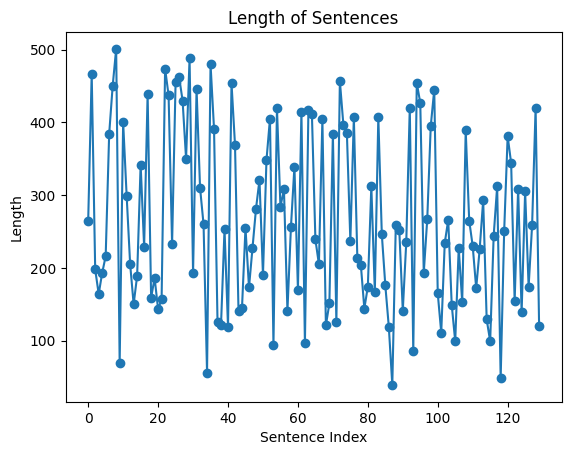

In [24]:
# 각 문장의 길이 측정
lengths = [len(sentence) for sentence in test_list]

# 그래프 생성 및 시각화
plt.plot(lengths, marker='o')
plt.title('Length of Sentences')
plt.xlabel('Sentence Index')
plt.ylabel('Length')
plt.show()


In [30]:
# 길이 100 이하인 문장 찾아서 프린트
short_sentences = [sentence for sentence in test_list if len(sentence) <= 150]

# 결과 출력
print("Sentences with length <= 100:")
for sentence in short_sentences:
    print(sentence)

Sentences with length <= 100:
철골구조는 보통 고층 건물을 가능하게 하기 위해 사용되며, 내구성이 뛰어나고 내화구조로서 안전성이 우수하면서도 경제적입니다.
방염벽지는 PVC 코팅을 하고 방염처리가 된 벽지로, 화재 시 유독가스의 확산속도를 지연시키는 장점이 있습니다. 이러한 특성으로 화재로부터의 안전을 증대시킬 수 있으며, 시공이 용이하다는 장점이 있습니다. 그러나 시공이 어렵고 비용이 상대적으로 높다는 단점이 있습니다.
네. 높은 습도는 곰팡이가 서식하기 좋은 환경이므로 곰팡이가 발생할 수 있습니다. 그리고 피스 하자는 벽지 안쪽에 사용된 못이나 다른 작은 물체로 인해 발생하는 하자를 말합니다. 피스 하자가 심하다면 도배지가 터질 위험이 있으므로 조속한 처리가 필요합니다.
페인트 하도재 없이 페인트를 칠할 경우 도막의 내구성이 약해져 페인트가 일찌감치 벗겨질 수 있습니다.
새집증후군은 새로 이사한 집에서 기존에 경험하지 못한 이상한 증상이 나타나는 증후군으로, 주로 휘발성 화학물질이 원인이 됩니다. 대표적인 원인으로는 포름알데히드가 있습니다. 포름알데히드는 방부제, 접착제의 원료로 사용됩니다.
방청도료 도장 작업을 위해 필요한 작업은 다음과 같습니다. 1. 피도면 정리 2. 방청도료 도장 3. 상도작업 순으로 진행합니다. 또한, 콘크리트에 구멍을 뚫으려면 코어드릴이나 해머드릴을 이용하여 구멍을 뚫어야 합니다.
원목마루는 마루 중에서 비용이 가장 많이 드는 편입니다. 그 이유는 원목이 두께감이 있어서 열전도율이 낮기 때문입니다. 하지만, 습기에 취약하고 표면이 두꺼워서 온돌에 시공할 경우 갈라질 수 있는 위험도 있습니다.
흡음 성능은 우수하고 가볍기 때문에 건축물의 단열재로 많이 활용됩니다. 또한 그라스울 보온판은 불연재료로 안전하며, 화재 시 유독가스 발생을 최소화하여 안전성을 높일 수 있습니다. 이로 인해 건축물 내외부의 환경을 안정적으로 유지하는 데 도움이 됩니다.
미네랄울 보온판은 규산 칼슘계 광석을 고온 용융하여 만든 순수무기질

In [29]:
# 길이 150 이하인 문장 찾아서 프린트
short_sentences = [sentence for sentence in test_list if len(sentence) > 400]

# 결과 출력
print("Sentences with length <= 150:")
for sentence in short_sentences:
    print(sentence)
    print('#'*100)

Sentences with length <= 150:
도배지에 녹이 묻어나오는 현상은 일반적으로 벽지 안쪽의 금속이 누수되어 녹이 생기며, 이로 인해 도배지에 녹오염이 발생할 수 있습니다. 이 문제는 건물 내부의 습도와 공간 내부의 누수 등이 원인일 수 있으며, 해당 경우에는 보수 또는 교체 작업이 필요합니다. 또한, 도배지 주변의 누수나 습기가 도배지에 스며들면 도배지가 젖어서 곰팡이가 발생할 수도 있습니다. 이 경우에는 건물 소유자나 거주자가 습기 관리에 책임을 져야 합니다. 누수를 발견하면 보수 작업을 통해 누수를 제거하고 곰팡이가 번식한 도배지 부분을 교체해야 합니다. 또한, 제습기를 가동하거나 환기를 통해 습도를 조절하는 것도 필요하며, 전문가의 도움을 받아 보수 작업을 하는 것이 좋습니다. 누수 부분에는 곰팡이가 발생한 도배지의 부분 또는 전체를 교체해야 할 수도 있습니다. 전문가의 도움을 받아 누수 부분을 보수하고, 곰팡이가 발생한 도배지 부분을 교체하는 것이 필요
####################################################################################################
도배지 들뜸 현상은 일반적으로 벽면에 부착되지 않는 경우를 말합니다. 만약 도배지의 중앙 부분이 들뜸이 발생한다면 "울음 하자"라고 부릅니다. 들뜸 현상이 발생하는 주요 원인과 그에 따른 책임소재, 그리고 해결 방법에 대해 알아보겠습니다.  1. 습도 원인: 높은 습도는 도배지의 접착력을 감소시켜 벽면에서 떨어질뜸을 일으킬 수 있습니다. 책임소재: 건물의 소유자나 거주자가 습기 관리의 책임이 있습니다. 해결 방법: 제습기 가동, 환기를 통해 실내 적정 습도를 유지하고 전문가의 도움을 받아 보수작업하는 것을 추천합니다.  2. 내외부 온도의 큰 차이 원인: 실내와 실외의 온도 차가 클 경우 도배 풀의 접착력이 감소하여 벽면에서 떨어질뜸이 발생할 수 있습니다. 책임소재: 건물의 소유자나 거주자가 온도 관리에 책임

In [63]:

test_list = []
for i in tqdm(range(len(test))):
    solar_answer = kogpt_chatbot(test['질문'].tolist()[i].strip(), solar_model, solar_tokenizer, 500, device)
    print(solar_answer)
    print(' ')
    test_list.append(solar_answer)

  1%|          | 1/130 [02:05<4:30:22, 125.76s/it]

> <a>방청 페인트</a>의 종류에는 어떤 것들이 있는지 알고 계신가요? 또한, 원목사이딩을 사용하는 것에 어떤 단점이 있을까요?
 


  1%|          | 1/130 [06:00<12:54:15, 360.12s/it]


KeyboardInterrupt: 

# solar+gpt

In [39]:
from tqdm import tqdm
# reset_seeds(SEED)
# answer_list를 루프 밖에서 초기화
answer_list = []

for i in tqdm(range(len(test))):
    kogpt_answer = kogpt_chatbot(test['질문'].tolist()[i].strip(), kogpt_model, kogpt_tokenizer, 200, device)
    if evaluate_similarity(test['질문'].tolist()[i].strip(), kogpt_answer) > 0.7:
        answer_list.append(kogpt_answer)
        print(f'질문 : {test["질문"].tolist()[i]}')
        print(f'답변 Kogpt 0.7이상 : {kogpt_answer}')
        print(' ')
    else:
        solar_answer = solar_chatbot(test['질문'].tolist()[i].strip(), solar_model, solar_tokenizer, 200, device)
        if evaluate_similarity(test['질문'].tolist()[i].strip(), solar_answer) > evaluate_similarity(test['질문'].tolist()[i].strip(), kogpt_answer):
            answer_list.append(solar_answer)
            print(f'Solar 유사도 더 높음 : {evaluate_similarity(test["질문"].tolist()[i].strip(), solar_answer)} vs {evaluate_similarity(test["질문"].tolist()[i].strip(), kogpt_answer)}')
            print(f'질문 : {test["질문"].tolist()[i]}')
            print(f'답변 Solar: {kogpt_answer}')
            print(' ')
        else:
            answer_list.append(kogpt_answer)
            print(f'질문 : {test["질문"].tolist()[i]}')
            print(f'답변 Kogpt 0.7 이하: {kogpt_answer}')
            print(' ')


  1%|          | 1/130 [00:02<04:58,  2.32s/it]

질문 : 방청 페인트의 종류에는 어떤 것들이 있는지 알고 계신가요? 또한, 원목사이딩을 사용하는 것에 어떤 단점이 있을까요?
답변 Kogpt 0.7이상 : 방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 또한, 원목사이딩을 사용하는 데 필요한 다양한 단점이 있습니다. 먼저, 색상이 흑백 또는 단색으로 제한되기 때문에 다양한 질감과 패턴을 활용하여 단조로움을 방지해야 합니다. 또한, 적절한 조명을 활용하여 공간의 깊이와 차원을 부여할 수 있도록 주의해야 합니다. 마지막으로, 습도 및 온도를 적절히 조절하여 지루함을 방지하고 공간에 조화로운 밸런스를 줄 수 있도록 해야 합니다. 이러한 점을 유의하면 원목사이딩을 활용하여 아름다운 공간을 꾸밀 수 있을 것입니다.
 


  2%|▏         | 2/130 [00:28<35:06, 16.46s/it]

Solar 유사도 더 높음 : 0.7160123142676476 vs 0.6800137047864953
질문 : 도배지에 녹은 자국이 발생하는 주된 원인과 그 해결 방법은 무엇인가요?
답변 Solar: 도배지에 녹이 묻어나오는 현상은 습도가 높거나 누수가 발생하여 발생할 수 있습니다. 습도가 높으면 도배지 안쪽의 금속이 녹아서 녹이 도배지에 베어나오게 됩니다. 습기로 인해 도배지에 녹오염이 발생할 수 있으며, 온도와 습도를 조절하여 누수 원인을 제거하고 곰팡이가 발생한 도배지 부분을 교체하는 것이 필요합니다. 전문가의 도움을 받아 보수작업을 하는 것이 좋습니다.
 


  2%|▏         | 3/130 [00:54<44:05, 20.83s/it]

질문 : 큐블럭의 단점을 알려주세요. 또한, 압출법 단열판을 사용하는 것의 장점은 무엇인가요?
답변 Kogpt 0.7 이하: 큐블럭의 단점은 주로 가격이 상대적으로 비싸다는 점, 그리고 균열이 일반 벽돌에 비해 더 쉽게 생길 수 있다는 것입니다. 또한 습기로 인해 하자가 발생할 가능성이 있는 것도 단점으로 꼽힙니다. 또한, 압출법단열판을 사용하는 이유 중 하나는 습기에 강하고 곰팡이 및 세균 증식을 막을 수 있기 때문입니다. 이는 건강한 실내 환경을 유지하는데 도움을 줍니다. 또한, 압출법단열판은 가벼워서 운반이 용이하고 내구성이 뛰어나다는 점도 많은 사용자들에게 긍정적인 평가를 받고 있습니다.
 


  3%|▎         | 4/130 [01:16<44:23, 21.14s/it]

Solar 유사도 더 높음 : 0.8398158911296298 vs 0.5724038422107697
질문 : 철골구조를 사용하는 고층 건물에서, 단열 효과를 높이기 위한 시공 방법은 무엇이 있을까요?
답변 Solar: 일반철골구조와 경량철골구조는 주로 사용되는 방법으로, 건물의 용도와 조건에 따라 선택되며, 각각의 방식은 다양한 장단점을 가지고 있습니다.
 


  4%|▍         | 5/130 [01:42<47:48, 22.95s/it]

Solar 유사도 더 높음 : 0.6792545714088388 vs 0.5422542641992154
질문 : 도배지의 완전한 건조를 위해 몇 주 동안 기다려야 하나요?
답변 Solar: 도배지의 완전한 건조를 위해서는 몇 가지 주의사항을 준수해야 합니다. 먼저, 도배 시에는 적절한 가구를 선택하여 도배지 원지 배면으로의 이염을 방지해야 합니다. 또한, 도배풀에 강도보강제를 혼합하여 강도를 높이고 반응성이 떨어지도록 조치해야 합니다. 이러한 조치는 반점 발생을 줄이고 벽지의 미적 외관을 유지하는 데 도움이 됩니다.
 


  5%|▍         | 6/130 [02:07<48:33, 23.49s/it]

Solar 유사도 더 높음 : 0.6515792667865753 vs 0.6417800158262252
질문 : 철근철골콘크리트 구조가 적용된 건물의 장단점은 무엇인가요?
답변 Solar: 철근철골콘크리트는 철근을 사용하여 콘크리트와 결합하여 구조를 이루는 구조물입니다. 주로 도심 지역에서 사용되며, 내구성, 내화 및 내진 성능이 뛰어나지만, 철근의 보강으로 인해 구조물의 중량이 증가하여 고층 건물에서는 아래층의 보나 기둥 단면적이 커져야 하는 문제가 있습니다.
 


  5%|▌         | 7/130 [02:26<45:20, 22.12s/it]

질문 : 어떤 상황에 개별 공간이 더 적합한지, 어떤 상황에 오픈 플랜 공간이 더 적합한지 알려주세요. 그리고 합지벽지의 어떤 단점이 있나요?
답변 Kogpt 0.7 이하: 개별 공간은 개별 공간이 있습니다. 개별 공간은 개인적인 공간과 프라이버시를 제공하여 조용한 환경을 유지할 수 있습니다. 반면에 오픈 플랜은 공간을 확장시켜 연결감을 높이고 커다란 공간을 만들어 낼 수 있습니다. 선택은 개인의 선호와 생활 방식에 따라 다릅니다. 만약 자주 손님을 맞이하는 등 활발한 활동이 많은 경우에는 오픈 플랜이 더 적합할 수 있습니다. 하지만 개인적인 시간을 중시하고 분리된 공간에서의 프라이버시를 중요시하는 경우에는 개별 공간이 더 적합할 수 있습니다. 또한, 합지벽지의 주요 단점은 상대적으로 짧은 수명과 내구성이 약하다는 점입니다. 또한 오염이 생기면 청소가 어렵고, 시간이 지나면 색상이 변할 수 있다는 것도 단점으로 꼽힙니다. 이러한 단점들은 합지벽지를 선택할 때 고려해야 하는 부분입니다.
 


  6%|▌         | 8/130 [02:28<31:51, 15.66s/it]

질문 : 도배지 들뜸 현상이 발생하는 가장 일반적인 원인은 무엇인가요?
답변 Kogpt 0.7이상 : 도배지 들뜸 현상은 일반적으로 벽면에 부착되지 않는 경우를 말합니다. 만약 도배지의 중앙 부분이 들뜨게 되면 이를 "울음 하자"라고 칭합니다. 주된 원인은 습도의 증가로 인한 도배지의 접착력 감소입니다. 이 경우에는 건물 소유자나 거주자가 습기 관리에 책임이 있으며, 제습기나 환기를 통해 실내 적정 습도를 유지하고 전문가의 도움을 받아 보수 작업을 하는 것이 좋습니다. 또한 내외부의 온도 차가 클 경우에도 도배지의 들뜸이 발생할 수 있습니다. 이 경우에도 건물 소유자나 거주자가 온도 관리에 책임이 있으며, 냉·난방 시스템을 활용하여 온도 차이를 줄이고 습도를 조절하는 것이 필요합니다. 마지막으로 벽면에 손상이 있을 경우에도 도배지의 들뜸이 발생할 수 있습니다. 이 경우에도 건물 소유자나 거주자가 습기 관리에 책임이 있으며, 적절한 보수 및 관리가 필요합니다. 전문가의 도움을 받아 보수 작업을 하는 것이 좋습니다.
 


  7%|▋         | 9/130 [02:54<38:27, 19.07s/it]

Solar 유사도 더 높음 : 0.7601816296577453 vs 0.6934392902730168
질문 : 도배지에 얼룩이 생기는 다양한 원인들에 대해서 자세히 알려주세요.
답변 Solar: 도배지에 생긴 얼룩을 제거하는 방법은 도배지의 종류와 오염 정도에 따라 달라질 수 있습니다. 예를 들어, 빈티지 도배지에서의 얼룩 제거 방법은 실크 도배지에 필요한 방법과 약간 차이가 있을 수 있습니다.

1. 종이 도배지에서의 얼룩 제거 방법: 치약, 주방 세제, 베이킹 소다, 걸레
- 치약이나 주방 세제와 물을 섞은 후 걸레에 묻혀 얼룩이 생긴 도배지를 청소합니다. 
- 치약이나 주방 세제와 물을 섞은 후 걸레에 묻혀 얼룩이 생긴 부분을 청소합니다. 
- 치약이나 주방 세제와 물을 섞은 후 걸레에 묻혀 얼룩이 생긴 부분을 청소합니다. 
- 그리고 걸레로 얼룩을 닦아내고, 건조시켜 주세요.
- 만약 얼룩이 사라지지 않는다면 오염된 부분 혹은 전체를 교체해야 할 수도 있습니다.

2. 실크 도배지에서의 얼룩 제거 방법: 주방 세제
 


  8%|▊         | 10/130 [02:55<26:40, 13.34s/it]

질문 : 고층 건물을 건축할 때 철골구조가 주로 선택되는 이유는 무엇인가요?
답변 Kogpt 0.7이상 : 철골구조는 보통 고층 건물을 설계하고 싶을 때 많이 사용됩니다. 이 방식은 건물의 용도와 디자인뿐만 아니라 주변 환경과의 조화 역시 중요하며, 고층 건물의 경우 보행감과 디자인 또한 고려해야 합니다.
 


  8%|▊         | 11/130 [02:57<19:37,  9.90s/it]

질문 : 유성페인트의 환경 오염에 대한 예시를 알려주세요.
답변 Kogpt 0.7이상 : 유성페인트의 사용은 몇 가지 단점이 있습니다. 첫째, 유성페인트는 석유나 석탄으로부터 추출된 기름이나 화학물질로 만들어지기 때문에 일부 성분은 인체에 유해한 영향을 줄 수 있습니다. 특히, 벤젠, 톨루엔, 자일렌과 같은 유해물질이 포함되어 있어 장기간 노출될 경우 암, 호흡기 질환, 피부 질환 등의 건강 문제를 유발할 수 있습니다. 둘째, 유성페인트는 강한 냄새가 나며, 이는 주변 환경에서 불쾌감을 유발할 수 있습니다. 또한, 유성페인트의 건조 시간이 수성페인트에 비해 길기 때문에 작업 시간이 더 오래 걸릴 수 있습니다. 또한, 유성페인트는 환경 오염을 유발할 수 있습니다. 이러한 페인트의 성분 중 일부는 대기 중에 방출되면 미세먼지나 오존 등의 오염물질을 생성할 수 있습니다. 셋째, 유성페인트는 유지보수가 어렵습니다. 물에 녹지 않기 때문에 청소나 보수 작업 시 추가적인 도구와 방법이 필요하며, 이는 비용과 시간을 더 많이 필요로 
 


  9%|▉         | 12/130 [02:58<14:19,  7.28s/it]

질문 : 훼손과 오염은 어떻게 다른가요? 또한, 부실 시공으로 인해 타공하자가 발생할 가능성이 있나요?
답변 Kogpt 0.7이상 : 훼손과 오염의 차이는 물리적인 변화의 유무입니다. 훼손은 찍힘, 터짐 등의 물리적인 충격이나 힘을 받아 상태가 변한 것을 의미합니다. 이에 반해 오염은 녹 오염, 반점 등의 얼룩 형태로 나타나는 경우를 의미합니다. 또한, 부실 시공으로 인해 타공불량이 발생할 수 있습니다. 타공을 할 때 적절하지 않은 도구를 사용하거나 타공 부위의 크기를 정확히 측정하지 않으면 타공이 원하는 크기나 위치에 맞지 않을 수 있습니다. 이는 부실한 시공으로 인해 발생하는 문제로, 신중한 작업과 적합한 도구를 사용하여 부실 시공을 방지할 필요가 있습니다.
 


 10%|█         | 13/130 [02:59<10:22,  5.32s/it]

질문 : 철골콘크리트 구조에서 사용되는 철근의 재료적 특징은 무엇인가요?"
답변 Kogpt 0.7이상 : 철골콘크리트는 기둥, 보, 내력벽, 바닥 슬라브 등의 주요 구조부가 철근 콘크리트로 시공되어 강한 인장력과 압축력을 견디는 구조를 갖추고 있습니다. 이러한 구조는 자유로운 형상을 구현하고, 내구성, 내화성, 내진성을 갖추고 있지만, 비강도가 비교적 작고, 다양한 이유로 균열 발생 위험이 있는 점이 단점입니다.
 


 11%|█         | 14/130 [03:24<21:47, 11.27s/it]

Solar 유사도 더 높음 : 0.7460586415869849 vs 0.5760507941246032
질문 : 방염벽지가 실크벽지와 합지벽지와 다른 점은 무엇인가요?
답변 Solar: 방염벽지는 PVC 코팅을 하고 방염처리가 된 벽지로, 화재 시 유독가스의 확산속도를 지연한다는 장점이 있습니다. 이러한 특성으로 화재로부터의 안전을 증대시킬 수 있으며, 시공이 용이하다는 장점이 있습니다. 다만, 시공이 어렵고 대중적으로 사용되는 합지벽지나 실크벽지에 비해 비싸다는 단점이 있습니다.
 


 12%|█▏        | 15/130 [03:46<28:04, 14.65s/it]

Solar 유사도 더 높음 : 0.7972206442645101 vs 0.5623344361782073
질문 : 도배지에 곰팡이가 생겼을 때 높은 습도가 원인인 경우, 습기 관리는 어떻게 해야 할까요?"
답변 Solar: 습식방식과 건식방식은 도배 시공 전 물과 혼합하여 시공하는 방식으로, 이 방식은 건축 자재에 방수 처리하는 방법입니다.
 


 12%|█▏        | 16/130 [03:47<20:03, 10.56s/it]

질문 : 롱브릭타일은 어떤 종류의 타일인가요? 그리고 페인트 상도재의 역할과 사용 방법에 대해 알려주세요.
답변 Kogpt 0.7이상 : 롱브릭타일은 모노롱브릭타일의 다른 명칭으로, 얇고 긴 형태의 벽돌 모양을 가진 타일을 말합니다. 이러한 타일은 노출 콘크리트와 비슷한 분위기를 연출하여 건물 내외부에 활용됩니다. 그리고 페인트 상도재의 장점은 방청도료가 미관적으로 우수하고 시공방법에 따른 단열성능의 오차가 적습니다. 또한, 방청도료가 전색제에 따라 방청 효과도 조절할 수 있어 다양한 용도로 활용할 수 있습니다.
 


 13%|█▎        | 17/130 [04:13<28:16, 15.01s/it]

질문 : 준불연재료는 무엇인가요? 그리고 유성페인트를 사용하는 것에 대한 부작용이 있을까요?
답변 Kogpt 0.7 이하: 준불연재료는 10분간 화재에 견딜 수 있는 소재를 의미합니다. 또한, 유성페인트를 사용하는 경우 주의해야 할 몇 가지 단점이 있습니다.   첫째, 유성페인트는 석유나 석탄에서 추출한 기름이나 화학물질로 만들어지기 때문에, 일부 성분은 인체에 유해한 영향을 미칠 수 있습니다. 특히, 벤젠, 톨루엔, 자일렌과 같은 유해물질이 포함되어 있어 장기간 노출될 경우 암, 호흡기 질환, 피부 질환 등의 건강 문제를 유발할 수 있습니다.  둘째, 유성페인트는 강한 냄새가 나며, 이는 주변 환경에서 불쾌감을 유발할 수 있습니다. 또한, 유성페인트는 건조 시간이 수성페인트에 비해 길기 때문에 작업 시간이 더 오래 걸릴 수 있습니다.  셋째, 유성페인트는 환경 오염을 유발할 수 있습니다. 이러한 페인트는 화학물질의 종류를 성분으로 만들어지기 때문에, 환경 오염을 유발할 수 있습니다. 이러한 페인트의 
 


 14%|█▍        | 18/130 [04:34<31:28, 16.86s/it]

질문 : 어떤 환경 요인이 몰딩 수정을 유발할 수 있는가요? 그리고 반점이 생긴지 1년 이내인 하자에 대해 어떤 보수작업을 해야 하나요?
답변 Kogpt 0.7 이하: 몰딩의 수정이 발생하는 환경조건은 여러 가지가 있습니다. 주로 몰딩이 햇빛, 습기, 화학물질 등의 외부요인에 노출될 때 수정이 발생할 수 있습니다. 특히 햇빛과 습기가 결합하여 몰딩의 수정을 유발할 수 있으며, 화학물질 또는 다른 외부 요인에 의해서도 수정이 발생할 수 있습니다. 이러한 환경조건이 적절하게 관리되지 않으면 몰딩이 수정될 가능성이 높으니 주의가 필요합니다. 또한, 벽지에 반점이 생겼을 때 유색반점 발생 시기가 벽지시공 후 1년 이내인 경우, 보수작업은 아래와 같이 해야 합니다. 먼저, 이염 방지제를 도포한 후에 개선 벽지로 전면 재시공하는 것이 필요합니다. 반점이 생긴 상태에서 아세톤 용제를 사용하여 함침하는 것은 유색 반점을 확대시키거나 신규 이염이 발생할 우려가 있으므로 추천되지 않습니다. 따라서 반점이 눈에 띄고, 개선이 불가능한 상황이라면 전문가의 도움을
 


 15%|█▍        | 19/130 [04:54<32:46, 17.71s/it]

Solar 유사도 더 높음 : 0.7029169191332424 vs 0.5654741723537445
질문 : 벽에 뚫린 구멍이 이상하다고 하셨는데, 타공 불량이 발생하는 원인과 그 해결 방법에 대해 자세히 설명해주실 수 있을까요?"
답변 Solar: 타공불량은 부실한 시공으로 인해 발생할 수 있습니다. 예를 들어, 적절하지 않은 도구로 작업하거나 타공 부위의 크기를 정확히 측정하지 않고 작업하면 타공불량이 발생할 수 있습니다. 이런 경우에는 전문가의 도움을 받아 적절한 도구와 기술을 사용하여 타공을 다시 시공하는 것이 필요합니다.
 


 15%|█▌        | 20/130 [05:20<37:19, 20.36s/it]

Solar 유사도 더 높음 : 0.7372765553720069 vs 0.5108537445262987
질문 : 다이닝 룸을 더 고급스럽게 꾸밀려면 어떻게 해야 하나요와 아레카 야자를 키우면 어떤 이점이 있는지의 관계는 무엇인가요?
답변 Solar: 다이닝 룸을 정통적으로 꾸미기 위해서는 대형 식탁과 고풍스러운 의자를 선택하는 것이 중요합니다. 또한, 벽지나 커튼 등에 화려한 직물을 활용하여 고급스러운 분위기를 연출할 수 있습니다. 또한, 창가에는 커다란 커튼을 활용하여 고급스러운 분위기를 조성할 수 있습니다.복고풍의 가구나 소품 선택을 통해 전통적이면서도 우아한 분위기를 연출할 수 있습니다.
 


 16%|█▌        | 21/130 [05:54<44:20, 24.40s/it]

Solar 유사도 더 높음 : 0.7139177444013389 vs 0.610922963743986
질문 : 습도가 높아서 석고수정이 발생하나요? 또한, 피스 하자가 무엇인지 자세히 설명해 주실 수 있나요?
답변 Solar: 네. 높은 습도는 곰팡이가 서식하기 좋은 환경이므로 곰팡이가 발생할 수 있습니다. 그리고 피스 하자는 벽지 안쪽에 사용된 못이나 다른 작은 물체로 인해 발생하는 하자를 말합니다. 피스 하자가 심하다면 도배지가 터질 위험이 있으므로 조속한 처리가 필요합니다.
 


 17%|█▋        | 22/130 [05:55<31:19, 17.40s/it]

질문 : 공동주택의 실내 공기질을 측정할 때, 어떤 층에서 샘플을 채취하는 것이 가장 적절한가요?"
답변 Kogpt 0.7이상 : 공동주택의 실내 공기질을 측정하기 위해서는 최저층에서 측정합니다. 이때, 저층부, 중층부, 그리고 고층부 순으로 다양한 층에서 활용됩니다. 또한, 100세대 이상의 경우마다 추가적으로 1세대씩 측정지점을 설정하며, 최대 20세대까지 측정을 확대합니다.
 


 18%|█▊        | 23/130 [05:58<23:03, 12.93s/it]

질문 : 타일 바닥에서 파손된 타일을 교체하는 과정에 어떤 단계가 포함되나요? 또한, 겨울에 도배를 할 때 특별히 신경써야 할 사항이 있을까요?
답변 Kogpt 0.7이상 : 타일 바닥에서 파손된 타일을 교체하는 데에는 몇 가지 팁이 있습니다. 먼저 손상을 입은 타일을 제거한 다음, 깨끗한 표면을 만들어야 합니다. 그 후 새로운 타일을 설치하기 위해 접착제와 못을 사용하여 고정하면 됩니다. 새 타일을 완전히 고정하고 균등한 공간을 유지하기 위해 타일을 설치한 후, 수분과 먼지로부터 보호하기 위해 실리콘으로 주변을 밀봉하세요. 마지막으로 새로 교체한 타일을 완전히 말린 후에 다시 사용할 수 있습니다. 또한, 겨울에 도배를 할 때 고려해야 할 몇 가지 주의사항이 있습니다. 1. 온도 유지: 추운 겨울에는 도배 풀이 얼어버릴 수 있으므로, 보일러나 전열기를 사용하여 실내 온도를 일정하게 유지해야 합니다. 2. 고열에 노출 최소화: 도배 전 열기를 과도하게 사용하면 도배지의 색상이 변하거나 이음매가 벌어질 수 있으므로, 과도한 열기 노출을 피해야 합니다. 3.
 


 18%|█▊        | 24/130 [06:26<30:59, 17.55s/it]

질문 : 유성페인트를 사용하는 것에 대한 부작용이 있을까요? 또한, 페인트가 남으면 어디에 보관하는 게 좋을까요?
답변 Kogpt 0.7 이하: 유성페인트를 사용하는 경우 주의해야 할 몇 가지 단점이 있습니다.   첫째, 유성페인트는 석유나 석탄에서 추출한 기름이나 화학물질로 만들어지기 때문에, 일부 성분은 인체에 유해한 영향을 미칠 수 있습니다. 특히, 벤젠, 톨루엔, 자일렌과 같은 유해물질이 포함되어 있어 장기간 노출될 경우 암, 호흡기 질환, 피부 질환 등의 건강 문제를 유발할 수 있습니다.  둘째, 유성페인트는 강한 냄새가 나며, 이는 주변 환경에서 불쾌감을 유발할 수 있습니다. 또한, 유성페인트는 건조 시간이 수성페인트에 비해 길기 때문에 작업 시간이 더 오래 걸릴 수 있습니다.  셋째, 유성페인트는 환경 오염을 유발할 수 있습니다. 이러한 페인트는 화학물질에 민감한 영향을 미칠 수 있습니다. 이러한 페인트의 성분 중 일부는 대기 중에 방출되면 미세먼지나 오존 등의 오염물질을 생성할 수 있습니다.  넷째
 


 19%|█▉        | 25/130 [06:43<30:19, 17.33s/it]

Solar 유사도 더 높음 : 0.7399442562690148 vs 0.6924449000093672
질문 : 가장 비싼 바닥재는 어떤 종류인가요? 또한, 유광 자기질 타일은 얼마나 오랫동안 사용할 수 있을까요?
답변 Solar: 대리석 타일은 가장 비싼 바닥재 중 하나로 알려져 있습니다. 대리석은 자연스러운 아름다움과 고급스러움으로 유명하며, 유지 보수가 어렵고 설치가 비용이 많이 드는 것으로 알려져 있습니다. 이러한 특성으로 인해 대리석 바닥재는 일반적으로 고가의 옵션으로 간주됩니다. 하지만 비슷하게, 테라코타 타일, 목재 바닥재, 그리고 대형 석재 또한 비싼 바닥재로 알려져 있습니다. 그리고 유광 자기질 타일의 기대수명은 50년입니다.
 


 20%|██        | 26/130 [06:45<22:09, 12.79s/it]

질문 : 풍수지리를 활용하여 집을 꾸밀 때 어떤 주의사항을 고려해야 할까요? 그리고 스탠드조명을 선택할 때 주의할 점이 있을까요?
답변 Kogpt 0.7이상 : 풍수지리를 활용하여 집을 꾸밀 때에는 주택의 형태와 내부 배치 뿐만 아니라 문의 위치, 가구 배치, 그리고 색상 선택에도 깊이 고려해야 합니다. 풍수지리의 원리와 민감한 영향을 고려하여 결정을 내리는 것이 중요합니다. 유의할 점으로는 풍수지리의 세부 사항을 자세히 이해하고 전문가의 조언을 구하는 것이 필요합니다. 그리고 스탠드 조명을 선택할 때 주의해야 할 점은 다양합니다. 먼저, 공간의 형태와 목적에 적합한 조명을 선택해야 합니다. 또한, 조명의 밝기와 색온도, 조명의 디자인과 재질도 주의하여 고려해야 합니다. 또한, 조명의 에너지 소비량과 전구의 교체 주기, 그리고 설치 및 유지 보수의 편의성도 고려해야 합니다. 더불어 조명이 주는 분위기와 조명의 방향성, 그리고 스마트 조명 및 조명의 조절 가능성 또한 꼼꼼히 살펴봐야 합니다.
 


 21%|██        | 27/130 [06:47<16:25,  9.57s/it]

질문 : 반점이 1년 이상 생긴 하자를 보수하는 방법은 무엇인가요? 그리고 불량 도배지를 사용할 경우 도배지가 얼마나 오랫동안 버틸까요?
답변 Kogpt 0.7이상 : 반점이 1년 이상된 벽지의 보수 작업은 좀 더 많은 주의와 전문 지식이 필요합니다. 먼저, 벽지 속지 내부에 주사기를 사용하여 아세톤을 함침하여 반점을 제거하는 시도를 할 수 있지만, 이는 보다 신중한 접근이 필요합니다. 아세톤이 벽지 속지 내부로 침투하여 반점을 제거하는 방법은 가능하지만, 반점이 1년 이상 지속된 경우에는 원자색 혹은 수채색 벽지 염료 또는 페인트를 표면으로부터 완전히 제거하기 어려울 수 있습니다.  따라서, 반점이 1년 이상된 경우 먼저 전문가의 조언을 받아야 합니다. 전문가는 벽지의 재시공여부와 다른 보수작업이 필요한지를 정확하게 평가할 수 있습니다. 종종, 벽지의 재시공이 필요한 경우가 발생할 수 있으며, 이는 전문가의 도움을 받지 않고 시도하기에는 복잡하고 전문적인 과정입니다. 따라서, 반점이 1년 이상된 경우에는 전문가의 도움을 받아 벽지를 신중하게 평가하고, 필요한 보수작업을 전문적으로 
 


 22%|██▏       | 28/130 [06:49<12:20,  7.26s/it]

질문 : 평지붕의 단점은 무엇인가요? 그리고 실크벽지의 교체 주기는 얼마나인가요?
답변 Kogpt 0.7이상 : 평지붕의 단점은 경사지붕에 비해 에너지 손실이 크고, 단열 및 방수를 위한 시공비용이 많이 들며 누수의 위험이 있으며 다른 지붕재보다 수명이 짧은 것이 주요한 단점입니다. 또한, 평지붕은 눈과 물이 쌓일 수 있는 위험이 있으며 물이 효과적으로 배출되지 않을 때 침수문제가 발생할 수 있습니다. 이러한 문제를 관리하기 위해서는 정기적인 청소 및 유지보수가 필요합니다. 그리고 실크벽지의 교체 주기는 일반적으로 5~7년이며, 그 이후에는 바탕이 되는 벽지의 상태 및 사용 환경에 따라 조금 더 나중이나 조금 더 이르게 교체해야 할 수도 있습니다. 때때로 빛의 노출이 많은 공간의 실크벽지는 색상이 바래어 보이거나 벽지 자체가 손상되는 경우가 있는데, 이러한 상황에서는 교체 주기를 조정할 필요가 있습니다. 혹은 특별히 신중하게 관리될 경우 교체 주기를 늘릴 수도 있습니다.
 


 22%|██▏       | 29/130 [06:50<09:19,  5.54s/it]

질문 : 경량철골구조는 어떤 건물에 사용되는 건축 구조물인가요? 그리고 철골구조의 장점은 무엇인가요?
답변 Kogpt 0.7이상 : 경량철골구조는 약 1.5~3mm 두께의 철골을 사용하며 각각 파이프, C형 찬넬, LEB 자재 등을 이용하여 건축하는 구조물을 말합니다. 일반적으로 주택, 창고, 농자재 등에 사용되며 경량이면서도 강도가 높기 때문에 건축물의 안정성을 확보하면서도 경제적으로 시공할 수 있다는 장점이 있습니다. 그리고 철골구조의 장점은 건물의 외벽에 하중이 적게 걸리기 때문에 고층 건물의 건축이 용이하다는 점입니다. 또한 철골은 높은 강도를 가지고 있어 안정성이 뛰어나며, 시공성이 우수하여 건설 기간을 단축할 수 있는 장점이 있습니다. 또한 철골은 재사용이 가능하고, 화재에 강한 성질을 가지고 있어 안전성이 높다는 점도 장점으로 꼽힙니다.
 


 23%|██▎       | 30/130 [07:14<18:25, 11.06s/it]

Solar 유사도 더 높음 : 0.6895570456981659 vs 0.5576859845234466
질문 : 프리케스트 콘크리트 구조에 대해 자세히 설명해 주실 수 있나요? 그리고 조적식 구조란 무엇인가요?
답변 Solar: 프리케스트 콘크리트 구조는 PC라고도 불리며, 건축물의 벽, 슬래브(SLAB), 보 등의 콘크리트 부재를 공장에서 미리 제작하여 현장에서 조립하는 공법입니다. 이는 안정된 환경에서 품질관리와 대량생산이 가능하여 품질 확보 및 원가절감이 가능하며, 현장에서는 일부 구간 RC(철근 콘크리트) 공법과 병행하여 공장 생산 PC 부재와의 연결을 통해 공기 단축이 가능한 장점을 가지고 있습니다. 프리케스트 콘크리트 구조는 건축물을 보다 신속하게 건설하고 품질을 관리할 수 있는 방법으로, 현재 건축산업에서 높은 인기를 얻고 있습니다. 또한, 조적식 구조는 벽돌 또는 콘크리트 블록을 모르타르로 서로 접착하여 쌓아 만드는 구조 방식을 말합니다. 이 방식은 보편적으로 주택과 같은 소규모 건물에 사용되며 내습, 내구성, 내화성이 좋고 경제적이라는 장점이 있습니다. 그러나 수평방향의 외력에 대해 상대적으로 취약하며, 단일 벽체로 쌓을 수 있는 수평 및 수직 방향에 제한이 있을 수 있
 


 24%|██▍       | 31/130 [07:15<13:15,  8.03s/it]

질문 : 반려동물을 위한 가구로 낮은 높이의 가구와 패브릭 소재의 가구가 선택되는 이유는 무엇인가요?
답변 Kogpt 0.7이상 : 반려동물을 위한 가구로는 낮은 높이의 가구나 패브릭 소재의 가구가 있습니다. 낮은 높이의 가구를 선택하면 반려동물의 목관절을 보호할 수 있으며, 계단을 둔다면 다리 관절을 보호할 수 있습니다. 또한, 패브릭 소재의 가구를 선택하면 가죽소재의 세탁이 용이해지며, 스크래치가 덜 발생할 수 있어 반려동물과 함께 보다 편안한 공간을 유지할 수 있습니다.
 


 25%|██▍       | 32/130 [07:39<20:53, 12.80s/it]

Solar 유사도 더 높음 : 0.8085207602557013 vs 0.3719635009765625
질문 : 몰딩 수정을 예방하기 위해 건물 내부에서 어떤 종류의 환경 관리가 필요한가요?
답변 Solar: 몰딩을 교체하기 전에는, 기존 벽지를 제거하지 않고 그대로 사용할 수 있습니다. 또한, 몰딩은 벽지와 비슷한 색상을 가지므로 조화롭게 사용할 수 있습니다.
 


 25%|██▌       | 33/130 [07:40<15:01,  9.29s/it]

질문 : KMEW 세라믹 지붕재의 단점에 대해 알려주세요. 또한, 세라믹 타일을 사용할 때 고려해야 할 단점은 무엇인가요?
답변 Kogpt 0.7이상 : KMEW 세라믹 지붕재의 단점 중 하나는 가격이 비싸다는 것입니다. 또 다른 단점으로는 금속 지붕재에 비해 상대적으로 무겁다는 점이 있습니다. 그러나 이러한 단점에도 불구하고, KMEW 세라믹 지붕재는 탁월한 내구성과 아름다운 디자인으로 많은 사람들에게 인기가 있습니다. 그리고 흙을 구워 만드는 타일을 선택할 때 고려해야 할 단점으로는 온도나 습도에 영향을 받을 때 적합한 타일을 선택하는 것이 중요합니다. 또한, 타일을 할 때 적합한 타일을 선택하여 설치해야 합니다.
 


 26%|██▌       | 34/130 [08:06<22:37, 14.14s/it]

질문 : 줄퍼티 마감은 무엇인가요? 또한, 액체방수공사는 무엇을 하는 것인가요?
답변 Kogpt 0.7 이하: 줄퍼티 마감은 석고보드의 이음메 부분을 메꾼 후 1차, 2차로 퍼티를 해 마감하는 것을 의미합니다. 줄퍼티 마감은 올퍼티 마감보다 단가가 저렴하다는 장점이 있지만 이음메 부분의 배부름 현상이 있으며, 줄퍼티를 한 곳과 하지 않은 곳의 질감 차이가 있다는 단점이 있어 주로 가게, 식당, 공장 등에서 시공됩니다. 또한, 액체방수공사란 콘크리트, 모르타르 등의 표면에 액체 형태의 방수제를 도포하거나 침투시키고 방수제를 혼합한 모르타르를 덧발라 침투를 막는 공법입니다.
 


 27%|██▋       | 35/130 [08:38<31:10, 19.69s/it]

Solar 유사도 더 높음 : 0.8362760608260695 vs 0.5870041163194747
질문 : 페인트 하도재 없이 페인트를 바로 칠할 경우 어떤 문제가 발생할 수 있나요?
답변 Solar: 페인트 하도재는 페인트의 접착력을 향상시켜 주며, 바탕면에 페인트를 미끄러지게 해줍니다. 이 재료는 방수 또는 녹방지 기능도 포함하고 있어 필요에 따라 선택적으로 페인트 칠이 가능합니다. 또한, 페인트 하도재의 표면에 적용되어 도막의 내구성을 향상시키고,수지성과 방수 기능을 향상시킵니다.
 


 28%|██▊       | 36/130 [09:13<37:58, 24.24s/it]

Solar 유사도 더 높음 : 0.7249169916766031 vs 0.6604325030712371
질문 : 바닥재가 남으면 어떻게 처리하는 게 좋을까요? 그리고 장판이 남을 때 어떻게 처리해야 하나요?
답변 Solar: 바닥재를 처리하는 방법은 일반적으로 지자체에서 지정한 방법에 따라 처리해야 합니다. 대부분의 경우, 남은 바닥재는 지정된 특수 규격 봉투(불연성 폐기물 마대)에 넣어서 배출해야 합니다. 하지만 특수 규격 봉투를 판매하는 곳이 제한적일 수 있으므로 해당 규정에 따라 처리해야 합니다.  만약 바닥재가 5톤 이상이라면, 전문 업체를 통해서 바닥재를 수거해야 합니다. 따라서 바닥재가 남으면 지역의 구청이나 주민센터 등 관련 기관에 사전 문의하여 처리 방법을 확인하는 것이 좋습니다. 지역에 따라 처리 방법이 상이할 수 있으므로 정확한 절차를 따르는 것이 중요합니다. 또한, 장판이 남을 때 처리 방법은 다음과 같습니다. 먼저, 장판을 처리하는 방법에 대해 알려드리겠습니다. 먼저, 장판의 크기에 맞게 험지 등의 천을 깔아야 합니다. 그 후에는 장판을 고정하고 건조시켜 이 방법으로 장판을 설치할 수 있습니다. 또한, 장판의 크기에 맞게 아파트의 경우에는 구청이나 주민센터 등 관련 기관에 사전 문의하
 


 28%|██▊       | 37/130 [09:40<38:43, 24.99s/it]

Solar 유사도 더 높음 : 0.6525528533892198 vs 0.6379896992860838
질문 : 도배지에 생긴 반점을 없애기 위해 가장 효과적인 방법은 무엇인가요?
답변 Solar: 도배지에 생기는 반점 부분을 효과적으로 제거하는 방법은 도배지의 종류와 오염 정도에 따라 다양합니다. 예를 들어, 빈티지 도배지에서 얼룩을 지우는 방법은 실크 도배지에 필요한 방법과는 조금 다를 수 있습니다.  1. 보통 종이 도배지 준비물: 치약, 주방 세제, 베이킹 소다, 걸레 치약이나 주방 세제를 조금 묻힌 식빵을 사용하여 문질러주세요. 그리고 물기를 꽉 짠 걸레로 닦아내고, 마지막으로 건조시켜 주세요. 만약 얼룩이 지워지지 않는다면 물에 베이킹 소다를 섞어 반죽을 만들어 활용할 수 있습니다.  2. 실크 도배지 준비물: 주방 세제, 걸레 주방 세제와 물을 섞어 걸레에 묻힌 후 걸레에 묻힌 후 도배지를 부드럽게 닦아내야 합니다.  하지만, 위 방법으로 얼룩을 지워도 사라지지 않는다면 오염된 부분을 교체해야 할 수 있습니다.
 


 29%|██▉       | 38/130 [10:08<39:40, 25.88s/it]

질문 : 새집증후군의 주요 원인은 무엇인가요?
답변 Kogpt 0.7 이하: 새집증후군은 새로 이사한 집에서 기존에 경험하지 못한 이상한 증상이 나타나는 증후군으로, 주로 휘발성 화학물질이 원인이 됩니다. 대표적인 원인으로는 포름알데히드가 있으며, 주로 방부제나 접착제의 원료로 사용됩니다. 때문에, 새 집에 사용된 재료나 가구에서 높은 농도로 방출되는 휘발성 유기 화합물에 노출되는 것으로 인한 공기 오염이 발생할 수 있습니다.
 


 30%|███       | 39/130 [10:09<27:46, 18.31s/it]

질문 : 방청도료 도장 작업을 위해 필요한 단계는 무엇인가요? 또한, 콘크리트 벽에 구멍을 뚫는 방법에는 어떤 도구나 기술을 사용해야 하나요?
답변 Kogpt 0.7이상 : 방청도료 도장작업을 위해 필요한 작업은 다음과 같습니다. 1. 피도면 정리 2. 방청도료 도장 3. 상도작업 순으로 진행합니다. 또한, 콘크리트에 구멍을 뚫으려면 코어드릴이나 해머드릴을 이용하여 구멍을 뚫어야 합니다.
 


 31%|███       | 40/130 [10:10<19:45, 13.18s/it]

질문 : 어떤 종류의 실내 식물을 선택해야 식물을 효과적으로 가꾸는 데 도움이 될까요? 그리고 인테리어에 가장 많이 사용되는 도배재료는 무엇인가요?
답변 Kogpt 0.7이상 : 실내 식물을 가꾸려면 자연조명이 있는 곳에 맞는 식물, 공기 정화식물, 그리고 효과적인 관리를 위한 식물을 고려하세요. 또한, 인테리어에 사용되는 도배재료는 다양한 종류가 있습니다. 예를 들어, 질감이 다른 소품을 배치하거나, 벽면에 독특한 텍스처의 타일을 사용하는 등의 방법이 있습니다. 또한, 실크벽지나 이미 페인트 처리된 벽지를 활용하여 벽면을 활용하여 적절한 마감 효과를 만드는 것도 좋은 방법입니다. 이러한 다양한 도배재료를 활용하여 인테리어를 완성할 수 있습니다.
 


 32%|███▏      | 41/130 [10:34<24:23, 16.44s/it]

Solar 유사도 더 높음 : 0.6726503431797027 vs 0.548892593383789
질문 : 원목마루와 롱브릭타일에 대해 설명해주세요. 각각의 단점과 특징은 무엇인가요?
답변 Solar: 원목마루는 마루 중에서 비용이 가장 많이 드는 편입니다. 그 이유는 원목이 두께감이 있어서 열전도율이 낮기 때문입니다. 하지만, 습기에 대해서는 원목마루는 약한 특성을 가지고 있습니다.
 


 32%|███▏      | 42/130 [10:35<17:11, 11.72s/it]

질문 : 침실을 더 아늑하게 꾸밀 수 있는 방법에는 어떤 것이 있을까요와 아이가 있는 집을 꾸밀 때 안전을 위해 고려해야 할 요소는 무엇인가요의 관계는 무엇인가요?
답변 Kogpt 0.7이상 : 침실을 아늑하게 만들기 위해서는 부드러운 조명, 포근한 이불과 함께 나무 가구를 활용하는 것이 좋습니다. 또한, 부드러운 색상과 부드러운 질감을 활용하여 침실을 아늑하게 꾸밀 수 있습니다. 최종적으로는 개인적으로 소중한 것들과 사랑하는 물건들로 침실을 꾸며 보세요.
 


 33%|███▎      | 43/130 [10:36<12:34,  8.67s/it]

질문 : 인테리어에서 컬러매치를 위한 효과적인 팁이 있을까요? 그리고 복도나 협소한 공간을 확장시키기 위해 가장 효과적인 방법이 무엇일까요?
답변 Kogpt 0.7이상 : 컬러매치를 위해서는 대비 컬러와 조화 컬러를 활용하는 것이 중요합니다. 주요 색상과 보조 색상을 조합하여 공간의 분위기를 조절하고, 색상의 밝고 어두운 정도를 고려하여 조화로운 매치를 만들어야 합니다. 또한, 인테리어 스타일과 공간의 크기, 사용목적 등을 고려하여 컬러매치를 결정하는 것이 좋습니다. 예를 들어, 작은 공간에는 밝고 활기찬 컬러를 이용하여 공간을 확장시키는 효과를 내거나, 안정감을 주기 위해 중성적인 컬러를 활용하는 것이 효과적입니다. 또한, 조명의 영향을 고려하여 컬러를 선택하고, 같은 색상 계열을 사용해 조화로운 분위기를 연출할 수 있습니다. 그리고 복도나 협소한 공간을 확장하려면 큰 거울, 밝은 컬러, 그리고 슬림 가구를 사용하세요.
 


 34%|███▍      | 44/130 [10:37<08:59,  6.27s/it]

질문 : 그라스울 보온판의 주요 장점 중 하나인 흡음 성능은 어떻게 발휘될까요?"
답변 Kogpt 0.7이상 : 흡음 성능은 우수하면서도 유연하게 조절 가능한 유연성입니다. 유리섬유나 알루미늄과 같은 재질을 사용하거나 가구 배치에도 적합하며, 소음이나 진동을 흡수하는 소재를 사용합니다. 이러한 유연성 덕분에 건축 구조물에 적합한 보온재로 사용됩니다.
 


 35%|███▍      | 45/130 [11:03<17:27, 12.33s/it]

Solar 유사도 더 높음 : 0.7314775692092047 vs 0.6290222068301966
질문 : 미네랄울 보온판은 왜 고속 회전원심공법으로 제조되는 건가요?"
답변 Solar: 미네랄울 보온판은 규산 칼슘계 광석을 고온 용융하여 만든 순수무기질섬유로 제조되며, 두께와 밀도에 따라 다양한 형태로 변형됩니다. 이러한 보온판은 불에 타지 않고 내구성과 조직력이 뛰어나며, 내수성, 내화학성, 내진성이 우수하여 반영구적으로 사용할 수 있습니다. 또한, 흡음성과 유연성, 탄력성이 뛰어나 시공성이 편리합니다. 그러나 습기를 조절하는 능력이 부족해 시간이 지나면 곰팡이가 생길 수 있는 단점이 있습니다. 이러한 미네랄울 보온판은 불연재료로 분류되며, 주로 난연, 방염 공간에서 사용됩니다.
 


 35%|███▌      | 46/130 [11:05<12:43,  9.09s/it]

질문 : 도배 후 필름 시공은 어떤 경우에 추천하시나요? 또한, 낡은 목재 가구의 흠집을 숨기는 방법을 알려주세요.
답변 Kogpt 0.7이상 : 보통은 도배 후에 필름을 시공합니다. 왜냐하면 벽지 위에 필름을 붙였을 때 부착력이 감소할 수 있기 때문에 도배 후 실리콘으로 마무리하여 미관을 높이는 것이 좋습니다. 그러나 일정 상황에서는 필름 시공 후에 도배를 하는 방법도 가능합니다. 그리고 낡은 목재 가구의 흠집을 가리는 것은 목재 펜스틱으로 채우고, 같은 색상의 나무 왁스로 마감하는 것이 좋습니다. 이런 과정을 통해 흠집을 보다 자연스럽게 가리고, 가구를 더욱 아름답게 유지할 수 있을 것입니다.
 


 36%|███▌      | 47/130 [11:24<16:47, 12.14s/it]

질문 : 입구나 복도의 표면에 사용하기 적합한 페인트 종류는 무엇이며, 이 공간을 환영스럽게 꾸미는 데 있어 어떤 인테리어 요소가 중요한가요?
답변 Kogpt 0.7 이하: 입구나 복도를 밝고 환영스럽게 만들기 위해서는 몇 가지 팁이 있습니다. 먼저, 밝은 조명을 사용하여 복도를 밝고 환한 느낌으로 만들어야 합니다. 또한, 거울을 사용하여 빛을 반사시켜 복도를 더 밝고 넓어 보이게 할 수 있습니다. 또한, 화사하고 컬러의 벽지나 장식품을 활용하여 분위기를 변화시킬 수 있습니다. 이러한 조치들을 통해 복도를 밝고 환영스럽게 만들 수 있을 것입니다.
 


 37%|███▋      | 48/130 [11:25<12:02,  8.81s/it]

질문 : 도배지가 먼지나 연기로 인해 얼마나 빨리 오염될 수 있나요? 그리고 습도가 높을 때 곰팡이가 어떻게 발생하는지 자세히 알고 싶습니다.
답변 Kogpt 0.7이상 : 도배지 먼지나 연기(예: 담배 연기, 조리과정에서 발생하는 연기 등)가 축적되면 도배지 표면이 오염되어 시간이 지난 후에는 먼지와 연기가 축적돼 얼룩이 생길 수 있습니다. 따라서 주기적인 청소가 필요하며, 특히 환기가 충분하지 않은 실내환경에서는 먼지 및 연기로 인해 도배지에 오염이 쉽게 발생할 수 있습니다. 그리고 네. 높은 습도는 곰팡이가 서식하기 좋은 환경이므로 곰팡이가 발생할 수 있습니다.
 


 38%|███▊      | 49/130 [11:48<17:34, 13.02s/it]

Solar 유사도 더 높음 : 0.6805299523998709 vs 0.6236275970208935
질문 : 방청페인트를 시공하는 방법에는 어떤 단계가 포함되나요? 또한, 배관공사 시 통기구를 설치해야 하는 이유가 무엇인가요?
답변 Solar: 방청페인트를 시공하는 데는 몇 가지 팁이 있습니다. 먼저, 이 제품은 광명단페인트로서 방청용으로 제조됩니다. 광명단페인트는 방청안료인 광명단을 보일드유 또는 전색제에 녹인 일종의 유성페인트를 말합니다. 광명단은 주로 사산화삼납(Pb304)을 포함하고 있으며, 이러한 함유량에 따라 1종, 2종, 3종으로 구분됩니다. 광명단페인트는 그 광채와 독특한 질감으로 유명하며, 주로 미술 및 장식용으로 사용됩니다. 그리고 배관공사 시 통기구를 설치하는 이유는 주로 두 가지입니다. 첫 번째로, 통기구를 설치하면 배관 시스템에서 발생하는 악취를 효과적으로 제거할 수 있습니다. 둘째로, 통기구를 설치함으로써 배수도의 흐름이 원활해지므로, 시설물에 물이 고이거나 막히는 일을 예방할 수 있습니다.
 


 38%|███▊      | 50/130 [11:49<12:44,  9.56s/it]

질문 : 유성발수제를 사용하는 것의 실제 효과는 무엇인가요? 또한, 규산질계 침투성 도포 방수공사는 어떤 방식으로 이루어지나요?
답변 Kogpt 0.7이상 : 유성발수제는 시멘트, 모르타르, 콘크리트 등에 도장할 때 표면에 도막을 형성하지 않고 침투하여 물을 방지하는 역할을 하는 무색이면서 투명한 발수제입니다. 이를 통해 건축물이나 시설물의 내구성을 향상시키고, 수분으로 인한 손상을 방지할 수 있습니다. 또한, 규산질계 침투성 도포 방수공사란, 콘크리트 표면에 무기질의 활성 실리카 성분을 포함한 침투성 물질을 도포하여 콘크리트의 간극이나 공극에 침투시켜 수밀한 방수층을 형성하는 공사입니다. 이 방수공사는 노출된 외부 콘크리트 표면, 실내 콘크리트 표면, 외부 제물치장 콘크리트 표면, 실내 제물치장 콘크리트 표면에 적용됩니다.
 


 39%|███▉      | 51/130 [11:50<09:08,  6.95s/it]

질문 : 높은 습도로 인해 몰딩수정이 발생하는 경우가 있을까요? 또한, 내부와 외부 온도의 큰 차이로 인해 곰팡이 발생이 빨라지나요?
답변 Kogpt 0.7이상 : 고습도 환경에서 몰딩 소재가 팽창하거나 수축하여 변형될 수 있습니다. 따라서 습도가 높은 환경에서는 몰딩의 손상을 예방하기 위해 습기 관리에 주의를 기울여야 합니다. 또한 몰딩의 재질과 설치 위치에 따라 적합한 방법으로 보수 및 관리가 필요합니다. 또한, 내부와 외부가 온도차를 클 경우 도배지에 결로가 발생해 곰팡이가 발생할 수 있습니다.
 


 40%|████      | 52/130 [11:51<06:40,  5.13s/it]

질문 : 인테리어 소품을 선택할 때 어떤 요소에 주의해야 할까요와 주방을 활기차게 꾸미기 위해 어떤 요소를 추가할 수 있을까요의 관계는 무엇인가요?
답변 Kogpt 0.7이상 : 주방을 활기차게 꾸미기 위해서는 몇 가지 추가적인 요소를 고려해보면 좋습니다. 첫째로, 활기찬 분위기를 위해 밝은 컬러 스키마와 함께 따뜻한 조명을 활용할 수 있습니다. 또한, 식물을 배치하여 자연의 느낌을 더할 수 있고, 개방형 수납을 활용하여 공간을 깔끔하게 정리하면 도움이 될 것입니다. 더불어 신선한 과일이나 꽃 등을 직접 꾸며 나가면, 주방에 활력을 더해줄 수 있습니다.
 


 41%|████      | 53/130 [11:53<05:20,  4.16s/it]

질문 : 초배지만 남은 벽에 페인트를 칠하면 어떤 문제가 발생하나요? 또한, 속건형 유성 발수제의 사용 목적과 효과에 대해 알려주세요.
답변 Kogpt 0.7이상 : 초배지는 벽의 표면을 매끄럽게 만들기 위한 목적으로 사용되며, 페인트와 달리 물기에 반응하여 강력하게 접착됩니다. 따라서 초배지를 바른 후 벽을 칠하려고 하면 초배지가 페인트와 함께 벽에 잘 고정되지 않을 수 있습니다. 이는 페인트가 벽에 고르고 안정적으로 색이 밀착되지 못하게 되므로 페인팅의 내구성과 외관에 영향을 미칠 수 있습니다. 따라서 초배지로 처리된 벽에 페인트를 직접 바를 경우에는 페인트가 고르게 발리지 않을 뿐만 아니라, 일정 기간이 지난 뒤에는 페인트 층이 벽면에서 부드럽게 벗겨질 수도 있습니다. 따라서 초배지를 바른 이후에는 페인트를 직접 발리기보다는 페인트용 밑트러기를 사용하여 깔끔하고 안정적인 페인팅 작업을 하는 것이 좋습니다. 또한, 속건형 유성 발수제는 유성계 발수제로서 도장 후 용제가 증발되
 


 42%|████▏     | 54/130 [11:54<04:11,  3.31s/it]

질문 : 벽지에 반점이 생겼을 때, 왜 1년 이내인 경우에만 벽지 아세톤 용제 함침 방법을 사용하고 개선 벽지로 재시공해야 하나요?
답변 Kogpt 0.7이상 : 벽지에 반점이 생겼을 때, 도배지 1년 이내에인 경우에는 벽지 속지 내부에 주사기를 사용하여 아세톤을 함침하는 방법이 있습니다. 이 방법은 종점 효과를 주어 반점을 제거하는 데 사용됩니다. 그러나 아세톤이 벽지 속지 내부로 침투하여 반점을 제거하는 방법은 가능하지만, 반점이 1년 이내인 경우에는 원자색 혹은 수채색 벽지 염료 또는 페인트를 표면으로부터 완전히 제거하기 어려울 수 있습니다.  따라서, 반점이 1년 이내인 경우에는 가능하지만, 반점이 1년 이내인 경우에는 가능하다고 알려져 있습니다.
 


 42%|████▏     | 55/130 [12:20<12:24,  9.93s/it]

Solar 유사도 더 높음 : 0.681355893611908 vs 0.6376178206323267
질문 : 석구조란 무엇인가요? 그리고 기둥-보 구조 방식은 무엇을 의미하나요?
답변 Solar: 석구조는 주로 석재를 사용하여 건축한 구조물을 말합니다. 석출탑, 석호, 석굴, 석교 등 다양한 유형의 석조물이 있으며, 전통적인 건축 기법으로 건물을 짓는 방식입니다. 그러나 석구조는 풍압력, 지진력, 그리고 기타 인위적 횡력에 약한 특성을 가지고 있어 고층 건물을 건설하는 데에는 부적합한 경우가 많습니다. 이러한 이유로 석구조물을 건축할 때에는 보강구조가 필요하며, 적절한 보강 구조가 확보되면 안정적인 건물을 건설할 수 있습니다. 또한, 기둥-보 구조 방식은 건물을 지탱하는 구조물을 기둥(천정을 받치는 세로 구조물)과 보(지지하는 수평 구조물)의 결합을 통해 구현하는 건축 방식입니다. 이 방식은 주로 상업 건물이나 대규모 주택 등에서 사용되며, 과거에는 통나무 구조에서 파생되었지만 현재는 전형적인 플랫폼 구조와 결합하여 사용되기도 합니다.
 


 43%|████▎     | 56/130 [12:44<17:28, 14.16s/it]

Solar 유사도 더 높음 : 0.7010048478841782 vs 0.6779591966682756
질문 : 원목마루의 어떤 단점이 있는지 알려주세요. 그리고 도배지가 남으면 어떻게 처리해야 하나요?
답변 Solar: 원목마루의 단점 중 하나는 비용이 비교적 높다는 점입니다. 또한, 원목은 두께감이 있어 열전도율이 낮아 온도 변화에 민감할 수 있고, 습기에 민감하여 변형될 수 있다는 점도 단점으로 꼽힙니다. 그리고 도배지를 처리하는 가장 일반적인 방법은 폐기물 스티커를 부착하는 것입니다. 이러한 스티커는 동사무소나 편의점, 일반 슈퍼 등에서 구매할 수 있습니다. 또한, 아파트의 경우에는 경비실에 비치되어 있을 수도 있으니 해당 사항을 확인하시고 문의하시는 것이 좋습니다. 이를 통해 도배지를 적절히 처리할 수 있습니다.
 


 44%|████▍     | 57/130 [12:46<12:39, 10.41s/it]

질문 : 마감재의 하자를 판단하는 데 어떤 방법을 사용해야 할까요? 그리고 새집증후군을 예방하는 데 가장 효과적인 방법은 무엇인가요?
답변 Kogpt 0.7이상 : 마감재의 하자를 판단하는 데 고려해야 할 사항은 다양합니다. 먼저, 설계도서와의 일치 여부가 중요합니다. 또한, 마감재의 기능성과 미관적인 측면도 중요한데,지금은 정확한 마감재의 종류가 다를 수 있습니다. 따라서 마감재를 선택할 때 이러한 다양한 요소들을 종합적으로 고려해야 합니다. 또한, 새집증후군을 예방하는 데 도움이 되는 몇 가지 방법이 있습니다. 먼저, 포름알데히드 등의 유해 물질이 적게 사용된 가구를 선택하고, 가능하면 휘발성 유기 화합물을 함유하지 않은 천연 방향제를 사용하는 것이 좋습니다. 또한, 공기 정화 효과가 있는 식물을 실내에 배치하고, 가능한 매일 환기를 시켜 공기 중의 유해 물질을 줄이는 것이 중요합니다. 만약 새로운 가구나 건축자재를 구입할 때에는 친환경적이고 안전한 제품을 선택하는 것이 좋습니다.
 


 45%|████▍     | 58/130 [13:13<18:45, 15.64s/it]

Solar 유사도 더 높음 : 0.6650824859286799 vs 0.5985994279384613
질문 : 강마루 바닥재의 장점은 무엇인가요?
답변 Solar: 강마루는 표면 내구성이 뛰어나고 다양한 디자인으로 제공되며 유지 관리가 쉬워, 열전도율이 높아 난방효율이 우수하며 소음 발생이 적다는 장점이 있습니다.
 


 45%|████▌     | 59/130 [13:38<21:50, 18.45s/it]

Solar 유사도 더 높음 : 0.7711778882302736 vs 0.6014725625514984
질문 : 새집증후군을 예방하기 위해 창문을 열어 환기하는 이유는 무엇인가요?
답변 Solar: 창문을 열어 실내 환기를 유도하는 것은 권장되지 않습니다. 일반적으로 창문에는 헤드고 포장제를 사용하여 좌우를 자유롭게 할 수 있지만, 방음 효과를 극대화하고자 한다면 조명 방식을 선택할 수 있습니다.
 


 46%|████▌     | 60/130 [13:41<15:49, 13.57s/it]

질문 : 도배풀을 제거하는 데 어떤 도구가 가장 효과적인가요? 또한, 옥상 방수용 탄성 에멀전 페인트를 사용하는 장점은 무엇인가요?
답변 Kogpt 0.7이상 : 도배 후 바닥이나 몰딩, 벽지에 붙은 도배풀을 제거하려면 걸레로 살살 닦아내야 하며, 지워지지 않을 시 도배풀 제거제를 사용하여 깨끗하게 제거할 수 있습니다. 또한, 도배풀을 완전히 제거한 후 청소 잔해물을 제거하고 나서 다음 단계로 넘어가야 합니다. 또한, 옥상 방수용 탄성 에멀전 페인트를 사용하는 장점은 건조 후 이음매 없이 연속적으로 형성된 도막이 뛰어난 내수성을 갖으며, 건물의 충격이나 수축과 팽창에도 도막이 갈라지거나 손상되는 것을 방지하도록 탄성과 인장강도를 보유합니다. 또한, 장기간의 옥외폭로 조건에서도 소지 부착성과 내구성을 보유하여 침수가 반복되는 환경에서도 우수한 성능을 발휘합니다.
 


 47%|████▋     | 61/130 [14:04<18:58, 16.50s/it]

Solar 유사도 더 높음 : 0.8851316886919516 vs 0.6819104717327998
질문 : 통나무구조 방식의 건물에서 침하 현상을 최소화하기 위해 어떤 디테일을 고려해야 하나요?
답변 Solar: 통나무구조 방식은 주로 원형이나 다각형의 내력벽이나 2x4 목재로 만들어지며, 바닥이나 지붕은 통나무로 쌓아서 튼튼하고 내구성이 뛰어나며, 화재 시에도 안전합니다. 또한 통나무구조 방식은 자연 소재를 사용하여 특별한 분위기를 조성할 수 있지만, 안정성을 확보하기 위해 구조적인 안전성, 창의성을 자극하는 요소, 그리고 공간 활용을 고려하는 것이 매우 좋습니다.
 


 48%|████▊     | 62/130 [14:07<13:59, 12.35s/it]

질문 : MSDS(Material Safety Data Sheet)가 필요한 이유는 무엇인가요?
답변 Kogpt 0.7이상 : MSDS(Material Safety Data Sheet)는 화학물질의 잠재적 위험성에 대한 정보를 담고 있으며 안전한 취급, 보관, 폐기에 대한 지침을 제공하는 문서입니다. MSDS는 산업안전보건공단, 환경공단, 미국의 OSHA(산업안전보건국)와 같은 규제 기관에서 요구하는데, 화학물질의 유해성, 위험성, 비상대응 절차, 취급방법 등에 대한 정보를 담고 있습니다. MSDS는 화학물질의 유해성, 위험성, 비상대응 절차, 취급방법 등에 대한 지침을 제공하는 중요한 구성품으로, 사업주는 MSDS 상의 유해성, 위험성, 비상대응 절차, 취급방법 등에 대한 정보를 통하여 사업장에서 취급하는 화학물질에 대한 정보를 얻어 관리하며, 근로자는 직업병이나 재해사고로부터 자신을 예방할 수 있게 됩니다. MSDS는 산업안전보건법에 따라 제조사는 반드시 작성야만 하며, 각 국가마
 


 48%|████▊     | 63/130 [14:28<16:48, 15.06s/it]

Solar 유사도 더 높음 : 0.8600139205494234 vs 0.6855249171561383
질문 : 인테리어 디자인에서 에나멜 계열 페인트를 사용하여 공간의 색상을 선택할 때 고려해야 할 요소들은 무엇인가요?
답변 Solar: 색상을 선택할 때는 공간의 크기, 채광 상태, 가구의 색상, 그리고 사용 목적과 사용자의 취향을 고려해야 합니다. 또한, 각 색상이 전달하는 감정과 분위기를 고려하여 조화로운 조합을 찾는 것이 중요합니다. 색채심리학을 이용하여 각 색이 주는 감정적 영향과 개인의 취향을 고려하는 것이 좋습니다.
 


 49%|████▉     | 64/130 [14:30<12:17, 11.17s/it]

질문 : 라돈을 측정하는 데 가장 적합한 지점은 어디인가요? 그리고 MSDS(Material Safety Data Sheet)는 무엇을 포함하고 있나요?
답변 Kogpt 0.7이상 : 라돈을 측정하는 데 가장 적합한 것은 물질 내부의 공기 중 습도입니다. 이러한 요소들을 고려하여 라돈을 측정하기 위해서는 최저층에서 측정합니다. 또한, 공동주택의 총 세대수가 100세대일 때에는 3세대를 측정하며, 100세대가 증가할 때마다 1세대씩 추가하여 시료를 채취합니다. 최대 12세대까지 시료를 채취하여 라돈을 측정하는 것이 권장됩니다. 또한, MSDS(Material Safety Data Sheet)는 물질안전보건자료라고 하며, 화학 물질의 잠재적 위험에 대한 정보와 안전한 취급, 보관 및 폐기에 대한 지침을 포함하는 문서입니다. MSDS는 작업장 내 화학물질에 대한 유해한 노출로부터 근로자를 보호하기 위해 산업안전보건공단, 환경공단, 미국의 OSHA(산업안전보건국)와 같은 규제 기관에서 요구합니다. MSDS는 화학물질의 유해성
 


 50%|█████     | 65/130 [14:53<15:50, 14.63s/it]

질문 : 새집증후군을 해결하기 위한 방법에는 어떤 것들이 있나요? 그리고 소화기 종류에는 어떤 것들이 있는지 알려주세요.
답변 Kogpt 0.7 이하: 새집증후군을 해결하기 위해서는 몇 가지 주의해야 할 점이 있습니다. 첫째로, 천연 소재나 포름알데히드 처리를 하지 않은 자재를 사용해야 합니다. 둘째로는 창문을 열어 자연 환기를 유도해야 하며, 새로 이사하기 전에는 실내 난방을 30도 이상으로 8시간 정도 유지하여 휘발성 유기물질을 제거하는 것이 좋습니다. 또한, 실내 공기 정화 식물을 심거나 공기 정화기를 사용하는 것도 도움이 될 수 있습니다. 이러한 점들을 유의하여 새집증후군을 해결할 수 있습니다. 또한, 소화기에는 여러 종류가 있습니다. 주로 사용되는 소화기로는 ABC 소화기, 분말 소화기, 이산화탄소 소화기 등이 있습니다. 하지만 이외에도 물 소화기, 거품 소화기, 물 분무 소화기 등의 다양한 종류가 있으며, 사용 용도에 따라 적합한 소화기를 선택하는 것이 중요합니다.
 


 51%|█████     | 66/130 [15:18<18:54, 17.73s/it]

Solar 유사도 더 높음 : 0.8014101429232234 vs 0.5517807861169179
질문 : 질석벽지가 아트월이나 현관 입구에서 많이 사용되는 이유는 무엇인가요?
답변 Solar: 질석벽지는 운모계 광석을 1,000도 정도로 가열하여 나온 결정 조각을 종이 위에 뿌려 접착한 벽지입니다. 이러한 벽지는 주로 아트월이나 현관 입구에 장식 용도로 사용되며, 단열 및 결로방지 기능이 우수하고, 고급스러운 질감을 가지고 있습니다. 그러나 이러한 벽지의 단점은 가격이 상대적으로 비싸고, 시공 및 유지관리가 어렵다는 점입니다.
 


 52%|█████▏    | 67/130 [15:19<13:18, 12.68s/it]

질문 : 석고보드를 이동하면 도배지 꼬임이 발생할 가능성이 있나요? 또한, 건조시간이 충분하지 않으면 도배지가 꼬일 수 있는 이유가 무엇인가요?
답변 Kogpt 0.7이상 : 도배지를 붙인 석고보드가 이동하면서 꼬임이 발생할 수 있습니다. 그리고 건조시간이 충분하지 않으면 도배지 꼬임이 발생할 수 있습니다. 도배가 완전히 건조되지 않은 상태에서 벽면이 변하거나 수축할 수 있기 때문입니다. 따라서 제조사에서 권장하는 건조 기간 동안 도배를 완전히 건조시켜야 합니다. 만약 충분한 건조 시간을 주지 않으면, 꼬임이 발생할 수 있으니 주의해야 합니다.
 


 52%|█████▏    | 68/130 [15:21<09:48,  9.49s/it]

질문 : 폴리에스테르 흡음 단열재의 장점 중 하나인 "배수기능"은 어떤 종류의 공간에 사용하기에 적합한가요?
답변 Kogpt 0.7이상 : 폴리에스테르 흡음 단열재는 폴리에스테르 섬유를 적층하여 열 융착한 단열재로 다양한 가공방법에 따라 일반형, 가공형, 타일형 등이 있습니다. 이 제품은 환경표지인증(한국환경산업기술원), 친환경건축자재(한국공기청정협회), 우수재활용제품(GR인증) 등의 인증을 받았습니다.  폴리에스테르 흡음 단열재는 물을 흡수할 때 결합력과 인장강도가 강하여 배수가 잘 되고 뭉침(떡짐) 현상이 발생하지 않습니다. 또한, 형태가 지속 유지되어 열전도율, 흡음 특성 등에 변화가 없으며, 자체 수분율이 0에 가까우며 빠른 시간 내에 건조되는 특징을 가지고 있습니다. 또한, 결합력이 강하여 대기오염에 의한 섬유질의 비산이 발생하지 않으며, 재활용 및 소각이 용이합니다. 다만, 폴리에스터 재질 특성상 표면초기 상태는 양호하지만 박리(하나의 재료
 


 53%|█████▎    | 69/130 [15:21<06:55,  6.81s/it]

질문 : 도배 후 제조사 권장 건조시간을 지키지 않으면 어떤 문제가 발생할 수 있나요?
답변 Kogpt 0.7이상 : 일반적으로 도배 후 도배지가 완전히 건조되기까지는 일반적으로 권장되지만, 환경적인 조건에 따라 건조 시간이 달라질 수 있습니다. 도배 후에는 제조사의 권장사항을 따르는 것이 좋습니다.
 


 54%|█████▍    | 70/130 [15:45<11:53, 11.90s/it]

Solar 유사도 더 높음 : 0.6572304905312402 vs 0.6101103782653808
질문 : 내단열 방식에서 발생하는 열교 문제와 곰팡이 발생의 원인은 무엇인가요?
답변 Solar: 열교로 인한 결로 현상의 경우, 건물 내부에서 습도를 조절하고 적절한 방법으로 작업해야 합니다.
 


 55%|█████▍    | 71/130 [15:47<08:48,  8.97s/it]

질문 : 도배지가 찢어진 경우 터짐 하자가 발생하는 원인과 그에 따른 책임소재는 무엇인가요? 그리고 이를 해결하기 위해 어떤 방법을 사용할 수 있나요?
답변 Kogpt 0.7이상 : 도배지가 찢어진 경우, 터짐 하자가 발생하는 원인과 책임소재, 그리고 해결방법에 대해 설명드리겠습니다.  1. 기존 실크 벽지 불완전 제거 원인: 기존 실크 벽지를 완전하게 제거하지 않으면 새로운 도배지가 제대로 부착되지 않고 찢어질 수 있습니다. 책임소재: 도배를 시행한 시공자 또는 시공업체 해결 방법: 시공자에게 연락하여 재시공을 요청해야 합니다.  2. 절단 부위 과소 원인: 절단 부위의 크기가 충분하지 않으면 장력을 이기지 못하고 도배지가 찢어질 수 있습니다. 책임소재: 도배작업을 수행한 시공자 또는 시공업체 해결 방법: 시공자에게 연락하여 재시공을 요청해야 합니다.  3. 불량 도배지 원인: 도배지의 품질이 낮거나 불량일 경우 내구성이 약해져 찢어질 수 있습니다. 책임소
 


 55%|█████▌    | 72/130 [16:14<13:47, 14.26s/it]

Solar 유사도 더 높음 : 0.7091861814260483 vs 0.6652012250640176
질문 : 건물의 면진장치는 지진 발생 시 어떻게 작동하나요?
답변 Solar: 건물의 경우에는 지반에서 발생하는 진동 에너지를 흡수하고 반사시키는 장치를 설치하여 지진이나 지반 진동으로 인한 피해를 예방합니다.
 


 56%|█████▌    | 73/130 [16:16<10:00, 10.54s/it]

질문 : 페인트 상도재의 역할과 사용 방법에 대해 알려주세요. 또한, 강화마루의 장점은 무엇입니까?
답변 Kogpt 0.7이상 : 페인트 상도재의 장점은 여러 가지가 있습니다. 먼저, 점토를 사용하여 면을 보호하고 장식적 요소로 활용되기도 합니다. 또한, 광택이 도는 표면이 매끄럽기 때문에 시공이 간단하고 누구나 쉽게 처리할 수 있는 점이 있습니다. 또한 청소와 유지보수가 간편하며, 내구성이 뛰어나다는 점도 장점으로 꼽힙니다. 그리고 강화마루의 장점은 다양합니다. 먼저, 강화마루는 가격과 시공비가 저렴하여 경제적인 선택지로 인기가 많습니다. 또한 강화마루는 충격과 흠집에 강한 소재로서 내구성이 뛰어나며, 시공과 유지보수가 간편하여 사용하기도 편리합니다. 또한, 접착 시공을 하지 않아 친환경적이라는 점도 강화마루의 장점 중 하나입니다.
 


 57%|█████▋    | 74/130 [16:44<14:46, 15.82s/it]

Solar 유사도 더 높음 : 0.6715387570858001 vs 0.5001960515975952
질문 : 경질우레탄폼 보온판은 왜 경제적인 선택인가요?
답변 Solar: 경질우레탄 폼의 특징은 다음과 같습니다. * 특징 : PIR 폼으로 수축 시 유독가스를 발생시키지 않아 안전합니다. 열전도율이 낮아서 단열성능이 우수하고 방습층 없이도 방습이 가능합니다. 경량목구조에서 흔히 사용되는 그라스울처럼 투습성이 원활하기 때문에 기본적으로 습기에 강합니다. * 단점 : 어느정도의 탄성은 있으나 눌린 후에 형태가 복원되지 않으므로 작업시 눌리지 않도록 주의해야 합니다. 내부에서 결로수가 동결되었을 경우 늘어난 수분의 부피로 인해 셀 내부에 공극이 생기며, 이 공극은 다시 복원되지 않으므로 시간이 지날수록 내부의 하자가 커집니다. 때문에 방습층 시공이 필수입니다. 시공시 다량의 이산화탄소 가스 발생으로 작업자에게 매우 좋지 않은 환경입니다. * 적용부위 : 목구조 * 난연 / 방염 : 난연성 재료이나 난연3급에 대한 시험
 


 58%|█████▊    | 75/130 [17:07<16:28, 17.97s/it]

Solar 유사도 더 높음 : 0.812110322906125 vs 0.6843900688078212
질문 : 상도작업은 어떻게 이뤄지나요? 또한, 공간을 넓게 보이도록 인테리어를 꾸미는 방법은 뭐가 있을까요?
답변 Solar: 상도작업은 건축물의 외벽 또는 내부 공간에 방청도료가 완전히 건조된 후, 원하는 색상의 에나멜이나 조합페인트 등을 사용하여 마무리하는 작업입니다. 이러한 과정을 통해 건축물의 외관을 보호하고 미적 가치를 높일 수 있습니다. 만약 무엇이든 믿을만한 완성품을 만들 수 있게 해 주는 전문가의 조언이나 도움이 필요하다면, 상도작업을 전문으로 하는 전문가에게 상담을 받는 것이 좋습니다. 또한, 공간을 더 넓어 보이게 만들기 위해서는 몇 가지 꾸미는 요령을 활용할 수 있습니다. 우선, 공간을 밝은 컬러로 꾸미는 것이 중요합니다. 또한, 거울을 활용하여 공간을 확장하는 효과를 줄 수 있습니다. 수평적인 패턴을 선택하여 벽이나 바닥을 꾸밀 경우에도 공간이 더 넓어 보이는 효과를 얻을 수 있습니다.
 


 58%|█████▊    | 76/130 [17:33<18:21, 20.39s/it]

질문 : 도배지가 울음 현상을 보일 때 그 원인과 대처 방법은 무엇인가요?
답변 Kogpt 0.7 이하: 도배지 울음이란 도배지가 평평하지 않고 국소적으로 볼록하게 튀어나오는 현상을 의미합니다. 도배지 끝 부분에서 발생하는 들뜸하자와 달리 울음 하자는 도배지 면 부분에 발생합니다.  도배 후 완전 건조되기 전까지 울음이 발생할 수 있습니다. 제조사 권장 건조시간(일반적으로 일주일) 동안 기다려주시고, 온도와 습도에 유의해야 합니다. 만약 일주일이 지난 후에도 울음이 지속된다면 시공사에 연락하여 전문가의 진단을 받아야 합니다.
 


 59%|█████▉    | 77/130 [17:34<13:02, 14.77s/it]

질문 : 사무실 실내공기 측정을 위한 적절한 위치는 어디일까요? 그리고 아파트 도배 평수를 어떻게 계산해야 하나요?
답변 Kogpt 0.7이상 : 실내공기질 측정지점은 사무실 안에서 공기질이 좋지 않을 것으로 예상되는 공간에서 2곳 이상에서 시료를 채취합니다. 이때, 측정은 사무실 바닥면으로부터 0.9미터 이상 1.5미터 이하의 높이에서 이루어집니다. 다만, 사무실 면적이 500제곱미터를 초과하는 경우에는 500제곱미터마다 1곳씩 추가하여 더 많은 지점에서 측정하게 됩니다. 이렇게 함으로써 보다 신뢰할 수 있는 공기질 정보를 얻을 수 있습니다. 또한, 아파트 도배 평수를 계산할 때에는 공간 면적을 고려하여 계산해야 합니다. 일반적으로는, 중층부, 중층부, 그리고 고층부 순으로 선택하여 계산합니다. 하지만 이외에도, 각각의 아파트의 구조와 비율에 따라 실제 상황에 따라 실제 도배 평수가 달라질 수 있습니다.
 


 60%|██████    | 78/130 [17:35<09:04, 10.47s/it]

질문 : 도배지에 고습도로 인해 생기는 얼룩을 제거하는 방법이 있을까요? 또한, 구조적 결함 때문에 석고수정이 발생할 가능성이 있는가요?
답변 Kogpt 0.7이상 : 높은 습도로 인해 도배지의 표면이 젖어 있는 상태가 지속되면 곰팡이가 발생할 수 있습니다. 그리고 건물 자체의 구조적 결함에 의해 석고수정이 발생할 수 있습니다.
 


 61%|██████    | 79/130 [18:04<13:39, 16.06s/it]

Solar 유사도 더 높음 : 0.7511200869405591 vs 0.4513185479350992
질문 : 대리석 타일이 난방 절감에 어떤 역할을 하는 건가요?
답변 Solar: 대리석 타일은 보통 50년 정도의 기대수명을 가지고 있습니다. 이는 대리석이 노출된 환경, 관리 및 유지보수 여부에 따라 다를 수 있습니다. 대리석의 기대수명은 50년 중에는 정기적인 유지보수를 통해 보존 상태를 유지하는 것이 중요합니다.
 


 62%|██████▏   | 80/130 [18:30<15:47, 18.94s/it]

Solar 유사도 더 높음 : 0.8157204967556577 vs 0.5213043780887828
질문 : 외단열 시공 시 외부 환경 조건이 중요한 이유는 무엇인가요?
답변 Solar: 외부 환경과의 접촉불량을 줄이기 위해서는 적절한 유지관리와 보수가 필요합니다.
 


 62%|██████▏   | 81/130 [18:56<17:23, 21.29s/it]

Solar 유사도 더 높음 : 0.7469879346735336 vs 0.667881613415341
질문 : 스탠드 조명을 선택할 때 어떤 조명이 적합한가요?
답변 Solar: 스탠드 조명은 이동이 가능한 조명으로, 필요에 맞게 위치를 쉽게 바꿀 수 있는 이동식 조명입니다. 일반적으로 실내에서 사용되며, 조명 기능 외에도 소품의 역할도 할 수 있습니다. 다양한 디자인으로 제공되며, 휴대성이 뛰어나지만 작은 공간에는 적합하지 않으며, 불안정하게 설치하면 파손될 수 있는 단점도 있습니다.
 


 63%|██████▎   | 82/130 [18:57<12:11, 15.24s/it]

질문 : 실크벽지의 얼룩을 지워내는 가장 효과적인 방법이 있을까요? 그리고 부적절한 설치로 인해 제품의 품질에 영향을 미칠 수 있을까요?
답변 Kogpt 0.7이상 : 실크벽지의 얼룩을 지우는 방법은 먼저 부드러운 천에 따뜻한 물을 조금 묻힌 후 얼룩을 가볍게 닦아보세요. 만약 얼룩이 지워지지 않는다면 중성세제나 알코올을 이용하여 얼룩을 제거할 수 있습니다. 하지만, 얼룩이 더욱 심각한 경우 실크벽지를 교체하거나 전문가의 도움을 받는 것이 좋습니다. 왜냐하면 실크벽지는 민감한 소재이기 때문에 무리하게 처리할 경우 손상을 입을 수 있기 때문입니다. 그리고 부적절한 설치로 인해 벽과 바닥 또는 기타 구조물을 손상시킬 수 있습니다.
 


 64%|██████▍   | 83/130 [19:25<14:51, 18.98s/it]

Solar 유사도 더 높음 : 0.6849953575567765 vs 0.578827428817749
질문 : 차음재의 차음 성능은 어떻게 평가되나요?
답변 Solar: 차음재는 일반적으로 빈틈이 없고 쉽게 흡수될 수 있는 성질을 가지고 있습니다. 이 재료는 음파를 흡수하고 반사하여 투과음을 줄이는 역할을 합니다. 차음재는 높은 밀도와 빈틈없이 설치되어야 하므로 얇은 두께에도 무거운 편이어서 공간의 무게에 유의해야 합니다.
 


 65%|██████▍   | 84/130 [19:46<14:55, 19.46s/it]

Solar 유사도 더 높음 : 0.7889503528090084 vs 0.6420119847780392
질문 : 공동주택의 실내 공기질을 측정하기 위한 적절한 지점은 어디일까요? 그리고 마감재의 하자를 판단하는 데 어떤 방법을 사용해야 할까요?
답변 Solar: 라돈은 자연적으로 발생하는 기체 상태의 방사성 물질로, 건물 내부에서 발생하는 물질입니다. 공동주택의 경우, 실내 라돈을 측정하기 위해서는 최저층에서 측정합니다. 또한, 공동주택의 총 세대수가 100세대일 때에는 3세대를 측정하며, 100세대가 증가할 때마다 1세대씩 추가하여 시료를 채취합니다. 최대 12세대까지 시료를 채취하여 라돈 농도를 측정하는 것이 권장됩니다. 그리고 마감재의 하자를 가리는 데 사용되는 방법은 다음과 같습니다. 먼저, 마감재의 하자 부분을 유리 접착제로 다듬어야 합니다. 이후에 필요하다면 흠집을 채우고 유리를 다시 광택을 내야 합니다. 만약 흠집이 심하다면 전문가에게 도움을 요청하는 것이 좋습니다.
 


 65%|██████▌   | 85/130 [19:47<10:24, 13.87s/it]

질문 : 실크벽지의 얼룩을 제거하기 위한 다양한 방법 중에서 특히 효과적인 방법은 무엇인가요?
답변 Kogpt 0.7이상 : 실크벽지의 얼룩을 제거하기 위해서는 부드러운 천을 물에 적신 후 얼룩이 있는 곳을 가볍게 닦아주세요. 만약 이 방법으로 얼룩이 사라지지 않는다면, 실크벽지를 교체하거나 전문가의 도움을 받아 완전히 교체하는 것이 좋습니다. 왜냐하면 실크벽지는 민감한 소재이기 때문에 무리하게 처리할 경우 손상을 입을 수 있기 때문입니다.
 


 66%|██████▌   | 86/130 [20:13<12:50, 17.51s/it]

Solar 유사도 더 높음 : 0.7499721889560287 vs 0.6230752881548621
질문 : 페인트 처리 시 페인트의 양에 따라 어떤 절차를 따라야 하나요?
답변 Solar: 페인트 처리 시 페인트는 일반적으로 2~3회에 걸쳐 처리됩니다. 그러나 페인트를 완전히 적어서 종량제 봉투에 버리면 최종 마감에 제대로 되지 않을 수 있습니다. 따라서 페인트 처리 시에는 적절한 환기 시설을 설치하고, 마스크와 같은 개인보호구를 착용하는 것이 매우 중요합니다. 또한, 환경부는 휘발성유기화합물의 위험에 대비해 실내에서 유성페인트 사용을 금지하고, 수성페인트를 사용하는 것을 권장하고 있습니다.
 


 67%|██████▋   | 87/130 [20:13<08:53, 12.41s/it]

질문 : 건설 산업은 어떤 종류의 작업을 포함하는지, 그리고 토목이 무엇인지 설명해줘.
답변 Kogpt 0.7이상 : 건설은 건축과 토목의 총칭으로 보통 건물을 짓거나 만들거나 하는 일을 의미합니다. 또한, 토목이란 목재, 철재, 토석 등을 써서 도로, 교량, 항만, 제방, 철도, 건물, 상하수도 등을 건설하는 공사를 의미합니다.
 


 68%|██████▊   | 88/130 [20:34<10:29, 14.98s/it]

질문 : 제진구조는 건물 구조 중에서 어떤 역할을 하는 건가요? 그리고 중목구조 방식에 대해 좀 더 자세히 설명해 주실 수 있을까요?
답변 Kogpt 0.7 이하: 제진구조란 지진이 발생 시 관성에 의하여 진동을 일으키는 지진 에너지가 발생되는데, 이 지진 에너지를 감소시키는 장치를 이용하여 건축물의 피해를 줄이는 방법을 의미합니다. 그리고 중목구조는 기본적으로 기중-보 방식과 유사하지만 구조용 목재로 큰 각재를 사용하여 건축한다는 것이 차이점입니다.
 


 68%|██████▊   | 89/130 [20:54<11:17, 16.53s/it]

Solar 유사도 더 높음 : 0.834767360196394 vs 0.4015452265739441
질문 : 작은 공간의 홈오피스에 원목사이딩을 사용할 때 고려해야 할 단점과 이를 극복하기 위한 인테리어 팁은 무엇인가요?
답변 Solar: 벽면에 손상이 있을 경우 습기가 유입되어 도배지 꼬임이 발생할 가능성이 있습니다.
 


 69%|██████▉   | 90/130 [20:55<07:56, 11.92s/it]

질문 : 알루미늄징크의 단점에 대해서 자세히 알려주세요 또한, 아이소핑크의 장점은 무엇인가요?
답변 Kogpt 0.7이상 : 알루미늄징크의 단점은 시공이 잘못될 경우 울음 현상이 발생하며, 또한 리얼징크보다 비교적 더 비싼 가격이 단점으로 언급됩니다. 이 외에도 알루미늄징크는 다른 금속과의 접촉에 의해 부식이 발생할 수 있어 부식 방지를 위한 추가적인 방법이 필요할 수 있습니다. 또한, 아이소핑크의 장점은 습기에 강하고 곰팡이 및 세균 증식을 막을 수 있다는 것입니다. 이 외에도 아이소핑크는 단열재 중에서 열전도율이 가장 낮은 편이며 시공이 간편하다는 점이 더 있습니다.
 


 70%|███████   | 91/130 [20:57<05:40,  8.74s/it]

질문 : 겨울철 도배 작업에서 실내 온도를 일정하게 유지해야 하는 이유는 무엇인가요?
답변 Kogpt 0.7이상 : 겨울철 도배 작업 시 실내 온도를 일정하게 유지하기 위해서는 몇 가지 주의해야 합니다. 첫째, 실내 온도를 일정하게 유지하기 위해 보일러나 전열기를 사용하여 온도를 적절하게 조절하는 것이 중요합니다. 둘째, 실내 온도를 높이기 위해 전열기를 장시간 사용하는 것은 도배지의 건조 속도와 품질에 영향을 줄 수 있습니다. 셋째, 추운 겨울에는 도배 풀이 얼어버릴 수 있으므로, 보일러나 전열기를 사용하여 온도를 적절히 유지하는 것이 좋습니다. 넷째, 도배 작업 이후에는 충분한 난방을 사용하여 도배지가 고르게 건조되도록 해야 합니다.
 


 71%|███████   | 92/130 [20:59<04:21,  6.89s/it]

질문 : 철골구조의 화재 안전 보완을 위한 다양한 방법에는 무엇이 있을까요? 그리고 벽돌구조란 무엇인가요?
답변 Kogpt 0.7이상 : 철골구조의 화재에 대한 보완법은 몇 가지가 있습니다. 먼저, 건물을 내화벽으로 둘러싸거나 내화성으로 된 석고보드를 사용하여 화재로 인한 파손을 예방하는 것이 있습니다. 또한, 석고를보드의 단면에 활용하여 고정하면 됩니다. 그러나 이 방식은 찍힘, 눌림 등에 취약하며, 가격이 상대적으로 높다는 단점이 있습니다. 또한, 철골구조의 화재에 대한 보완법은 몇 가지가 있습니다. 먼저, 건물을 내화벽으로 둘러싸거나 내화성으로 된 석고보드를 사용하여 화재로 인한 파손을 예방하는 것이 있습니다. 또한, 건물을 내화벽으로 둘러싸거나 내화성으로 된 석고보드를 사용하여 화재로 인한 파손을 예방하는 것도 도움이 됩니다. 이러한 보완법은 화재로부터 건물을 보호하여 화재 발생 시 안전을 도모할 수 있도록 도와줍니다. 그리고 벽돌구조란 건물의 벽체 및 기초 등으로 벽돌과 모르타르로 쌓아 만드는 것으로 조적식 구조의 기본입니다.
 


 72%|███████▏  | 93/130 [21:25<07:42, 12.51s/it]

Solar 유사도 더 높음 : 0.7276925476158366 vs 0.6376178206323267
질문 : 석구조란 무엇인가요? 그리고 기둥-보 구조 방식은 무엇을 의미하나요?
답변 Solar: 석구조는 주로 석재를 사용하여 건축한 구조물을 말합니다. 석출탑, 석호, 석굴, 석교 등 다양한 유형의 석조물이 있으며, 전통적인 건축 기법으로 건물을 짓는 방식입니다. 그러나 석구조는 풍압력, 지진력, 그리고 기타 인위적 횡력에 약한 특성을 가지고 있어 고층 건물을 건설하는 데에는 부적합한 경우가 많습니다. 이러한 이유로 석구조물을 건축할 때에는 보강구조가 필요하며, 적절한 보강 구조가 확보되면 안정적인 건물을 건설할 수 있습니다. 또한, 기둥-보 구조 방식은 건물을 지탱하는 구조물을 기둥(천정을 받치는 세로 구조물)과 보(지지하는 수평 구조물)의 결합을 통해 구현하는 건축 방식입니다. 이 방식은 주로 상업 건물이나 대규모 주택 등에서 사용되며, 과거에는 통나무 구조에서 파생되었지만 현재는 전형적인 플랫폼 구조와 결합하여 사용되기도 합니다.
 


 72%|███████▏  | 94/130 [21:25<05:19,  8.89s/it]

질문 : 포세린 타일을 사용하는 것에 대한 단점이 무엇인가요? 그리고 셀룰로오스의 단점에 대해 설명해주세요.
답변 Kogpt 0.7이상 : 포세린 타일은 시공 방법에 따라 하자 발생률이 높고 오염에 취약하다는 단점이 있습니다. 또한, 셀룰로오스는 정밀한 시공능력이 전제된다는 단점이 있습니다.
 


 73%|███████▎  | 95/130 [21:27<03:57,  6.78s/it]

질문 : 부드러운 욕실 인테리어를 위해 사용할 수 있는 소재나 색상은 어떤 것들이 있을까요? 그리고 반려동물을 위한 바닥재에는 어떤 종류가 있는지 알려주세요.
답변 Kogpt 0.7이상 : 부드러운 욕실 인테리어를 위해 사용할 수 있는 다양한 옵션이 있습니다. 예를 들어, 파스텔톤의 색은 공간을 부드럽고 편안하게 만들 수 있으며, 밝은 색상은 활기찬 분위기를 조성할 수 있습니다. 또한, 조명의 영향을 고려하여 색상을 선택하거나 개인이 선호하는 색상을 선택하여 활용할 수 있습니다. 그리고 반려동물을 위한 바닥재는 다양한 종류가 있습니다. 예를 들어, 미끄럼 방지 기능이 있는 바닥재가 있어서 반려 동물들이 미끄러지지 않도록 도와주는 역할을 합니다. 이는 반려동물이 뛰어다니는 습성을 고려하여 다칠 위험이나 다리 관절에 무리가 가지 않도록 도와줍니다. 또한, 바닥재를 교체하기 어려운 상황이라면 카펫이나 러그를 깔아두는 것도 좋은 방법입니다. 이러한 바닥재들은 반려동물의 건강과 안전을 위해 선택할 수 있는 옵션들 중 하나입니다. 또한, 반려동물을 위한 바닥재는 다양한 종류가 있습니다. 예를 들어
 


 74%|███████▍  | 96/130 [21:29<03:00,  5.30s/it]

질문 : 팬던트 라이트는 무엇이며, 어떤 용도로 사용되나요? 그리고 인테리어에서 바닥재를 선택할 때 고려해야 할 중요한 요소는 무엇인가요?
답변 Kogpt 0.7이상 : 팬던트 라이트는 천장으로부터 길게 늘어뜨린 전선에 전구를 부착한 조명으로, 다양한 디자인과 소재로 제공됩니다. 이러한 다채로운 스타일과 소재는 인테리어에 특별한 분위기를 연출하는 데 도움이 됩니다. 또한 팬던트 라이트는 조명의 위치를 심미적으로 조절할 수 있는 장점이 있습니다. 그러나 청소나 전구 교체와 같은 유지 보수가 어렵다는 단점도 있으므로 이 점을 고려하여 선택하시는 것이 좋습니다. 또한, 바닥재를 선택할 때 고려해야 할 중요한 요소는 다양합니다. 먼저, 공간의 크기, 채광 상태, 가구의 색상과 장식 요소들을 고려해야 합니다. 또한, 가구의 색상과 장식 요소들을 활용하여 공간의 분위기를 조절하고, 특정한 부분에 집중할 수 있도록 하는 것이 중요합니다. 또한, 가구의 기능과 사용 용도에 따라 바닥재를 선택할 수 있습니다. 예를 들어, 주방이나 욕실과 같은 고습 지역에는 습기에 강한 소재의 바닥재를 선택하는 것이 좋습니다.
 


 75%|███████▍  | 97/130 [21:55<06:18, 11.48s/it]

Solar 유사도 더 높음 : 0.823135203520457 vs 0.6132657056269438
질문 : 속건형 유성 발수제가 건물의 수명을 연장시키는 원리는 무엇인가요?
답변 Solar: 속건형 유성 발수제는 유성계 발수제로 분류되며, 도장 후 용제가 증발하여 발수 효과를 발휘하는 제품입니다. 이 제품은 주로 자동차나 창고 등에서 사용되며, 표면에 발라지면 용제가 증발하여 수분이 효과적으로 제거되어 물을 효과적으로 방지하는 기능을 가지고 있습니다. 이러한 특성 탓에 수분이 많이 존재하는 환경에서 특히 유용하게 사용되고 있습니다.
 


 75%|███████▌  | 98/130 [22:22<08:35, 16.11s/it]

Solar 유사도 더 높음 : 0.8057412329647275 vs 0.551709771156311
질문 : 주방에서 조리할 때 어떤 종류의 조명이 가장 적합한가요?
답변 Solar: 주방을 활기차게 꾸미기 위해서는 몇 가지 추가적인 요소를 고려해보면 좋습니다. 첫째로, 활기찬 분위기를 위해 밝은 컬러 스키마와 함께 따뜻한 조명을 활용할 수 있습니다. 또한, 식물을 배치하여 자연의 느낌을 더할 수 있고, 개방형 수납을 활용하여 공간을 깔끔하게 정리하여 공간을 깔끔하게 정리하면 도움이 될 것입니다. 더불어 신선한 과일이나 꽃 등을 직접 꾸며 나가면, 주방에 활력을 더해줄 수 있습니다.
 


 76%|███████▌  | 99/130 [22:41<08:51, 17.13s/it]

Solar 유사도 더 높음 : 0.7950345705855977 vs 0.672009331703186
질문 : 인테리어에서 생기 넘치는 식물과 아트워크를 부착할 때 밀풀을 사용하는 것이 좋은가요, 그리고 밀풀 사용 시 주의할 점은 무엇인가요?
답변 Solar: 인테리어에서 생기는 반점이나 얼룩을 활용하는 방법은 다양합니다. 예를 들어, 질감이 다른 소품을 배치하거나, 벽면에 독특한 타일 디자인을 활용하여 공간을 확장하는 효과를 얻을 수 있습니다. 또한, 반점이나 얼룩을 활용하여 독특한 인테리어를 완성할 수도 있습니다. 그리고 밀풀 사용 시 주의할 점은 기울기, 통기구 설치, 소제구 설치입니다.
 


 77%|███████▋  | 100/130 [22:44<06:18, 12.63s/it]

질문 : 철근콘크리트 구조에 대해 좀 더 자세히 알려주세요. 그리고 통나무구조 방식은 어떤 건물에 사용되는 건축 구조 방식인가요?
답변 Kogpt 0.7이상 : 철근콘크리트구조는 콘크리트의 압축 강도를 활용하면서도 인장 응력에 대한 취약점을 보완하기 위해 철근을 사용하는 구조입니다. 일반적으로 도심 지역에서 많이 사용되며, 내구성, 내화 및 내진 성능이 뛰어나지만, 철근의 보강으로 인해 구조물의 중량이 증가하여 고층 건물에서는 아래층의 보나 기둥 단면적이 커져야 하는 문제가 있습니다. 그리고 통나무구조 방식은 원형 또는 각형의 내력벽으로 하고 나머지 바닥이나 지붕구조는 2x4경량 목구조와 동일한 구조로 구성된다. 주로 통나무를 쌓아 벽체를 만들기 때문에 1층 높이에서 7~12cm 정도의 침하가 장기적으로 발생할 수 있으며, 이에 따라 창문틀 등의 개구부에는 침하를 고려하여 디테일을 설계해야 합니다. 통나무구조 방식은 자연의 소재를 활용하여 특별한 분위기를 연출할 수 있으나, 장기적인 변형을 고려하여 구조적으로 안정성을 확보하는 것이 중요합니다.
 


 78%|███████▊  | 101/130 [22:44<04:22,  9.04s/it]

질문 : 공명형 흡음재가 특정 주파수에 한정적으로 적용되는 이유는 무엇인가요?"
답변 Kogpt 0.7이상 : 흡음재 중 공명형은 작은 구멍이나 틈의 공명을 이용한 것으로 석면 시멘트판, 석고보드, 알루미늄판, 연질 섬유판, 합성수지판 등이 있고 구멍내부로 들어간 소리가 공진에 의해 소리가 소멸되는 구조로, 특정 주파수에 한정적으로 적용되는 것이 특징입니다.
 


 78%|███████▊  | 102/130 [23:08<06:14, 13.37s/it]

Solar 유사도 더 높음 : 0.6160654704821737 vs 0.4957744937194021
질문 : 결로의 발생 원인은 무엇이고, 이를 방지하기 위해 어떤 시공방법을 사용해야 하나요?
답변 Solar: 결로가 발생하는 원인은 습도가 높으면 수분이 응축하여 응축하여 발생하는 경우가 있습니다.
 


 79%|███████▉  | 103/130 [23:09<04:22,  9.73s/it]

질문 : 베란다를 활용하여 야외 라운지를 만들기 위해 필요한 장비나 소품은 어떤 것이 있을까요와 거실에 현대적인 느낌을 주기 위한 팁은 무엇인가요의 관계는 무엇인가요?
답변 Kogpt 0.7이상 : 베란다를 야외 라운지로 활용하기 위해서는 몇 가지 아이디어가 있습니다. 먼저, 편안한 야외 가구를 추가하여 휴식을 취할 수 있는 공간으로 꾸미는 것이 좋습니다. 또한, 식물이나 조화로운 식물 배치를 통해 쾌적한 분위기를 조성할 수 있습니다. 마지막으로, 편안한 패드나 쿠션을 추가하여 휴식을 취하기 좋은 분위기를 만들어보세요. 이러한 요소들을 조합하여 베란다를 보다 편안하고 아늑한 야외 라운지로 변신시킬 수 있습니다.
 


 80%|████████  | 104/130 [23:38<06:47, 15.67s/it]

질문 : 페인트 작업 시 유해물질을 최소화하기 위해 어떤 점을 유의해야 하나요?"
답변 Kogpt 0.7 이하: 페인트 작업 시 적절한 환기 시스템을 구성하기 위해서는 몇 가지 주의해야 할 점이 있습니다. 우선, 페인트는 2~3일 동안 환기를 해야 합니다. 또한, 페인트 전 벽과 천장의 석고보드에도 각 요소를 고려하여 적절하게 사용해야 합니다. 또한, 석고보드의 이음메 부분을 개선하여 열전도율이 낮아야 하는 것이 좋습니다. 마지막으로, 천연 오일로 마감하여 매끈하고 광택이 있는 표면을 유지하는 것이 중요합니다.
 


 81%|████████  | 105/130 [23:39<04:39, 11.18s/it]

질문 : 흡음재 중 판 진동형의 작동 원리는 무엇인가요?"
답변 Kogpt 0.7이상 : 흡음재 중 판상형의 역할은 벽과 일정한 간격을 두고 진동이 발생하도록 하는 것입니다. 이 판상형 흡음재는 소리를 흡수하고 반사시키는 역할을 하며, 판상형 흡음재는 진동을 흡수하여 소리를 소멸시키는 역할을 합니다. 이를 통해 다양한 소리를 효과적으로 제어할 수 있게 됩니다.
 


 82%|████████▏ | 106/130 [23:40<03:14,  8.11s/it]

질문 : 점토벽돌을 사용하는 것의 장점은 무엇인가요? 또한, 도료와 벽지 중에서 어떤 것을 선택하는 것이 더 나은 선택일까요?
답변 Kogpt 0.7이상 : 점토벽돌을 사용하는실의 장점은 다음과 같습니다. 1. 유지보수가 용이하다. 2. 저렴하다. 3. 친환경적이다. 그리고 도료는 밝은 도막을 형성하여 방수 효과를 제공하고, 도료는 단색으로 고급스럽고 부드러운 마무리를 원할 때 유용합니다. 고려해야 할 요소는 사용하고자 하는 공간의 크기, 조명, 가구 및 인테리어 스타일 등입니다. 따라서, 식물을 활용하여 공간이나 재료에 맞는 도료를 선택하는 것이 좋습니다.
 


 82%|████████▏ | 107/130 [24:04<04:57, 12.92s/it]

질문 : 강화마루는 어떤 재료로 제작되나요? 또한, 징크판넬의 단점에는 어떤 것들이 있을까요?
답변 Kogpt 0.7 이하: 강화마루는 원목 무늬 필름지를 입힌 후 하드코팅 처리한 바닥재를 말합니다. 이 바닥재는 안정성이 뛰어나고 온도나 습도에 의한 변색이 거의 없으며 수명이 긴 장점이 있습니다. 다만, 필름지로 코팅 처리되어 있어 질감이나 보행감이 조금 떨어진다는 단점도 있습니다. 가격은 평당 7~12만 원 정도로 예상됩니다. 그리고 징크판넬의 단점은 다른 징크에 비해 수명이 짧은 편이고 시공이 잘못될 경우 녹슬기 쉽습니다.
 


 83%|████████▎ | 108/130 [24:25<05:38, 15.39s/it]

Solar 유사도 더 높음 : 0.6873078143596649 vs 0.6573027140638801
질문 : 벽에 타공하자가 발생했을 때, 이로 인해 벽장 부위에 결로가 생길 수 있는지, 그리고 이를 방지하기 위한 방법은 무엇인가요?
답변 Solar: 벽에 타공하자가 발생할 경우, 이는 부재의 하자 또는 잘못된 설치로 인해 발생할 수 있습니다. 따라서 타공을 할 때에는 적절하고 안정적인 전문가의 도움을 받는 것이 중요합니다. 그리고 도배 작업을 하기 전에는 몇 가지 주의할 점이 있습니다. 먼저, 벽의 색과 타일의 색상을 조화롭게 선택하여 포스터가 잘 어울리도록 고려해야 합니다. 또한, 타일의 크기, 조명 상태, 가구의 색상 등을 고려하여 적합한 타일을 만들어야 합니다. 또한, 벽면의 크기에 맞게 간격을 조절하여 벽면에 균형을 유지하는 것이 중요합니다. 마지막으로, 타일을 다른 재료와 함께 사용하여 특별한 분위기를 연출할 수 있도록 조화롭게 어우러지도록 하는 것이 좋습니다.
 


 84%|████████▍ | 109/130 [24:27<03:59, 11.40s/it]

질문 : 물 누수로 인한 곰팡이와 곰팡이 냄새를 제거하는 데 사용할 수 있는 가정용 청소용품이 있을까요? 그리고 펫테리어가 무엇인지 자세히 알려주세요.
답변 Kogpt 0.7이상 : 물 누수로 인해 발생한 곰팡이와 곰팡이 냄새를 제거하는 법은 몇 가지가 있습니다. 먼저, 곰팡이를 제거하기 위해 식초나 다용도 클리너 등을 사용하여 벽면을 깨끗이 닦아내는 것이 좋습니다. 그 후에는 곰팡이 방지 페인트를 사용하여 새로운 곰팡이의 발생을 막을 수 있습니다. 냄새를 제거하기 위해서는 곰팡이 제거 후에 건조기나 제습기를 사용하여 벽면을 완전히 건조시키고, 향기 제거용 스프레이나 벽면용 향기 제거제를 활용하여 냄새를 제거할 수 있습니다. 하지만 만약 물 누수가 심각한 수준이라면, 전문가의 도움을 받는 것이 좋습니다. 또한, 펫테리어란 반려동물을 뜻하는 펫과 인테리어의 합성어를 의미합니다. 반려동물과의 생활을 고려한 편의성을 높이면서도 주거 공간의 인테리어도 고려한 인테리어입니다.
 


 85%|████████▍ | 110/130 [24:29<02:46,  8.35s/it]

질문 : 도배지를 너무 작게 자르면 어떤 문제가 발생할 수 있을까요? 그리고 높은 습도로 인해 도배지 패턴이 이어지지 않을 수 있는 이유가 무엇일까요?
답변 Kogpt 0.7이상 : 부착해야 할 면에 비해 도배지를 작게 절단하면 도배지 끝 부분에 장력이 크게 작용하여 몰딩과의 틈새가 발생할 수 있습니다. 또한, 높은 습도로 인해 도배 풀의 접착력이 떨어지면 도배지 패턴이 이어지지 않을 수 있습니다. 습도가 높은 상태에서는 도배풀의 건조 시간이 지나치게 느려질 수 있고, 이에 따라 도배지 패턴이 이어지지 않거나 제대로 고정되지 않을 수 있습니다. 따라서, 습도가 높은 상태에서는 적절한 환기와 건조 시간을 제공하여 도배 작업을 진행하는 것이 중요합니다.
 


 85%|████████▌ | 111/130 [24:30<01:57,  6.17s/it]

질문 : 알러지가 있는 사람들이 매끄럽고 평평한 벽지를 선택하는 이유는 무엇인가요?
답변 Kogpt 0.7이상 : 알러지가 있는 사람은 표면이 먼지나 알러지 유발물질이 적게 축적되는 매끄럽고 평평한 벽지를 선택하는 것이 좋습니다. 또한, VOCs(휘발성 유기 화합물)이 없거나 낮은 무독성 벽지를 사용하는 것도 도움이 될 수 있습니다. 따라서, 비닐벽지나 매끄럽고 간단한 패턴이 적용된 벽지가 적합할 수 있습니다. 이러한 벽지는 먼지나 알러지 유발물질이 적게 축적되고, 쉽게 청소할 수 있어서 알러지 반응을 줄일 수 있습니다.
 


 86%|████████▌ | 112/130 [24:54<03:25, 11.44s/it]

Solar 유사도 더 높음 : 0.6525783107892886 vs 0.5764775639772415
질문 : 아파트 도배 평수를 계산하는 방법과 소화기 설치 시 주의해야 할 사항에 대해 설명해줄 수 있나요?
답변 Solar: 아파트 도배평수는 일반적으로 분양 평수의 2.5배로 계산합니다. 이는 일반적인 규모의 아파트 도배 작업에 적용되는 규칙적인 계산 방식입니다. 도배 작업을 위한 재료 및 공사비 등을 산정할 때 유용하게 사용될 수 있습니다.
 


 87%|████████▋ | 113/130 [24:55<02:24,  8.51s/it]

질문 : 마감재의 하자를 판단하는 데 어떤 방법을 사용해야 할까요? 그리고 라돈을 측정하는 데 가장 적합한 지점은 어디인가요?
답변 Kogpt 0.7이상 : 마감재의 하자를 판단하는 데 고려해야 할 사항은 다양합니다. 먼저, 마감재의 하자 여부는 설계도서와의 일치 여부, 기능상의 문제 여부, 미관상의 문제 여부, 안전상의 문제 여부 등이 있습니다. 또한, 마감재의 색상과 질감은 전체 공간의 분위기와 인테리어 디자인에 영향을 미치므로 신중하게 고려해야 합니다. 또한, 라돈을 측정하는 데 가장 적합한 방법은 먼저, 실내에서 발생하는 수증기를 고려하여 어떤 종류의 방수제를 사용하여 열교를 줄이는 것입니다. 또한, 제습기를 가동하거나 환기를 통해 습도를 조절하는 것도 도움이 될 수 있습니다. 또한, 바닥이나 천장의 석고보드를 활용하여 습도를 조절하는 것도 도움이 될 수 있습니다. 마지막으로, 예상치 못한 추가적인 비용을 반영하기 위해 여유분을 확보하는 것도 중요합니다.
 


 88%|████████▊ | 114/130 [25:19<03:27, 12.95s/it]

질문 : 이산화탄소 소화기에 대해 좀 더 자세히 알 수 있을까요? 그리고 분말 소화기는 어떤 용도로 사용되는 건가요?
답변 Kogpt 0.7 이하: 이산화탄소 소화기는 이산화탄소(CO2)를 높은 압력으로 압축하여 액화시킨 후, 단단한 철제 용기에 넣은 소화기입니다. 이 종류의 소화기는 B, C급 화재에 대한 소화기능이 있으며, 물을 뿌리는 대신에 사용하기 적합하며 냉각 효과와 질식 효과가 큽니다. 이산화탄소 소화기는 전기기기, 기름, 페인트 등의 화재에 적합하며 전기를 차단한 후 안전하게 사용할 수 있습니다. 또한, 분말 소화기는 탄산수소 나트륨 분말을 이용해 질소나 이산화탄소 등 불연성 고압가스에 의해 소화약제를 방사하여 불을 질식소화 시키는 방식의 소화기입니다.
 


 88%|████████▊ | 115/130 [25:41<03:57, 15.85s/it]

질문 : 면진장치는 어떤 용도로 사용되는 건가요? 그리고 면진구조는 어떤 건물 구조나 시스템을 의미하나요?
답변 Kogpt 0.7 이하: 면진장치란 지반에서 오는 진동 에너지를 흡수하여 건물에 주는 진동을 줄여주는 진동 격리장치입니다. 그리고 면진구조는 건물의 벽체 및 기초 등으로 방수층을 형성함으로써 건물을 보호하거나 지진에 대한 건물의 응답을 제어하는 구조물을 말합니다. 면진구조는 지붕 마감재나 벽체 등 수분재를 표면에 발라주는 것으로 조적식 구조의 기본입니다.
 


 89%|████████▉ | 116/130 [25:42<02:37, 11.28s/it]

질문 : 외단열재가 실내 온도 유지에 어떻게 도움을 주며, 이를 시공할 때 고려해야 할 주요 장점들은 무엇인가요?
답변 Kogpt 0.7이상 : 실내 온도를 안정화하기 위해서는 외단열재를 선택하고 배치하는 것이 매우 중요합니다. 또한, 내부와 외부 온도 차이를 줄이기 위해 건물 내부에서 적절한 온도와 습도를 유지하는 것도 필요합니다.
 


 90%|█████████ | 117/130 [26:05<03:15, 15.01s/it]

Solar 유사도 더 높음 : 0.7537261845384325 vs 0.6762344927447183
질문 : 외단열과 내단열의 차이점은 무엇이며, 각각의 시공방법이 어떻게 단열 효과에 영향을 미치나요?
답변 Solar: 외단열은 건물의 콘크리트 골조와 외장재 사이에 단열재를 부착하는 방식입니다. 단열재가 건축물 겉면을 감싸주고 있기 때문에 단열 효과가 우수하며, 열이 빠져나가고 냉기가 들어오는 현상으로 생기는 결로와 곰팡이 등의 하자 발생이 적습니다. 다만, 외단열을 희망하는 경우 외부 마감재가 필수적으로 동반되어야 하며, 외부에서 진행되는 작업은 날씨의 영향을 받기 때문에 너무 덥거나 습한 날에는 단열재 부착이 어렵거나 탈락하는 현상이 발생할 수 있어 숙련된 시공자의 작업이 중요합니다.
 


 91%|█████████ | 118/130 [26:29<03:30, 17.55s/it]

Solar 유사도 더 높음 : 0.7959772570379848 vs 0.699496626752918
질문 : 바닥재의 종류 중에서 가장 인기 있는 것은 무엇이며, 가장 비싼 바닥재는 무엇인가요?
답변 Solar: 가장 인기 있는 바닥재는 대리석 타일로, 대리석, 서브웨이 타일 등 다양한 종류가 있습니다. 각각의 바닥재는 다양한 디자인과 색상을 제공하여 인기가 높습니다. 또한, 대리석 타일은 자연스러운 아름다움과 고급스러움으로 유명하며, 유지 보수가 어렵고 설치가 비용이 많이 드는 것으로 알려져 있습니다. 이러한 특성으로 인해 대리석 바닥재는 일반적으로 고가의 옵션으로 간주됩니다. 하지만 비슷하게, 테라코타 타일, 목재 바닥재, 그리고 대형 석재 또한 비싼 바닥재로 알려져 있습니다.
 


 92%|█████████▏| 119/130 [26:56<03:44, 20.40s/it]

Solar 유사도 더 높음 : 0.7113018755118052 vs 0.5129736453294754
질문 : 포세린 타일의 장점과 단점은 무엇인가요?
답변 Solar: 포세린 타일은 시공 방법에 따라 하자 발생률이 높고 오염에 취약하다는 단점이 있습니다.
 


 92%|█████████▏| 120/130 [27:17<03:25, 20.52s/it]

질문 : 중목구조 방식에 대해 좀 더 자세히 설명해 주실 수 있을까요? 그리고 철근콘크리트 구조에 대해 좀 더 자세히 알려주세요.
답변 Kogpt 0.7 이하: 중목구조는 기본적으로 기중-보 방식과 유사하지만 구조용 목재로 큰 각재를 사용하여 건축한다는 것이 차이점입니다. 또한, 철근콘크리트구조는 콘크리트에 철근을 내장한 후 망치를 사용하여 건축하는 구조물을 말합니다. 일반적으로 도심 지역에서 많이 사용되며, 내구성, 내화 및 내진 성능이 뛰어나지만, 시공이 어려우며 비용도 상당히 높은 편이므로 전문가의 도움이 필요합니다.
 


 93%|█████████▎| 121/130 [27:41<03:13, 21.51s/it]

Solar 유사도 더 높음 : 0.726253454936178 vs 0.6164507995049159
질문 : 도배지는 얼마나의 양이 필요한가요? 또한, 벽에 구멍을 막는 가장 효과적인 방법은 무엇인가요?
답변 Solar: 도배지의 필요한 양은 주로 도배할 평수에 따라 결정됩니다. 일반적으로는 도배할 평수를 5로 나눈 값을 사용하여 필요한 롤 수를 계산합니다. 예를 들어, 32평의 아파트를 도배할 때, 5로 나눈 값인 6.4를 반올림하여 7롤이 필요할 것입니다. 그러나 작업자의 숙련도, 작업환경, 집 구조 등 여러 가지 요소에 따라 실제 필요한 양은 달라질 수 있습니다. 따라서 정확한 도배지의 양을 알고 싶다면 전문가와의 상담을 권해드립니다. 또한, 벽에 구멍을 막는 가장 효과적인 방법은 석고나 합성 재료로 구멍을 메우고, 필요하다면 패팅을 적용하는 것입니다. 또한, 보강을 위해 필링을 한 후 도장을 할 수 있습니다. 만약 구멍이 큰 경우에는 보강망을 사용하여 보다 견고하게 메울 수 있습니다.
 


 94%|█████████▍| 122/130 [28:01<02:49, 21.21s/it]

Solar 유사도 더 높음 : 0.7993167522975376 vs 0.6891680886870936
질문 : 경질우레탄폼 보온판을 사용한 외단열 시공은 어떤 장점을 가지며, 이를 통해 어떻게 결로와 곰팡이 발생을 줄일 수 있나요?
답변 Solar: 경질우레탄 폼은 폴리소시아노레이트(Polyisocyanurate, PIR)를 단열소재로 사용하여 기존 폴리우레탄(Polyurethane, PUR)의 장점을 유지하면서 자기 소화성, 내열성, 저연성 등이 개선된 특징을 가지고 있습니다.   또한, 이 보온판은 난연성 재료이나 난연3급에 대한 시험성적서를 제공하지는 못하지만, 준불연 시험성능에 만족하는 준불연 경질우레탄보드페놀폼 또한 개발되었습니다. 이러한 특성으로 인해 경질우레탄 폼은 철근콘크리트 구조에 적용되며, 난연성과 방음성이 뛰어나고 방습층 없이도 해결 가능합니다.   시공 시에는 다른 단열재에 비해 절단이 어렵고, 시공방식에 따라 단열성능이 달라질 수 
 


 95%|█████████▍| 123/130 [28:26<02:36, 22.30s/it]

Solar 유사도 더 높음 : 0.6784159034490586 vs 0.5831998776305805
질문 : 질석벽지가 아트월이나 현관 입구에 많이 사용되는 이유는 무엇인가요?
답변 Solar: 질석벽지는 운모계 광석을 가열하여 나온 결정 조각을 종이 위에 뿌려 접착한 벽지로, 주로 아트월, 현관 입구 등에서 사용됩니다. 이러한 벽지는 단열과 결로방지 효과가 뛰어나며, 고급스러운 질감이 특징입니다. 다만, 가격이 상대적으로 비싸고, 시공 및 유지관리가 어렵다는 단점이 있습니다.
 


 95%|█████████▌| 124/130 [28:51<02:18, 23.16s/it]

Solar 유사도 더 높음 : 0.8262435383266872 vs 0.638608802121077
질문 : 시트 방수공사를 통해 건물의 에너지 절감 효과를 어떻게 얻을 수 있나요?"
답변 Solar: 시트 방수공사는 수지를 기본으로 안정제, 향균제, 방염제, 초내후성 안료를 혼합하여 제조한 방수제를 사용하여 건물의 지붕이나 벽면에 시공하는 작업을 말합니다. 이 방수제는 바탕면과 무관하게 시공할 수 있으며, 외단열 공법을 통해 에너지 절감 효과가 뛰어나다는 장점이 있습니다. 또한, 옥상, 지붕, 판넬 지붕 등의 방수용으로 사용되며 옥상 녹화, 옥상 정원 구조에도 적합합니다. 또한, 내약품성을 갖고 있는 제품은 옥상 녹화, 옥상 정원 구조에도 적합하며, 구조물의 진동, 균열, 수축, 팽창이 예상되는 장소에 적합하다는 특징이 있습니다.
 


 96%|█████████▌| 125/130 [28:52<01:22, 16.41s/it]

질문 : 내진설계에서 안정성을 높이기 위한 순서는 무엇인가요? 그리고 내진구조란 무엇인가요?
답변 Kogpt 0.7이상 : 내진설계에서 안정성을 높이기 위한 순서는 내진구조, 제진구조, 면진구조가 있습니다. 그리고 내진구조란 강한 규모의 지진파에도 건축물의 구조나 시설물들이 붕괴되지 않도록 철근 콘크리트의 내진벽과 같은 부재를 설치하여 튼튼하게 건축하는 것을 의미합니다.
 


 97%|█████████▋| 126/130 [28:54<00:48, 12.08s/it]

질문 : 분말 소화기를 사용할 때 주의해야 할 사항은 무엇인가요? 그리고 아파트 도배 평수를 어떻게 계산해야 하나요?
답변 Kogpt 0.7이상 : 분말 소화기를 사용할 때 주의할 점으로는 몇 가지가 있습니다. 먼저, 압력계의 눈금 위치가 초록색에 있는지 확인해야 합니다. 또한, 받침대를 사용하여 소화기 부식을 방지하고, 매달 한 번씩 흔들어 분말이 굳어짐을 방지해야 합니다. 또한, 직사광선이나 고온 다습한 장소를 피하고, 사용 후에는 내부 약품을 완전히 제거해야 합니다. 이러한 주의사항을 준수하여 분말 소화기를 안전하고 효과적으로 사용할 수 있습니다. 그리고 아파트 도배 평수를 계산할 때에는 공간 활용 목적과 활용 목적에 맞춰 다양한 방법을 고려해야 합니다. 먼저, 가구 배치를 통해 공간을 효율적으로 활용할 수 있습니다. 가구는 공간을 활용하는 데 도움을 주고, 작업 및 청소 환경을 효율적으로 활용할 수 있습니다. 또한, 가구 간의 간격과 공간 활용을 활용하여 필요할 때만 사용할 수 있는 것이 장점입니다. 또한, 가구의 기능과 활용성을 고려하여 다양한 용도로 활용할 수 있습니다. 예를 들어, 가구를 배치하거나 가구 안에 수납 공간을 설치하는 것으로도 효과적인 수납 공간을 만드
 


 98%|█████████▊| 127/130 [29:21<00:49, 16.64s/it]

Solar 유사도 더 높음 : 0.7491752088069915 vs 0.6586237552838448
질문 : 압출법 보온판의 가장 큰 장점은 무엇인가요?"
답변 Solar: 압출법 보온판의 장점은 습기에 강하고 곰팡이 및 세균 증식을 막을 수 있는 것입니다. 또한, 보온판은 단열재 중에서 열전도율이 가장 낮으며 시공이 간편하다는 점도 장점으로 꼽힙니다. 추가로 압출법 보온판은 가벼워서 운반이 용이하고 내구성이 뛰어나다는 점도 많은 사용자들에게 긍정적인 평가를 받고 있습니다.
 


 98%|█████████▊| 128/130 [29:22<00:24, 12.07s/it]

질문 : 평지붕의 누수 문제를 방지하기 위해 수성 벽체용 탄성 방수 도료를 사용하는 것이 어떤 장점이 있나요?
답변 Kogpt 0.7이상 : 평지붕의 누수 문제를 해결하기 위해서는 먼저 누수를 해결해야 합니다. 이를 위해 우선, 누수 부분을 보수하고, 수도계량기를 점검하여 밀폐성을 유지하는 것이 좋습니다. 또한, 제습기를 가동하여 습도를 조절하고, 필요에 따라 환기를 하여 습도를 조절하는 것도 효과적입니다. 또한, 지붕 표면티를 활용하여 누수 부분을 건조시키고, 밀폐성을 유지하는 것도 좋은 방법입니다. 이렇게 함으로써 누수 문제를 해결할 수 있습니다.
 


 99%|█████████▉| 129/130 [29:25<00:09,  9.09s/it]

질문 : 석고수정이 발생하는 가장 큰 원인은 무엇인가요? 그리고 이를 해결하는 방법에 대해 알려주세요."
답변 Kogpt 0.7이상 : 석고수정은 벽을 이루고 있는 석고에 손상 또는 변형이 발생하는 현상을 말합니다. 석고수정이 발생하는 주요 원인과 책임소재, 그리고 해결 방법은 다음과 같습니다.  1. 건축 물리적 변화     - 원인: 건물의 노후화나 지진과 같은 물리적 변화로 벽을 이루고 있는 석고가 수정될 수 있습니다.     - 책임소재: 건물의 소유자나 거주자가 책임을 집니다.      - 해결 방법: 수정된 석고를 복구하고, 전문가에게 정밀한 진단을 의뢰해야 합니다.  2. 공간 내 높은 습도     - 원인: 습기에 노출되면 석고가 변형될 수 있습니다.     - 책임소재: 건물의 소유자나 거주자가 습기 관리에 책임이 있습니다.     - 해결 방법: 제습기를 가동하거나 환기를 통해 적정한 실내 습도를 유지하고, 석고를 수정하는 전문가의 도움을 받아야 합
 


100%|██████████| 130/130 [29:25<00:00, 13.58s/it]

질문 : 카페트의 기대 수명은 얼마나 될까요? 그리고 오리지널징크의 장점에는 무엇이 있나요?
답변 Kogpt 0.7이상 : 카페트의 기대수명은 6년입니다. 또한, 오리지널징크의 장점은 다양한 패턴과 디자인을 적용할 수 있다는 것입니다. 또한 친환경적이고 높은 내식성이 있어 수명이 다른 징크에 비해 길며 유지보수가 쉽다는 점이 있습니다. 
 


## solar chatbot + GPT (with similarity)

In [79]:
def kogpt_chatbot_similarity(input_text, model, tokenizer, max_len, device, num_samples=5):
    model.eval()
    text = input_text.strip()
    text = '<q>' + text + '</s><a>'
    x = tokenizer.encode(text, return_tensors='pt').to(device)
    q_len = len(text) + 1

    best_generated_text = None
    best_similarity_score = -1.0
    generated_texts = []  # 답변 후보군을 담을 리스트
    for i in range(num_samples):
        result_ids = model.generate(x,
                                    max_length=max_len,
                                    # repetition_penalty=1.0, # Rule-based 방식 사용하려면 off 해야 함
                                    num_return_sequences=1,
                                    do_sample=True,
                                    temperature=0.87,
                                    top_k=27,
                                    top_p=0.7)
        # result_ids = model.generate(x,max_length=max_len,num_beams=1,num_return_sequences=1,no_repeat_ngram_size=4,use_cache=True,do_sample=True,temperature=0.9,top_k=90,top_p=0.95,early_stopping=True)

        generated_text = tokenizer.decode(result_ids[0])
        generated_text = generated_text[q_len:-4]

        similarity_score = evaluate_similarity(text, generated_text)
        generated_texts.append((similarity_score,generated_text))
        print(generated_texts[i]) # 실제 돌릴땐 off

        if similarity_score > best_similarity_score:
            best_similarity_score = similarity_score
            best_generated_text = generated_text

    return best_generated_text


In [ ]:
from tqdm import tqdm
# reset_seeds(SEED)
# answer_list를 루프 밖에서 초기화
answer_list = []

for i in tqdm(range(len(test))):
    kogpt_answer = kogpt_chatbot_similarity(test['질문'].tolist()[i].strip(), kogpt_model, kogpt_tokenizer, 200, device)
    if evaluate_similarity(test['질문'].tolist()[i].strip(), kogpt_answer) > 0.7:
        answer_list.append(kogpt_answer)
        print(f'질문 : {test["질문"].tolist()[i]}')
        print(f'답변 Kogpt 0.7이상 : {kogpt_answer}')
        print(' ')
    else:
        solar_answer = solar_chatbot(test['질문'].tolist()[i].strip(), solar_model, solar_tokenizer, 400, device)
        if evaluate_similarity(test['질문'].tolist()[i].strip(), solar_answer) > evaluate_similarity(test['질문'].tolist()[i].strip(), kogpt_answer):
            answer_list.append(solar_answer)
            print(f'Solar 유사도 더 높음 : {evaluate_similarity(test["질문"].tolist()[i].strip(), solar_answer)} vs {evaluate_similarity(test["질문"].tolist()[i].strip(), kogpt_answer)}')
            print(f'질문 : {test["질문"].tolist()[i]}')
            print(f'채택 답변 Solar: {solar_answer}')
            print(f'폐기 답변 Kogpt: {kogpt_answer}')
            print(' ')
        else:
            answer_list.append(kogpt_answer)
            print(f'질문 : {test["질문"].tolist()[i]}')
            print(f'답변 Kogpt 0.7 이하: {kogpt_answer}')
            print(' ')

  0%|          | 0/130 [00:00<?, ?it/s]

(0.7816567659378052, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 것에는 몇 가지 단점이 있습니다. 먼저, 색상이 변색될 수 있고 습기에 취약하여 변형될 수 있다는 점이 있습니다. 또한, 통풍이 원활하지 않아 건조 시간이 필요할 수 있습니다. 두 경우, 통풍이 어렵고 습기가 스는 현상이 발생할 수 있습니다. 또한, 통풍이 잘 되지 않을 수 있습니다. 고열 전도율이 높아 난방 효과가 낮을 수 있으며, 습기에 취약하여 변형될 수 있습니다. 이러한 단점이 있습니다. 마지막으로, 간격과 균형을 유지하여 지루함을 방지하고 공간에 조화')
(0.7827291558723192, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 것에 대한 단점이 있습니다.')
(0.7624369652498335, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 데 대한 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축/팽창이 생길 수 있는 점이 있습니다. 또한 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.')
(0.7783373313290731, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고

  1%|          | 1/130 [00:09<20:34,  9.57s/it]

(0.7650092602737487, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 것에 대한 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축/팽창이 생길 수 있는 점이 있습니다. 또한 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.')
질문 : 방청 페인트의 종류에는 어떤 것들이 있는지 알고 계신가요? 또한, 원목사이딩을 사용하는 것에 어떤 단점이 있을까요?
답변 Kogpt 0.7이상 : 방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 것에 대한 단점이 있습니다.
 
(0.6109645009040833, '도배지에 녹이 묻어나오는 현상은 녹 오염으로 도배지에 붉은색의 녹이 베어나오는 것을 말합니다. 이 현상은 보통 높은 습도나 누수로 인해 발생할 수 있습니다.  고습한 환경에서는 도배지 안쪽의 금속이 누수되어 녹이 생기며, 이로 인해 도배지에 녹오염이 발생할 수 있습니다. 따라서 공간 내 습도를 적정하게 유지하기 위해 제습기를 가동하고, 환기를 통해 습도를 조절하는 것이 필요합니다. 또한, 도배지 주변의 누수를 조사하고 보수하는 것이 중요합니다.  만일 누수로 인해 도배지가 젖어서 곰팡이가 발생하게 된다면, 녹오염 뿐만 아니라 곰팡이까지 발생할 수 있습니다. 따라서 이때는 누수 부분을 보수하고, 곰팡이가 발생한 도배지의 부분 또는 전체를 교체하는 것이 필요합니다. 이러한 작업은 전문가의 도움을 받는 것이 좋습니다.   따라서, 도배지에 녹이 묻어나오는 경우에는 공간 내

  2%|▏         | 2/130 [01:13<1:28:39, 41.56s/it]

질문 : 도배지에 녹은 자국이 발생하는 주된 원인과 그 해결 방법은 무엇인가요?
답변 Kogpt 0.7 이하: 도배지에 녹이 묻어나오는 현상은 녹 오염으로 도배지에 붉은색의 녹이 베어나오는 것을 말합니다. 이 현상은 보통 높은 습도나 누수로 인해 발생할 수 있습니다.  고습한 환경에서는 도배지 안쪽의 금속이 누수되어 녹이 생기며, 이로 인해 도배지에 녹오염이 발생할 수 있습니다. 따라서 공간 내 습도를 적정하게 유지하기 위해 제습기를 가동하고, 환기를 통해 습도를 조절하는 것이 필요합니다. 또한, 도배지 주변의 누수를 조사하고 보수하는 것이 중요합니다.  만일 누수로 인해 도배지가 젖어서 곰팡이가 발생하게 된다면, 녹오염 뿐만 아니라 곰팡이까지 발생할 수 있습니다. 따라서 이때는 누수 부분을 보수하고, 곰팡이가 발생한 도배지의 부분 또는 전체를 교체하는 것이 필요합니다. 이러한 작업은 전문가의 도움을 받는 것이 좋습니다.   따라서, 도배지에 녹이 묻어나오는 경우에는 공간 내 습도
 
(0.6684286587042352, '큐블럭의 단점은 주로 가격이 상대적으로 비싸다는 점, 그리고 균열이 일반 벽돌에 비해 더 쉽게 생길 수 있다는 것입니다. 또한 습기로 인해 하자가 발생할 가능성이 있는 것도 단점으로 꼽힙니다. 그리고 압출법단열판을 사용하는 이유 중 하나는 습기에 강하고 곰팡이 및 세균 증식을 막을 수 있기 때문입니다. 또한, 단열재 중에서는 열전도율이 가장 낮으며 시공이 간편하다는 점도 장점으로 꼽힙니다. 추가로 압출법단열판은 가벼워서 운반이 용이하고 내구성이 뛰어나다는 점도 많은 사용자들에게 긍정적인 평가를 받고 있습니다.')
(0.61938481088412, '큐블럭의 단점은 주로 가격이 상대적으로 비싸다는 점, 그리고 균열이 일반 벽돌에 비해 더 쉽게 생길 수 있다는 것입니다. 또한 습기로 인해 하자가 발생할 가능성이 있는 것도 단점으로 꼽힙니다. 또한, 압출법단열판을 사용하는 이유 중 하나는 습기에 강하고 곰팡이 및 세균 증식을 막을 수 있기 때문입

  2%|▏         | 3/130 [02:16<1:48:38, 51.33s/it]

질문 : 큐블럭의 단점을 알려주세요. 또한, 압출법 단열판을 사용하는 것의 장점은 무엇인가요?
답변 Kogpt 0.7 이하: 큐블럭의 단점은 주로 가격이 상대적으로 비싸다는 점, 그리고 균열이 일반 벽돌에 비해 더 쉽게 생길 수 있다는 것입니다. 또한 습기로 인해 하자가 발생할 가능성이 있는 것도 단점으로 꼽힙니다. 그리고 압출법단열판을 사용하는 이유 중 하나는 습기에 강하고 곰팡이 및 세균 증식을 막을 수 있기 때문입니다. 또한, 단열재 중에서는 열전도율이 가장 낮으며 시공이 간편하다는 점도 장점으로 꼽힙니다. 추가로 압출법단열판은 가벼워서 운반이 용이하고 내구성이 뛰어나다는 점도 많은 사용자들에게 긍정적인 평가를 받고 있습니다.
 
(0.6925743544101715, '벽체와 기초를 함께 사용하여 열 전달을 차단하는 방식인 경우에는 단열재가 부족한 외벽이나 콘크리트 구조로부터 보호할 수 있습니다. 또한, 몰탈 사운드프루핑 소재를 사용하여 내부 공간을 더욱 견고하게 꾸밀 경우에도 단열 효과를 높일 수 있습니다.')
(0.6688576400279999, '철골구조는 일반적으로 1.5~3mm의 얇은 철골을 사용하여 건물을 구축하는 방식입니다. 이러한 구조는 수평의 형강으로 횡력을 받아들이고, 수직의 형강으로 하중을 지지하는 역할을 합니다. 또한 철골구조는 건물 내외부에 특수한 장치를 설치하여 지진에 대한 구조물의 응답을 제어하는 역할을 합니다.')
(0.5484687030315399, '일반철골구조와 경량철골구조는 두 종류의 철 골조 시스템입니다.')
(0.6524886548519134, '일반철골구조는 주로 형강, 강판, 평강 등의 강재를 볼트나 용접으로 접합하여 조립한 건물입니다. 이러한 구조는 강한 지지력과 안전성을 제공하여 건물 구조물의 안정성을 높이는 데 사용됩니다. 또한 강판은 경량이므로 다양한 크기와 형태의 건물을 건설하는 데 적합합니다.')
(0.6613044530153275, '일반철골구조와 경량철골구조는 주로 사용되는 방식으로, 건축 시스템에

  3%|▎         | 4/130 [03:13<1:52:22, 53.51s/it]

Solar 유사도 더 높음 : 0.8301408736920748 vs 0.6865415894985198
질문 : 철골구조를 사용하는 고층 건물에서, 단열 효과를 높이기 위한 시공 방법은 무엇이 있을까요?
채택 답변 Solar: 철골 구조를 사용하는 고층 건물에서 단열 효과를 높이기 위해 다음과 같은 시공 방법이 있습니다:1. 외피 시스템: 외피 시스템은 건물 외피의 중요한 구성 요소로, 건물 내부를 외부 환경으로부터 보호합니다. 외피 시스템에는 단열재, 외피 클래딩, 덮개가 포함될 수 있습니다. 외피 시스템을 적절하게 설계하고 설치하면 단열 효과를 크게 높일 수 있습니다.2. 단열재: 단열재는 건물 내부와 외부 환경 사이에 열 전달을 방지하는 데 사용됩니다. 철골 구조를 사용하는 고층 건물에서는 고성능 단열재를 사용하는 것이 좋습니다. 고성능 단열재는 열 전달을
폐기 답변 Kogpt: 벽체와 기초를 함께 사용하여 열 전달을 차단하는 방식인 경우에는 단열재가 부족한 외벽이나 콘크리트 구조로부터 보호할 수 있습니다. 또한, 몰탈 사운드프루핑 소재를 사용하여 내부 공간을 더욱 견고하게 꾸밀 경우에도 단열 효과를 높일 수 있습니다.
 
(0.6143282179940831, '도배지의 완전한 건조를 위해서는 몇 가지 주의사항을 준수해야 합니다. 먼저, 도배지 표면에 먼지나 오염물질이 쌓이는 것을 방지하기 위해 다음 세제와 물로 닦아야 합니다. 또한, 도배지 표면에 부식을 방지하기 위해 도배지 끝을 정확하게 잘라야 합니다. 이를 통해 도배지의 수명을 연장시키고 도배지의 미적 요소를 높일 수 있습니다. 마지막으로, 도배지 표면에 필요한 도장용 칼과 도배풀을 충분히 섞어 주어야 합니다. 이러한 주의사항을 준수하여 도배지의 수명을 연장하고 아름다운 상태를 유지할 수 있습니다.')
(0.2750789046287537, '도배지에서의 조명은 보통 책상에 보조 조명이 없을 경우에 결정됩니다. 일반적으로 책상은 주로 책상 위에 설치하여 책상에 보조 조명을 설치하여 조명을 제공하는 역

  4%|▍         | 5/130 [03:52<1:40:28, 48.23s/it]

Solar 유사도 더 높음 : 0.6815806517795641 vs 0.6245044896999995
질문 : 도배지의 완전한 건조를 위해 몇 주 동안 기다려야 하나요?
채택 답변 Solar: 도배지는 완전히 건조되기 위해 일반적으로 24~48시간이 소요됩니다. 그러나 건조 시간은 도배지의 두께, 온도, 습도 및 환기와 같은 여러 요인에 따라 달라질 수 있습니다. 도배지가 완전히 건조되지 않은 상태에서 도배지를 덮는 것은 충분히 건조되지 않은 도배지가 도배지 뒤에 있는 표면에 붙어 제거하기 어려워질 수 있기 때문에 좋지 않습니다.
폐기 답변 Kogpt: 도배지의 완전한 건조를 위해서는 몇 가지 필수적인 요소가 필요합니다. 먼저, 부직포, 운용지, 네바리 등의 시공을 통해 도배지를 충분히 건조시키고, 제조사의 권장사항을 준수하여 완전히 건조시켜야 합니다. 또한, 가구의 기능과 활용성을 향상시키고 마감재의 외관을 아름답게 꾸밀 수 있습니다. 이러한 일련의 요소를 종합적으로 고려하여 도배지의 완벽한 건조를 위해서는 권장됩니다.
 
(0.6535886406898498, '철근철골콘크리트는 기둥, 보, 내력벽, 바닥 슬라브 등의 주요 구조부가 철근 콘크리트로 시공되어 강한 인장력과 압축력을 효과적으로 견뎌내는 구조를 말합니다. 이러한 구조는 자유로운 형상을 구현하고, 내구성, 내화성, 내진성을 갖추고 있지만, 비강도가 비교적 작고, 여러 가지 이유로 균열 발생 위험이 있는 점이 단점으로 지적되고 있습니다.')
(0.5942043542861938, '철근철골콘크리트는 주로 도심에서 사용되며 내구성, 내화성이 좋고 경제적이라는 장점이 있습니다. 그러나 비강도가 비교적 작고, 여러 가지 이유로 균열 발생 위험이 있는 점이 단점으로 지적되고 있습니다.')
(0.6694942116737366, '철근철골콘크리트는 철근을 사용하여 콘크리트와 결합하여 건축물의 구조를 형성하는 구조물입니다. 기둥, 보, 내력벽, 바닥 슬라브 등의 주요 구조부가 철근 콘크리트로 시공되어 강한 인장력

  5%|▍         | 6/130 [04:52<1:48:12, 52.36s/it]

질문 : 철근철골콘크리트 구조가 적용된 건물의 장단점은 무엇인가요?
답변 Kogpt 0.7 이하: 철근철골콘크리트는 철근을 사용하여 콘크리트와 결합하여 건축물의 구조를 형성하는 구조물입니다. 기둥, 보, 내력벽, 바닥 슬라브 등의 주요 구조부가 철근 콘크리트로 시공되어 강한 인장력과 압축력을 효과적으로 견뎌내는 특징을 갖고 있습니다. 이러한 구조는 자유로운 형상을 구현하는 것이 가능하며, 내구성, 내화성, 내진성을 갖추고 있지만, 비강도가 비교적 작다는 단점이 있습니다.
 
(0.6443283598998497, '개별 공간은 개별 공간이 있습니다. 개별 공간은 개인적인 공간과 프라이버시를 제공하여 조용한 환경을 유지할 수 있습니다. 반면에 오픈 플랜은 공간을 확장시켜 연결감을 높이고 커다란 공간을 만들어 낼 수 있습니다. 선택은 개인의 선호와 생활 방식에 따라 다릅니다. 만약 자주 손님을 맞이하는 등 활발한 활동이 많은 경우에는 오픈 플랜이 더 적합할 수 있습니다. 하지만 개인적인 시간을 중시하고 분리된 공간에서의 프라이버시를 중요시하는 경우에는 개별 공간이 더 적합할 수 있습니다. 그리고 합지벽지의 주요 단점은 상대적으로 짧은 수명과 내구성이 약하다는 점입니다. 또한 오염이 생기면 청소가 어렵고, 시간이 지나면 색상이 변할 수 있다는 것도 단점으로 꼽힙니다. 이러한 단점들은 합지벽지를 선택할 때 고려해야 하는 부분입니다.')
(0.6244283200947792, '개별 공간은 개인의 공간과 프라이버시를 보호하는 것이 중요합니다. 개별 공간은 개인적인 공간과 프라이버시를 제공하여 조용한 환경을 유지할 수 있습니다. 반면에 오픈 플랜은 공간을 확장시켜 연결감을 높이고 커다란 공간을 만들어 낼 수 있습니다. 선택은 개인의 선호와 생활 방식에 따라 다릅니다. 만약 자주 손님을 맞이하는 등 활발한 활동이 많은 경우에는 오픈 플랜이 더 적합할 수 있습니다. 하지만 개인적인 시간을 중시하고 분리된 공간에서의 프라이버시를 중요시하는 경우에는 개별 공간이 더 적합할 수 있습

  5%|▌         | 7/130 [05:51<1:51:31, 54.40s/it]

질문 : 어떤 상황에 개별 공간이 더 적합한지, 어떤 상황에 오픈 플랜 공간이 더 적합한지 알려주세요. 그리고 합지벽지의 어떤 단점이 있나요?
답변 Kogpt 0.7 이하: 개별 공간은 개별 공간이 있습니다. 개별 공간은 개인적인 공간과 프라이버시를 제공하여 조용한 환경을 유지할 수 있습니다. 반면에 오픈 플랜은 공간을 확장시켜 연결감을 높이고 커다란 공간을 만들어 낼 수 있습니다. 선택은 개인의 선호와 생활 방식에 따라 다릅니다. 만약 자주 손님을 맞이하는 등 활발한 활동이 많은 경우에는 오픈 플랜이 더 적합할 수 있습니다. 하지만 개인적인 시간을 중시하고 분리된 공간에서의 프라이버시를 중요시하는 경우에는 개별 공간이 더 적합할 수 있습니다. 그리고 합지벽지의 주요 단점은 상대적으로 짧은 수명과 내구성이 약하다는 점입니다. 또한 오염이 생기면 청소가 어렵고, 시간이 지나면 색상이 변할 수 있다는 것도 단점으로 꼽힙니다. 이러한 단점들은 합지벽지를 선택할 때 고려해야 하는 부분입니다.
 
(0.6139338918270604, '도배지 들뜸 현상은 도배지의 끝 부분에서 발생합니다. 이 현상은 습도가 높을 때 주로 발생하는데, 내외부의 심한 온도 차로 인해 도배지의 끝 부분에서 발생합니다. 습도가 높으면 도배지의 접착력이 감소하여 벽면에서 떨어질 수 있기 때문에, 습도 조절을 위해 제습기를 사용하고 실내 환기를 관리하는 것이 중요합니다. 내외부의 심한 온도 차로 결로가 생기거나 습기로 인해 도배지가 팽창할 때 결로가 생기거나 수축하여 생길 수 있습니다. 따라서, 적절한 환기와 보온 시설을 사용하여 내외부의 온도차를 줄이고, 습도를 조절하는 것이 필요합니다.')
(0.6458478638104029, '도배지 들뜸 현상은 일반적으로 벽면에 부착되지 않는 경우를 말합니다. 만약 도배지의 중앙 부분이 들뜨게 되면 이를 "울음 하자"라고 칭합니다. 주된 원인은 습도의 증가로 인한 도배지의 접착력 감소입니다. 이 경우에는 건물 소유자나 거주자가 습기 관리에 책임이 있으며, 

  6%|▌         | 8/130 [05:59<1:20:40, 39.68s/it]

(0.6997377673784893, '들뜸 현상은 도배지가 평평하지 않고 국소적으로 볼록하게 튀어나오는 현상을 의미합니다. 이러한 현상은 도배지의 면 부분에서 발생하는데, 일반적으로 도배지의 면 부분에서 발생합니다. 이러한 문제는 내외부의 심한 차이, 또는 벽면의 손상(불균형) 등이 원인일 수 있습니다.  습도가 높으면 도배지의 접착력이 감소하여 벽면에서 떨어질 수 있으므로, 습기를 관리하기 위해 제습기를 가동하고 환기를 통해 실내 적정 습도를 유지해야 합니다. 또한 내외부의 온도 차가 심할 경우, 결로가 생기며 들뜸 현상이 발생할 수 있기 때문에 온도를 조절하는 데 신경을 써야 합니다.  더불어, 벽면에 손상이 있는 경우에는 해당 부분을 복원하고 균형을 맞춘 후 재작업해야 합니다. 이러한 보수 작업은 전문가의 도움을 받는 것이 좋습니다. 따라서 상기 사항을 유의하여 적절한 조치를 취하여 들뜸 현상을 개선하실 수 있습니다.')
질문 : 도배지 들뜸 현상이 발생하는 가장 일반적인 원인은 무엇인가요?
답변 Kogpt 0.7이상 : 들뜸 현상은 도배지가 평평하지 않고 국소적으로 볼록하게 튀어나오는 현상을 의미합니다. 이러한 현상은 도배지의 면 부분에서 발생하는데, 일반적으로 도배지의 면 부분에서 발생합니다. 이러한 문제는 내외부의 심한 차이, 또는 벽면의 손상(불균형) 등이 원인일 수 있습니다.  습도가 높으면 도배지의 접착력이 감소하여 벽면에서 떨어질 수 있으므로, 습기를 관리하기 위해 제습기를 가동하고 환기를 통해 실내 적정 습도를 유지해야 합니다. 또한 내외부의 온도 차가 심할 경우, 결로가 생기며 들뜸 현상이 발생할 수 있기 때문에 온도를 조절하는 데 신경을 써야 합니다.  더불어, 벽면에 손상이 있는 경우에는 해당 부분을 복원하고 균형을 맞춘 후 재작업해야 합니다. 이러한 보수 작업은 전문가의 도움을 받는 것이 좋습니다. 따라서 상기 사항을 유의하여 적절한 조치를 취하여 들뜸 현상을 개선하실 수 있습니다.
 
(0.6857954086626277, '도배지

  7%|▋         | 9/130 [06:08<1:00:59, 30.24s/it]

(0.6454075055878337, '도배지에 얼룩이 생기는 원인은 여러 가지가 있습니다. 첫째, 습도가 높은 공간에서는 도배지에 높은 습도가 젖으면 다양한 물질이 흡수되어 얼룩 형태로 나타날 수 있습니다. 습기 관리와 실내의 적정 습도를 유지하는 것이 중요하며, 제습기나 환기를 통해 습도를 조절하는 것이 도움이 될 수 있습니다. 또한, 공간 내 습도가 높은 경우에는 도배지에 얼룩이 생길 수 있으므로 환기와 습도 조절을 통해 얼룩을 제거하는 것이 좋습니다.\n\n둘째, 도배지 표면에 먼지나 연기가 축적되면 얼룩이 생길 수 있습니다. 건물 소유자나 주민은 습기 관리에 책임이 있습니다. 건물 소유자나 주민은 이러한 환경 관리에 책임이 있습니다. 건물 소유자나 주민은 환경 관리에 책임이 있습니다. 필요한 경우 얼룩 제거제나 청소 용품을 사용하여 얼룩을 처리하거나, 얼룩이 사라지지 않는다면 부분 또는 전체 도배 작업을 고려해야 합니다. 얼룩이 사라지지 않으면 부분 또는 전체 도배 작업을 고려해야 합니다. \n\n셋째, 도배지 표면에 화')
질문 : 도배지에 얼룩이 생기는 다양한 원인들에 대해서 자세히 알려주세요.
답변 Kogpt 0.7이상 : 도배지에 얼룩이 생기는 원인은 다양하며, 그에 따라 책임과 해결방법도 달라질 수 있습니다. 일반적으로는 습도와 환기로 인한 도배지 내부의 습기가 도배지에 스며들거나 습기로 인해 도배지가 팽창할 때 얼룩이 발생할 수 있습니다. 이 경우 건물 소유자나 거주자가 습기 관리에 책임을 집니다. 제습기나 환기를 통해 실내 습도를 조절하고, 전문가의 도움을 받아 얼룩을 제거하는 것이 필요합니다. 또한 도배지 표면에 먼지나 연기 또는 습기가 축적되면 얼룩이 생길 수 있습니다. 건물 소유자나 거주자는 환경 관리에 책임이 있으며, 얼룩 제거제나 청소 용품을 사용하여 얼룩을 처리하거나, 얼룩이 사라지지 않는다면 부분적 또는 전체적인 도배 작업을 고려해야 합니다. 얼룩이 사라지지 않으면 부분적 또는 전체적인 도배 작업을 고려해야 합니다. 

먼지나

  8%|▊         | 10/130 [06:12<43:58, 21.99s/it] 

(0.7181739808831896, '철골구조는 주로 벽돌, 블록, 석재 등을 사용하여 건물을 구축하는 데 주로 사용됩니다. 이러한 구조는 통나무구조 방식이나 중목구조 방식보다는 안정성이 뛰어나며, 경제적이고 속편하게 사용될 수 있는 구조물을 만들 수 있는 장점이 있습니다.')
질문 : 고층 건물을 건축할 때 철골구조가 주로 선택되는 이유는 무엇인가요?
답변 Kogpt 0.7이상 : 철골구조는 주로 벽돌, 블록, 석재 등을 사용하여 건물을 구축하는 데 주로 사용됩니다. 이러한 구조는 통나무구조 방식이나 중목구조 방식보다는 안정성이 뛰어나며, 경제적이고 속편하게 사용될 수 있는 구조물을 만들 수 있는 장점이 있습니다.
 
(0.6555120587348938, '유성페인트는 주로 석유나 석탄에서 추출한 기름이나 화학물질로 만들어지며, 이들 중 일부는 인체에 유해한 화학물질이나 활동에 노출될 경우 건강에 해를 끼칠 수 있습니다. 유성페인트는 특히 벤젠, 톨루엔, 자일렌과 같은 유해물질을 포함하고 있어 장기간 노출될 경우 암, 호흡기 질환, 피부 질환 등의 건강 문제를 유발할 수 있습니다. 그러므로 유성페인트를 사용할 때는 안전에 주의해야 하며, 안전 장비를 착용하고 작업 시에는 주의해야 합니다.')
(0.6818122863769531, '유성페인트는 주로 석유나 석탄에서 추출한 기름이나 화학물질로 만들어지며, 이들 중 일부는 인체에 유해한 화학물질을 포함하고 있습니다. 유성페인트는 벤젠, 톨루엔, 자일렌과 같은 유해물질을 포함하고 있으며, 이러한 물질들은 호흡기나 피부 등을 통해 체내에 흡수될 수 있습니다. 장기간 노출되면 암, 호흡기 질환, 피부 질환 등의 건강 문제를 일으킬 수 있습니다. 유성페인트의 주요 단점은 다음과 같습니다.  1. 유해성: 유성페인트는 강한 냄새가 나며, 이는 작업자뿐만 아니라 주변 사람들에게도 불쾌감을 줄 수 있습니다. 2. 냄새: 유성페인트는 강한 냄새를 가지고 있으며, 이는 작업자뿐만 아니라 주변 사람들에게도 불쾌감을 줄 수 있습니

  8%|▊         | 11/130 [06:19<34:34, 17.43s/it]

(0.6548656344413757, '유성페인트는 주로 석유나 석탄에서 추출한 기름이나 화학물질로 만들어지며, 이들 중 일부는 인체에 유해한 화학물질을 포함하고 있습니다. 유성페인트는 특히 벤젠, 톨루엔, 자일렌과 같은 유해물질을 포함하고 있어, 장기간 노출 시 암, 호흡기 질환, 피부 질환 등의 건강 문제를 일으킬 수 있습니다. 장기간 노출될 경우 암, 호흡기 질환, 피부 질환 등의 건강 문제를 유발할 수 있으며, 건축자재나 시설 내의 재료 사용 방법에 따라 발생할 수도 있습니다.')
질문 : 유성페인트의 환경 오염에 대한 예시를 알려주세요.
답변 Kogpt 0.7이상 : 유성페인트는 주로 석유나 석탄에서 추출한 기름이나 화학물질로 만들어지며, 이들 중 일부는 인체에 유해한 화학물질이나 물질을 혼합하여 사용됩니다. 유성페인트의 주요 장점은 휘발성으로 냄새가 나기 때문에 주변 환경에서 불쾌감을 유발할 수 있으며, 건조 과정에서 발생하는 열로 인해 작업자나 주변 환경에서 불량이 발생할 수 있습니다. 또한, 유성페인트는 환경 오염을 일으킬 가능성이 있습니다. 유성페인트는 주로 수성페인트에 사용되며, 수성페인트보다 냄새가 강하다는 단점이 있습니다.
 
(0.7760062171353234, '훼손과 오염의 차이는 물리적인 변화의 유무입니다. 훼손은 찍힘, 터짐 등의 물리적인 충격이나 힘을 받아 상태가 변한 것을 의미합니다. 이에 반해 오염은 녹 오염, 반점 등의 얼룩 형태로 나타나는 경우를 의미합니다. 그리고 부실 시공으로 인해 타공불량이 발생할 수 있습니다. 타공을 할 때 적절하지 않은 도구를 사용하거나 타공 부위의 크기를 정확히 측정하지 않으면 타공이 원하는 크기나 위치에 맞지 않을 수 있습니다. 이는 부실한 시공으로 인해 발생하는 문제로, 신중한 작업과 적합한 도구를 사용하여 부실 시공을 방지할 필요가 있습니다.')
(0.7775996533078207, '훼손과 오염의 차이는 물리적인 변화의 유무입니다. 훼손은 찍힘, 터짐 등의 물리적인 충격이나 힘을 받아 상

  9%|▉         | 12/130 [06:26<27:47, 14.13s/it]

(0.7775996533078207, '훼손과 오염의 차이는 물리적인 변화의 유무입니다. 훼손은 찍힘, 터짐 등의 물리적인 충격이나 힘을 받아 상태가 변한 것을 의미합니다. 이에 반해 오염은 녹 오염, 반점 등의 얼룩 형태로 나타나는 경우를 의미합니다. 또한, 부실 시공으로 인해 타공불량이 발생할 수 있습니다. 타공을 할 때 적절하지 않은 도구를 사용하거나 타공 부위의 크기를 정확히 측정하지 않으면 타공이 원하는 크기나 위치에 맞지 않을 수 있습니다. 이는 부실한 시공으로 인해 발생하는 문제로, 신중한 작업과 적합한 도구를 사용하여 부실 시공을 방지할 필요가 있습니다.')
질문 : 훼손과 오염은 어떻게 다른가요? 또한, 부실 시공으로 인해 타공하자가 발생할 가능성이 있나요?
답변 Kogpt 0.7이상 : 훼손과 오염의 차이는 물리적인 변화의 유무입니다. 훼손은 찍힘, 터짐 등의 물리적인 충격이나 힘을 받아 상태가 변한 것을 의미합니다. 이에 반해 오염은 녹 오염, 반점 등의 얼룩 형태로 나타나는 경우를 의미합니다. 또한, 부실 시공으로 인해 타공불량이 발생할 수 있습니다. 타공을 할 때 적절하지 않은 도구를 사용하거나 타공 부위의 크기를 정확히 측정하지 않으면 타공이 원하는 크기나 위치에 맞지 않을 수 있습니다. 이는 부실한 시공으로 인해 발생하는 문제로, 신중한 작업과 적합한 도구를 사용하여 부실 시공을 방지할 필요가 있습니다.
 
(0.7194795817136764, '철골콘크리트는 기둥, 보, 내력벽, 바닥 슬라브 등의 주요 구조부가 철근 콘크리트로 시공되어 강한 인장력과 압축력을 견디는 구조를 갖추고 있습니다. 이러한 특성으로 인해 철골콘크리트는 자유로운 형태로 제작할 수 있고, 내구성, 내화성, 내진성을 갖추고 있습니다. 하지만 비강도가 비교적 작고, 여러 가지 이유로 균열 발생 위험이 있는 점이 단점으로 지적되고 있습니다.')
(0.7194795817136764, '철골콘크리트는 기둥, 보, 내력벽, 바닥 슬라브 등의 주요 구조부가 철근 콘크리트로 

 10%|█         | 13/130 [06:31<22:43, 11.66s/it]

(0.7023766875267029, '철골콘크리트는 기둥, 보, 내력벽, 바닥 슬라브 등의 주요 구조부가 철근 콘크리트로 시공되어 강한 인장력과 압축력을 효과적으로 견뎌내는 구조물입니다. 이러한 구조는 자유로운 형상을 구현하고, 내구성, 내화성, 내진성을 갖추고 있어 다양한 건물 구조물에 적용됩니다. 하지만 비강도가 비교적 작고, 여러 가지 이유로 균열 발생 위험이 있는 점이 단점으로 지적되고 있습니다.')
질문 : 철골콘크리트 구조에서 사용되는 철근의 재료적 특징은 무엇인가요?"
답변 Kogpt 0.7이상 : 철골콘크리트는 기둥, 보, 내력벽, 바닥 슬라브 등의 주요 구조부가 철근 콘크리트로 시공되어 강한 인장력과 압축력을 견디는 구조를 갖추고 있습니다. 이러한 특성으로 인해 철골콘크리트는 자유로운 형태로 제작할 수 있고, 일체화된 구조를 가집니다. 또한 경제적이며 내구성, 내화성, 내진성 등의 이점을 가지고 있습니다. 다만 철골콘크리트 구조의 단점으로는 비강도가 다른 재료에 비해 작을 수 있고, 다양한 이유로 인해 균열이 발생할 수 있다는 점이 있습니다.
 
(0.5352220445871353, '방염벽지는 PVC 코팅을 하고 방염처리가 된 벽지로, 화재 시 유독가스의 확산속도를 지연시키는 장점이 있습니다. 이러한 특성으로 화재로부터의 안전을 증대시킬 수 있지만, 시공이 어렵고 비용이 상대적으로 높다는 단점이 있습니다.')
(0.529178569883835, '방염벽지는 PVC 코팅을 하고 방염처리가 된 벽지로, 화재 시 유독가스의 확산속도를 지연시키는 장점이 있습니다. 이러한 특성으로 화재로부터의 안전을 증대시킬 수 있지만, 시공이 어렵고 비용이 상대적으로 높다는 단점이 있습니다. 일반적으로 실크벽지와 같은 고가의 벽지로 분류되며, 평당 10,000~13,000원의 비용이 소요됩니다.')
(0.5834710836410523, '방염벽지는 PVC 코팅을 하고 방염처리가 된 벽지로, 화재 시 유독가스의 확산속도를 지연한다는 장점이 있습니다. 이러한 특성으로

 11%|█         | 14/130 [07:31<50:26, 26.09s/it]

Solar 유사도 더 높음 : 0.6592813180043147 vs 0.6591844484690697
질문 : 방염벽지가 실크벽지와 합지벽지와 다른 점은 무엇인가요?
채택 답변 Solar: 방염벽지는 실크벽지와 합지벽지와 다음과 같은 몇 가지 방식으로 다릅니다:1. 재료: 방염벽지는 종이와 비슷한 재료로 만들어지는 반면, 실크벽지는 실크 또는 면과 같은 천으로 만들어집니다. 합지벽지는 종이와 천이 함께 사용되는 합성 재료로 만들어집니다.2. 가격: 방염벽지는 재료가 더 저렴하기 때문에 실크벽지와 합지벽지보다 가격이 저렴합니다.3. 질감: 방염벽지는 매끄럽고 부드러운 질감을 가지고 있는 반면, 실크벽지는 섬세하고 고급스러운 질감을 가지고 있습니다. 합지벽지는 종이와 천의 결합으로 인해 방염벽지보다
폐기 답변 Kogpt: 방염벽지는 합지벽지와는 달리 PVC 코팅을 하고 방염처리가 된 벽지입니다. 화재 시 유독가스의 확산속도를 지연한다는 장점이 있지만 시공이 어렵고 대중적으로 사용되는 합지벽지와 실크벽지에 비해 비싸다는 단점이 있습니다.
 
(0.782679746528061, '높은 습도로 인해 도배지에 곰팡이가 번식한다면, 습도 조절과 적절한 방법으로 관리해야 합니다. 습기를 조절하기 위해 제습기를 사용하고 환기를 시키는 것이 중요하며, 공간 내 습도를 적정 수준으로 유지하는 것이 중요합니다. 환기를 통해 습기를 제거하는 것이 도배나 곰팡이 번식을 방지하는 데 도움이 될 것입니다.')
(0.8044308844066801, '습도가 높은 공간에서는 일반적으로 곰팡이가 발생할 수 있습니다. 습도가 높은 공간에서는 일반적으로 온도가 20°C 또는 30°C를 넘어가기 때문에 도배지에 곰팡이가 번식할 수 있습니다. 습기 관리를 위해 제습기를 사용하거나 환기를 통해 습도를 조절하는 것이 중요하며, 전문가의 도움을 받아 보수작업을 하는 것이 좋습니다.')
(0.6963113104855572, '높은 습도로 인해 도배지 안쪽의 금속이 녹아서 도배지에 베어나올 수 있습니다. 습

 12%|█▏        | 15/130 [07:36<37:46, 19.71s/it]

(0.7797429009967921, '습도가 높은 공간에서는 곰팡이가 발생할 수 있습니다. 습도가 높으면 도배지에 습기가 흡수되어 곰팡이가 생길 수 있습니다. 따라서, 습도 관리에 신경 쓰고, 실내 적정 습도를 유지하는 것이 중요합니다. 또한, 제습기를 가동하거나 환기를 통해 습도를 조절하는 것도 도움이 될 수 있습니다. 만약 습도가 계속해서 높은 경우에는 전문가의 도움을 받아 습도를 조절하는 것이 좋습니다.')
질문 : 도배지에 곰팡이가 생겼을 때 높은 습도가 원인인 경우, 습기 관리는 어떻게 해야 할까요?"
답변 Kogpt 0.7이상 : 높은 습도로 인해 도배지에 곰팡이가 생길 수 있습니다. 습기는 도배지의 접착력을 약화시키고 도배지의 팽창과 수축을 유발하며, 이로 인해 도배지와 몰딩면의 이음부 불량이 발생할 수 있습니다. 따라서, 습도 관리에 신경 써야 하며, 공간 내 습도를 측정하여 적절한 환경에서 사용할 필요가 있습니다.
 
(0.7164346485841468, '롱브릭타일은 모노롱브릭타일의 다른 명칭으로, 얇고 긴 형태의 벽돌 모양을 가진 타일을 말합니다. 이러한 타일은 노출 콘크리트와 비슷한 분위기를 연출하여 건물 내외부에 활용됩니다. 그리고 페인트 상도재의 장점은 방청 효과와 발수 지속력이 뛰어나서 외부의 빗물 등이 침투할 수 있는 환경에 적합하다는 점입니다. 또한 청결함이 유지 보온 효과를 제공하며 타일의 내구성이 뛰어나다는 점도 장점으로 꼽힙니다.')
(0.724110528230667, '롱브릭타일은 모노롱브릭타일의 다른 명칭으로, 얇고 긴 형태의 벽돌 모양을 가진 타일을 말합니다. 이러한 타일은 노출 콘크리트와 비슷한 분위기를 연출하여 건물 내외부에 활용됩니다. 그리고 페인트 상도재의 장점은 방청도료가 완전히 건조되고 바르기 쉬운 점입니다. 또한 외부 오염에 강하여 내구성이 뛰어나다는 점도 장점으로 꼽힙니다. 이러한 장점들로 인해 페인트는 건축 및 인테리어 산업에서 널리 사용되고 있습니다.')
(0.748286724868028, '롱브릭타

 12%|█▏        | 16/130 [07:41<29:14, 15.39s/it]

(0.7406152637137307, '롱브릭타일은 모노롱브릭타일의 다른 명칭으로, 얇고 긴 형태의 벽돌 모양을 가진 타일을 말합니다. 이러한 타일은 노출 콘크리트와 비슷한 분위기를 연출하여 건물 내외부에 활용됩니다. 또한, 페인트 상도재의 장점은 방청도료가 마르고 결합된 제품으로 마감을 만들어주고 유지보수가 쉽다는 장점입니다.')
질문 : 롱브릭타일은 어떤 종류의 타일인가요? 그리고 페인트 상도재의 역할과 사용 방법에 대해 알려주세요.
답변 Kogpt 0.7이상 : 롱브릭타일은 모노롱브릭타일의 다른 명칭으로, 얇고 긴 형태의 벽돌 모양을 가진 타일을 말합니다. 이러한 타일은 노출 콘크리트와 비슷한 분위기를 연출하여 건물 내외부에 활용됩니다. 그리고 페인트 상도재의 장점은 다양합니다. 이러한 장점들로 인해 페인트는 건축 및 인테리어 산업에서 널리 사용되고 있습니다.
 
(0.6311426171234675, '준불연재료는 10분간 화재에 견딜 수 있는 소재를 의미합니다. 그리고 유성페인트를 사용하는 경우 주의해야 할 몇 가지 단점이 있습니다.   첫째, 유성페인트는 석유나 석탄에서 추출한 기름이나 화학물질로 만들어지기 때문에, 일부 성분은 인체에 유해한 영향을 미칠 수 있습니다. 특히, 벤젠, 톨루엔, 자일렌과 같은 유해물질이 포함되어 있어 장기간 노출될 경우 암, 호흡기 질환, 피부 질환 등의 건강 문제를 유발할 수 있습니다.  둘째, 유성페인트는 강한 냄새가 나며, 이는 주변 환경에서 불쾌감을 유발할 수 있습니다. 또한, 유성페인트는 강한 냄새가 나며, 이는 주변 환경에서 불쾌감을 유발할 수 있습니다. 또한, 유성페인트의 건조 시간이 수성페인트에 비해 길기 때문에 작업 시간이 더 오래 걸릴 수 있습니다.  셋째, 유성페인트는 환경 오염을 유발할 수 있습니다. 이러한 페인트는 화학물질의')
(0.632415248524575, '준불연재료는 10분간 화재에 견딜 수 있는 소재를 의미합니다. 또한, 유성페인트를 사용하는 경우 주의해야 할 몇 가지 단점이 있습니다.

 13%|█▎        | 17/130 [08:49<58:55, 31.28s/it]

질문 : 준불연재료는 무엇인가요? 그리고 유성페인트를 사용하는 것에 대한 부작용이 있을까요?
답변 Kogpt 0.7 이하: 준불연재료는 10분간 화재에 견딜 수 있는 소재를 의미합니다. 또한, 유성페인트를 사용하는 경우 주의해야 할 몇 가지 단점이 있습니다.   첫째, 유성페인트는 석유나 석탄에서 추출한 기름이나 화학물질로 만들어지기 때문에, 일부 성분은 인체에 유해한 영향을 미칠 수 있습니다. 특히, 벤젠, 톨루엔, 자일렌과 같은 유해물질이 포함되어 있어 장기간 노출될 경우 암, 호흡기 질환, 피부 질환 등의 건강 문제를 유발할 수 있습니다.  둘째, 유성페인트는 강한 냄새가 나며, 이는 주변 환경에서 불쾌감을 유발할 수 있습니다. 또한, 유성페인트는 강한 냄새가 나며, 이는 주변 환경에서 불쾌감을 유발할 수 있습니다. 또한, 유성페인트의 건조 시간이 수성페인트에 비해 길기 때문에 작업 시간이 더 오래 걸릴 수 있습니다.  셋째, 유성페인트는 환경 오염을 유발할 수 있습니다. 이러한 페인트는 화학물질의
 
(0.7020336840916606, '몰딩의 수정이 발생하는 환경조건은 여러 가지가 있습니다. 주로 몰딩이 햇빛, 습기, 화학물질 등의 외부요인에 노출될 때 수정이 발생할 수 있습니다. 특히 햇빛과 습기가 결합하여 몰딩의 수정을 유발할 수 있으며, 화학물질 또는 다른 외부 요인에 의해서도 수정이 발생할 수 있습니다. 이러한 환경조건이 적절하게 관리되지 않으면 몰딩이 수정될 가능성이 높으니 주의가 필요합니다. 또한, 벽지에 반점이 생겼을 때 유색반점 발생 시기가 벽지시공 후 1년 이내인 경우, 보수작업은 아래와 같이 해야 합니다. 먼저, 이염 방지제를 도포한 후에 개선 벽지로 전면 재시공하는 것이 필요합니다. 반점이 생긴 상태에서 아세톤 용제를 사용하여 함침하는 것은 유색 반점을 확대시키거나 신규 이염이 발생할 우려가 있으므로 추천되지 않습니다. 따라서 반점이 눈에 띄고, 개선이 불가능한 상황이라면 전문가의 도움을')
(0.7073115023282858, 

 14%|█▍        | 18/130 [09:00<46:38, 24.99s/it]

(0.6980039427581343, '몰딩 수정이 발생하는 환경조건은 여러 가지가 있습니다. 주로 몰딩이 햇빛, 습기, 화학물질 등의 외부요인에 노출될 때 수정이 발생할 수 있습니다. 특히 햇빛과 습기가 결합하여 몰딩의 수정을 유발할 수 있으며, 화학물질 또는 다른 외부 요인에 의해서도 수정이 발생할 수 있습니다. 이러한 환경조건이 적절하게 관리되지 않으면 몰딩이 수정될 가능성이 높으니 주의가 필요합니다. 그리고 벽지에 반점이 생겼을 때 유색반점 발생 시기가 벽지시공 후 1년 이내인 경우, 보수작업은 아래와 같이 해야 합니다. 먼저, 이염 방지제를 도포한 후에 개선 벽지로 전면 재시공하는 것이 필요합니다. 반점이 생긴 상태에서 아세톤 용제를 사용하여 함침하는 것은 유색 반점을 확대시키거나 신규 이염이 발생할 우려가 있으므로 추천되지 않습니다. 따라서 반점이 눈에 띄고, 개선이 불가능한 상황이라면 전문가의 도움을 받아야 ')
질문 : 어떤 환경 요인이 몰딩 수정을 유발할 수 있는가요? 그리고 반점이 생긴지 1년 이내인 하자에 대해 어떤 보수작업을 해야 하나요?
답변 Kogpt 0.7이상 : 몰딩 수정이 발생하는 환경조건은 여러 가지가 있습니다. 주로 몰딩이 햇빛, 습기, 화학물질 등의 외부요인에 노출될 때 수정이 발생할 수 있습니다. 특히 햇빛과 습기가 결합하여 몰딩의 수정을 유발할 수 있으며, 화학물질 또는 다른 외부 요인에 의해서도 수정이 발생할 수 있습니다. 이러한 환경조건이 적절하게 관리되지 않으면 몰딩이 수정될 가능성이 높으니 주의가 필요합니다. 또한, 벽지에 반점이 생겼을 때 유색반점 발생 시기가 벽지시공 후 1년 이내인 경우, 보수작업은 아래와 같이 해야 합니다. 먼저, 이염 방지제를 도포한 후에 개선 벽지로 전면 재시공하는 것이 필요합니다. 반점이 생긴 상태에서 아세톤 용제를 사용하여 함침하는 것은 유색 반점을 확대시키거나 신규 이염이 발생할 우려가 있으므로 추천되지 않습니다. 따라서 반점이 눈에 띄고, 개선이 불가능한 상황이라면 전문가의 도움을

 15%|█▍        | 19/130 [09:54<1:02:12, 33.63s/it]

질문 : 벽에 뚫린 구멍이 이상하다고 하셨는데, 타공 불량이 발생하는 원인과 그 해결 방법에 대해 자세히 설명해주실 수 있을까요?"
답변 Kogpt 0.7 이하: 타공불량이 발생하는 원인은 부실한 시공으로 인한 부실 설치나 잘못된 공구 및 재료 사용 등이 있습니다. 이러한 경우에는 면의 표면에 흠집, 꼬임, 들머리 들뜸 등의 이상이 나타날 수 있으며, 전문가의 도움이 필요한 경우도 있습니다.
 
(0.5397664402212415, '다이닝 룸을 정통적으로 꾸미기 위해서는 대형 식탁과 고풍스러운 의자를 선택하는 것이 중요합니다. 또한, 벽지나 커튼 등에 화려한 직물을 사용하여 전통적인 분위기를 조성할 수 있습니다. 그리고 아트워크를 활용하여 공간에 아름다움과 특별함을 더할 수 있습니다. 때로는 창가에서의 장식이나 다채로운 소품을 활용하여 다이닝 룸의 분위기를 더해주는 것도 좋은 방법입니다.')
(0.526784673333168, '다이닝 룸을 고급스럽게 꾸미기 위해서는 몇 가지 주요 요소를 고려해야 합니다. 먼저, 밝은 색상과 텍스처를 선택하는 것이 중요합니다. 또한, 현대적인 가구와 소품을 선택하여 전통적이면서도 우아한 분위기를 연출할 수 있습니다. 조명과 장식품을 활용하여 고급스러운 느낌을 강조할 수 있으며, 섬세한 장식품과 예술 작품을 활용하여 고급스러움을 강조할 수 있습니다. 또한, 공간을 아름답게 꾸미기 위해 아트워크나 포스터를 걸어서 공간을 더욱 아름답게 만들어 보세요.')
(0.5340323083675824, '다이닝 룸을 고급스럽고 포근하게 꾸미기 위해서는 몇 가지 중요한 지침을 활용할 수 있습니다. 우선, 부드러운 소재의 가구를 선택하여 고급스러움을 강조할 수 있습니다. 또한, 다이닝 룸을 포멀하게 꾸미기 위해 장식적인 조명과 미러를 활용하는 것이 좋습니다. 마지막으로, 조화롭고 아름다운 색상과 고급스러운 꽃이나 식물을 활용하여 고급스러움을 강조할 수 있습니다.')
(0.5548088678446682, '다이닝 룸을 고급스럽고 꾸미기 위해서는 

 15%|█▌        | 20/130 [10:30<1:03:14, 34.49s/it]

Solar 유사도 더 높음 : 0.7051036081662992 vs 0.535998202474029
질문 : 다이닝 룸을 더 고급스럽게 꾸밀려면 어떻게 해야 하나요와 아레카 야자를 키우면 어떤 이점이 있는지의 관계는 무엇인가요?
채택 답변 Solar: 아레카 야자는 아레카 야자를 키우면 가정에 생동감을 불어넣고 건강에 도움이 될 수 있습니다. 아레카 야자는 건강에 좋은 공기를 만드는 데 도움이 되는 공기 정화 작물입니다. 따라서 아레카 야자를 키우면 다이닝 룸을 더 고급스럽게 꾸밀 수 있을 뿐만 아니라 공기 질을 개선하는 데도 도움이 될 수 있습니다.
폐기 답변 Kogpt: 다이닝 룸을 고급스럽고 꾸미기 위해서는 몇 가지 주요 요소를 고려해야 합니다. 먼저, 다이닝 룸을 위해 간결한 가구, 화려한 조명, 그리고 풍부한 직물을 사용하여 고급스러운 분위기를 연출할 수 있습니다. 또한, 우아하고 섬세한 직물을 사용하여 고급스러운 느낌을 강조할 수 있습니다. 마지막으로, 조화로운 색상과 고급스러운 플라워나 그린을 활용하여 다이닝 룸을 현대적이고 아름답게 꾸밀 수 있습니다.
 
(0.6071512116249217, '네. 높은 습도는 곰팡이가 서식하기 좋은 환경이므로 곰팡이가 발생할 수 있습니다. 그리고 피스 하자는 벽지 안쪽에 사용된 못이나 다른 작은 물체로 인해 발생하는 하자를 말합니다. 피스 하자가 심하다면 도배지가 터질 위험이 있으므로 조속한 처리가 필요합니다.')
(0.6071512116249217, '네. 높은 습도는 곰팡이가 서식하기 좋은 환경이므로 곰팡이가 발생할 수 있습니다. 그리고 피스 하자는 벽지 안쪽에 사용된 못이나 다른 작은 물체로 인해 발생하는 하자를 말합니다. 피스 하자가 심하다면 도배지가 터질 위험이 있으므로 조속한 처리가 필요합니다.')
(0.6106246593452634, '네. 높은 습도는 곰팡이가 서식하기 좋은 환경이므로 곰팡이가 발생할 수 있습니다. 또한, 피스 하자는 벽지 안쪽에 사용된 못이나 다른 작은 물체로 인해 발생하는 하

 16%|█▌        | 21/130 [11:28<1:15:11, 41.39s/it]

Solar 유사도 더 높음 : 0.6759446584409283 vs 0.6140681031204405
질문 : 습도가 높아서 석고수정이 발생하나요? 또한, 피스 하자가 무엇인지 자세히 설명해 주실 수 있나요?
채택 답변 Solar: 석고 수정은 석고 기둥이나 기둥에 붙은 물 방울이 건조되면서 형성되는 흑색 또는 녹색 물질입니다. 이는 석고가 농축된 물과 반응하여 석고 수정으로 알려진 화합물을 형성하기 때문에 발생합니다. 석고 수정은 석고 기둥의 외관을 손상시키고 손상을 입힐 수 있습니다.피스 하자는 피스 머리 부분이 기둥에 부착되는 기둥 부분의 기울기를 말합니다. 이 기울기는 피스 머리 부분이 기둥에 부착되도록 설계되어 있습니다. 피스 하자가 없으면 피스 머리 부분이 기둥에 부착되지 않거나 부적절하게 부착될 수 있습니다. 따
폐기 답변 Kogpt: 네. 높은 습도는 곰팡이가 서식하기 좋은 환경이므로 곰팡이가 발생할 수 있습니다. 또한, 피스 하자는 벽지 안쪽에 사용된 못이나 다른 작은 물체로 인해 발생하는 하자를 말합니다. 피스 하자가 심하다면 도배지가 터질 위험이 있으므로 조속한 처리가 필요합니다.
 
(0.7420243084430694, '실내공기의 측정시료는 공동주택의 실내공기질 측정시에는 기본적으로 100세대에서 3개 세대를 선정하여 채취합니다. 이때, 저층부, 중층부, 그리고 고층부 순으로 선택하여 채취합니다. 그리고 100세대가 증가할 때마다 1세대씩 추가하여 최대 20세대까지 시료를 채취하게 됩니다.')
(0.733799386024475, '실내공기의 측정시료는 공동주택의 실내공기질공정시험기준에 따라 100세대의 경우 3개 세대(저층부, 중층부, 고층부)를 기본적으로 채취합니다. 이때, 측정은 사무실 바닥면으로부터 0.9미터 이상 1.5미터 이하의 높이에서 이루어집니다. 그러나 100세대가 증가할 때마다 1세대씩 추가적으로 추가적으로 1곳씩 추가하여 최대 20세대까지 시료를 채취하게 됩니다.')
(0.7192373424768448, '실내공기의 

 17%|█▋        | 22/130 [11:32<54:25, 30.23s/it]  

(0.7351719291586624, '공동주택의 실내 공기질을 측정하기 위해서는 최저층에서 측정합니다. 또한, 공동주택의 총 세대수가 100세대일 때에는 3세대를 측정하며, 100세대가 증가할 때마다 1세대를 추가로 채취합니다. 최대 12세대까지 시료를 채취하여 라돈 농도를 측정하는 것이 권장됩니다.')
질문 : 공동주택의 실내 공기질을 측정할 때, 어떤 층에서 샘플을 채취하는 것이 가장 적절한가요?"
답변 Kogpt 0.7이상 : 실내공기의 측정시료는 공동주택의 실내공기질 측정시에는 기본적으로 100세대에서 3개 세대를 선정하여 채취합니다. 이때, 저층부, 중층부, 그리고 고층부 순으로 선택하여 채취합니다. 그리고 100세대가 증가할 때마다 1세대씩 추가하여 최대 20세대까지 시료를 채취하게 됩니다.
 
(0.7441963356615293, '타일 바닥에서 파손된 타일을 교체하는 방법에 대해 몇 가지 주의사항이 있습니다. 먼저 손상을 입은 타일을 제거한 다음, 깨끗한 표면을 만들어야 합니다. 그 후 새로운 타일을 설치하기 위해 접착제와 못을 사용하여 고정하면 됩니다. 새 타일을 완전히 고정하고 균등한 공간을 유지하기 위해 타일을 설치한 후, 수분과 먼지로부터 보호하기 위해 실리콘으로 주변을 밀봉하세요. 마지막으로 새로 교체한 타일을 완전히 말린 후에 다시 사용할 수 있습니다. 그리고 겨울에 도배를 할 때 고려해야 할 몇 가지 주의사항이 있습니다. 1. 온도 유지: 추운 겨울에는 도배 풀이 얼어버릴 수 있으므로, 보일러나 전열기를 사용하여 실내 온도를 일정하게 유지해야 합니다. 2. 고열에 노출 최소화: 도배 전 열기를 과도하게 사용하면 도배지의 색상이 변하거나 이음매가 벌어질 수 있으므로, 과도한 열기 노출을 피해야 합니다. 3.')
(0.7352059943675995, '타일 바닥에서 파손된 타일을 교체하는 데에는 몇 가지 팁이 있습니다. 먼저 손상을 입은 타일을 제거한 다음, 깨끗한 표면을 만들어야 합니다. 그 후 새로운 타일을 설치하기 위해 접착제와 

 18%|█▊        | 23/130 [11:42<43:15, 24.26s/it]

(0.7518019157297471, '타일 바닥에서 파손된 타일을 교체하는 데에는 몇 가지 요소가 있습니다. 먼저 손상을 입은 타일을 제거한 다음, 깨끗한 표면을 만들어야 합니다. 그 후 새로운 타일을 설치하기 위해 접착제와 못을 사용하여 고정하면 됩니다. 새 타일을 완전히 고정하고 균등한 공간을 유지하기 위해 타일을 설치한 후, 수분과 먼지로부터 보호하기 위해 실리콘으로 주변을 밀봉하세요. 마지막으로 새로 교체한 타일을 완전히 말린 후에 다시 사용할 수 있습니다. 또한, 겨울에 도배를 할 때 고려해야 할 몇 가지 주의사항이 있습니다. 1. 온도 유지: 추운 겨울에는 도배 풀이 얼어버릴 수 있으므로, 보일러나 전열기를 사용하여 실내 온도를 일정하게 유지해야 합니다. 2. 고열에 노출 최소화: 도배 전 열기를 과도하게 사용하면 도배지의 색상이 변하거나 이음매가 벌어질 수 있으므로, 과도한 열기 노출을 피해야 합니다. 3. 성급한 환')
질문 : 타일 바닥에서 파손된 타일을 교체하는 과정에 어떤 단계가 포함되나요? 또한, 겨울에 도배를 할 때 특별히 신경써야 할 사항이 있을까요?
답변 Kogpt 0.7이상 : 타일 바닥에서 파손된 타일을 교체하는 데에는 몇 가지 요소가 있습니다. 먼저 손상을 입은 타일을 제거한 다음, 깨끗한 표면을 만들어야 합니다. 그 후 새로운 타일을 설치하기 위해 접착제와 못을 사용하여 고정하면 됩니다. 새 타일을 완전히 고정하고 균등한 공간을 유지하기 위해 타일을 설치한 후, 수분과 먼지로부터 보호하기 위해 실리콘으로 주변을 밀봉하세요. 마지막으로 새로 교체한 타일을 완전히 말린 후에 다시 사용할 수 있습니다. 또한, 겨울에 도배를 할 때 고려해야 할 몇 가지 주의사항이 있습니다. 1. 온도 유지: 추운 겨울에는 도배 풀이 얼어버릴 수 있으므로, 보일러나 전열기를 사용하여 실내 온도를 일정하게 유지해야 합니다. 2. 고열에 노출 최소화: 도배 전 열기를 과도하게 사용하면 도배지의 색상이 변하거나 이음매가 벌어질 수 있으므로, 과도한 열기 

 18%|█▊        | 24/130 [12:46<1:03:51, 36.15s/it]

질문 : 유성페인트를 사용하는 것에 대한 부작용이 있을까요? 또한, 페인트가 남으면 어디에 보관하는 게 좋을까요?
답변 Kogpt 0.7 이하: 유성페인트를 사용하는 경우 주의해야 할 몇 가지 단점이 있습니다.   첫째, 유성페인트는 석유나 석탄에서 추출한 기름이나 화학물질로 만들어지기 때문에, 일부 성분은 인체에 유해한 영향을 미칠 수 있습니다. 특히, 벤젠, 톨루엔, 자일렌과 같은 유해물질이 포함되어 있어 장기간 노출될 경우 암, 호흡기 질환, 피부 질환 등의 건강 문제를 유발할 수 있습니다.  둘째, 유성페인트는 강한 냄새가 나며, 이는 주변 환경에서 불쾌감을 유발할 수 있습니다. 또한, 유성페인트의 건조 시간이 수성페인트에 비해 길기 때문에 작업 시간이 더 오래 걸릴 수 있습니다.  셋째, 유성페인트는 환경 오염을 유발할 수 있습니다. 이러한 페인트는 화학물질의 종류를 성분에 따라 오염 형태로 나타날 수 있습니다. 이러한 페인트는 화학물질의 종류를 성분에 따라 오염을 유발할 수 있습니다. 또한, 유성
 
(0.6907402439550919, '대리석 타일은 가장 비싼 바닥재 중 하나로 알려져 있습니다. 대리석은 자연스러운 아름다움과 고급스러움으로 유명하며, 유지 보수가 어렵고 설치가 비용이 많이 드는 것으로 알려져 있습니다. 이러한 특성으로 인해 대리석 바닥재는 일반적으로 고가의 옵션으로 간주됩니다. 하지만 비슷하게, 테라코타 타일, 목재 바닥재, 그리고 대형 석재 또한 비싼 바닥재로 알려져 있습니다. 그리고 유광 자기질 타일의 기대수명은 50년입니다.')
(0.6907402439550919, '대리석 타일은 가장 비싼 바닥재 중 하나로 알려져 있습니다. 대리석은 자연스러운 아름다움과 고급스러움으로 유명하며, 유지 보수가 어렵고 설치가 비용이 많이 드는 것으로 알려져 있습니다. 이러한 특성으로 인해 대리석 바닥재는 일반적으로 고가의 옵션으로 간주됩니다. 하지만 비슷하게, 테라코타 타일, 목재 바닥재, 그리고 대형 석재 또한 비싼 바닥재로 알려져 있습니다

 19%|█▉        | 25/130 [13:43<1:14:10, 42.39s/it]

Solar 유사도 더 높음 : 0.7485857393060411 vs 0.6924449000093672
질문 : 가장 비싼 바닥재는 어떤 종류인가요? 또한, 유광 자기질 타일은 얼마나 오랫동안 사용할 수 있을까요?
채택 답변 Solar: 가장 비싼 바닥재는 주로 재료의 품질, 디자인, 제작 방식에 따라 결정됩니다. 다양한 바닥재 유형의 가격 범위는 다음과 같습니다:1. 천연 돌: 천연 돌 바닥재는 고급 재료로 인해 비싼 편입니다. 예를 들어 마블 바닥재는 평균 제곱 피트당 20-30달러 정도입니다.2. 목재: 고급 목재 바닥재는 제작 방식과 재료 품질에 따라 평균 제곱 피트당 5-10달러 정도입니다.3. 유광 자기질 타일: 유광 자기질 타일은 고급 재료와 제작 방식으로 인해 비싼 편입니다. 평균 제곱 피트당 10-15달러 정도입니
폐기 답변 Kogpt: 대리석 타일은 가장 비싼 바닥재 중 하나로 알려져 있습니다. 대리석은 자연스러운 아름다움과 고급스러움으로 유명하며, 유지 보수가 어렵고 설치가 비용이 많이 드는 것으로 알려져 있습니다. 이러한 특성으로 인해 대리석 바닥재는 일반적으로 고가의 옵션으로 간주됩니다. 하지만 비슷하게, 테라코타 타일, 목재 바닥재, 그리고 대형 석재 또한 비싼 바닥재로 알려져 있습니다. 그리고 유광 자기질 타일의 기대수명은 50년입니다.
 
(0.8120846720842214, '풍수지리를 활용하여 집을 꾸밀 때에는 주택의 형태와 내부 배치 뿐만 아니라 문의 위치, 가구 배치, 그리고 색상 선택에도 깊이 고려해야 합니다. 풍수지리의 원리와 민감한 영향을 고려하여 결정을 내리는 것이 중요합니다. 유의할 점으로는 풍수지리의 세부 사항을 자세히 이해하고 전문가의 조언을 구하는 것이 필요합니다. 그리고 스탠드 조명을 선택할 때 주의해야 할 점은 다양합니다. 먼저, 공간의 크기와 목적에 적합한 조명을 선택해야 합니다. 또한, 조명의 밝기와 색온도, 조명의 디자인과 재질도 주의하여 고려해야 합니다. 또한, 조명의 에너지 소비량과 전구의 교체 주

 20%|██        | 26/130 [13:52<56:14, 32.45s/it]  

(0.8120846720842214, '풍수지리를 활용하여 집을 꾸밀 때에는 주택의 형태와 내부 배치 뿐만 아니라 문의 위치, 가구 배치, 그리고 색상 선택에도 깊이 고려해야 합니다. 풍수지리의 원리와 민감한 영향을 고려하여 결정을 내리는 것이 중요합니다. 유의할 점으로는 풍수지리의 세부 사항을 자세히 이해하고 전문가의 조언을 구하는 것이 필요합니다. 그리고 스탠드 조명을 선택할 때 주의해야 할 점은 다양합니다. 먼저, 공간의 크기와 목적에 적합한 조명을 선택해야 합니다. 또한, 조명의 밝기와 색온도, 조명의 디자인과 재질도 주의하여 고려해야 합니다. 또한, 조명의 에너지 소비량과 전구의 교체 주기, 그리고 설치 및 유지 보수의 편의성도 고려해야 합니다. 더불어 조명이 주는 분위기와 조명의 방향성, 그리고 스마트 조명 및 조명의 조절 가능성 또한 꼼꼼히 살펴봐야 합니다.')
질문 : 풍수지리를 활용하여 집을 꾸밀 때 어떤 주의사항을 고려해야 할까요? 그리고 스탠드조명을 선택할 때 주의할 점이 있을까요?
답변 Kogpt 0.7이상 : 풍수지리를 활용하여 집을 꾸밀 때에는 주택의 형태와 내부 배치 뿐만 아니라 문의 위치, 가구 배치, 그리고 색상 선택에도 깊이 고려해야 합니다. 풍수지리의 원리와 민감한 영향을 고려하여 결정을 내리는 것이 중요합니다. 유의할 점으로는 풍수지리의 세부 사항을 자세히 이해하고 전문가의 조언을 구하는 것이 필요합니다. 그리고 스탠드 조명을 선택할 때 주의할 점은 다양합니다. 먼저, 공간의 형태와 목적에 적합한 조명을 선택해야 합니다. 또한, 조명의 밝기와 색온도, 조명의 디자인과 재질도 주의하여 고려해야 합니다. 또한, 스탠드 조명은 조명의 에너지 소비량과 전구의 교체 주기, 그리고 설치 및 유지 보수의 편의성도 고려해야 합니다. 또한, 조명의 에너지 소비량과 전구의 교체 주기, 그리고 설치 및 유지 보수의 편의성도 고려해야 합니다. 더불어 조명이 주는 분위기와 조명의 방향성, 그리고 스마트 조명 및 조명의 조절 가능성 또한 꼼꼼히
 


 21%|██        | 27/130 [14:03<44:25, 25.87s/it]

(0.7035241325696309, '반점이 1년 이상된 벽지의 보수 작업은 좀 더 많은 주의와 전문 지식이 필요합니다. 먼저, 벽지 속지 내부에 주사기를 사용하여 아세톤을 함침하여 반점을 제거하는 시도를 할 수 있지만, 이는 보다 신중한 접근이 필요합니다. 아세톤이 벽지 속지 내부로 침투하여 반점을 제거하는 방법은 가능하지만, 반점이 1년 이상 지속된 경우에는 원자색 혹은 수채색 벽지 염료 또는 페인트를 표면으로부터 완전히 제거하기 어려울 수 있습니다.  따라서, 반점이 1년 이상된 경우 먼저 전문가의 조언을 받아야 합니다. 전문가는 벽지의 재시공여부와 다른 보수작업이 필요한지를 정확하게 평가할 수 있습니다. 종종, 벽지의 재시공이 필요한 경우가 발생할 수 있으며, 이는 전문가의 도움을 받지 않고 시도하기에는 복잡하고 전문적인 과정입니다. 따라서, 반점이 1년 이상된 경우에는 전문가의 도움을 받아 벽지를 신중하게 평가하고, 필요한 보수작업을 전문적으로 ')
질문 : 반점이 1년 이상 생긴 하자를 보수하는 방법은 무엇인가요? 그리고 불량 도배지를 사용할 경우 도배지가 얼마나 오랫동안 버틸까요?
답변 Kogpt 0.7이상 : 반점이 1년 이상된 벽지의 보수 작업은 좀 더 많은 주의와 전문 지식이 필요합니다. 먼저, 벽지 속지 내부에 주사기를 사용하여 아세톤을 함침하여 반점을 제거하는 시도를 할 수 있지만, 이는 보다 신중한 접근이 필요합니다. 아세톤이 벽지 속지 내부로 침투하여 반점을 제거하는 방법은 가능하지만, 반점이 1년 이상 지속된 경우에는 원자색 혹은 수채색 벽지 염료 또는 페인트를 표면으로부터 완전히 제거하기 어려울 수 있습니다.  따라서, 반점이 1년 이상된 경우 먼저 전문가의 조언을 받아야 합니다. 전문가는 벽지의 재시공여부와 다른 보수작업이 필요한지를 정확하게 평가할 수 있습니다. 종종, 벽지의 재시공이 필요한 경우가 발생할 수 있으며, 이는 전문가의 도움을 받지 않고 시도하기에는 복잡하고 전문적인 과정입니다. 따라서, 반점이 1년 이상된 경우에

 22%|██▏       | 28/130 [14:13<35:51, 21.10s/it]

(0.6994032423747213, '평지붕의 단점은 경사지붕에 비해 에너지 손실이 크고, 단열 및 방수를 위한 시공비용이 많이 들며 누수의 위험이 있으며 다른 지붕재보다 수명이 짧은 것이 주요한 단점입니다. 또한, 평지붕은 눈과 물이 쌓일 수 있는 위험이 있으며 물이 효과적으로 배출되지 않을 때 침수문제가 발생할 수 있습니다. 이러한 문제를 관리하기 위해서는 정기적인 청소 및 유지보수가 필요합니다. 그리고 실크벽지의 교체 주기는 일반적으로 5~7년이며, 그 이후에는 바탕이 되는 벽지의 상태 및 사용 환경에 따라 조금 더 나중이나 조금 더 이르게 교체해야 할 수도 있습니다. 때때로 빛의 노출이 많은 공간의 실크벽지는 색상이 바래어 보이거나 벽지 자체가 손상되는 경우가 있는데, 이러한 상황에서는 교체 주기를 조정할 필요가 있습니다. 혹은 특별히 신중하게 관리될 경우 교체 주기를 늘릴 수도 있습니다.')
질문 : 평지붕의 단점은 무엇인가요? 그리고 실크벽지의 교체 주기는 얼마나인가요?
답변 Kogpt 0.7이상 : 평지붕의 단점은 경사지붕에 비해 에너지 손실이 크고, 단열 및 방수를 위한 시공비용이 많이 들며 누수의 위험이 있으며 다른 지붕재보다 수명이 짧은 것이 주요한 단점입니다. 또한, 평지붕은 눈과 물이 쌓일 수 있는 위험이 있으며 물이 효과적으로 배출되지 않을 때 침수문제가 발생할 수 있습니다. 이러한 문제를 관리하기 위해서는 정기적인 청소 및 유지보수가 필요합니다. 그리고 실크벽지의 교체 주기는 일반적으로 5~7년이며, 그 이후에는 바탕이 되는 벽지의 상태 및 사용 환경에 따라 조금 더 나중이나 조금 더 이르게 교체해야 할 수도 있습니다. 때때로 빛의 노출이 많은 공간의 실크벽지는 색상이 바래어 보이거나 벽지 자체가 손상되는 경우가 있는데, 이러한 상황에서는 교체 주기를 조정할 필요가 있습니다. 혹은 특별히 신중하게 관리될 경우 교체 주기를 늘릴 수도 있습니다.
 
(0.7783939464937282, '경량철골구조는 약 1.5~3mm 두께의 철골을 사

 22%|██▏       | 29/130 [14:21<28:56, 17.19s/it]

(0.7783939464937282, '경량철골구조는 약 1.5~3mm 두께의 철골을 사용하며 각각 파이프, C형 찬넬, LEB 자재 등을 이용하여 건축하는 구조물을 말합니다. 일반적으로 주택, 창고, 농자재 등에 사용되며 경량이면서도 강도가 높기 때문에 건축물의 안정성을 확보하면서도 경제적으로 시공할 수 있다는 장점이 있습니다. 그리고 철골구조의 장점은 건물의 외벽에 하중이 적게 걸리기 때문에 고층 건물의 건축이 용이하다는 점입니다. 또한 철골은 높은 강도를 가지고 있어 안정성이 뛰어나며, 시공성이 우수하여 건설 기간을 단축할 수 있는 장점이 있습니다. 또한 철골은 재사용이 가능하고, 화재에 강한 성질을 가지고 있어 안전성이 높다는 점도 장점으로 꼽힙니다.')
질문 : 경량철골구조는 어떤 건물에 사용되는 건축 구조물인가요? 그리고 철골구조의 장점은 무엇인가요?
답변 Kogpt 0.7이상 : 경량철골구조는 약 1.5~3mm 두께의 철골을 사용하며 각각 파이프, C형 찬넬, LEB 자재 등을 이용하여 건축하는 구조물을 말합니다. 일반적으로 주택, 창고, 농자재 등에 사용되며 경량이면서도 강도가 높기 때문에 건축물의 안정성을 확보하면서도 경제적으로 시공할 수 있다는 장점이 있습니다. 그리고 철골구조의 장점은 건물의 외벽에 하중이 적게 걸리기 때문에 고층 건물의 건축이 용이하다는 점입니다. 또한 철골은 높은 강도를 가지고 있어 안정성이 뛰어나며, 시공성이 우수하여 건설 기간을 단축할 수 있는 장점이 있습니다. 또한 철골은 재사용이 가능하고, 화재에 강한 성질을 가지고 있어 안전성이 높다는 점도 장점으로 꼽힙니다.
 
(0.5519676508190476, '프리케스트콘크리트 구조는 PC라고도 불리며, 건축물의 벽, 슬래브(SLAB), 보 등의 콘크리트 부재를 공장에서 미리 제작하여 현장에서 조립하는 공법입니다. 이는 안정된 환경에서 품질관리와 대량생산이 가능하여 품질 확보 및 원가절감이 가능하며, 현장에서는 일부 구간 RC(철근 콘크리트) 공법과 병행하여 공장 생산 

 23%|██▎       | 30/130 [15:25<52:03, 31.23s/it]

Solar 유사도 더 높음 : 0.6635450143422653 vs 0.5581610049984671
질문 : 프리케스트 콘크리트 구조에 대해 자세히 설명해 주실 수 있나요? 그리고 조적식 구조란 무엇인가요?
채택 답변 Solar: 프리케스트 콘크리트 구조는 강도, 강성, 내구성 및 내진성 등 다양한 요구 사항을 만족하기 위해 콘크리트를 사용하여 설계되는 구조물입니다. 이러한 구조물은 주로 건물, 다리, 지지대 등의 건축 및 토목 프로젝트에 사용됩니다. 프리케스트 콘크리트 구조의 주요 특징은 다음과 같습니다:1. 강도: 콘크리트는 강도가 높아 균일한 하중 분배를 지원하고 구조물의 무게를 지탱할 수 있습니다.2. 강성: 콘크리트는 높은 강성을 가지고 있어 구조물의 변형을 방지하고 균일한 하중 분배를 유지할 수 있습니다.3. 내구성: 콘크리트는
폐기 답변 Kogpt: 프리케스트 콘크리트 구조는 PC라고도 불리며, 건축물의 벽, 슬래브(SLAB), 보 등의 콘크리트 부재를 공장에서 미리 제작하여 현장에서 조립하는 공법입니다. 이는 안정된 환경에서 품질관리와 대량생산이 가능하여 품질 확보 및 원가절감이 가능하며, 현장에서는 일부 구간 RC(철근 콘크리트) 공법과 병행하여 공장 생산 PC 부재와의 연결을 통해 공기 단축이 가능한 장점을 가지고 있습니다. 프리케스트 콘크리트 구조는 건축물을 보다 신속하게 건설하고 품질을 관리할 수 있는 방법으로, 현재 건축산업에서 높은 인기를 얻고 있습니다. 그리고 조적식 구조는 벽돌 또는 콘크리트 블록을 모르타르로 서로 접착하여 쌓아 만드는 구조 방식을 말합니다. 이 방식은 보편적으로 주택과 같은 소규모 건물에 사용되며 내습, 내구성, 내화성이 좋고 경제적이라는 장점이 있습니다. 그러나 수평방향의 외력에 대해 상대적으로 취약하며, 단일 벽체로 쌓을 수 있는 수평 및 수직 방향에 제한이 있을 수 있
 
(0.8214661826690037, '반려동물을 위한 가구로는 낮은 높이의 가구나 패브릭 소재의 가구가 있습니다. 낮은 높이의 가구를

 24%|██▍       | 31/130 [15:30<38:34, 23.38s/it]

(0.816600425068925, '반려동물을 위한 가구로는 낮은 높이의 가구나 패브릭 소재의 가구가 있습니다. 낮은 높이의 가구를 선택하면 반려동물의 목관절을 보호하고, 계단이 있다면 다리 관절을 보호할 수 있습니다. 또한, 패브릭 소재의 가구를 선택하면 가죽소재의 세탁이 용이하고 스크래치가 덜 발생할 수 있어 반려동물과 함께 보다 편안한 공간을 조성할 수 있습니다.')
질문 : 반려동물을 위한 가구로 낮은 높이의 가구와 패브릭 소재의 가구가 선택되는 이유는 무엇인가요?
답변 Kogpt 0.7이상 : 반려동물을 위한 가구로는 낮은 높이의 가구나 패브릭 소재의 가구가 있습니다. 낮은 높이의 가구를 선택하면 반려동물의 목관절을 보호할 수 있으며, 계단을 둔다면 다리 관절을 보호할 수 있습니다. 또한 패브릭 소재의 가구를 선택하면 가죽소재의 가구에 비해 세탁이 용이하며 스크래치가 덜 발생할 수 있습니다.
 
(0.5660454869270325, '몰딩을 교체하기 전에는, 공간의 특징, 그리고 사용 용도에 적합한 도구를 선택해야 합니다. 주로 몰딩은 햇빛, 습기, 화학물질 등과 같은 외부 요인에 노출될 경우가 많은데, 이러한 이유로 몰딩이 수정될 수도 있습니다. 또한, 몰딩은 정기적인 유지보수를 통해 시각적으로 수정될 수도 있습니다.')
(0.6641494009578437, '몰딩을 교체하기 전에, 공간의 환경과 관련된 요소를 고려해야 합니다. 주로 몰딩은 햇빛, 습기, 화학물질 등과 같은 외부 요인에 노출될 때 수정이 발생할 수 있습니다. 특히 햇빛과 습기가 결합하여 몰딩의 수정을 유발할 수 있으며, 화학물질 또는 다른 외부 요인에 의해서도 수정이 발생할 수 있습니다. 이러한 환경적 요인들을 적절히 관리하여 몰딩을 보다 오랫동안 사용할 수 있도록 관리하는 것이 중요합니다.')
(0.6095541071008753, '몰딩을 교체하기 전에는 몇 가지 주의할 점이 있습니다. 먼저, 몰딩은 햇빛, 습기, 화학물질 등과 같은 외부 요인에 노출될 때 수정이 발생할 수 있습

 25%|██▍       | 32/130 [16:30<56:02, 34.32s/it]

Solar 유사도 더 높음 : 0.7596880346536635 vs 0.6631646457994194
질문 : 몰딩 수정을 예방하기 위해 건물 내부에서 어떤 종류의 환경 관리가 필요한가요?
채택 답변 Solar: 몰딩 수정을 예방하기 위해 건물 내부에서 필요한 환경 관리 방법에는 다음이 있습니다:1. 온도 및 습도 조절: 건물 내부의 온도와 습도를 조절하면 몰딩 수정의 위험을 줄일 수 있습니다. 건물 내부의 온도와 습도를 일관성 있게 유지하기 위해 공기 조화 시스템을 사용하세요.2. 환기 시스템: 건물 내부에 적절한 환기 시스템을 설치하여 건물 내부의 공기 순환을 증가시키고 습기를 제거하세요. 환기 시스템은 건물 내부의 공기 질을 개선하여 몰딩 수정의 위험을 줄입니다.3. 청소 루틴: 건물 내부의 청소 루틴을 시행하여 건물 내부의 표면을 깨끗하게 유지하세요.
폐기 답변 Kogpt: 몰딩을 교체하기 전에, 공간의 환경과 관련된 요소를 고려해야 합니다. 주로 몰딩은 햇빛, 습기, 화학물질 등과 같은 외부 요인에 노출될 때 수정이 발생할 수 있습니다. 특히 햇빛과 습기가 결합하여 몰딩의 수정을 유발할 수 있으며, 화학물질 또는 다른 외부 요인에 의해서도 수정이 발생할 수 있습니다. 이러한 환경적 요인들을 적절히 관리하여 몰딩을 보다 오랫동안 사용할 수 있도록 관리하는 것이 중요합니다.
 
(0.7315707350099409, 'KMEW 세라믹 지붕재의 단점 중 하나는 가격이 비싸다는 것입니다. 또 다른 단점으로는 금속 지붕재에 비해 상대적으로 무겁다는 점이 있습니다. 그러나 이러한 단점에도 불구하고, KMEW 세라믹 지붕재는 탁월한 내구성과 아름다운 디자인으로 많은 사람들에게 인기가 있습니다. 그리고 흙을 구워 만드는 타일을 선택할 때 고려해야 할 단점으로는 온도 변화에 민감하여 내장용으로만 사용해야 하는 점과 경도가 약해 충격과 마모에 쉽게 영향을 받는다는 것이 있습니다. 이러한 특성으로 인해 바닥과 벽면에서 주로 사용되며, 평평한 표면과 내장장식으로 활용되어야

 25%|██▌       | 33/130 [16:38<43:03, 26.63s/it]

(0.758926898486474, 'KMEW 세라믹 지붕재의 단점 중 하나는 가격이 비싸다는 것입니다. 또 다른 단점으로는 금속 지붕재에 비해 상대적으로 무겁다는 점이 있습니다. 그러나 이러한 단점에도 불구하고, KMEW 세라믹 지붕재는 탁월한 내구성과 아름다운 디자인으로 많은 사람들에게 인기가 있습니다. 그리고 흙을 구워 만드는 타일을 선택할 때 고려해야 할 단점으로는 몇 가지가 있습니다. 먼저, 타일을 선택할 때 주의해야 할 점은 방수처리가 필요합니다. 먼저, 바닥이나 몰딩, 벽지와 같은 색상을 선택할 수 있습니다. 또한, 타일을 설치한 후에는지 전기와 비교 분석을 통해 최상의 가격과 타일을 선택할 수 있도록 해야 합니다. 또한, 타일을 설치한 후에는 정배작업을 할 수 있도록 해야 합니다. 그 후에는 타일을 원하는 디자인과 색상을 선택하여 설치해야 합니다. 이러한 과정을 통해 목재의 다양한 디자인과 스타일을 원하는 것이 탄화적일 것입니다.')
질문 : KMEW 세라믹 지붕재의 단점에 대해 알려주세요. 또한, 세라믹 타일을 사용할 때 고려해야 할 단점은 무엇인가요?
답변 Kogpt 0.7이상 : KMEW 세라믹 지붕재의 단점 중 하나는 가격이 비싸다는 것입니다. 또 다른 단점으로는 금속 지붕재에 비해 상대적으로 무겁다는 점이 있습니다. 그러나 이러한 단점에도 불구하고, KMEW 세라믹 지붕재는 탁월한 내구성과 아름다운 디자인으로 많은 사람들에게 인기가 있습니다. 그리고 흙을 구워 만드는 타일을 선택할 때 고려해야 할 단점으로는 몇 가지가 있습니다. 먼저, 타일을 선택할 때 주의해야 할 점은 탄성이 있습니다. 먼저, 타일을 선택할 때 주의해야 할 점은 탄성이 있습니다. 또한, 타일을 선택할 때 주의해야 할 점은 탄성이 있습니다. 남은 경우, 따뜻한 색상과 나무 무늬의 타일을 선택하는 것이 좋습니다. 또한, 타일을 선택할 때 공간의 크기, 채광 상태, 가구의 색상과 장식 요소들을 고려해야 합니다. 마지막으로, 타일을 선택할 때 고려해야 할 사항은 다양합니다. 

 26%|██▌       | 34/130 [17:41<1:00:05, 37.56s/it]

질문 : 줄퍼티 마감은 무엇인가요? 또한, 액체방수공사는 무엇을 하는 것인가요?
답변 Kogpt 0.7 이하: 줄퍼티 마감은 석고보드의 이음메 부분을 메꾼 후 1차, 2차로 퍼티를 해 마감하는 것을 의미합니다. 줄퍼티 마감은 올퍼티 마감보다 단가가 저렴하다는 장점이 있지만 이음메 부분의 배부름 현상이 있으며, 줄퍼티를 한 곳과 하지 않은 곳의 질감 차이가 있다는 단점이 있어 주로 가게, 식당, 공장 등에서 시공됩니다. 또한, 액체방수공사란 콘크리트, 모르타르 등의 표면에 액체 형태의 방수제를 도포하거나 침투시키고 방수제를 혼합한 모르타르를 덧발라 침투를 막는 공법입니다.
 
(0.5639367054809223, '페인트 하도재는 페인트의 접착력을 향상시켜 주며, 바탕면에 도막을 형성함으로써, 페인트의 내구성을 향상시켜주는 역할을 합니다. 이로써 페인트 도막이 벗겨지는 현상을 방지하고, 페인트의 외관을 오래 유지할 수 있습니다. 또한, 방청도료가 완전히 건조되기 전까지 해당 부분에 방수 도료를 바를 수 있습니다.')
(0.6901810620512281, '페인트 하도재는 페인트의 접착력을 향상시켜 주며, 바탕면에 페인트를 미끄러지게 해줍니다. 이 재료는 방수 또는 녹방지 기능도 포함하고 있어 필요에 따라 선택적으로 칠할 수 있습니다. 만약 하도재 없이 바로 칠하는 경우에는 페인트 도막의 내구성이 약해져서 페인트가 일찌감치 벗겨질 수 있습니다.')
(0.556541115532116, '페인트 하도재는 페인트가 바탕면에 밀착되어 지속성과 내구성을 향상시키는 역할을 합니다. 이로써 페인트는 도막을 형성하여 제품이 원하는 외관을 유지할 수 있고, 방수, 방오, 내화, 전자파 차폐, 단열 등의 특수 목적에 부합한 기능을 합니다. 또한 색상을 표현함으로써 주변 환경과의 조화로운 외관을 제공합니다.')
(0.6391515831152598, '페인트 하도재는 페인트가 바탕면에 밀착되어 지속성과 내구성을 향상시키는 역할을 합니다. 이로써 페인트가 도막을 형성하여 지속성과 내구성

 27%|██▋       | 35/130 [17:45<43:27, 27.44s/it]  

(0.7619464298953181, '페인트 하도재 없이 페인트를 칠하는 경우, 도배지가 올바르게 지워지지 않아 페인트가 일찌감치 벗겨질 수 있습니다.')
질문 : 페인트 하도재 없이 페인트를 바로 칠할 경우 어떤 문제가 발생할 수 있나요?
답변 Kogpt 0.7이상 : 페인트 하도재 없이 페인트를 칠하는 경우, 도배지가 올바르게 지워지지 않아 페인트가 일찌감치 벗겨질 수 있습니다.
 
(0.6581970791771726, '바닥재를 처리하는 방법은 일반적으로 지자체에서 지정한 방법에 따라 처리해야 합니다. 대부분의 경우, 남은 바닥재는 지정된 특수 규격 봉투(불연성 폐기물 마대)에 넣어서 배출해야 합니다. 하지만 특수 규격 봉투를 판매하는 곳이 제한적일 수 있으므로 해당 규정에 따라 처리해야 합니다.  만약 바닥재가 5톤 이상이라면, 전문 업체를 통해서 바닥재를 수거해야 합니다. 따라서 바닥재가 남으면 지역의 구청이나 주민센터 등 관련 기관에 사전 문의하여 처리 방법을 확인하는 것이 좋습니다. 지역에 따라 처리 방법이 상이할 수 있으므로 정확한 절차를 따르는 것이 중요합니다. 그리고 장판이 남을 때 처리 방법은 다음과 같습니다. 먼저, 장판을 일반 벽지와 합지 위에 꾸미는 것이 좋습니다. 그 후에는 장롱의 끼 부분을 활용하여 연속성을 만들어야 합니다. 장롱을 옮길 때에는 뒤쪽이 아닌 앞쪽을 우선 놓은 후 좌우로 수평을 맞춰주어야 합니다. 또한, 장롱의 경우, 가구 배치를 통해 공간을 분리할 수 있')
(0.6581918956814231, '바닥재를 처리하는 방법은 일반적으로 지자체에서 지정한 방법에 따라 처리해야 합니다. 대부분의 경우, 남은 바닥재는 지정된 특수 규격 봉투(불연성 폐기물 마대)에 넣어서 배출해야 합니다. 하지만 특수 규격 봉투를 판매하는 곳이 제한적일 수 있으므로 해당 규정에 따라 처리해야 합니다.  만약 바닥재가 5톤 이상이라면, 전문 업체를 통해서 바닥재를 수거해야 합니다. 따라서 바닥재가 남으면 지역의 구청이나 주민센터 등 관련 기관

 28%|██▊       | 36/130 [18:50<1:00:25, 38.57s/it]

질문 : 바닥재가 남으면 어떻게 처리하는 게 좋을까요? 그리고 장판이 남을 때 어떻게 처리해야 하나요?
답변 Kogpt 0.7 이하: 바닥재를 처리하는 방법은 일반적으로 지자체에서 지정한 방법에 따라 처리해야 합니다. 대부분의 경우, 남은 바닥재는 지정된 특수 규격 봉투(불연성 폐기물 마대)에 넣어서 배출해야 합니다. 하지만 특수 규격 봉투를 판매하는 곳이 제한적일 수 있으므로 해당 규정에 따라 처리해야 합니다.  만약 바닥재가 5톤 이상이라면, 전문 업체를 통해서 바닥재를 수거해야 합니다. 따라서 바닥재가 남으면 지역의 구청이나 주민센터 등 관련 기관에 사전 문의하여 처리 방법을 확인하는 것이 좋습니다. 지역에 따라 처리 방법이 상이할 수 있으므로 정확한 절차를 따르는 것이 중요합니다. 그리고 장판이 남을 때 처리 방법은 다음과 같습니다. 먼저, 장판을 비워주세요. 만약 장판이 남게 된다면, 전문 업체를 통해서 바닥재를 수거해야 합니다. 장판의 크기에 따라 처리 비용이 다를 수 있으므로 사전에 크기를 확인하는 것이 중요합니다. 장판을 적절히 처리함으로써 환경을 보호하고 법규를 준수할 수 있게 됩니다.
 
(0.5723093609918247, '도배지에 핀 곰팡이 제거 방법은 도배지 안쪽 벽 또는 석고보드에도 필요한데, 그 방법은 벽면을 청소하고 건조시킨 후, 필요하다면 종량제 봉투에 버릴 수 있습니다. 다만, 벽면이 평평하지 않거나 통풍이 잘 되지 않는 경우, 전문가의 도움을 받는 것이 좋습니다.')
(0.6525710411144025, '도배지에 생기는 반점이나 얼룩을 제거하는 방법은 도배지의 종류와 오염 정도에 따라 달라질 수 있습니다. 예를 들어, 빈티지 도배지에서의 반점 방지 방법은 실크 도배지에 필요한 방법과 약간 차이가 있을 수 있습니다.  1. 보통 종이 도배지에서의 반점 방지 방법: 치약, 주방 세제, 베이킹 소다, 걸레 치약이나 주방 세제를 조금 묻힌 식빵을 사용하여 문지르고, 물기를 짜서 적시지 않게 닦아내는 것입니다. 그리고 건조기나 제습

 28%|██▊       | 37/130 [19:54<1:11:50, 46.35s/it]

Solar 유사도 더 높음 : 0.78062145113945 vs 0.6672892899238145
질문 : 도배지에 생긴 반점을 없애기 위해 가장 효과적인 방법은 무엇인가요?
채택 답변 Solar: 도배지에 생긴 반점을 제거하는 데 가장 효과적인 방법은 도배지 표면에 발생한 반점의 원인을 파악하고 해당 원인에 따라 적절한 제거 방법을 사용하는 것입니다. 다음은 도배지에 반점이 생겨날 수 있는 몇 가지 가능한 원인과 이를 제거하는 방법에 대한 자세한 설명입니다:1. 오염물질: 도배지에 먼지, 먼지, 오염물질이 쌓이면 반점이 생길 수 있습니다. 이 경우 도배지를 닦거나 소독하면 반점이 제거될 수 있습니다. 섬세한 천이나 스팀 청소기를 사용하여 도배지를 씻어낼 수 있습니다.2. 습기: 도배지가 습하거나 습한 환경에 노출되면 반점이 생길 수 있습니다. 이
폐기 답변 Kogpt: 도배지에 생기는 반점이나 얼룩을 제거하는 방법은 도배지의 종류와 오염 정도에 따라 달라질 수 있습니다. 예를 들어, 빈티지 도배지에서의 반점 방지 방법은 실크 도배지에 필요한 방법과 약간 차이가 있을 수 있습니다.  1. 보통 종이 도배지에서의 반점 방지 방법: 치약, 주방 세제, 베이킹 소다, 걸레 치약이나 주방 세제를 조금 묻힌 식빵을 사용하여 문지르고, 물기를 짜서 적시지 않게 닦아내는 것입니다. 그리고 건조기나 제습기를 사용하여 실내 습도를 완전히 제거하는 것이 도움이 될 수 있습니다.
 
(0.5909323692321777, '새집증후군은 주로 신축이나 리모델링, 인테리어 작업 이후에 발생하는 실내 공기 오염으로 인한 건강 문제입니다. 이로 인해 휘발성 유기 화합물에 민감한 사람들은 눈, 코, 목의 통증이나 두통, 호흡기 문제, 아토피 피부염 등의 증상을 겪을 수 있습니다. 실내 환경을 개선하고 화학 물질을 줄이는 등의 조치를 통해 증상을 완화시킬 수 있습니다.')
(0.6341074079275131, '새집증후군은 새로 이사한 집에서 기존에 경험하지 못한 이상한 증상이 나타나는 증

 29%|██▉       | 38/130 [20:58<1:18:52, 51.44s/it]

질문 : 새집증후군의 주요 원인은 무엇인가요?
답변 Kogpt 0.7 이하: 새집증후군은 새로 이사한 집에서 기존에 경험하지 못한 이상한 증상이 나타나는 증후군으로, 주로 휘발성 화학물질로 인해 발생합니다. 대표적인 원인 물질로는 포름알데히드가 있으며, 이는 주로 방부제나 접착제의 원료로 사용됩니다. 때문에, 새집증후군이 발생하는 경우에는 적절한 환기와 보수가 필요합니다.
 
(0.8082685125501532, '방청도료 도장작업을 위해 필요한 작업은 다음과 같습니다. 1. 피도면 정리 2. 방청도료 도장 3. 상도작업 순으로 진행합니다. 또한, 콘크리트에 구멍을 뚫으려면 코어드릴이나 해머드릴을 이용하여 구멍을 뚫어야 합니다.')
(0.8053695691259283, '방청도료 도장 작업을 위해 필요한 작업은 다음과 같습니다. 1. 피도면 정리 2. 방청도료 도장 3. 상도작업 순으로 진행합니다. 그리고 콘크리트에 구멍을 뚫으려면 코어드릴이나 해머드릴을 이용하여 구멍을 뚫어야 합니다.')
(0.8085396487165142, '방청도료 도장 작업을 위해 필요한 작업은 다음과 같습니다. 1. 피도면 정리 2. 방청도료 도장 3. 상도작업 순으로 진행합니다. 또한, 콘크리트에 구멍을 뚫으려면 코어드릴이나 해머드릴을 이용하여 구멍을 뚫어야 합니다.')
(0.7977498290538787, '방청도료 도장 작업을 위해 필요한 것은 다양한입니다. 예를 들어, 광명단페인트나 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청도료 도장은 각자의 특징과 용도에 따라 선택되어 사용됩니다. 또한, 콘크리트에 구멍을 뚫으려면 코어드릴이나 해머드릴을 이용하여 구멍을 뚫어야 합니다.')


 30%|███       | 39/130 [21:01<56:18, 37.13s/it]  

(0.8053695691259283, '방청도료 도장 작업을 위해 필요한 작업은 다음과 같습니다. 1. 피도면 정리 2. 방청도료 도장 3. 상도작업 순으로 진행합니다. 그리고 콘크리트에 구멍을 뚫으려면 코어드릴이나 해머드릴을 이용하여 구멍을 뚫어야 합니다.')
질문 : 방청도료 도장 작업을 위해 필요한 단계는 무엇인가요? 또한, 콘크리트 벽에 구멍을 뚫는 방법에는 어떤 도구나 기술을 사용해야 하나요?
답변 Kogpt 0.7이상 : 방청도료 도장 작업을 위해 필요한 작업은 다음과 같습니다. 1. 피도면 정리 2. 방청도료 도장 3. 상도작업 순으로 진행합니다. 또한, 콘크리트에 구멍을 뚫으려면 코어드릴이나 해머드릴을 이용하여 구멍을 뚫어야 합니다.
 
(0.8015376305941379, '실내 식물을 가꾸려면 자연조명이 있는 곳에 맞는 식물, 공기 정화식물, 그리고 효과적인 관리를 위한 식물을 고려하세요. 그리고 인테리어에 사용되는 도배재료를 선택할 때에는 각 재료의 특성을 고려해야 합니다. 페인트는 경제적이면서도 다양한 색상을 제공하여 선택의 폭이 넓습니다. 반면에 타일은 주로 습기가 많은 환경에 적합하며 청결함을 유지할 수 있습니다. 이러한 특성을 고려하여 공간의 용도, 습도, 청결도 등을 고려하여 최적의 선택을 할 수 있습니다.')
(0.8015376305941379, '실내 식물을 가꾸려면 자연조명이 있는 곳에 맞는 식물, 공기 정화식물, 그리고 효과적인 관리를 위한 식물을 고려하세요. 그리고 인테리어에 사용되는 도배재료를 선택할 때에는 각 재료의 특성을 고려해야 합니다. 페인트는 경제적이면서도 다양한 색상을 제공하여 선택의 폭이 넓습니다. 반면에 타일은 주로 습기가 많은 환경에 적합하며 청결함을 유지할 수 있습니다. 이러한 특성을 고려하여 공간의 용도, 습도, 청결도 등을 고려하여 최적의 선택을 할 수 있습니다.')
(0.8015376305941379, '실내 식물을 가꾸려면 자연조명이 있는 곳에 맞는 식물, 공기 정화식물, 그리고 효과적인 관리를 

 31%|███       | 40/130 [21:07<41:44, 27.83s/it]

(0.8076644889874892, '실내 식물을 가꾸려면 자연조명이 있는 곳에 맞는 식물, 공기 정화식물, 그리고 효과적인 관리를 위한 식물을 고려하세요. 또한, 인테리어에 사용되는 도배재료는 다양한 종류가 있습니다. 예를 들어, 질감이 다른 소품을 배치하거나, 벽면에 독특한 텍스처의 타일을 사용하는 등의 방법이 있습니다. 또한, 실크벽지나 이미 페인트 처리된 벽지를 활용하여 인테리어를 완성하는 경우도 있습니다.')
질문 : 어떤 종류의 실내 식물을 선택해야 식물을 효과적으로 가꾸는 데 도움이 될까요? 그리고 인테리어에 가장 많이 사용되는 도배재료는 무엇인가요?
답변 Kogpt 0.7이상 : 실내 식물을 가꾸려면 자연조명이 있는 곳에 맞는 식물, 공기 정화식물, 그리고 효과적인 관리를 위한 식물을 고려하세요. 또한, 인테리어에 사용되는 도배재료는 다양한 종류가 있습니다. 예를 들어, 질감이 다른 소품을 배치하거나, 벽면에 독특한 텍스처의 타일을 사용하는 등의 방법이 있습니다. 또한, 실크벽지나 이미 페인트 처리된 벽지를 활용하여 인테리어를 완성하는 경우도 있습니다.
 
(0.5664954245090484, '원목마루는 마루 중 가장 비싼 편이고 원목이 두께감이 있어 열전도율이 낮기 때문에 난방 효율이 우수하다는 장점이 있지만 습기에 취약하고 표면이 두꺼워서 온돌에 시공하면 갈라질 수 있다는 단점이 있습니다.')
(0.55422083735466, '원목마루는 마루 중 가장 비싼 편이고 원목이 두께감이 있어 열전도율이 낮기 때문에 난연성이 뛰어나며 습기에 취약하다는 단점이 있습니다.')
(0.538974317908287, '원목마루는 마루 중에서 비용이 가장 많이 드는 편입니다. 그 이유는 원목이 두께감이 있어서 열전도율이 낮기 때문입니다. 하지만, 습기에 대해서는 원목마루는 약한 특성을 가지고 있습니다.')
(0.5357075989246368, '원목마루는 마루 중 가장 비싼 편이고 원목이 두께감이 있어 열전도율이 낮기 때문에 난방 효과가 낮을 수 있습니다.

 32%|███▏      | 41/130 [22:05<54:21, 36.65s/it]

Solar 유사도 더 높음 : 0.6742066651582718 vs 0.5839693784713745
질문 : 원목마루와 롱브릭타일에 대해 설명해주세요. 각각의 단점과 특징은 무엇인가요?
채택 답변 Solar: 원목 마루는 실제 나무로 만들어진 마루의 일종입니다. 고급스럽고 자연스러운 외관 덕분에 인기가 높습니다. 원목 마루는 침실, 거실 또는 다른 공간에 사용할 수 있으며 다양한 종류와 색상이 있습니다.반면 롱브릭 타일은 실제 벽돌이나 돌과 같은 모습을 가진 인조 마루입니다. 실제 벽돌이나 돌보다 비용이 저렴하고 유지보수가 쉽다는 장점이 있습니다. 롱브릭 타일은 침실, 거실, 부엌 또는 다른 공간에 사용할 수 있으며 다양한 종류와 색상이 있습니다.원목 마루의 단점은 더 많은 유지보수가 필요하고 널리 사용되는 곳이 많기 때문에 더 빨리 마모될
폐기 답변 Kogpt: 원목마루는 마루 중 가장 비싼 편이고 원목이 두께감이 있어 열전도율이 낮기 때문에 난방 효율이 우수하다는 장점이 있지만 습기에 취약하고 표면이 두꺼워서 온돌에 시공하면 갈라질 수 있다는 단점이 있습니다.
 
(0.718672363313151, '침실을 아늑하게 만들기 위해서는 몇 가지 팁이 있습니다. 부드러운 조명, 포근한 이불과 함께 나무 가구를 활용하는 것이 좋습니다. 또한, 강렬한 색상보다는 부드러운 색감을 활용하고, 공간을 깔끔하게 정리하여 물건들이 과도하게 늘어지거나 밀집되지 않도록 유의해야 합니다. 또한 식물을 두고 자연적인 원소를 더하면, 침실 분위기를 더욱 아늑하게 만들 수 있습니다. 최종적으로는 개인적으로 소중한 것들과 사랑하는 물건들로 침실을 꾸며 아늑함을 더해보세요.')
(0.718672363313151, '침실을 아늑하게 만들기 위해서는 몇 가지 팁이 있습니다. 부드러운 조명, 포근한 이불과 함께 나무 가구를 활용하는 것이 좋습니다. 또한, 강렬한 색상보다는 부드러운 색감을 활용하고, 공간을 깔끔하게 정리하여 물건들이 과도하게 늘어지거나 밀집되지 않도록 유의해야 합니다. 또한

 32%|███▏      | 42/130 [22:11<40:18, 27.48s/it]

(0.6983538116092113, '침실을 아늑하게 만들기 위해서는 부드러운 조명, 포근한 이불과 함께 나무 가구를 활용하는 것이 좋습니다. 또한, 강렬한 색상보다는 부드러운 색감을 활용하고, 공간을 깔끔하게 정리하여 물건들이 과도하게 늘어지거나 밀집되지 않도록 유의해야 합니다. 또한 식물을 두고 자연적인 원소를 더하면, 침실 분위기를 더 아늑하게 만들 수 있습니다. 최종적으로는 개인적으로 소중한 것들과 사랑하는 물건들로 침실을 꾸며 아늑함을 더해보세요.')
질문 : 침실을 더 아늑하게 꾸밀 수 있는 방법에는 어떤 것이 있을까요와 아이가 있는 집을 꾸밀 때 안전을 위해 고려해야 할 요소는 무엇인가요의 관계는 무엇인가요?
답변 Kogpt 0.7이상 : 침실을 아늑하게 만들기 위해서는 몇 가지 팁이 있습니다. 부드러운 조명, 포근한 이불과 함께 나무 가구를 활용하는 것이 좋습니다. 또한, 강렬한 색상보다는 부드러운 색감을 활용하고, 공간을 깔끔하게 정리하여 물건들이 과도하게 늘어지거나 밀집되지 않도록 유의해야 합니다. 또한 식물을 두고 자연적인 원소를 더하면, 침실 분위기를 더욱 아늑하게 만들 수 있습니다. 최종적으로는 개인적으로 소중한 것들과 사랑하는 물건들로 침실을 꾸며 아늑함을 더해보세요.
 
(0.7542379764816429, '컬러매치를 위해서는 대비 컬러와 조화 컬러를 활용하는 것이 중요합니다. 주요 색상과 보조 색상을 조합하여 공간의 분위기를 조절하고, 색상의 밝고 어두운 정도를 고려하여 조화로운 매치를 만들어야 합니다. 또한, 인테리어 스타일과 공간의 크기, 사용목적 등을 고려하여 컬러매치를 결정하는 것이 좋습니다. 예를 들어, 작은 공간에는 밝고 활기찬 컬러를 이용하여 공간을 확장시키는 효과를 내거나, 안정감을 주기 위해 중성적인 컬러를 활용하는 것이 효과적입니다. 또한, 조명의 영향을 고려하여 컬러를 선택하고, 같은 색상 계열을 사용해 조화로운 분위기를 연출할 수 있습니다. 그리고 복도나 협소한 공간을 확장하려면 큰 거울, 밝은 컬러, 그리

 33%|███▎      | 43/130 [22:19<31:22, 21.64s/it]

(0.7542379764816429, '컬러매치를 위해서는 대비 컬러와 조화 컬러를 활용하는 것이 중요합니다. 주요 색상과 보조 색상을 조합하여 공간의 분위기를 조절하고, 색상의 밝고 어두운 정도를 고려하여 조화로운 매치를 만들어야 합니다. 또한, 인테리어 스타일과 공간의 크기, 사용목적 등을 고려하여 컬러매치를 결정하는 것이 좋습니다. 예를 들어, 작은 공간에는 밝고 활기찬 컬러를 이용하여 공간을 확장시키는 효과를 내거나, 안정감을 주기 위해 중성적인 컬러를 활용하는 것이 효과적입니다. 또한, 조명의 영향을 고려하여 컬러를 선택하고, 같은 색상 계열을 사용해 조화로운 분위기를 연출할 수 있습니다. 또한, 복도나 협소한 공간을 확장하려면 큰 거울, 밝은 컬러, 그리고 슬림 가구를 사용하세요.')
질문 : 인테리어에서 컬러매치를 위한 효과적인 팁이 있을까요? 그리고 복도나 협소한 공간을 확장시키기 위해 가장 효과적인 방법이 무엇일까요?
답변 Kogpt 0.7이상 : 컬러매치를 위해서는 대비 컬러와 조화 컬러를 활용하는 것이 중요합니다. 주요 색상과 보조 색상을 조합하여 공간의 분위기를 조절하고, 색상의 밝고 어두운 정도를 고려하여 조화로운 매치를 만들어야 합니다. 또한, 인테리어 스타일과 공간의 크기, 사용목적 등을 고려하여 컬러매치를 결정하는 것이 좋습니다. 예를 들어, 작은 공간에는 밝고 활기찬 컬러를 이용하여 공간을 확장시키는 효과를 내거나, 안정감을 주기 위해 중성적인 컬러를 활용하는 것이 효과적입니다. 또한, 조명의 영향을 고려하여 컬러를 선택하고, 같은 색상 계열을 사용해 조화로운 분위기를 연출할 수 있습니다. 그리고 복도나 협소한 공간을 확장하려면 큰 거울, 밝은 컬러, 그리고 슬림 가구를 사용하세요.
 
(0.650375285744667, '흡음 성능은 우수하면서도 밀폐 환경에 단단하다는 장점이 있습니다.')
(0.6930066978931427, '흡음 성능은 우수하고 가볍기 때문에 건축물의 단열재로 많이 활용됩니다. 이는 그라스울 보온판의 장점으

 34%|███▍      | 44/130 [22:21<22:53, 15.97s/it]

(0.5406837734911176, '흡음 성능은 우수하면서도 가볍고, 탄력성과 탄력성이 뛰어나 시공과 설치가 간편합니다.')
질문 : 그라스울 보온판의 주요 장점 중 하나인 흡음 성능은 어떻게 발휘될까요?"
답변 Kogpt 0.7이상 : 흡음 성능은 우수하고 가볍기 때문에 건축물의 단열재로 많이 활용됩니다. 이는 그라스울 보온판의 장점으로는 우수한 흡음능력과 상대적으로 저렴한 가격, 쉬운 가공성이 있습니다. 또한 보온판은 불연재료로 화재에 저항성이 있어 화재 발생 시 안전을 높일 수 있습니다.
 
(0.653655994574229, '미네랄울 보온판은 고온부위나 내화 및 내열을 위해 사용되는 이중보온재입니다. 이 보온판은 규산 칼슘계 광석을 고온 용융하여 만든 순수무기질섬유로 제조되며, 두께와 밀도에 따라 다양한 형태로 변형됩니다. 이러한 보온판은 불에 타지 않고 내구성과 조직력이 뛰어나며, 내수성, 내화학성, 내진성이 우수하여 반영구적으로 사용할 수 있습니다. 또한, 흡음성과 유연성, 탄력성이 뛰어내어 시공성이 편리합니다. 다만, 내단열재로 사용하는 경우 습기 조절 능력이 부족해 시간이 지나면 곰팡이가 생길 수 있으므로 이 점을 유의해야 합니다. 이러한 미네랄울 보온판은 불연재료로 분류되므로 화재 시 안전을 위해 준불연재료로 분류될 수 있습니다.')
(0.6492340614921167, '미네랄울 보온판은 규산 칼슘계 광석을 고온 용융하여 만든 순수무기질섬유로 제조되며, 두께와 밀도에 따라 열 전달을 효과적으로 차단하고 열 흐름을 조절할 수 있습니다. 고속 회전원심공법에는 특수규격섬유나 불연섬유나 화재에 적합하며, 불연재료로 분류됩니다. 이 제품은 불에 타지 않고 내구성과 조직력이 뛰어나 반영구적으로 사용 가능하며, 뛰어난 내수성, 내화학성, 내진성을 갖추고 있어 반영구적으로 사용할 수 있습니다. 또한, 흡음성과 유연성, 탄력성이 뛰어내어 시공성이 편리합니다. 다만, 내단열재로 사용하는 경우 습기 조절 능력이 부족해 시간이 지나면 곰팡이가 생길 수 있으므

 35%|███▍      | 45/130 [23:22<41:43, 29.46s/it]

Solar 유사도 더 높음 : 0.7361972700741332 vs 0.6983437673041695
질문 : 미네랄울 보온판은 왜 고속 회전원심공법으로 제조되는 건가요?"
채택 답변 Solar: 미네랄울 보온판은 충분한 밀도와 단단함을 유지하기 위해 고속 회전원심공법으로 제조됩니다. 이 공정은 높은 온도와 압력에서 밀폐된 주형 내에서 미네랄울 분말을 고온에서 가열하고 압축하는 것을 포함합니다. 이 과정은 분말이 압축되고 밀도가 높아지면서 응집되고 결정화되어 균일한 조직을 만들어 낸다. 또한 고속 회전원심공법은 주형에 응력을 가하여 응력이 높은 균일한 조직을 만들어 내며, 이는 내구성과 응력 분산에 중요합니다. 이러한 공정은 최종 제품의 품질과 성능을 보장하는 데 도움이 됩니다.
폐기 답변 Kogpt: 미네랄울 보온판은 규산 칼슘계 광석을 고온 용융하여 만든 순수무기질섬유로 제조된 보온재로, 이중보온 시스템에서 고온부위나 내화·내열 목적으로 사용됩니다. 이 보온판은 고속 회전원심공법을 통해 제조되며, 두께와 밀도에 따라 다양한 형태로 변형됩니다. 이러한 특성으로 인해 내구성과 조직력이 뛰어나며, 내수성, 내화학성, 내진성이 우수하여 반영구적으로 사용할 수 있습니다. 또한, 흡음성과 유연성, 탄력성이 뛰어내어 시공성이 편리합니다. 다만, 내단열재로 사용하는 경우 습기 조절 능력이 부족해 시간이 지나면 곰팡이가 생길 수 있으므로 이 점을 유의해야 합니다. 이러한 미네랄울 보온판은 불연재료로 분류되므로 화재 시 유해한 영향을 줄 수 있습니다.
 
(0.8103901757435364, '보통은 도배 후에 필름을 시공합니다. 왜냐하면 벽지 위에 필름을 붙였을 때 부착력이 감소할 수 있기 때문에 도배 후 실리콘으로 마무리하여 미관을 높이는 것이 좋습니다. 그러나 일정 상황에서는 필름 시공 후에 도배를 하는 방법도 가능합니다. 그리고 낡은 목재 가구의 흠집을 가리는 것은 목재 펜스틱으로 채우고, 같은 색상의 나무 왁스로 마감하는 것이 좋습니다. 이런 과정을 통해 흠집을 

 35%|███▌      | 46/130 [23:29<31:38, 22.61s/it]

(0.8103901757435364, '보통은 도배 후에 필름을 시공합니다. 왜냐하면 벽지 위에 필름을 붙였을 때 부착력이 감소할 수 있기 때문에 도배 후 실리콘으로 마무리하여 미관을 높이는 것이 좋습니다. 그러나 일정 상황에서는 필름 시공 후에 도배를 하는 방법도 가능합니다. 그리고 낡은 목재 가구의 흠집을 가리는 것은 목재 펜스틱으로 채우고, 같은 색상의 나무 왁스로 마감하는 것이 좋습니다. 이런 과정을 통해 흠집을 보다 자연스럽게 가리고, 가구를 더욱 아름답게 유지할 수 있을 것입니다.')
질문 : 도배 후 필름 시공은 어떤 경우에 추천하시나요? 또한, 낡은 목재 가구의 흠집을 숨기는 방법을 알려주세요.
답변 Kogpt 0.7이상 : 보통은 도배 후에 필름을 시공합니다. 왜냐하면 벽지 위에 필름을 붙였을 때 부착력이 감소할 수 있기 때문에 도배 후 실리콘으로 마무리하여 미관을 높이는 것이 좋습니다. 그러나 일정 상황에서는 필름 시공 후에 도배를 하는 방법도 가능합니다. 그리고 낡은 목재 가구의 흠집을 가리는 것은 목재 펜스틱으로 채우고, 같은 색상의 나무 왁스로 마감하는 것이 좋습니다. 이런 과정을 통해 흠집을 보다 자연스럽게 가리고, 가구를 더욱 아름답게 유지할 수 있을 것입니다.
 
(0.691685111358248, '입구나 복도를 밝고 환영스럽게 만들기 위해서는 몇 가지 팁을 활용할 수 있습니다. 먼저, 밝은 조명을 사용하여 복도를 밝고 환한 느낌으로 만들어야 합니다. 또한, 거울을 사용하여 빛을 반사시켜 복도를 더 밝고 넓어 보이게 할 수 있습니다. 또한, 화사하고 컬러의 벽지나 장식품을 활용하여 분위기를 변화시킬 수 있습니다. 이러한 조치들을 통해 복도를 밝고 환영스럽게 만들 수 있을 것입니다.')
(0.6882776784694801, '입구나 복도를 밝고 환영스럽게 만들기 위해서는 몇 가지 팁이 있습니다. 먼저, 밝은 조명을 사용하여 복도를 밝고 환한 느낌으로 만들어야 합니다. 또한, 거울을 사용하여 빛을 반사시켜 복도를 더 밝고 넓어 보이게

 36%|███▌      | 47/130 [23:34<23:54, 17.28s/it]

(0.691685111358248, '입구나 복도를 밝고 환영스럽게 만들기 위해서는 몇 가지 팁을 활용할 수 있습니다. 먼저, 밝은 조명을 사용하여 복도를 밝고 환한 느낌으로 만들어야 합니다. 또한, 거울을 사용하여 빛을 반사시켜 복도를 더 밝고 넓어 보이게 할 수 있습니다. 또한, 화사하고 컬러의 벽지나 장식품을 활용하여 분위기를 변화시킬 수 있습니다. 이러한 조치들을 통해 복도를 밝고 환영스럽게 만들 수 있을 것입니다.')
질문 : 입구나 복도의 표면에 사용하기 적합한 페인트 종류는 무엇이며, 이 공간을 환영스럽게 꾸미는 데 있어 어떤 인테리어 요소가 중요한가요?
답변 Kogpt 0.7이상 : 입구나 복도를 밝고 환영스럽게 만들기 위해서는 몇 가지 팁을 활용할 수 있습니다. 먼저, 밝은 조명을 사용하여 복도를 밝고 환한 느낌으로 만들어야 합니다. 또한, 거울을 사용하여 빛을 반사시켜 복도를 더 밝고 넓어 보이게 할 수 있습니다. 또한, 화사하고 컬러의 벽지나 장식품을 활용하여 분위기를 변화시킬 수 있습니다. 이러한 조치들을 통해 복도를 밝고 환영스럽게 만들 수 있을 것입니다.
 
(0.8119367141704089, '도배지 먼지나 연기(예: 담배 연기, 조리과정에서 발생하는 연기 등)가 축적되면 도배지 표면이 오염되어 시간이 지난 후에는 먼지와 연기가 축적돼 얼룩이 생길 수 있습니다. 따라서 주기적인 청소가 필요하며, 특히 환기가 충분하지 않은 실내환경에서는 먼지 및 연기로 인해 도배지에 오염이 쉽게 발생할 수 있습니다. 또한, 네. 높은 습도는 곰팡이가 서식하기 좋은 환경이므로 곰팡이가 발생할 수 있습니다.')
(0.815353917977849, '도배지 표면에 먼지나 연기(예: 담배 연기, 조리과정에서 발생하는 연기 등)가 축적되면 도배지 표면이 오염되어 시간이 지난 후에는 먼지와 연기가 축적돼 얼룩이 생길 수 있습니다. 따라서 주기적인 청소가 필요하며, 특히 환기가 충분하지 않은 실내환경에서는 먼지 및 연기로 인해 도배지에 오염이 쉽게 발생할 수 있

 37%|███▋      | 48/130 [23:39<18:28, 13.52s/it]

(0.814338586599596, '도배지 표면에 먼지나 연기(예: 담배 연기, 조리과정에서 발생하는 연기 등)가 축적되면 도배지 표면이 오염되어 시간이 지난 후에는 먼지와 연기가 축적돼 얼룩이 생길 수 있습니다. 따라서 주기적인 청소가 필요하며, 특히 환기가 충분하지 않은 실내환경에서는 먼지 및 연기로 인해 도배지에 오염이 쉽게 발생할 수 있습니다. 또한, 네. 높은 습도는 곰팡이가 서식하기 좋은 환경이므로 곰팡이가 발생할 수 있습니다.')
질문 : 도배지가 먼지나 연기로 인해 얼마나 빨리 오염될 수 있나요? 그리고 습도가 높을 때 곰팡이가 어떻게 발생하는지 자세히 알고 싶습니다.
답변 Kogpt 0.7이상 : 도배지 먼지나 연기로 인해 도배지에 오염이 발생할 수 있습니다. 그리고 네. 높은 습도는 곰팡이가 서식하기 좋은 환경이므로 곰팡이가 발생할 수 있습니다.
 
(0.6462589559229936, '방청페인트를 시공하는 데에는 몇 가지 있습니다. 먼저, 이 제품은 광명단페인트로서 방청용으로 제조된 페인트로, 방청 효과도 뛰어나고 다양한 표면에 사용할 수 있습니다. 또한, 방청도료인 광명단을 보일드유 또는 전색제에 녹인 일종의 유성페인트를 말합니다. 광명단은 주로 사산화삼납(Pb304)을 포함하고 있으며, 이러한 함유량에 따라 1종, 2종, 3종으로 구분됩니다. 광명단페인트는 그 광채와 독특한 질감으로 유명하며, 주로 미술 및 장식용으로 사용됩니다. 그리고 배관공사 시 통기구를 설치하는 이유는 주로 두 가지입니다. 첫 번째로, 통기구를 설치하면 배관 시스템에서 발생하는 악취를 효과적으로 제거할 수 있습니다. 둘째로, 통기구를 설치함으로써 배수도의 흐름이 원활해지므로, 시설물에 물이 고이거나 막히는 일')
(0.785455584526062, '방청페인트를 시공하는 데에는 몇 가지 팁이 있습니다. 먼저, 장롱을 사용하여 방청도료를 도포할 수 있습니다. 또한, 방청도료는 2~3회 도장을 원칙으로 하며, 방청 도료의 종류에 따라 시간을 두고 완전 건조 후 페인

 38%|███▊      | 49/130 [23:48<16:38, 12.33s/it]

(0.6264460549656167, '방청페인트를 시공하는 데는 몇 가지 팁이 있습니다. 먼저, 이 제품은 광명단페인트로서 방청용으로 제조됩니다. 광명단페인트는 방청안료인 광명단을 보일드유 또는 전색제에 녹인 일종의 유성페인트를 말합니다. 광명단은 주로 사산화삼납(Pb304)을 포함하고 있으며, 이러한 함유량에 따라 1종, 2종, 3종으로 구분됩니다. 광명단페인트는 그 광채와 독특한 질감으로 유명하며, 주로 미술 및 장식용으로 사용됩니다. 그리고 배관공사 시 통기구를 설치하는 이유는 주로 두 가지입니다. 첫 번째로, 통기구를 설치하면 배관 시스템에서 발생하는 악취를 효과적으로 제거할 수 있습니다. 둘째로, 통기구를 설치함으로써 배수도의 흐름이 원활해지므로, 시설물에 물이 고이거나 막히는 일을 예방할 수 있습니다.')
질문 : 방청페인트를 시공하는 방법에는 어떤 단계가 포함되나요? 또한, 배관공사 시 통기구를 설치해야 하는 이유가 무엇인가요?
답변 Kogpt 0.7이상 : 방청페인트를 시공하는 방법은 다음과 같습니다. 1. 피도면 정리 2. 방청도료 도장 3. 상도작업 순으로 진행합니다. 그리고 배관공사 시 통기구를 설치하는 이유는 주로 두 가지입니다. 첫 번째로, 통기구를 설치하면 배관 시스템에서 발생하는 악취를 효과적으로 제거할 수 있습니다. 둘째로, 통기구를 설치함으로써 배수도의 흐름이 원활해지므로, 시설물에 물이 고이거나 막히는 일을 예방할 수 있습니다. 따라서 통기구는 배관 시스템의 원활한 기능을 유지하고 냄새 제거에 도움을 줄 수 있는 중요한 구성품입니다.
 
(0.7326732433792473, '유성발수제는 시멘트, 모르타르, 콘크리트 등에 도장할 때 표면에 도막을 형성하지 않고 침투하여 물을 방지하는 역할을 하는 무색이면서 투명한 발수제입니다. 이를 통해 건축물이나 시설물의 내구성을 향상시키고, 수분으로 인한 손상을 방지할 수 있습니다. 그리고 규산질계 침투성 도포 방수공사란, 콘크리트 표면에 무기질의 활성 실리카 성분을 포함한 침투성 물질을 

 38%|███▊      | 50/130 [23:57<14:50, 11.14s/it]

(0.7326732433792473, '유성발수제는 시멘트, 모르타르, 콘크리트 등에 도장할 때 표면에 도막을 형성하지 않고 침투하여 물을 방지하는 역할을 하는 무색이면서 투명한 발수제입니다. 이를 통해 건축물이나 시설물의 내구성을 향상시키고, 수분으로 인한 손상을 방지할 수 있습니다. 그리고 규산질계 침투성 도포 방수공사란, 콘크리트 표면에 무기질의 활성 실리카 성분을 포함한 침투성 물질을 도포하여 콘크리트의 간극이나 공극에 침투시켜 수밀한 방수층을 형성하는 공사입니다. 이 방수공사는 노출된 외부 콘크리트 표면, 실내 콘크리트 표면, 외부 제물치장 콘크리트 표면, 실내 제물치장 콘크리트 표면에 적용됩니다.')
질문 : 유성발수제를 사용하는 것의 실제 효과는 무엇인가요? 또한, 규산질계 침투성 도포 방수공사는 어떤 방식으로 이루어지나요?
답변 Kogpt 0.7이상 : 유성발수제는 시멘트, 모르타르, 콘크리트 등에 도장할 때 표면에 도막을 형성하지 않고 침투하여 물을 방지하는 역할을 하는 무색이면서 투명한 발수제입니다. 이를 통해 건축물이나 시설물의 내구성을 향상시키고, 수분으로 인한 손상을 방지할 수 있습니다. 또한, 규산질계 침투성 도포 방수공사란, 콘크리트 표면에 무기질의 활성 실리카 성분을 포함한 침투성 물질을 도포하여 콘크리트의 간극이나 공극에 침투시켜 수밀한 방수층을 형성하는 공사입니다. 이 방수공사는 노출된 외부 콘크리트 표면, 실내 콘크리트 표면, 외부 제물치장 콘크리트 표면, 실내 제물치장 콘크리트 표면에 적용됩니다.
 
(0.7330239879882942, '고습도 환경에서 몰딩 소재가 팽창하거나 수축하여 변형될 수 있습니다. 따라서 습도가 높은 환경에서는 몰딩의 손상을 예방하기 위해 습기 관리에 주의를 기울여야 합니다. 또한 몰딩의 재질과 설치 위치에 따라 적합한 방법으로 보수 및 관리가 필요합니다. 그리고 내부와 외부가 온도차를 클 경우 도배지에 결로가 발생해 곰팡이가 발생할 수 있습니다.')
(0.7358467142832906, '고습도 

 39%|███▉      | 51/130 [24:01<12:00,  9.12s/it]

(0.7340412100841258, '고습도 환경에서 몰딩 소재가 팽창하거나 수축하여 변형될 수 있습니다. 따라서 습도가 높은 환경에서는 몰딩의 손상을 예방하기 위해 습기 관리에 주의를 기울여야 합니다. 또한 몰딩의 재질과 설치 위치에 따라 적합한 방법으로 보수 및 관리가 필요합니다. 그리고 내부와 외부 온도차가 클 경우 도배지에 결로가 발생해 곰팡이가 발생할 수 있습니다.')
질문 : 높은 습도로 인해 몰딩수정이 발생하는 경우가 있을까요? 또한, 내부와 외부 온도의 큰 차이로 인해 곰팡이 발생이 빨라지나요?
답변 Kogpt 0.7이상 : 고습도 환경에서 몰딩 소재가 팽창하거나 수축하여 변형될 수 있습니다. 따라서 습도가 높은 환경에서는 몰딩의 손상을 예방하기 위해 습기 관리에 주의를 기울여야 합니다. 또한 몰딩의 재질과 설치 위치에 따라 적합한 방법으로 보수 및 관리가 필요합니다. 또한, 내부와 외부 온도차가 클 경우 도배지에 결로가 발생해 곰팡이가 발생할 수 있습니다.
 
(0.6980736122977349, '주방을 활기차게 꾸미기 위해서는 몇 가지 추가적인 요소를 고려해보면 좋습니다. 첫째로, 활기찬 분위기를 위해 밝은 컬러 스키마와 함께 따뜻한 조명을 활용할 수 있습니다. 또한, 식물을 배치하여 자연의 느낌을 더할 수 있고, 개방형 수납을 활용하여 공간을 깔끔하게 정리하면 도움이 될 것입니다. 더불어 신선한 과일이나 꽃 등을 직접 꾸며 나가면, 주방에 활력을 더해줄 수 있습니다.')
(0.7313360700801927, '인테리어 소품을 선택할 때는 공간의 전반적인 분위기와 조화로움을 고려하며, 크기와 색상을 조정하여 공간에 균형을 유지하는 것이 중요합니다. 또한, 소품의 크기와 색상을 조절하여 공간을 균형있게 유지하는 것이 좋습니다. 또한 소품을 선택할 때에는 사용할 공간의 주요 기능 및 활용도를 고려하여 적합한 소품을 선택하는 것이 좋습니다.')
(0.7303296852943509, '인테리어 소품을 선택할 때는 전체적인 컨셉과 스타일에 부합하고

 40%|████      | 52/130 [24:06<10:23,  7.99s/it]

(0.7188969486951828, '인테리어 소품을 선택할 때 고려해야 하는 몇 가지 중요한 사항이 있습니다. 첫째로, 전체적인 분위기와 조화로움을 고려해야 합니다. 소품이 방의 분위기를 가로막거나 어울리지 않는 경우 분리된 느낌을 줄 수 있으므로 조화롭게 어울리는 아이템을 선택해야 합니다. 두 번째로, 크기와 색상을 조절하여 공간에 균형을 유지해야 합니다. 크기가 너무 큰 소품은 공간을 가로막을 수 있고, 너무 작은 소품은 무력할 수 있으므로 적절한 크기를 유의해야 합니다. 또한, 색상이 과다하거나 조합이 부족하면 공간에 부담감을 줄 수 있으므로 적절한 색상을 고려해야 합니다. 만약 이러한 사항들이 고려되지 않으면 인테리어가 조화롭게 완성되지 못할 수 있습니다.')
질문 : 인테리어 소품을 선택할 때 어떤 요소에 주의해야 할까요와 주방을 활기차게 꾸미기 위해 어떤 요소를 추가할 수 있을까요의 관계는 무엇인가요?
답변 Kogpt 0.7이상 : 인테리어 소품을 선택할 때는 공간의 전반적인 분위기와 조화로움을 고려하며, 크기와 색상을 조정하여 공간에 균형을 유지하는 것이 중요합니다. 또한, 소품의 크기와 색상을 조절하여 공간을 균형있게 유지하는 것이 좋습니다. 또한 소품을 선택할 때에는 사용할 공간의 주요 기능 및 활용도를 고려하여 적합한 소품을 선택하는 것이 좋습니다.
 
(0.6715812336457403, '초배지는 벽의 표면을 매끄럽게 만들기 위한 목적으로 사용되며, 페인트와 달리 물기에 반응하여 강력하게 접착됩니다. 따라서 초배지를 바른 후 벽을 칠하려고 하면 초배지가 페인트와 함께 벽에 잘 고정되지 않을 수 있습니다. 이는 페인트가 벽에 고르고 안정적으로 색이 밀착되지 못하게 되므로 페인팅의 내구성과 외관에 영향을 미칠 수 있습니다. 따라서 초배지로 처리된 벽에 페인트를 직접 바를 경우에는 페인트가 고르게 발리지 않을 뿐만 아니라, 일정 기간이 지난 뒤에는 페인트 층이 벽면에서 부드럽게 벗겨질 수도 있습니다. 따라서 초배지를 바른 이후에는 페인트를 

 41%|████      | 53/130 [24:16<11:02,  8.61s/it]

(0.6710329880317052, '초배지는 벽의 표면을 매끄럽게 만들기 위한 목적으로 사용되며, 페인트와 달리 물기에 반응하여 강력하게 접착됩니다. 따라서 초배지를 바른 후 벽을 칠하려고 하면 초배지가 페인트와 함께 벽에 잘 고정되지 않을 수 있습니다. 이는 페인트가 벽에 고르고 안정적으로 색이 밀착되지 못하게 되므로 페인팅의 내구성과 외관에 영향을 미칠 수 있습니다. 따라서 초배지로 처리된 벽에 페인트를 직접 바를 경우에는 페인트가 고르게 발리지 않을 뿐만 아니라, 일정 기간이 지난 뒤에는 페인트 층이 벽면에서 부드럽게 벗겨질 수도 있습니다. 따라서 초배지를 바른 이후에는 페인트를 직접 발리기보다는 페인트용 밑트러기를 사용하여 깔끔하고 안정적인 페인팅 작업을 하는 것이 좋습니다. 그리고 속건형 유성 발수제는 유성계 발수제로서 도장 후 용제가 증발되')
질문 : 초배지만 남은 벽에 페인트를 칠하면 어떤 문제가 발생하나요? 또한, 속건형 유성 발수제의 사용 목적과 효과에 대해 알려주세요.
답변 Kogpt 0.7이상 : 초배지는 벽의 표면을 매끄럽게 만들기 위한 목적으로 사용되며, 페인트와 달리 물기에 반응하여 강력하게 접착됩니다. 따라서 초배지를 바른 후 벽을 칠하려고 하면 초배지가 페인트와 함께 벽에 잘 고정되지 않을 수 있습니다. 이는 페인트가 벽에 고르고 안정적으로 색이 밀착되지 못하게 되므로 페인팅의 내구성과 외관에 영향을 미칠 수 있습니다. 따라서 초배지로 처리된 벽에 페인트를 직접 바를 경우에는 페인트가 고르게 발리지 않을 뿐만 아니라, 일정 기간이 지난 뒤에는 페인트 층이 벽면에서 부드럽게 벗겨질 수도 있습니다. 따라서 초배지를 바른 이후에는 페인트를 직접 발리기보다는 페인트용 밑트러기를 사용하여 깔끔하고 안정적인 페인팅 작업을 하는 것이 좋습니다. 또한, 속건형 유성 발수제는 유성계 발수제로서 도장 후 용제가 증발되
 
(0.6565088260173797, '벽지에 반점이 생겼을 때 도배지 원지 배면으로의 이염을 방지하려면 벽지 안의 반점을 

 42%|████▏     | 54/130 [24:20<09:02,  7.14s/it]

(0.7297409236431122, '벽지에 반점이 생겼을 때, 벽지 시공 후 1년 이내에라면 아세톤 용제를 사용하여 반점을 제거하는 것은 권장되지 않습니다. 따라서 아세톤 용제를 사용하여 벽지를 시공하는 것은 권장되지 않습니다.')
질문 : 벽지에 반점이 생겼을 때, 왜 1년 이내인 경우에만 벽지 아세톤 용제 함침 방법을 사용하고 개선 벽지로 재시공해야 하나요?
답변 Kogpt 0.7이상 : 벽지에 반점이 생겼을 때, 도배지 1년 이내에 생긴 반점은 벽지 속지 내부에 주사기를 사용하여 아세톤을 함침하여 반점을 제거하는 방법은 가능합니다. 다만, 반점이 눈에 띄고, 개선이 불가능한 상황이라면 전문가의 도움을 받아야 합니다.
 
(0.6046171696303965, '석구조는 주로 석재를 사용하여 건축한 구조물을 말합니다. 석출탑, 석호, 석굴, 석교 등 다양한 유형의 석조물이 있으며, 전통적인 건축 기법으로 건물을 짓는 방식입니다. 그러나 석구조는 풍압력, 지진력, 그리고 기타 인위적 횡력에 약한 특성을 가지고 있어 고층 건물을 건설하는 데에는 부적합한 경우가 많습니다. 이러한 이유로 석구조물을 건축할 때에는 보강구조가 필요하며, 적절한 보강 구조가 확보되면 안정적인 건물을 건설할 수 있습니다. 또한, 기둥-보 구조 방식은 건물을 지탱하는 구조물을 기둥(천정을 받치는 세로 구조물)과 보(지지하는 수평 구조물)의 결합을 통해 구현하는 건축 방식입니다. 이 방식은 주로 상업 건물이나 대규모 주택 등에서 사용되며, 과거에는 통나무 구조에서 파생되었지만 현재는 전형적인 플랫폼 구조와 결합하여 사용되기도 합니다.')
(0.6046171696303965, '석구조는 주로 석재를 사용하여 건축한 구조물을 말합니다. 석출탑, 석호, 석굴, 석교 등 다양한 유형의 석조물이 있으며, 전통적인 건축 기법으로 건물을 짓는 방식입니다. 그러나 석구조는 풍압력, 지진력, 그리고 기타 인위적 횡력에 약한 특성을 가지고 있어 고층 건물을 건설하는 데에는 부적합한 경우가 많습니다. 이러한

 42%|████▏     | 55/130 [25:25<30:44, 24.60s/it]

Solar 유사도 더 높음 : 0.6467821598052979 vs 0.6376422406567468
질문 : 석구조란 무엇인가요? 그리고 기둥-보 구조 방식은 무엇을 의미하나요?
채택 답변 Solar: 석조는 돌을 주요 건축 재료로 사용하는 건축 기법입니다. 석조 건물은 돌을 조립하여 벽, 기둥 및 지붕을 만드는 방식으로 구성됩니다. 돌은 주로 지질학적 측면에서 발견되는 바위에서 추출됩니다. 석조 건축은 고대 이집트 문명, 로마 제국, 중세 유럽 등 다양한 문명에서 발전했습니다. 석조 건축은 내구성, 방화성 및 내구성이 뛰어난 것으로 알려져 있습니다.기둥-보 구조는 건물 내부 구조를 지탱하는 기둥과 보 사이의 관계를 의미합니다. 기둥은 건물 내부 구조를 지탱하는 수직 지지대이고, 보는 지붕이나 바닥을 지탱하는 수평 지지대입니다. 기�
폐기 답변 Kogpt: 석구조는 주로 석재를 사용하여 건축한 구조물을 말합니다. 석출탑, 석호, 석굴, 석교 등 다양한 유형의 석조물이 있으며, 전통적인 건축 기법으로 건물을 짓는 방식입니다. 그러나 석구조는 풍압력, 지진력, 그리고 기타 인위적 횡력에 약한 특성을 가지고 있어 고층 건물을 건설하는 데에는 부적합한 경우가 많습니다. 이러한 이유로 석구조물을 건축할 때에는 보강구조가 필요하며, 적절한 보강 구조가 확보되면 안정적인 건물을 건설할 수 있습니다. 그리고 기둥-보 구조 방식은 건물을 지탱하는 구조물을 기둥(천정을 받치는 세로 구조물)과 보(지지하는 수평 구조물)의 결합을 통해 구현하는 건축 방식입니다. 이 방식은 주로 상업 건물이나 대규모 주택 등에서 사용되며, 과거에는 통나무 구조에서 파생되었지만 현재는 전형적인 플랫폼 구조와 결합하여 사용되기도 합니다.
 
(0.6753704667091369, '원목마루의 단점 중 하나는 비용이 비교적 높다는 점입니다. 또한, 원목은 두께감이 있어 열전도율이 낮아 온도 변화에 민감할 수 있고, 습기에 민감하여 변형될 수 있다는 점도 단점으로 꼽힙니다. 또한, 도배지를 처리하는 가장

## solar chatbot + GPT (no similarity)

In [66]:
solar_answer = solar_chatbot_notuning(test['질문'].tolist()[0].strip(), solar_model, solar_tokenizer, 300, device)

In [67]:
solar_answer

'방청 페인트는 철, 철 합금 및 철 합금 기반 재료에 사용되는 특수 페인트의 일종입니다. 방청 페인트는 철 및 철 합금 기반 재료의 부식을 방지하는 데 도움이 되는 특수 화학 물질을 함유하고 있습니다. 방청 페인트의 일반적인 종류는 다음과 같습니다:1. 아연 리크 페인트: 이 페인트는 아연 리크 화합물을 함유하고 있어 철 및 철 합금 기반 재료의 부식을 방지하'

In [68]:
solar_answer = solar_chatbot(test['질문'].tolist()[0].strip(), solar_model, solar_tokenizer, 300, device)

In [69]:
solar_answer

'방청 페인트는 다양한 종류가 있습니다. 일반적인 종류로는 아크릴, 에폭시, 알키드 등이 있습니다. 이러한 페인트는 방청 성능이 우수하고 다양한 환경에서 사용할 수 있습니다. 원목사이딩은 방청 페인트가 필요하지 않기 때문에 낮은 유지 비용이 필요하고 사이딩이 손상되었을 때 수리하기가 쉽다는 장점이 있습니다. 그러나 원목 사이딩은 흡습성이 높아 습기가 쉽게 �����'

In [70]:
from tqdm import tqdm
# reset_seeds(SEED)
# answer_list를 루프 밖에서 초기화
answer_list = []

for i in tqdm(range(len(test))):
    kogpt_answer = kogpt_chatbot(test['질문'].tolist()[i].strip(), kogpt_model, kogpt_tokenizer, 200, device)
    if evaluate_similarity(test['질문'].tolist()[i].strip(), kogpt_answer) > 0.7:
        answer_list.append(kogpt_answer)
        print(f'질문 : {test["질문"].tolist()[i]}')
        print(f'답변 Kogpt 0.7이상 : {kogpt_answer}')
        print(' ')
    else:
        solar_answer = solar_chatbot(test['질문'].tolist()[i].strip(), solar_model, solar_tokenizer, 400, device)
        if evaluate_similarity(test['질문'].tolist()[i].strip(), solar_answer) > evaluate_similarity(test['질문'].tolist()[i].strip(), kogpt_answer):
            answer_list.append(solar_answer)
            print(f'Solar 유사도 더 높음 : {evaluate_similarity(test["질문"].tolist()[i].strip(), solar_answer)} vs {evaluate_similarity(test["질문"].tolist()[i].strip(), kogpt_answer)}')
            print(f'질문 : {test["질문"].tolist()[i]}')
            print(f'채택 답변 Solar: {solar_answer}')
            print(f'폐기 답변 Kogpt: {kogpt_answer}')
            print(' ')
        else:
            answer_list.append(kogpt_answer)
            print(f'질문 : {test["질문"].tolist()[i]}')
            print(f'답변 Kogpt 0.7 이하: {kogpt_answer}')
            print(' ')

  1%|          | 1/130 [00:03<07:59,  3.72s/it]

질문 : 방청 페인트의 종류에는 어떤 것들이 있는지 알고 계신가요? 또한, 원목사이딩을 사용하는 것에 어떤 단점이 있을까요?
답변 Kogpt 0.7이상 : 방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 데 주의해야 할 몇 가지 단점이 있습니다. 먼저, 색상이 흑백 또는 단색으로 제한되기 때문에 다양한 질감과 패턴을 활용하여 단조로움을 방지해야 합니다. 또한, 적절한 조명을 활용하여 공간의 깊이와 차원을 부여할 수 있도록 주의해야 합니다. 마지막으로, 간격과 균형을 유지하여 지루함을 방지하고 공간에 조화로운 밸런스를 줄 수 있도록 해야 합니다. 이러한 점을 유의하면 원목사이딩을 활용하여 아름다운 공간을 꾸밀 수 있을 것입니다.
 


  2%|▏         | 2/130 [01:01<1:16:13, 35.73s/it]

질문 : 도배지에 녹은 자국이 발생하는 주된 원인과 그 해결 방법은 무엇인가요?
답변 Kogpt 0.7 이하: 해당 현상은 녹 오염으로 도배지에 붉은색의 녹이 베어나오는 현상입니다. 도배지에 녹오염이 발생하는 원인 - 책임소재 - 해결방법에 대해 설명드리겠습니다. 1. 공간 내 높은 습도 원인 : 높은 습기로 인해 도배지 안쪽의 금속의 녹이 도배지에 베어나올 수 있습니다. 책임소재 : 건물의 소유자나 거주자가 습기 관리의 책임이 있습니다. 해결 방법 : 제습기 가동, 환기를 통해 실내 적정 습도를 유지하고 전문가의 도움을 받아 보수작업하는 것을 추천합니다. 2. 내외부 온도의 큰 차이 원인 : 실내와 실외의 온도차가 클 경우 도배지에 결로가 발생해 곰팡이가 발생할 수 있습니다. 책임소재 : 건물의 소유자나 거주자가 온도 관리에 책임이 있습니다. 해결 방법 : 냉열기를 가동하여 내외부의 온도차를 줄이고, 제습기를 가동하여 습도를 낮춰야 합니다. 3. 누수 원인 : 누수에 
 


  2%|▏         | 3/130 [01:57<1:34:47, 44.78s/it]

Solar 유사도 더 높음 : 0.6642707828964506 vs 0.628713762862929
질문 : 큐블럭의 단점을 알려주세요. 또한, 압출법 단열판을 사용하는 것의 장점은 무엇인가요?
채택 답변 Solar: 큐블럭은 여러 가지 단점이 있습니다:1. 단열 성능: 큐블럭은 높은 단열 성능을 제공하지만 압출법 단열판보다 효율이 떨어집니다. 압출법 단열판은 더 높은 R-값을 제공하므로 더 높은 단열 성능을 제공합니다.2. 유지 관리: 큐블럭은 유지 관리가 어렵습니다. 눈이나 빙판 위에서 운전하는 것이 더 어렵기 때문에 눈이나 빙판이 많은 지역에서는 적합하지 않습니다. 또한 큐블럭은 충격에 취약하여 깨질 수 있습니다.3. 설치 비용: 큐블럭은 설치 비용이 비싸고 설치가 어렵습니다. 압출법 단
폐기 답변 Kogpt: 큐블럭의 단점은 주로 가격이 상대적으로 비싸다는 점, 그리고 균열이 일반 벽돌에 비해 더 쉽게 생길 수 있다는 것입니다. 또한 습기로 인해 하자가 발생할 가능성이 있는 것도 단점으로 꼽힙니다. 또한, 압출법단열판을 사용하는 이유 중 하나는 습기에 강하고 곰팡이 및 세균 증식을 막을 수 있기 때문입니다. 이는 건강한 실내 환경을 유지하는 데 도움이 됩니다.
 


  3%|▎         | 4/130 [02:50<1:41:15, 48.21s/it]

Solar 유사도 더 높음 : 0.8291063034726727 vs 0.44231033027172084
질문 : 철골구조를 사용하는 고층 건물에서, 단열 효과를 높이기 위한 시공 방법은 무엇이 있을까요?
채택 답변 Solar: 철골구조를 사용하는 고층 건물의 단열 효과를 높이기 위해 건축가와 설계자는 다음과 같은 시공 방법을 사용할 수 있습니다:1. 외피 시스템: 건물 외피에 외피 시스템을 사용하여 건물의 외부를 단열하는 것이 중요합니다. 외피 시스템은 외부 환경으로부터 건물을 보호하고 온도 손실을 줄이는 데 도움이 됩니다. 외피 시스템은 단열재, 외피 시스템 외부 표면 및 외피 시스템과 건물 구조 사이의 공기 격리 층으로 구성됩니다.2. 절연재: 건물의 단열 효과를 높이려면 절연재를 사용하는 것이 중요합니다. 절연재는 건물의 외부 환경과 내부 환경 사이
폐기 답변 Kogpt: 습기 문제를 해결하기 위해 제습기를 사용하고 실내를 환기시키는 방법을 추천합니다. 또한 단열재를 강화하여 온도차를 줄이고 습기를 흡수할 수 있는 환경을 유지하는 것도 효과적입니다. 또한, 인테리어 조명이나 거실에 적합한 컬러 스키마를 추가하여 자연스러운 분위기를 연출하는 것도 좋은 방법입니다.
 


  4%|▍         | 5/130 [03:48<1:47:50, 51.76s/it]

Solar 유사도 더 높음 : 0.7095470878020138 vs 0.6967180092334747
질문 : 도배지의 완전한 건조를 위해 몇 주 동안 기다려야 하나요?
채택 답변 Solar: 도배지의 완전한 건조를 위해 기다려야 할 시간은 도배지의 종류, 환경 조건, 공기 흐름 등 여러 요인에 따라 달라집니다. 일반적으로 도배지는 1일에서 1주일 정도 건조됩니다. 건조 과정이 완료되었는지 확인하려면 도배지 표면을 눈으로 확인하고 손으로 느끼는 것이 가장 좋습니다. 표면이 딱딱하고 손으로 만질 때 느껴지는 촉촉함이 없으면 건조가 완료된 것입니다. 건조 과정이 완료되었는지 확인하는 또 다른 방법은 도배지 표면에 물을 뿌리거나 살짝 침베어 보는 것입니다. 물이 도배지에 흡수되지 않는다면 도배지가 건조되었다는 것을 의미합니다. 건조 과정이 완료되지 않은 도배
폐기 답변 Kogpt: 도배지 한 면에 도배지가 완전히 건조되기까지는 일반적으로 최소 3일에서 최대 일주일이 필요합니다. 건조 시간은 환경의 습도와 온도, 사용된 재료 등에 따라 달라질 수 있기 때문에, 제조사의 권장사항을 따르는 것이 중요합니다. 최종적으로 건조 시간은 완전한 단단함과 안정성을 확보하기 위해 충분한 시간이 소요되므로 너무 서둘지 않는 것이 좋습니다.
 


  5%|▍         | 6/130 [04:45<1:49:59, 53.22s/it]

질문 : 철근철골콘크리트 구조가 적용된 건물의 장단점은 무엇인가요?
답변 Kogpt 0.7 이하: 철근철골콘크리트는 철근을 사용하여 콘크리트와 결합하여 구조를 만드는 방식입니다. 일반적으로 도심 지역에서 많이 사용되며, 내구성, 내화 및 내진 성능이 뛰어나지만, 철근의 보강으로 인해 구조물의 중량이 증가하여 고층 건물에서는 아래층의 보나 기둥 단면적이 커져야 하는 문제가 있습니다.
 


  5%|▌         | 7/130 [05:34<1:46:38, 52.02s/it]

Solar 유사도 더 높음 : 0.6851854126837295 vs 0.6470272787501303
질문 : 어떤 상황에 개별 공간이 더 적합한지, 어떤 상황에 오픈 플랜 공간이 더 적합한지 알려주세요. 그리고 합지벽지의 어떤 단점이 있나요?
채택 답변 Solar: 개별 공간과 오픈 플랜 공간은 각각 장단점이 있습니다. 적합한 공간은 사용 방법, 개인 취향, 사용 가능한 공간에 따라 달라집니다.개별 공간의 장점:- 각 공간은 독립적으로 사용할 수 있습니다.- 공간 사이에 통로가 없으므로 더 쉽게 청소할 수 있습니다.- 개별 공간에서는 개별 온도 조절이 가능합니다.- 개별 공간에서는 더 많은 사생활을 유지할 수 있습니다.- 개별 공간은 일부 사람에게 더 안정감을 줄 수 있습니다.개별 공간의 단점:- 개별 공간은 사람들 사이에 의사소통을 어렵게 만들 수 있습니다
폐기 답변 Kogpt: 개별 공간은 개인의 공간과 프라이버시를 보장하는 것이 중요합니다. 개별 공간은 개인적인 공간과 프라이버시를 제공하여 조용한 환경을 유지할 수 있습니다. 반면에 오픈 플랜은 공간을 확장시켜 연결감을 높이고 커다란 공간을 만들어 낼 수 있습니다. 선택은 개인의 선호와 생활 방식에 따라 다릅니다. 만약 자주 손님을 맞이하는 등 활발한 활동이 많은 경우에는 오픈 플랜이 더 적합할 수 있습니다. 하지만 개인적인 시간을 중시하고 분리된 공간에서의 프라이버시를 중요시하는 경우에는 개별 공간이 더 적합할 수 있습니다. 그리고 합지벽지의 주요 단점은 상대적으로 짧은 수명과 내구성이 약하다는 점입니다. 또한 오염이 생기면 청소가 어렵고, 시간이 지나면 색상이 변할 수 있다는 것도 단점으로 꼽힙니다. 이러한 단점들은 합지벽지를 선택할 때 고려해야 하는 부분입니다.
 


  6%|▌         | 8/130 [06:20<1:42:06, 50.22s/it]

Solar 유사도 더 높음 : 0.7489016124335202 vs 0.6621399376703345
질문 : 도배지 들뜸 현상이 발생하는 가장 일반적인 원인은 무엇인가요?
채택 답변 Solar: 도배지 들뜸은 도배지의 질감이나 무게 차이로 인해 도배지가 벽에 부착된 후 발생할 수 있습니다. 이 현상은 도배지가 부착된 표면이 평평하지 않거나 굴곡이 있거나 균열이 있는 경우 더 쉽게 발생할 수 있습니다. 또한 도배지가 부착된 표면이 완전히 건조되지 않았거나 습기가 많은 환경에 노출되었을 때도 도배지 들뜸이 발생할 수 있습니다. 이러한 문제를 방지하려면 표면을 곧바르게 만들고 완전히 건조시키고 도배지를 적절히 압착하는 것이 중요합니다.
폐기 답변 Kogpt: 도배지 들뜸 현상은 일반적으로 벽면에 부착되지 않는 경우를 말합니다. 만약 도배지의 중앙 부분이 들뜨게 되면 이를 "울음 하자"라고 칭합니다. 주된 원인은 습도의 증가로 인한 도배지의 접착력 감소입니다. 이 경우에는 건물 소유자나 거주자가 습기 관리에 책임을 집니다. 제습기를 사용하거나 적절한 환기를 통해 공간 내 적정한 습도를 유지하는 것이 중요하며, 전문가의 도움을 받아 보수 작업을 하는 것이 좋습니다. 또한 내부와 외부 온도 차이가 큰 경우에도 도배지의 들뜸이 발생할 수 있습니다. 이 경우에도 건물 소유자나 거주자가 온도 관리에 책임이 있습니다. 냉·난방 시스템을 통해 내외부의 온도 차를 줄이고, 제습기를 사용하여 습도를 조절하는 것이 필요합니다. 전문가의 도움을 받아 보수 작업을 하는 것을 권장합니다. 이러한 원인과 책임 소재에 맞춰 도배지 들뜸 현상을 보다 정확히 이해하실 수 있을 것입니다.
 


  7%|▋         | 9/130 [07:19<1:46:32, 52.83s/it]

질문 : 도배지에 얼룩이 생기는 다양한 원인들에 대해서 자세히 알려주세요.
답변 Kogpt 0.7 이하: 도배지에 생긴 얼룩은 여러 가지 원인으로 인해 발생할 수 있습니다. 예를 들어, 공간 내의 높은 습도는 도배지의 표면을 젖게 만들어서 다양한 물질이 흡수되어 얼룩이 생길 수 있습니다. 이 경우 습도 관리는 건물 소유자나 거주자가 책임져야 합니다. 제습기 가동 및 환기를 통해 실내 습도를 조절하고, 전문가의 도움을 받아 보수 작업을 하는 것이 좋습니다.

먼지 및 연기 또는 연기와 같은 오염물질이 도배지에 흡수되면 얼룩이 생길 수도 있습니다. 건물 소유자나 거주자는 환경 관리에 책임이 있습니다. 필요한 경우 청소 용품을 사용하여 얼룩을 처리하거나, 얼룩 처리제를 사용하여 얼룩을 제거하는 것이 좋습니다.

먼지나 연기 또는 화학물질이 도배지에 흡수되면 얼룩을 제거하는 것이 좋습니다.

먼지나 연기 또는 화학물질이 도배지에 흡수되면 얼룩을 제거할 수 있습니다. 그러나 도배용 화학물질의 종류를 파악한 후 적절한 방법으로 오염을 제거하는 것이 매우 중요합니다.
 


  8%|▊         | 10/130 [08:14<1:46:50, 53.42s/it]

Solar 유사도 더 높음 : 0.7803760701610195 vs 0.6642908405316503
질문 : 고층 건물을 건축할 때 철골구조가 주로 선택되는 이유는 무엇인가요?
채택 답변 Solar: 고층 건물을 건설할 때 철골구조가 주로 선택되는 주된 이유는 다음과 같습니다:1. 강도: 철골 구조는 강도가 높아 고층 건물에 적합합니다. 철골 구조는 지진과 바람과 같은 자연 재해에 대해 더 강하고 내구성이 뛰어나 건물을 안전하게 유지합니다.2. 가벼움: 철골 구조는 다른 재료에 비해 무게가 가볍기 때문에 고층 건물에 사용하기에 이상적입니다. 무거운 재료를 사용하면 건물의 전체 중량이 증가하여 건설 비용이 늘어날 수 있습니다.3. 신속한 건설: 철골 구조는 부품을 조립하여 빠르게 세워질 수 있기 때문에 건설 시간이 단��
폐기 답변 Kogpt: 고층 건물을 건축하기 위해서는 일반적으로 벽돌, 블록, 석재 등의 재료를 사용하여 건물을 구축하는 것이 일반적입니다. 이러한 재료들은 각각 특성에 맞게 선택되어 있기 때문에, 각 재료의 특성과 용도에 따라 적합한 건축물을 건설하는 것이 중요합니다.
 


  8%|▊         | 11/130 [09:13<1:49:16, 55.09s/it]

Solar 유사도 더 높음 : 0.7042243123716777 vs 0.6794519543647766
질문 : 유성페인트의 환경 오염에 대한 예시를 알려주세요.
채택 답변 Solar: 유성 페인트는 일반적으로 수성 페인트보다 더 많은 유기 용매를 함유하고 있어 환경 오염의 위험이 더 높습니다. 특히 유성 페인트의 유기 용매는 대기 오염을 유발할 수 있습니다. 또한 유성 페인트의 유기 용매는 지하수에 유입되어 지하수를 오염시킬 수 있습니다. 유성 페인트는 또한 생태계에 해로운 휘발성 유기 화합물(VOC)을 배출하여 대기 오염을 유발할 수 있습니다. 또한 유성 페인트는 산성비를 유발하여 수생 생태계를 파괴할 수 있습니다. 유성 페인트는 또한 수질 오염을 유발할 수 있으며, 특히 수생 생태계에 해로운 유기 용매를 함유하고 있습니다. 유성 페인트는 또한 산성비를 유발하여 수생 생태계를
폐기 답변 Kogpt: 유성페인트는 주로 석유나 석탄에서 추출한 기름이나 화학물질로 만들어지며, 이들 중 일부는 인체에 유해한 화학물질이나 물질을 함유하고 있습니다. 유성페인트는 특히, 벤젠, 톨루엔, 자일렌과 같은 유해물질이 포함되어 있어 장기간 노출될 경우 암, 호흡기 질환, 피부 질환 등의 건강 문제를 일으킬 수 있습니다. 장기간 노출되면 암, 호흡기 질환, 피부 질환 등의 건강 문제를 유발할 수 있으며, 건축 및 주거 공간에서 발생하는 화학물질에 민감한 영향을 줄 수 있습니다. 유성페인트는 강한 냄새가 나며, 이는 작업자뿐만 아니라 주변 환경에서 불쾌감을 유발할 수 있습니다.
 


  9%|▉         | 12/130 [09:14<1:16:25, 38.86s/it]

질문 : 훼손과 오염은 어떻게 다른가요? 또한, 부실 시공으로 인해 타공하자가 발생할 가능성이 있나요?
답변 Kogpt 0.7이상 : 훼손과 오염의 차이는 물리적인 변화의 유무입니다. 훼손은 찍힘, 터짐 등의 물리적인 충격이나 힘을 받아 상태가 변한 것을 의미합니다. 이에 반해 오염은 녹 오염, 반점 등의 얼룩 형태로 나타나는 경우를 의미합니다. 그리고 부실 시공으로 인해 타공불량이 발생할 수 있습니다. 타공을 할 때 적절하지 않은 도구를 사용하거나 타공 부위의 크기를 정확히 측정하지 않으면 타공이 원하는 크기나 위치에 맞지 않을 수 있습니다. 이는 부실한 시공으로 인해 발생하는 문제로, 신중한 작업과 적합한 도구를 사용하여 부실 시공을 방지할 필요가 있습니다.
 


 10%|█         | 13/130 [09:15<53:25, 27.40s/it]  

질문 : 철골콘크리트 구조에서 사용되는 철근의 재료적 특징은 무엇인가요?"
답변 Kogpt 0.7이상 : 철골콘크리트는 기둥, 보, 내력벽, 바닥 슬라브 등의 주요 구조부가 철근 콘크리트로 시공되어 강한 인장력과 압축력을 효과적으로 견뎌내는 구조물입니다. 이러한 구조는 자유로운 형상을 구현하고, 내구성, 내화성, 내진성을 갖추고 있어 다양한 구조물간에 자유롭게 적용할 수 있으며, 장점을 갖고 있습니다. 다만, 비강도가 비교적 작고, 여러 가지 이유로 균열 발생 위험이 있는 점이 단점으로 지적되고 있습니다.
 


 11%|█         | 14/130 [10:12<1:09:48, 36.11s/it]

Solar 유사도 더 높음 : 0.7048270909786224 vs 0.563097733259201
질문 : 방염벽지가 실크벽지와 합지벽지와 다른 점은 무엇인가요?
채택 답변 Solar: 방염벽지는 실크벽지와 합지벽지와 다른 몇 가지 특징이 있습니다. 이러한 특징은 다음과 같습니다:1. 소재: 방염벽지는 실크와 합지벽지와 달리 면으로 만들어집니다. 이 소재는 가볍고 부드럽지만 내구성이 떨어지고 쉽게 찢어질 수 있습니다.2. 착색: 방염벽지는 실크와 합지벽지와 달리 착색되지 않습니다. 대신 방염벽지는 다양한 색상과 무늬로 인쇄됩니다.3. 질감: 방염벽지는 실크와 합지벽지와 달리 매끄럽지 않고 조밀한 패턴이 있습니다. 이 패턴은 벽지 표면에 잔긴 느낌을 주고 깨끗한
폐기 답변 Kogpt: 방염벽지는 PVC 코팅을 하고 방염처리가 된 벽지로, 화재 시 유독가스의 확산속도를 지연시키는 장점이 있습니다. 이러한 특성으로 화재로부터의 안전을 증대시킬 수 있으며, 시공이 어렵고 비용이 상대적으로 저렴하다는 단점이 있습니다. 일반적으로 실크벽지는 건축 및 인테리어 분야에서 널리 사용되며, 그 이유는 방수효과가 뛰어나고 평당 10,000~13,000원 정도의 비용이 들기 때문입니다.
 


 12%|█▏        | 15/130 [11:05<1:19:29, 41.47s/it]

Solar 유사도 더 높음 : 0.7338953108068496 vs 0.6999621253264577
질문 : 도배지에 곰팡이가 생겼을 때 높은 습도가 원인인 경우, 습기 관리는 어떻게 해야 할까요?"
채택 답변 Solar: 곰팡이 발생은 일반적으로 습기 문제와 관련이 있습니다. 습기 문제를 해결하려면 다음 단계를 따르세요:1. 환기: 도배지가 적절한 환기를 받을 수 있도록 하세요. 환기가 잘되는 창문이나 환기구를 사용하여 공기가 통기할 수 있도록 하세요.2. 공기 청정기 사용: 공기 청정기를 사용하여 공기 중의 수분을 제거하여 습기를 줄이세요.3. 건조기 사용: 건조기를 사용하여 공기 중의 수분을 제거하여 습기를 줄이세요.4. 제습기 사용: 제습기를 사용하여 공기 중의 수분을 제거하여 습기를 줄이세요.5. 온도 조절: 실내 온도를 조절하여 습기를 줄이세요. 온도가 �
폐기 답변 Kogpt: 습도가 높으면 곰팡이가 번식하기에 이상적인 환경이 됩니다. 습도 조절을 위해 제습기를 사용하고 환기를 통해 습도를 조절하는 것이 도움이 될 수 있습니다. 또한, 전문가의 도움을 받아 습도를 올바른 수준으로 조절하는 것이 도움이 될 수 있습니다.
 


 12%|█▏        | 16/130 [11:07<55:50, 29.39s/it]  

질문 : 롱브릭타일은 어떤 종류의 타일인가요? 그리고 페인트 상도재의 역할과 사용 방법에 대해 알려주세요.
답변 Kogpt 0.7이상 : 롱브릭타일은 모노롱브릭타일의 다른 명칭으로, 얇고 긴 형태의 벽돌 모양을 가진 타일을 말합니다. 이러한 타일은 노출 콘크리트와 비슷한 분위기를 연출하여 건물 내외부에 활용됩니다. 또한, 페인트 상도재의 장점은 여러 가지가 있습니다. 먼저, 페인트는 다양한 색상과 마무리 효과를 제공하며 경제적이고 사용이 간편한 재료로 평가받습니다. 반면에 타일은 시공과 유지보수가 간편하고 접착 스티커가 부착된 제품으로 구분되며 내구성과 방수성이 뛰어나다는 장점이 있습니다. 이러한 특징으로 인해 페인트는 건축 및 인테리어 산업에서 널리 사용되고 있습니다.
 


 13%|█▎        | 17/130 [12:04<1:11:14, 37.83s/it]

질문 : 준불연재료는 무엇인가요? 그리고 유성페인트를 사용하는 것에 대한 부작용이 있을까요?
답변 Kogpt 0.7 이하: 준불연재료는 10분간 화재에 견딜 수 있는 소재를 의미합니다. 또한, 유성페인트를 사용하는 경우 주의해야 할 몇 가지 단점이 있습니다.   첫째, 유성페인트는 석유나 석탄에서 추출한 기름이나 화학물질로 만들어지기 때문에, 일부 성분은 인체에 유해한 영향을 미칠 수 있습니다. 특히, 벤젠, 톨루엔, 자일렌과 같은 유해물질이 포함되어 있어 장기간 노출될 경우 암, 호흡기 질환, 피부 질환 등의 건강 문제를 유발할 수 있습니다.  둘째, 유성페인트는 강한 냄새가 나며, 이는 주변 환경에서 불쾌감을 유발할 수 있습니다. 또한, 유성페인트는 강한 냄새가 나며, 이는 주변 환경에서 불쾌감을 유발할 수 있습니다. 또한, 유성페인트의 건조 시간이 수성페인트에 비해 길기 때문에 작업 시간이 더 오래 걸릴 수 있습니다.  셋째, 유성페인트는 환경 오염을 유발할 수 있습니다. 이러한 페인트는 화학물질에
 


 14%|█▍        | 18/130 [12:43<1:11:19, 38.21s/it]

Solar 유사도 더 높음 : 0.7971416051973376 vs 0.6953333902008393
질문 : 어떤 환경 요인이 몰딩 수정을 유발할 수 있는가요? 그리고 반점이 생긴지 1년 이내인 하자에 대해 어떤 보수작업을 해야 하나요?
채택 답변 Solar: 몰딩 수정은 다양한 환경 요인으로 인해 발생할 수 있습니다. 몰딩이 갈라지거나 풀리거나 변색되는 것은 온도, 습도, 자외선 노출, 화학 물질 등 다양한 요인으로 인해 발생할 수 있습니다. 반점이 생긴 지 1년 이내인 하자에 대한 보수 작업은 몰딩의 특정 유형, 상태 및 환경 요인에 따라 달라집니다. 일반적으로 몰딩을 재수선하거나 새로운 몰딩으로 교체하는 것이 좋습니다.
폐기 답변 Kogpt: 몰딩 수정이 발생하는 환경조건은 여러 가지가 있습니다. 주로 몰딩이 햇빛, 습기, 화학물질 등의 외부요인에 노출될 때 수정이 발생할 수 있습니다. 특히 햇빛과 습기가 결합하여 몰딩의 수정을 유발할 수 있으며, 화학물질 또는 다른 외부 요인에 의해서도 수정이 발생할 수 있습니다. 이러한 환경조건이 적절하게 관리되지 않으면 몰딩이 수정될 가능성이 높으니 주의가 필요합니다. 그리고 벽지에 반점이 생겼을 때 유색반점 발생 시기가 벽지시공 후 1년 이내인 경우, 보수작업은 아래와 같이 해야 합니다. 먼저, 이염 방지제를 도포한 후에 개선 벽지로 전면 재시공하는 것이 필요합니다. 반점이 생긴 상태에서 아세톤 용제를 사용하여 함침하는 것은 유색 반점을 확대시키거나 신규 이염이 발생할 우려가 있으므로 추천되지 않습니다. 따라서 반점이 눈에 띄고, 개선이 불가능한 상황이라면 전문가의 도움을 받아야 
 


 15%|█▍        | 19/130 [13:34<1:17:51, 42.09s/it]

Solar 유사도 더 높음 : 0.7370763512758107 vs 0.5654741723537445
질문 : 벽에 뚫린 구멍이 이상하다고 하셨는데, 타공 불량이 발생하는 원인과 그 해결 방법에 대해 자세히 설명해주실 수 있을까요?"
채택 답변 Solar: 물론이죠! 벽에 뚫린 구멍이 이상하다는 것은 벽이 손상되거나 벽을 뚫는 과정에 문제가 있을 수 있음을 의미합니다. 타공 불량의 원인은 다음과 같습니다:1. 부적절한 도구 사용: 벽을 뚫을 때 올바른 도구를 사용하지 않으면 구멍이 불규칙하고 부드럽지 않을 수 있습니다. 타공 비트를 사용하는 것이 가장 좋으며, 이 비트는 정확한 구멍을 만들기 위해 특별히 설계되었습니다.2. 부적절한 방법: 벽을 뚫을 때 힘을 잘 사용하지 않으면 구멍이 올바르게 만들어지지 않을 수 있습니
폐기 답변 Kogpt: 타공불량은 부실한 시공으로 인해 발생할 수 있습니다. 예를 들어, 적절하지 않은 도구로 작업하거나 타공 부위의 크기를 정확히 측정하지 않고 작업하면 타공불량이 발생할 수 있습니다. 이런 경우에는 전문가의 도움을 받아 적절한 도구와 기술을 사용하여 타공을 다시 시공하는 것이 필요합니다.
 


 15%|█▌        | 20/130 [14:26<1:22:08, 44.80s/it]

Solar 유사도 더 높음 : 0.7233425292601953 vs 0.45096985212078794
질문 : 다이닝 룸을 더 고급스럽게 꾸밀려면 어떻게 해야 하나요와 아레카 야자를 키우면 어떤 이점이 있는지의 관계는 무엇인가요?
채택 답변 Solar: 아레카 야자를 키우는 것과 다이닝 룸을 더 고급스럽게 꾸미는 것은 서로 관련이 없는 것처럼 보입니다. 하지만 두 가지 모두 집에 편안함과 아름다움을 더할 수 있습니다.다이닝 룸을 더 고급스럽게 꾸미려면 다양한 방법이 있습니다. 예를 들어 새로운 가구를 추가하거나 신선한 색상으로 벽을 페인팅하거나 새로운 장식을 추가할 수 있습니다. 다이닝 룸은 가족이 함께 시간을 보내고 함께 식사하는 공간이기 때문에 여기에 집중하는 것이 중요합니다.아레카 야자를 키우면 집에 생동감을 불어넣고 공기를
폐기 답변 Kogpt: 다이닝 룸을 현대적으로 꾸미기 위해서는 깔끔하고 단정한 디자인의 가구, 현대적인 조명, 그리고 추상적인 아트워크를 활용하여 세련된 분위기를 연출할 수 있습니다. 또한, 중요한 것은 색감과 장식이며, 밝은 조명과 밝은 색상의 활용이 중요합니다. 또한, 공간을 활용한 수납장이나 수납함, 서랍과 같은 다양한 소품을 활용하여 전통적인 분위기를 강조할 수 있습니다.
 


 16%|█▌        | 21/130 [15:20<1:26:34, 47.65s/it]

Solar 유사도 더 높음 : 0.7378155756797363 vs 0.610922963743986
질문 : 습도가 높아서 석고수정이 발생하나요? 또한, 피스 하자가 무엇인지 자세히 설명해 주실 수 있나요?
채택 답변 Solar: 석고수정은 습도가 높을 때 발생할 수 있습니다. 석고수정은 건조한 석고가 습기를 흡수하여 팽창하는 현상입니다. 이로 인해 표면에 벌어지는 균열이 발생하고 갈라지기 시작하여 얼룩이 지거나 부분적으로 붕괴될 수 있습니다. 건조한 석고는 공기 중의 습도가 높을 때 흡수한 수분을 방출하여 다시 수축하여 갈라지는 경우가 많습니다.피스 하자는 건축 또는 구조 물체의 두 부분이 얼마나 멀리 떨어져 있는지를 측정하는 데 사용되는 단위입니다. 피스 하자는 피스 또는 피스 하자라고도 불립니다. 1피스는 12인치 또는 30.48cm
폐기 답변 Kogpt: 네. 높은 습도는 곰팡이가 서식하기 좋은 환경이므로 곰팡이가 발생할 수 있습니다. 그리고 피스 하자는 벽지 안쪽에 사용된 못이나 다른 작은 물체로 인해 발생하는 하자를 말합니다. 피스 하자가 심하다면 도배지가 터질 위험이 있으므로 조속한 처리가 필요합니다.
 


 17%|█▋        | 22/130 [15:59<1:21:06, 45.06s/it]

Solar 유사도 더 높음 : 0.8156716209142766 vs 0.5919777691364289
질문 : 공동주택의 실내 공기질을 측정할 때, 어떤 층에서 샘플을 채취하는 것이 가장 적절한가요?"
채택 답변 Solar: 공동주택의 실내 공기질을 측정할 때 가장 좋은 층은 사람이 주로 시간을 보내는 층입니다. 일반적으로 이는 1층이나 2층이며, 여기에는 거실, 부엌, 침실이 있습니다. 실내 공기질은 환기, 활동 수준, 건강 문제 등 다양한 요인에 따라 달라질 수 있습니다. 공동주택의 다른 층에서도 샘플을 채취할 수 있지만, 주로 사용되는 층에서 샘플을 채취하는 것이 가장 적합합니다.
폐기 답변 Kogpt: 일반적으로, 100세대까지는 매 100세대마다 추가적으로 측정 시료를 채취합니다. 하지만 100 세대가 늘어날 때마다마다 추가적으로 측정 시료를 채취하며, 최대 20세대까지 채취하게 됩니다. 이때, 측정은 사무실 바닥면으로부터 0.9미터 이상 1.5미터 이하의 높이에서 이루어집니다. 다만, 사무실 면적이 500제곱미터를 초과하는 경우에는 500제곱미터마다 1곳씩 추가적으로 측정지점을 설정해야 합니다. 이렇게 함으로써 측정 시료를 평균화시켜서 정확한 결과를 얻을 수 있습니다.
 


 18%|█▊        | 23/130 [16:01<57:15, 32.11s/it]  

질문 : 타일 바닥에서 파손된 타일을 교체하는 과정에 어떤 단계가 포함되나요? 또한, 겨울에 도배를 할 때 특별히 신경써야 할 사항이 있을까요?
답변 Kogpt 0.7이상 : 타일 바닥에서 파손된 타일을 교체하는 데에는 몇 가지 요소가 있습니다. 먼저 손상을 입은 타일을 제거한 다음, 깨끗한 표면을 만들어야 합니다. 그 후 새로운 타일을 설치하기 위해 접착제와 못을 사용하여 고정하면 됩니다. 새 타일을 완전히 고정하고 균등한 공간을 유지하기 위해 타일을 설치한 후, 수분과 먼지로부터 보호하기 위해 실리콘으로 주변을 밀봉하세요. 마지막으로 새로 교체한 타일을 완전히 말린 후에 다시 사용할 수 있습니다. 그리고 겨울에 도배를 할 때 고려해야 할 몇 가지 주의사항이 있습니다. 1. 온도 유지: 추운 겨울에는 도배 풀이 얼어버릴 수 있으므로, 보일러나 전열기를 사용하여 실내 온도를 일정하게 유지해야 합니다. 2. 고열에 노출 최소화: 도배 전 열기를 과도하게 사용하면 도배지의 색상이 변하거나 이음매가 벌어질 수 있으므로, 과도한 열기 노출을 피해야 합니다. 3. 성급한 환
 


 18%|█▊        | 24/130 [16:57<1:09:28, 39.32s/it]

Solar 유사도 더 높음 : 0.684464737858091 vs 0.6767119930549101
질문 : 유성페인트를 사용하는 것에 대한 부작용이 있을까요? 또한, 페인트가 남으면 어디에 보관하는 게 좋을까요?
채택 답변 Solar: 유성 페인트는 가솔린과 같은 화학물질을 사용하기 때문에 부작용이 있을 수 있습니다. 유성 페인트는 가스 형태로 방출되어 공기 중으로 퍼질 수 있으며, 이는 숨을 쉬는 것이 더 어려워지고 기침이나 기침을 유발할 수 있습니다. 또한 눈, 코, 목에 따뜻함과 화끈거림을 유발할 수 있습니다. 유성 페인트를 사용하는 동안 잘 통풍되는 공간에서 사용하고 옷을 잘 갈아입고 손을 잘 씻어야 합니다.남은 유성 페인트는 유독물 처리 프로그램이 있는 지역 폐기물 처리 시설에 가져가는 것이 좋습니다. 유성 페인트는 특히 가열 또는 충격에 노출될
폐기 답변 Kogpt: 유성페인트를 사용하는 경우 주의해야 할 몇 가지 단점이 있습니다.   첫째, 유성페인트는 석유나 석탄에서 추출한 기름이나 화학물질로 만들어지기 때문에, 일부 성분은 인체에 유해한 영향을 미칠 수 있습니다. 특히, 벤젠, 톨루엔, 자일렌과 같은 유해물질이 포함되어 있어 장기간 노출될 경우 암, 호흡기 질환, 피부 질환 등의 건강 문제를 유발할 수 있습니다.  둘째, 유성페인트는 강한 냄새가 나며, 이는 주변 환경에서 불쾌감을 유발할 수 있습니다. 또한, 유성페인트의 건조 시간이 수성페인트에 비해 길기 때문에 작업 시간이 더 오래 걸릴 수 있습니다.  셋째, 유성페인트는 환경 오염을 유발할 수 있습니다. 이러한 페인트는 화학물질의 종류를 성분에 따라 오염될 수 있습니다. 이러한 페인트는 화학물질의 종류를 성분에 따라 오염되면 오염이 발생할 수 있습니다. 또한, 유성
 


 19%|█▉        | 25/130 [17:50<1:16:05, 43.48s/it]

Solar 유사도 더 높음 : 0.7405459572057254 vs 0.6924449000093672
질문 : 가장 비싼 바닥재는 어떤 종류인가요? 또한, 유광 자기질 타일은 얼마나 오랫동안 사용할 수 있을까요?
채택 답변 Solar: 유광 자기질 타일은 전체 바닥재 시장에서 가장 비싼 옵션 중 하나입니다. 유광 자기질 타일은 고급스러운 외관과 강력한 내구성으로 인해 주로 고급 주거 및 상업 공간에 사용됩니다. 유광 자기질 타일은 섬세한 광택을 띄는 유리와 비슷한 특징을 가지고 있지만, 더 튼튼하고 내구성이 뛰어난 특징을 가지고 있습니다. 또한 친환경적이며 유지보수가 쉽습니다.유광 자기질 타일은 특히 적절한 유지보수가 이루어지면 수명이 길다는 점에서 유리와 유사합니다. 일반적으로 유광 자기질 타일은 적절한 유지보수를 받는 한 10년
폐기 답변 Kogpt: 대리석 타일은 가장 비싼 바닥재 중 하나로 알려져 있습니다. 대리석은 자연스러운 아름다움과 고급스러움으로 유명하며, 유지 보수가 어렵고 설치가 비용이 많이 드는 것으로 알려져 있습니다. 이러한 특성으로 인해 대리석 바닥재는 일반적으로 고가의 옵션으로 간주됩니다. 하지만 비슷하게, 테라코타 타일, 목재 바닥재, 그리고 대형 석재 또한 비싼 바닥재로 알려져 있습니다. 그리고 유광 자기질 타일의 기대수명은 50년입니다.
 


 20%|██        | 26/130 [17:52<53:36, 30.93s/it]  

질문 : 풍수지리를 활용하여 집을 꾸밀 때 어떤 주의사항을 고려해야 할까요? 그리고 스탠드조명을 선택할 때 주의할 점이 있을까요?
답변 Kogpt 0.7이상 : 풍수지리를 활용하여 집을 꾸밀 때에는 주택의 형태와 내부 배치 뿐만 아니라 문의 위치, 가구 배치, 그리고 색상 선택에도 깊이 고려해야 합니다. 풍수지리의 원리와 민감한 영향을 고려하여 결정을 내리는 것이 중요합니다. 유의할 점으로는 풍수지리의 세부 사항을 자세히 이해하고 전문가의 조언을 구하는 것이 필요합니다. 그리고 스탠드 조명을 선택할 때 주의해야 할 점은 다양합니다. 먼저, 공간의 크기와 목적에 적합한 조명을 선택해야 합니다. 또한, 조명의 밝기와 색온도, 조명의 디자인과 재질도 주의하여 고려해야 합니다. 또한, 조명의 에너지 소비량과 전구의 교체 주기, 그리고 설치 및 유지 보수의 편의성도 고려해야 합니다. 더불어 조명이 주는 분위기와 조명의 방향성, 그리고 스마트 조명 및 조명의 조절 가능성 또한 꼼꼼히 살펴봐야 합니다.
 


 21%|██        | 27/130 [17:54<38:10, 22.23s/it]

질문 : 반점이 1년 이상 생긴 하자를 보수하는 방법은 무엇인가요? 그리고 불량 도배지를 사용할 경우 도배지가 얼마나 오랫동안 버틸까요?
답변 Kogpt 0.7이상 : 반점이 1년 이상된 벽지의 보수 작업은 좀 더 많은 주의와 전문 지식이 필요합니다. 먼저, 벽지 속지 내부에 주사기를 사용하여 아세톤을 함침하여 반점을 제거하는 시도를 할 수 있지만, 이는 보다 신중한 접근이 필요합니다. 아세톤이 벽지 속지 내부로 침투하여 반점을 제거하는 방법은 가능하지만, 반점이 1년 이상 지속된 경우에는 원자색 혹은 수채색 벽지 염료 또는 페인트를 표면으로부터 완전히 제거하기 어려울 수 있습니다.  따라서, 반점이 1년 이상된 경우 먼저 전문가의 조언을 받아야 합니다. 전문가는 벽지의 재시공여부와 다른 보수작업이 필요한지를 정확하게 평가할 수 있습니다. 종종, 벽지의 재시공이 필요한 경우가 발생할 수 있으며, 이는 전문가의 도움을 받지 않고 시도하기에는 복잡하고 전문적인 과정입니다. 따라서, 반점이 1년 이상된 경우에는 전문가의 도움을 받아 벽지를 신중하게 평가하고, 필요한 보수작업을 전문적으로 
 


 22%|██▏       | 28/130 [17:56<27:25, 16.13s/it]

질문 : 평지붕의 단점은 무엇인가요? 그리고 실크벽지의 교체 주기는 얼마나인가요?
답변 Kogpt 0.7이상 : 평지붕의 단점은 경사지붕에 비해 에너지 손실이 크고, 단열 및 방수를 위한 시공비용이 많이 들며 누수의 위험이 있으며 다른 지붕재보다 수명이 짧은 것이 주요한 단점입니다. 또한, 평지붕은 눈과 물이 쌓일 수 있는 위험이 있으며 물이 효과적으로 배출되지 않을 때 침수문제가 발생할 수 있습니다. 이러한 문제를 관리하기 위해서는 정기적인 청소 및 유지보수가 필요합니다. 그리고 실크벽지의 교체 주기는 일반적으로 5~7년이며, 그 이후에는 바탕이 되는 벽지의 상태 및 사용 환경에 따라 조금 더 나중이나 조금 더 이르게 교체해야 할 수도 있습니다. 때때로 빛의 노출이 많은 공간의 실크벽지는 색상이 바래어 보이거나 벽지 자체가 손상되는 경우가 있는데, 이러한 상황에서는 교체 주기를 조정할 필요가 있습니다. 혹은 특별히 신중하게 관리될 경우 교체 주기를 늘릴 수도 있습니다.
 


 22%|██▏       | 29/130 [17:57<19:47, 11.76s/it]

질문 : 경량철골구조는 어떤 건물에 사용되는 건축 구조물인가요? 그리고 철골구조의 장점은 무엇인가요?
답변 Kogpt 0.7이상 : 경량철골구조는 약 1.5~3mm 두께의 철골을 사용하며 각각 파이프, C형 찬넬, LEB 자재 등을 이용하여 건축하는 구조물을 말합니다. 일반적으로 주택, 창고, 농자재 등에 사용되며 경량이면서도 강도가 높기 때문에 건축물의 안정성을 확보하면서도 경제적으로 시공할 수 있다는 장점이 있습니다. 그리고 철골구조의 장점은 건물의 외벽에 하중이 적게 걸리기 때문에 고층 건물의 건축이 용이하다는 점입니다. 또한 철골은 높은 강도를 가지고 있어 안정성이 뛰어나며, 시공성이 우수하여 건설 기간을 단축할 수 있는 장점이 있습니다. 또한 철골은 재사용이 가능하고, 화재에 강한 성질을 가지고 있어 안전성이 높다는 점도 장점으로 꼽힙니다.
 


 23%|██▎       | 30/130 [18:54<42:17, 25.37s/it]

Solar 유사도 더 높음 : 0.6270626019548486 vs 0.5581610049984671
질문 : 프리케스트 콘크리트 구조에 대해 자세히 설명해 주실 수 있나요? 그리고 조적식 구조란 무엇인가요?
채택 답변 Solar: 프리케스트 콘크리트 구조는 콘크리트 벽체 또는 기둥에 장력 강화 철근을 추가하여 콘크리트의 강도와 내구성을 향상시키는 방법입니다. 이 방법은 콘크리트 구조의 내구성과 강도를 향상시키는 데 사용되며, 일반적으로 벽체의 수직 응력을 감소시키는 데 사용됩니다. 프리케스트 콘크리트 구조는 콘크리트 응력을 더 높은 수준으로 끌어올리는 장력 철근을 사용하여 콘크리트의 응력을 줄입니다. 이 방법은 콘크리트의 균열을 방지하고 전체 구조의 내구성을 향상시킵니다.조적식 구조는 벽돌, 돌, 석재 또는 타일과 같은
폐기 답변 Kogpt: 프리케스트 콘크리트 구조는 PC라고도 불리며, 건축물의 벽, 슬래브(SLAB), 보 등의 콘크리트 부재를 공장에서 미리 제작하여 현장에서 조립하는 공법입니다. 이는 안정된 환경에서 품질관리와 대량생산이 가능하여 품질 확보 및 원가절감이 가능하며, 현장에서는 일부 구간 RC(철근 콘크리트) 공법과 병행하여 공장 생산 PC 부재와의 연결을 통해 공기 단축이 가능한 장점을 가지고 있습니다. 프리케스트 콘크리트 구조는 건축물을 보다 신속하게 건설하고 품질을 관리할 수 있는 방법으로, 현재 건축산업에서 높은 인기를 얻고 있습니다. 그리고 조적식 구조는 벽돌 또는 콘크리트 블록을 모르타르로 서로 접착하여 쌓아 만드는 구조 방식을 말합니다. 이 방식은 보편적으로 주택과 같은 소규모 건물에 사용되며 내습, 내구성, 내화성이 좋고 경제적이라는 장점이 있습니다. 그러나 수평방향의 외력에 대해 상대적으로 취약하며, 단일 벽체로 쌓을 수 있는 수평 및 수직 방향에 제한이 있을 수 있
 


 24%|██▍       | 31/130 [18:55<29:47, 18.06s/it]

질문 : 반려동물을 위한 가구로 낮은 높이의 가구와 패브릭 소재의 가구가 선택되는 이유는 무엇인가요?
답변 Kogpt 0.7이상 : 반려동물을 위한 가구로는 낮은 높이의 가구나 패브릭 소재의 가구가 있습니다. 낮은 높이의 가구를 선택하면 반려동물의 목관절을 보호하고, 계단이 있다면 다리 관절을 보호할 수 있습니다. 또한, 패브릭 소재의 가구를 선택하면 가죽소재의 세탁이 용이해지며, 스크래치가 덜 발생할 수 있어 반려동물과 함께 보다 편안한 공간을 조성할 수 있습니다.
 


 25%|██▍       | 32/130 [19:51<47:51, 29.30s/it]

Solar 유사도 더 높음 : 0.7497634577751159 vs 0.5800168246030807
질문 : 몰딩 수정을 예방하기 위해 건물 내부에서 어떤 종류의 환경 관리가 필요한가요?
채택 답변 Solar: 몰딩 수정을 예방하기 위해 건물 내부에서는 다음과 같은 환경 관리가 필요합니다:1. 환기: 건물 내부에 적절한 환기 시스템을 설치하여 습기와 기타 수분 원인을 제거합니다.2. 습도 조절: 건물 내부의 습도를 일정하게 유지하기 위해 제습기 또는 공기 처리 장치를 사용합니다.3. 유지 관리: 벽, 천장 및 바닥의 결함을 식별하고 수리하여 습기가 건물 내부로 유입되는 것을 방지합니다.4. 청결 유지: 건물 내부를 청소하고 유지하여 먼지, 오염 및 수분 공급원을 제거합니다.5. 가습기 사용: 건조한 환경에서 가습기를 사용하여 건물 내부의 습도를 조절합니다.6. 조명: �
폐기 답변 Kogpt: 몰딩은 햇빛, 습기, 화학물질 등과 같은 외부 영향과의 접촉을 피해야 하기 때문에 몰딩이 수정될 가능성이 있습니다.
 


 25%|██▌       | 33/130 [19:52<33:48, 20.91s/it]

질문 : KMEW 세라믹 지붕재의 단점에 대해 알려주세요. 또한, 세라믹 타일을 사용할 때 고려해야 할 단점은 무엇인가요?
답변 Kogpt 0.7이상 : KMEW 세라믹 지붕재의 단점 중 하나는 가격이 비싸다는 것입니다. 또 다른 단점으로는 금속 지붕재에 비해 상대적으로 무겁다는 점이 있습니다. 그러나 이러한 단점에도 불구하고, KMEW 세라믹 지붕재는 탁월한 내구성과 아름다운 디자인으로 많은 사람들에게 인기가 있습니다. 또한, 흙을 구워 만드는 타일을 선택할 때 고려해야 할 단점으로는 온도 변화에 민감하여 내장용으로만 사용해야 하는 점과 경도가 약해 충격과 마모에 쉽게 영향을 받는다는 것이 있습니다. 이러한 특성으로 인해 바닥과 벽면에서 주로 사용되며, 평평한 표면과 내장장식으로 활용되어야 합니다.
 


 26%|██▌       | 34/130 [20:39<45:47, 28.62s/it]

질문 : 줄퍼티 마감은 무엇인가요? 또한, 액체방수공사는 무엇을 하는 것인가요?
답변 Kogpt 0.7 이하: 줄퍼티 마감은 석고보드의 이음메 부분을 메꾼 후 1차, 2차로 퍼티를 해 마감하는 것을 의미합니다. 줄퍼티 마감은 올퍼티 마감보다 단가가 저렴하다는 장점이 있지만 이음메 부분의 배부름 현상이 있으며, 줄퍼티를 한 곳과 하지 않은 곳의 질감 차이가 있다는 단점이 있어 주로 가게, 식당, 공장 등에서 시공됩니다. 그리고 액체방수공사란 콘크리트, 모르타르 등의 표면에 액체 형태의 방수제를 도포하거나 침투시키고 방수제를 혼합한 모르타르를 덧발라 침투를 막는 공법입니다.
 


 27%|██▋       | 35/130 [20:39<31:55, 20.17s/it]

질문 : 페인트 하도재 없이 페인트를 바로 칠할 경우 어떤 문제가 발생할 수 있나요?
답변 Kogpt 0.7이상 : 페인트 하도재 없이 페인트를 직접 칠하는 경우, 페인트 도막의 내구성이 약해져서 페인트가 일찌감치 벗겨질 수 있습니다.
 


 28%|██▊       | 36/130 [21:35<48:12, 30.77s/it]

Solar 유사도 더 높음 : 0.6901795220375061 vs 0.661084098815918
질문 : 바닥재가 남으면 어떻게 처리하는 게 좋을까요? 그리고 장판이 남을 때 어떻게 처리해야 하나요?
채택 답변 Solar: 바닥재는 종종 바닥 재질을 연마하거나 깨끗이 깨끗하게 깨끗하게 하기 위해 사용됩니다. 바닥재가 남는 경우 다음 단계를 따르세요:1. 먼저 바닥재가 떨어진 부분을 모으고 덜 깨끗한 부분을 다시 연마하세요. 이렇게 하면 바닥재가 쌓인 곳을 깨끗하게 깨끗하게 깨끗하게 깨끗하게 깨끗하게 깨끗하게 깨끗하게 깨끗하게 깨끗하게 깨끗하게 깨끗하게 깨끗하게 깨끗하게 깨끗하게 깨끗하게 깨끗하게 깨끗하게 �����
폐기 답변 Kogpt: 바닥재를 처리하는 방법은 일반적으로 지자체에서 지정한 방법에 따라 처리해야 합니다. 대부분의 경우, 남은 바닥재는 지정된 특수 규격 봉투(불연성 폐기물 마대)에 넣어서 배출해야 합니다. 하지만 특수 규격 봉투를 판매하는 곳이 제한적일 수 있으므로 해당 규정에 따라 처리해야 합니다.  만약 바닥재가 5톤 이상이라면, 전문 업체를 통해서 바닥재를 수거해야 합니다. 따라서 바닥재가 남으면 지역의 구청이나 주민센터 등 관련 기관에 사전 문의하여 처리 방법을 확인하는 것이 좋습니다. 지역에 따라 처리 방법이 상이할 수 있으므로 정확한 절차를 따르는 것이 중요합니다. 또한, 장판이 남을 때 처리 방법은 다음과 같습니다. 먼저, 장판을 분리하고 나서 얼룩을 제거하는 것이 좋습니다. 만약 장판이 5톤 이상이라면, 전문 업체를 통해서 바닥재를 수거해야 합니다. 따라서 바닥재가 남으면 지역의 구청이나 주민센터 등 관련 기관에 사전 문의하여 처리 방법을 확인하는 것이 좋습니다. 장판의 크기에 따라 처리
 


 28%|██▊       | 37/130 [22:32<1:00:12, 38.84s/it]

질문 : 도배지에 생긴 반점을 없애기 위해 가장 효과적인 방법은 무엇인가요?
답변 Kogpt 0.7 이하: 도배지에 생기는 반점을 제거하는 방법은 도배지의 종류와 오염 정도에 따라 달라질 수 있습니다. 예를 들어, 빈티지 도배지에서 얼룩을 제거하는 방법은 실크 도배지에 필요한 방법과 약간 차이가 있을 수 있습니다.  1. 보통 종이 도배지 준비물: 치약, 주방 세제, 베이킹 소다, 걸레 치약이나 주방 세제를 조금 묻힌 식빵을 사용하여 문질러주세요. 그리고 물기를 꽉 짠 걸레로 닦아내고, 마지막으로 건조시켜 주세요. 만약 얼룩이 사라지지 않는다면 베이킹 소다를 이용해 반죽을 만들어 활용할 수 있습니다.
 


 29%|██▉       | 38/130 [23:31<1:08:50, 44.89s/it]

질문 : 새집증후군의 주요 원인은 무엇인가요?
답변 Kogpt 0.7 이하: 새집증후군은 새로 이사한 집에서 기존에 경험하지 못한 이상한 증상이 나타나는 증후군으로, 주로 휘발성 화학물질로 인해 발생합니다. 대표적인 원인 물질로는 포름알데히드가 있습니다. 포름알데히드는 방부제, 접착제의 원료로 사용됩니다.
 


 30%|███       | 39/130 [23:33<48:13, 31.80s/it]  

질문 : 방청도료 도장 작업을 위해 필요한 단계는 무엇인가요? 또한, 콘크리트 벽에 구멍을 뚫는 방법에는 어떤 도구나 기술을 사용해야 하나요?
답변 Kogpt 0.7이상 : 방청도료 도장 작업을 위해 필요한 것은 다양합니다. 예를 들어, 질석벽지, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청도료는 각각의 특성과 용도에 따라 선택되며, 각각의 특성과 용도에 대해 더 자세히 알아보시는 것이 좋습니다. 그리고 콘크리트에 구멍을 뚫으려면 코어드릴이나 해머드릴을 이용하여 구멍을 뚫어야 합니다.
 


 31%|███       | 40/130 [23:34<34:01, 22.68s/it]

질문 : 어떤 종류의 실내 식물을 선택해야 식물을 효과적으로 가꾸는 데 도움이 될까요? 그리고 인테리어에 가장 많이 사용되는 도배재료는 무엇인가요?
답변 Kogpt 0.7이상 : 실내 식물을 가꾸려면 자연조명이 있는 곳에 맞는 식물, 공기 정화식물, 그리고 효과적인 관리를 위한 식물을 고려하세요. 또한, 인테리어에 사용되는 도배재료는 다양한 종류가 있습니다. 예를 들어, 질감이 다른 소품을 배치하거나, 벽면에 독특한 도배지를 하는 등의 방법이 있습니다. 또한, 실크벽지의 경우에는 추가적으로 초배지나 기름칠을 활용하여 얼룩을 제거할 수 있습니다. 이러한 다양한 종류의 도배작업을 통해 인테리어를 통해 인테리어를 완성할 수 있습니다.
 


 32%|███▏      | 41/130 [24:30<48:18, 32.57s/it]

Solar 유사도 더 높음 : 0.6657122671604156 vs 0.565057560801506
질문 : 원목마루와 롱브릭타일에 대해 설명해주세요. 각각의 단점과 특징은 무엇인가요?
채택 답변 Solar: 원목 마루는 천연 재료로 만들어져 고급스럽고 우아한 느낌을 줄 수 있는 마루의 일종입니다. 하지만 롱브릭 타일과 마찬가지로 원목 마루도 장점과 단점이 있습니다.원목 마루의 장점은 다음과 같습니다:1. 고급스럽고 우아한 외관: 원목 마루는 고급스럽고 우아한 외관을 제공합니다. 천연 재료로 만들어져 고급스럽고 우아한 느낌을 줄 수 있습니다.2. 내구성: 원목 마루는 튼튼하고 내구성이 뛰어나 많은 사람들이 선호하는 재료입니다.3. 청결: 원목 마루는 먼지가 쌓이기 쉽지 않아 청결을 유지하기 쉽습니다.4. 방음: 원목 마루는 방음이 뛰어
폐기 답변 Kogpt: 원목마루는 마루 중에서 비용이 가장 많이 드는 편입니다. 그 이유는 원목이 두께감이 있어서 열전도율이 낮기 때문입니다. 하지만, 습기에 취약하고 표면이 두꺼워서 온돌에 시공할 경우 갈라질 수 있는 위험도 있습니다.
 


 32%|███▏      | 42/130 [24:31<33:53, 23.11s/it]

질문 : 침실을 더 아늑하게 꾸밀 수 있는 방법에는 어떤 것이 있을까요와 아이가 있는 집을 꾸밀 때 안전을 위해 고려해야 할 요소는 무엇인가요의 관계는 무엇인가요?
답변 Kogpt 0.7이상 : 침실을 아늑하게 만들기 위해서는 부드러운 조명, 포근한 이불과 함께 나무 가구를 활용하는 것이 좋습니다. 뿐만 아니라, 강렬한 색상보다는 부드러운 색감을 활용하고, 공간을 깔끔하게 정리하여 물건들이 과도하게 늘어지거나 밀집되지 않도록 유의해야 합니다. 또한 식물을 두고 자연적인 원소를 더하면, 침실 분위기를 더욱 아늑하게 만들 수 있습니다. 최종적으로는 개인적으로 소중한 것들과 사랑하는 물건들로 침실을 꾸며 아늑함을 더해보세요.
 


 33%|███▎      | 43/130 [24:32<24:07, 16.64s/it]

질문 : 인테리어에서 컬러매치를 위한 효과적인 팁이 있을까요? 그리고 복도나 협소한 공간을 확장시키기 위해 가장 효과적인 방법이 무엇일까요?
답변 Kogpt 0.7이상 : 컬러매치를 위해서는 대비 컬러와 조화 컬러를 활용하는 것이 중요합니다. 주요 색상과 보조 색상을 조합하여 공간의 분위기를 조절하고, 색상의 밝고 어두운 정도를 고려하여 조화로운 매치를 만들어야 합니다. 또한, 인테리어 스타일과 공간의 크기, 사용목적 등을 고려하여 컬러매치를 결정하는 것이 좋습니다. 예를 들어, 작은 공간에는 밝고 활기찬 컬러를 이용하여 공간을 확장시키는 효과를 내거나, 안정감을 주기 위해 중성적인 컬러를 활용하는 것이 효과적입니다. 또한, 조명의 영향을 고려하여 컬러를 선택하고, 같은 색상 계열을 사용해 조화로운 분위기를 연출할 수 있습니다. 그리고 복도나 협소한 공간을 확장하려면 큰 거울, 밝은 컬러, 그리고 슬림 가구를 사용하세요.
 


 34%|███▍      | 44/130 [25:28<40:28, 28.24s/it]

Solar 유사도 더 높음 : 0.7564389156443732 vs 0.5761844102074117
질문 : 그라스울 보온판의 주요 장점 중 하나인 흡음 성능은 어떻게 발휘될까요?"
채택 답변 Solar: 그라스울 보온판은 음향 흡수 특성으로 유명합니다. 이 흡음 성능은 공기 중의 소음 진동을 흡수하여 소음 레벨을 줄이는 데 도움이 되는 소재의 구조에서 비롯됩니다. 흡음 성능은 소음 레벨을 낮추고 공간의 잔향 시간을 줄이는 데 도움이 되어 전반적인 청취 환경을 개선하는 데 도움이 됩니다.그라스울 보온판은 공기 공간과 공기 공간을 연결하는 작은 공기 주머니가 포함된 구조로 만들어집니다. 이러한 공기 공간은 소음 진동을 흡수하여 소음 레벨을 낮추는 데 도움이 되는 충격 흡수 효과를 만들어냅니다. 또한 그라스울 보온판의 공기 주머니는 공기 중의 소
폐기 답변 Kogpt: 흡음 성능은 우수하고 가볍기 때문에 건축물의 단열재로 많이 활용됩니다.
 


 35%|███▍      | 45/130 [26:26<52:45, 37.25s/it]

질문 : 미네랄울 보온판은 왜 고속 회전원심공법으로 제조되는 건가요?"
답변 Kogpt 0.7 이하: 미네랄울 보온판은 규산 칼슘계 광석을 고온 용융하여 만든 순수무기질섬유로 제조되며, 두께와 밀도에 따라 다양한 형태로 변환할 수 있습니다. 이러한 보온판은 불에 타지 않고 내구성과 조직력이 뛰어나며, 내수성, 내화학성, 내진성이 우수하여 반영구적으로 사용할 수 있습니다. 또한, 흡음성과 유연성, 탄력성이 뛰어내어 시공성이 편리합니다. 그러나 내단열재로 사용하는 경우 습기 조절 능력이 부족해 시간이 지나면 곰팡이가 생길 수 있으므로 이 점을 유의해야 합니다. 이러한 미네랄울 보온판은 불연재료로 분류되어 있어 소방필증을 받을 수 없는 경우가 있습니다.
 


 35%|███▌      | 46/130 [26:27<36:58, 26.41s/it]

질문 : 도배 후 필름 시공은 어떤 경우에 추천하시나요? 또한, 낡은 목재 가구의 흠집을 숨기는 방법을 알려주세요.
답변 Kogpt 0.7이상 : 보통은 도배 후에 필름을 시공합니다. 왜냐하면 벽지 위에 필름을 붙였을 때 부착력이 감소할 수 있기 때문에 도배 후 실리콘으로 마무리하여 미관을 높이는 것이 좋습니다. 그러나 일정 상황에서는 필름 시공 후에 도배를 하는 방법도 가능합니다. 그리고 낡은 목재 가구의 흠집을 가리는 것은 목재 펜스틱으로 채우고, 같은 색상의 나무 왁스로 마감하는 것이 좋습니다. 이런 과정을 통해 흠집을 보다 자연스럽게 가리고, 가구를 더욱 아름답게 유지할 수 있을 것입니다.
 


 36%|███▌      | 47/130 [27:18<46:47, 33.82s/it]

Solar 유사도 더 높음 : 0.8318197298245351 vs 0.6753705070416133
질문 : 입구나 복도의 표면에 사용하기 적합한 페인트 종류는 무엇이며, 이 공간을 환영스럽게 꾸미는 데 있어 어떤 인테리어 요소가 중요한가요?
채택 답변 Solar: 입구나 복도에 적합한 페인트 종류는 견고하고 쉽게 청소할 수 있는 페인트가 적합합니다. 이 공간을 환영스럽게 꾸미는 데 있어 중요한 인테리어 요소는 다음과 같습니다:1. 밝은 색상: 밝은 색상은 공간을 밝게 만들고 더 넓어 보이게 하여 입구나 복도를 환영하게 만들 수 있습니다.2. 조명: 입구나 복도에 빛이 많이 들어오도록 하여 공간을 더 밝고 친근하게 만들 수 있습니다.3. 단순성: 간결한 디자인은 입구나 복도에 맞아 맞는 모습을 만들 수 있습니다.4. 소품: 소품을 적절하게 배
폐기 답변 Kogpt: 입구나 복도를 밝고 환영스럽게 만들기 위해서는 몇 가지 팁이 있습니다. 우선, 밝은 조명을 사용하여 복도를 밝고 환한 느낌으로 만들어야 합니다. 또한, 거울을 사용하여 빛을 반사시켜 복도를 더 밝고 넓어 보이게 할 수 있습니다. 또한, 화사하고 생동감 있는 컬러 스키마를 활용하여 밝고 생동감 있게 하여 공간에 생동감을 불어넣을 수 있습니다. 이러한 조치들을 통해 복도를 밝고 환영스럽게 만들 수 있을 것입니다.
 


 37%|███▋      | 48/130 [27:19<32:47, 23.99s/it]

질문 : 도배지가 먼지나 연기로 인해 얼마나 빨리 오염될 수 있나요? 그리고 습도가 높을 때 곰팡이가 어떻게 발생하는지 자세히 알고 싶습니다.
답변 Kogpt 0.7이상 : 도배지 표면에 먼지나 연기(예: 담배 연기, 조리과정에서 발생하는 연기 등)가 축적되면 도배지 표면이 오염되어 시간이 지난 후에는 먼지와 연기가 축적돼 얼룩이 생길 수 있습니다. 따라서 주기적인 청소가 필요하며, 특히 환기가 충분하지 않은 실내환경에서는 먼지 및 연기로 인해 도배지에 오염이 쉽게 발생할 수 있습니다. 또한, 네. 높은 습도는 곰팡이가 서식하기 좋은 환경이므로 곰팡이가 발생할 수 있습니다.
 


 38%|███▊      | 49/130 [27:20<23:10, 17.17s/it]

질문 : 방청페인트를 시공하는 방법에는 어떤 단계가 포함되나요? 또한, 배관공사 시 통기구를 설치해야 하는 이유가 무엇인가요?
답변 Kogpt 0.7이상 : 방청페인트를 시공하는 방법은 다음과 같습니다. 1. 피도면 정리 2. 방청도료 도장 3. 상도작업 순으로 진행합니다. 그리고 배관공사 시 통기구를 설치하는 이유는 주로 두 가지입니다. 첫 번째로, 통기구를 설치하면 배관 시스템에서 발생하는 악취를 효과적으로 제거할 수 있습니다. 둘째로, 통기구를 설치함으로써 배수도의 흐름이 원활해지므로, 시설물에 물이 고이거나 막히는 일을 예방할 수 있습니다. 따라서 통기구는 배관 시스템의 원활한 기능을 유지하고 냄새 제거에 도움을 줄 수 있는 중요한 구성품입니다.
 


 38%|███▊      | 50/130 [27:22<16:38, 12.48s/it]

질문 : 유성발수제를 사용하는 것의 실제 효과는 무엇인가요? 또한, 규산질계 침투성 도포 방수공사는 어떤 방식으로 이루어지나요?
답변 Kogpt 0.7이상 : 유성발수제는 시멘트, 모르타르, 콘크리트 등에 도장할 때 표면에 도막을 형성하지 않고 침투하여 물을 방지하는 역할을 하는 무색이면서 투명한 발수제입니다. 이를 통해 건축물이나 시설물의 내구성을 향상시키고, 수분으로 인한 손상을 방지할 수 있습니다. 그리고 규산질계 침투성 도포 방수공사란, 콘크리트 표면에 무기질의 활성 실리카 성분을 포함한 침투성 물질을 도포하여 콘크리트의 간극이나 공극에 침투시켜 수밀한 방수층을 형성하는 공사입니다. 이 방수공사는 노출된 외부 콘크리트 표면, 실내 콘크리트 표면, 외부 제물치장 콘크리트 표면, 실내 제물치장 콘크리트 표면에 적용됩니다.
 


 39%|███▉      | 51/130 [27:23<11:50,  8.99s/it]

질문 : 높은 습도로 인해 몰딩수정이 발생하는 경우가 있을까요? 또한, 내부와 외부 온도의 큰 차이로 인해 곰팡이 발생이 빨라지나요?
답변 Kogpt 0.7이상 : 고습도 환경에서 몰딩 소재가 팽창하거나 수축하여 변형될 수 있습니다. 따라서 습도가 높은 환경에서는 몰딩의 손상을 예방하기 위해 습기 관리에 주의를 기울여야 합니다. 또한 몰딩의 재질과 설치 위치에 따라 적합한 방법으로 보수 및 관리가 필요합니다. 또한, 내부와 외부 온도차가 클 경우 도배지에 결로가 발생해 곰팡이가 발생할 수 있습니다.
 


 40%|████      | 52/130 [27:24<08:45,  6.74s/it]

질문 : 인테리어 소품을 선택할 때 어떤 요소에 주의해야 할까요와 주방을 활기차게 꾸미기 위해 어떤 요소를 추가할 수 있을까요의 관계는 무엇인가요?
답변 Kogpt 0.7이상 : 인테리어 소품을 선택할 때 고려해야 하는 몇 가지 중요한 사항이 있습니다. 첫째로, 전체적인 분위기와 조화로움을 고려해야 합니다. 소품의 크기와 색상을 조정하여 공간에 균형을 유지하고, 공간의 스타일과 감성을 반영할 수 있는 소품을 선택해야 합니다. 둘째로, 크기와 색상을 조정하여 공간에 균형을 유지해야 합니다. 크기가 너무 크면 공간을 가로막을 수 있고, 너무 작으면 무력한 느낌을 줄 수 있으므로 적절한 크기와 색상을 선택하여 공간을 가로막을 수 있습니다. 또한, 가구 배치와 조명 처리도 고려해야 합니다. 가구 배치와 가구 배치, 조명 처리 등도 고려해야 하는 부분입니다. 이러한 다양한 측면을 종합적으로 고려하여 적합한 소품을 선택하는 것이 좋습니다.
 


 41%|████      | 53/130 [27:26<06:53,  5.37s/it]

질문 : 초배지만 남은 벽에 페인트를 칠하면 어떤 문제가 발생하나요? 또한, 속건형 유성 발수제의 사용 목적과 효과에 대해 알려주세요.
답변 Kogpt 0.7이상 : 초배지는 벽의 표면을 매끄럽게 만들기 위한 목적으로 사용되며, 페인트와 달리 물기에 반응하여 강력하게 접착됩니다. 따라서 초배지를 바른 후 벽을 칠하려고 하면 초배지가 페인트와 함께 벽에 잘 고정되지 않을 수 있습니다. 이는 페인트가 벽에 고르고 안정적으로 색이 밀착되지 못하게 되므로 페인팅의 내구성과 외관에 영향을 미칠 수 있습니다. 따라서 초배지로 처리된 벽에 페인트를 직접 바를 경우에는 페인트가 고르게 발리지 않을 뿐만 아니라, 일정 기간이 지난 뒤에는 페인트 층이 벽면에서 부드럽게 벗겨질 수도 있습니다. 따라서 초배지를 바른 이후에는 페인트를 직접 발리기보다는 페인트용 밑트러기를 사용하여 깔끔하고 안정적인 페인팅 작업을 하는 것이 좋습니다. 그리고 속건형 유성 발수제는 유성계 발수제로서 도장 후 용제가 증발되
 


 42%|████▏     | 54/130 [27:27<05:02,  3.98s/it]

질문 : 벽지에 반점이 생겼을 때, 왜 1년 이내인 경우에만 벽지 아세톤 용제 함침 방법을 사용하고 개선 벽지로 재시공해야 하나요?
답변 Kogpt 0.7이상 : 벽지에 반점이 생겼을 때, 도배지 1년 이내에 도배지 전면 재시공하는 것이 권장됩니다. 다만, 벽지의 상태나 사용하는 재질에 따라 결과 발생 가능성이 있으므로 전문가의 조언을 듣는 것이 좋습니다.
 


 42%|████▏     | 55/130 [28:20<23:25, 18.73s/it]

Solar 유사도 더 높음 : 0.7371700309938 vs 0.6376178206323267
질문 : 석구조란 무엇인가요? 그리고 기둥-보 구조 방식은 무엇을 의미하나요?
채택 답변 Solar: 석구조는 건축 구조물을 지지하는 데 사용되는 돌, 석재 또는 다른 무기물을 의미합니다. 석조 구조는 일반적으로 기둥-보 구조 방식을 사용하여 지지되며, 기둥은 하중을 지지하고 보는 하중을 전달하고 분산하는 데 사용됩니다. 기둥-보 구조 방식은 건물이 맞물리는 방식을 의미합니다. 기둥은 보 위에 지지되고 보는 기둥에 의해 지지됩니다. 이 구조 방식은 고대 이집트와 그리스의 기둥 축조에서 볼 수 있는 것처럼 오래 전부터 사용되어 왔습니다. 이 구조 방식은 견고하고 지진에 강하며 건물의 내구성을 높일 수 있습니다.
폐기 답변 Kogpt: 석구조는 주로 석재를 사용하여 건축한 구조물을 말합니다. 석출탑, 석호, 석굴, 석교 등 다양한 유형의 석조물이 있으며, 전통적인 건축 기법으로 건물을 짓는 방식입니다. 그러나 석구조는 풍압력, 지진력, 그리고 기타 인위적 횡력에 약한 특성을 가지고 있어 고층 건물을 건설하는 데에는 부적합한 경우가 많습니다. 이러한 이유로 석구조물을 건축할 때에는 보강구조가 필요하며, 적절한 보강 구조가 확보되면 안정적인 건물을 건설할 수 있습니다. 또한, 기둥-보 구조 방식은 건물을 지탱하는 구조물을 기둥(천정을 받치는 세로 구조물)과 보(지지하는 수평 구조물)의 결합을 통해 구현하는 건축 방식입니다. 이 방식은 주로 상업 건물이나 대규모 주택 등에서 사용되며, 과거에는 통나무 구조에서 파생되었지만 현재는 전형적인 플랫폼 구조와 결합하여 사용되기도 합니다.
 


 43%|████▎     | 56/130 [29:16<36:38, 29.71s/it]

질문 : 원목마루의 어떤 단점이 있는지 알려주세요. 그리고 도배지가 남으면 어떻게 처리해야 하나요?
답변 Kogpt 0.7 이하: 원목마루의 단점 중 하나는 비용이 비교적 높다는 점입니다. 또한, 원목은 두께감이 있어 열전도율이 낮아 온도 변화에 민감할 수 있고, 습기에 민감하여 변형될 수 있다는 점도 단점으로 꼽힙니다. 그리고 도배지를 처리하는 가장 일반적인 방법은 폐기물 스티커를 부착하는 것입니다. 이러한 스티커는 동사무소나 편의점, 일반 슈퍼 등에서 구매할 수 있습니다. 또한, 아파트의 경우에는 경비실에 비치되어 있을 수도 있으니 해당 사항을 확인하시고 문의하시는 것이 좋습니다. 이를 통해 도배지를 적절히 처리할 수 있습니다.
 


 44%|████▍     | 57/130 [30:09<44:47, 36.82s/it]

질문 : 마감재의 하자를 판단하는 데 어떤 방법을 사용해야 할까요? 그리고 새집증후군을 예방하는 데 가장 효과적인 방법은 무엇인가요?
답변 Kogpt 0.7 이하: 마감재의 하자를 판단하는 데 고려해야 할 사항은 다양합니다. 먼저, 마감재의 하자 여부는 설계도서와의 일치 여부, 기능상의 문제 여부, 미관상의 문제 여부, 안전상의 문제 여부 등이 있습니다. 또한, 마감재의 색상과 질감에도 영향을 미치므로 신중하게 고려해야 합니다. 예를 들어, 질감이 다른 소품을 배치하거나, 벽면에 독특한 텍스처의 타일을 사용하는 등의 방법이 있습니다. 이러한 다양한 질감들이 공간을 더 넓어보이게 만들 수 있습니다. 또한, 새집증후군을 예방하는 데 도움이 되는 방법은 목재 가구나 건축자재에 포름알데히드 등의 유해 물질이 적게 사용된 제품을 선택하고, 가능하면 휘발성 유기 화합물을 함유하지 않은 천연 방향제를 사용하는 것이 좋습니다. 또한, 공기 정화 효과가 있는 식물을 실내에 배치하고, 가능한 매일 환기를 시켜 공기 중의 유해 물질을 줄이는 것이 중요합니다. 만약 새로운 가구나 건축자재를 구입할
 


 45%|████▍     | 58/130 [31:09<52:29, 43.74s/it]

Solar 유사도 더 높음 : 0.6678244911855267 vs 0.54457226395607
질문 : 강마루 바닥재의 장점은 무엇인가요?
채택 답변 Solar: 강마루 바닥재는 다양한 장점을 가지고 있어 가정, 사무실, 레저 공간 등 다양한 환경에서 인기가 있습니다. 강마루 바닥재의 주요 장점은 다음과 같습니다:1. 내구성: 강마루 바닥재는 강력하고 튼튼한 재료로 만들어져 있어 오랜 기간 동안 견딜 수 있습니다. 이는 강마루 바닥재가 많은 압력을 받을 수 있는 공간에서 사용하기에 적합하며, 손상이나 마모가 적기 때문입니다.2. 유지 관리가 쉽습니다: 강마루 바닥재는 쉽게 청소할 수 있으며 깨끗하게 유지할 수 있습니다. 먼지와 먼지를 제거하기 위해 단순히 빨래 봉지를 사용하면 됩니다. 또한 강마루 바닥재는 깨끗하게 유지하기
폐기 답변 Kogpt: 강마루는 표면 내구성이 뛰어나고 다양한 디자인으로 제공되며 유지 관리가 쉬워 철거 비용이 거의 들지 않습니다. 또한 열전도율이 높아 난방효과도 우수하고 소음 발생이 적다는 장점이 있습니다.
 


 45%|████▌     | 59/130 [32:06<56:27, 47.71s/it]

Solar 유사도 더 높음 : 0.7426245071105102 vs 0.5477731933196386
질문 : 새집증후군을 예방하기 위해 창문을 열어 환기하는 이유는 무엇인가요?
채택 답변 Solar: 새집증후군을 예방하기 위해 창문을 열어 환기하는 것은 건물 내부에 존재하는 독소, 가스 및 기타 휘발성 유기 화합물(VOC)의 농도를 줄이기 위해 필요합니다. 이러한 물질은 건물 자재, 도료, 페인트, 카페트, 가구 등 다양한 원천에서 발생할 수 있습니다.새집증후군은 건물 내부에서 이러한 독소, 가스 및 VOC 농도가 높아질 때 발생하는 건강 문제입니다. 이 문제를 예방하려면 건물 내부에서 이러한 물질을 빠르게 배출하는 것이 중요합니다. 환기는 건물 내부로 새로운 공기를 유입하고 오염된 공기를 배출함으로써 이를 달성합니다.환기는 건물 내부의 농도를 낮추는 데 도움이 되는 것 외에도
폐기 답변 Kogpt: 창문을 열어 실내 공기를 신선한 공기로 교체하거나 가구를 선택하는 것이 좋습니다. 또한, 창문에 커튼을 최대한 활용하여 좌우 공간을 자연스럽게 보호할 수 있습니다. 또한, 더 풍성한 커튼을 선택하거나 고급스러운 커튼을 활용하여 자연스러운 풍성한 분위기를 조성할 수도 있습니다. 이러한 디자인 조합은 입구에서 발산하는 감성과 분위기를 더욱 돋보이게 하며, 공간을 더욱 아름답게 만들어 줍니다.
 


 46%|████▌     | 60/130 [32:08<39:32, 33.89s/it]

질문 : 도배풀을 제거하는 데 어떤 도구가 가장 효과적인가요? 또한, 옥상 방수용 탄성 에멀전 페인트를 사용하는 장점은 무엇인가요?
답변 Kogpt 0.7이상 : 도배 후 바닥이나 몰딩, 벽지에 붙은 도배풀을 제거하려면 걸레로 살살 닦아내야 하며, 지워지지 않을 시 도배풀 제거제를 사용하여 깨끗하게 제거할 수 있습니다. 또한, 도배풀을 완전히 제거한 후 청소 잔해물을 제거하고 나서 다음 단계로 넘어가야 합니다. 또한, 옥상 방수용 탄성 에멀전 페인트를 사용하는 장점은 건조 후 이음매 없이 연속적으로 형성된 도막이 뛰어난 내수성을 갖으며, 건물의 충격이나 수축과 팽창에도 도막이 갈라지거나 손상되는 것을 방지하도록 탄성과 인장강도를 보유합니다. 또한, 장기간의 옥외폭로 조건에서도 소지 부착성과 내구성을 보유하여 침수가 반복되는 환경에서도 우수한 성능을 발휘합니다.
 


 47%|████▋     | 61/130 [32:09<27:35, 24.00s/it]

질문 : 통나무구조 방식의 건물에서 침하 현상을 최소화하기 위해 어떤 디테일을 고려해야 하나요?
답변 Kogpt 0.7이상 : 통나무구조 방식은 주로 원형이나 다각형의 내력벽을 사용하여, 1층 높이에서 장기적으로 7~12cm 정도의 침하가 발생할 수 있습니다. 이 제품은 통나무로 만들어져 있기 때문에 창문틀 등의 개구부에는 침하를 고려하여 디테일을 설계해야 합니다. 통나무구조 방식은 자연 소재를 사용하여 특별한 분위기를 연출할 수 있지만, 안정성을 확보하기 위해 구조적인 안전성을 고려하는 것이 매우 중요합니다.
 


 48%|████▊     | 62/130 [32:11<19:55, 17.58s/it]

질문 : MSDS(Material Safety Data Sheet)가 필요한 이유는 무엇인가요?
답변 Kogpt 0.7이상 : MSDS(Material Safety Data Sheet)는 화학물질의 잠재적 위험성에 대한 정보와 안전한 취급, 보관, 폐기에 대한 지침을 제공하는 문서입니다. MSDS는 작업장 내 화학물질에 대한 유해한 노출로부터 근로자를 보호하기 위해 산업안전보건공단, 환경공단, 미국의 OSHA(산업안전보건국)와 같은 규제 기관에서 요구합니다. MSDS는 화학물질의 유해성, 위험성, 응급조치 요령, 취급 방법 등을 설명한 자료로, 사업주는 MSDS 상의 유해성·위험성 정보, 취급·저장방법, 응급조치요령, 독성 등의 정보를 통하여 사업장에서 취급하는 화학물질에 대한 정보를 얻어 관리하며, 근로자는 직업병이나 재해사고로부터 자신을 예방할 수 있게 됩니다. MSDS는 산업안전보건법에 따라 제조사는 반드시 작성야만 하며, 각 국가마다 MSDS 양식이 다르지만, 현재는 전세계가 모두 동일한
 


 48%|████▊     | 63/130 [32:12<13:57, 12.49s/it]

질문 : 인테리어 디자인에서 에나멜 계열 페인트를 사용하여 공간의 색상을 선택할 때 고려해야 할 요소들은 무엇인가요?
답변 Kogpt 0.7이상 : 색상을 선택할 때는 공간의 크기, 채광 상태, 가구의 색상 등을 고려해야 합니다. 또한, 각 색상이 전해주는 감정과 분위기를 고려하여 조화로운 조합을 찾는 것이 중요합니다.
 


 49%|████▉     | 64/130 [32:14<10:18,  9.37s/it]

질문 : 라돈을 측정하는 데 가장 적합한 지점은 어디인가요? 그리고 MSDS(Material Safety Data Sheet)는 무엇을 포함하고 있나요?
답변 Kogpt 0.7이상 : 라돈을 측정하는 데 가장 적합한 것은 금속장식으로 사용되는 벽돌로, 방청도료가 충분히 건조된 후, 원하는 색상의 에나멜이나 조합페인트 등을 사용하여 깔끔한 표면을 만드는 것입니다. 이러한 과정을 통해 라돈은 보다 신뢰할 수 있으며, 다양한 건물 구조물에서 적용 가능합니다. 또한, MSDS(Material Safety Data Sheet)는 물질안전보건자료라고 하며, 화학 물질의 잠재적 위험에 대한 정보와 안전한 취급, 보관 및 폐기에 대한 지침을 포함하는 문서입니다. MSDS는 작업장 내 화학물질에 대한 유해한 노출로부터 근로자를 보호하기 위해 산업안전보건공단, 환경공단, 미국의 OSHA(산업안전보건국)와 같은 규제 기관에서 요구합니다. MSDS는 화학물질의 유해성, 위험성, 응급조치 요령, 취급 방법 등을 설명한 자료로, 사업
 


 50%|█████     | 65/130 [33:08<24:44, 22.84s/it]

질문 : 새집증후군을 해결하기 위한 방법에는 어떤 것들이 있나요? 그리고 소화기 종류에는 어떤 것들이 있는지 알려주세요.
답변 Kogpt 0.7 이하: 새집증후군을 해결하기 위해서는 몇 가지 주의해야 할 점이 있습니다. 첫째로, 천연 소재나 포름알데히드 처리를 하지 않은 자재를 사용해야 합니다. 둘째로는 창문을 열어 자연 환기를 유도해야 하며, 새로 이사하기 전에는 실내 난방을 30도 이상으로 8시간 정도 유지하여 휘발성 유기물질을 제거하는 것이 좋습니다. 또한, 실내 공기 정화 식물을 심거나 공기 정화기를 사용하는 것도 도움이 될 수 있습니다. 이러한 점들을 유의하여 새집증후군을 해결할 수 있습니다. 또한, 소화기에는 여러 종류가 있습니다. 주로 사용되는 소화기로는 ABC 소화기, 분말 소화기, 이산화탄소 소화기 등이 있습니다. 하지만 이외에도 물 소화기, 거품 소화기, 물 분무 소화기 등의 다양한 종류가 있으며, 사용 용도에 따라 적합한 소화기를 선택하는 것이 중요합니다.
 


 51%|█████     | 66/130 [33:54<31:41, 29.72s/it]

Solar 유사도 더 높음 : 0.7364391286373138 vs 0.5713062595237385
질문 : 질석벽지가 아트월이나 현관 입구에서 많이 사용되는 이유는 무엇인가요?
채택 답변 Solar: 질석벽지는 아트월이나 현관 입구에 사용하기에 적합한 몇 가지 이유가 있습니다. 질석벽지는 잔잔한 질감과 깨끗한 외관을 가지고 있어 현관이나 아트월에 사용하기에 좋습니다. 또한 질석벽지는 내구성이 뛰어나 많은 사람이 지나가는 현관에 적합합니다. 또한 질석벽지는 먼지와 먼지가 잘 붙지 않고 쉽게 청소할 수 있어 현관 입구에 적합합니다. 또한 질석벽지는 현관 입구의 전반적인 디자인과 매우 잘 어울리는 다양한 색상과 패턴으로 제공됩니다.
폐기 답변 Kogpt: 질석벽지는 운모계 광석을 가열하여 나온 결정 조각을 종이 위에 뿌려 접착한 벽지로, 주로 아트월, 현관 입구 등에서 사용됩니다. 이러한 벽지는 단열과 결로방지 효과가 우수하며, 고급스러운 질감이 특징입니다. 다만, 가격이 상대적으로 비싸고 시공 및 유지관리가 어렵다는 단점이 있습니다.
 


 52%|█████▏    | 67/130 [33:55<22:14, 21.18s/it]

질문 : 석고보드를 이동하면 도배지 꼬임이 발생할 가능성이 있나요? 또한, 건조시간이 충분하지 않으면 도배지가 꼬일 수 있는 이유가 무엇인가요?
답변 Kogpt 0.7이상 : 도배지를 붙인 석고보드가 이동하면서 꼬임이 발생할 수 있습니다. 그리고 건조시간이 부족하면 도배지 꼬임이 발생할 수 있습니다. 도배가 완전히 건조되지 않은 상태에서 벽면이 변하거나 수축할 수 있기 때문입니다. 따라서 제조사에서 권장하는 건조 기간 동안 도배를 완전히 건조시켜야 합니다. 만약 충분한 건조 시간을 주지 않으면, 꼬임이 발생할 수 있으니 주의해야 합니다.
 


 52%|█████▏    | 68/130 [33:57<15:57, 15.45s/it]

질문 : 폴리에스테르 흡음 단열재의 장점 중 하나인 "배수기능"은 어떤 종류의 공간에 사용하기에 적합한가요?
답변 Kogpt 0.7이상 : 폴리에스테르 흡음 단열재의 장점은 다양한 폴리에스테르 섬유를 적층하여 열 융착한 단열재로 다양한 가공방법에 따라 일반형, 가공형, 타일형 등이 있습니다. 이 제품은 환경표지인증(한국환경산업기술원), 친환경건축자재(한국공기청정협회), 우수재활용제품(GR인증) 등의 인증을 받았습니다.  폴리에스테르 흡음 단열재는 물을 흡수할 때 결합력과 인장강도가 강하여 배수가 잘 되고 뭉침(떡짐) 현상이 발생하지 않습니다. 또한, 형태가 지속 유지되어 열전도율, 흡음 특성 등에 변화가 없으며, 자체 수분율이 0에 가까우며 빠른 시간 내에 건조되는 특징을 가지고 있습니다. 또한, 결합력이 강하여 대기오염에 강하고 재활용 및 소각이 용이하며, 재활용 및 소각이 용이하다는 장점이 있습니다.   하지만 폴리에스터 재질의 단점으로는 표면초기
 


 53%|█████▎    | 69/130 [34:53<28:00, 27.55s/it]

Solar 유사도 더 높음 : 0.7533512886762619 vs 0.5127412898973984
질문 : 도배 후 제조사 권장 건조시간을 지키지 않으면 어떤 문제가 발생할 수 있나요?
채택 답변 Solar: 도배 후 제조사 권장 건조 시간을 지키지 않으면 다양한 문제가 발생할 수 있습니다. 가장 큰 문제는 도료가 적절하게 경화되지 않을 수 있다는 점입니다. 도료가 경화되지 않으면 도료의 성능과 내구성이 저하되어 결국 도료가 쉽게 벗겨지거나 흐트러질 수 있습니다.또한 건조 과정에서 발생하는 수분이 축적되어 흡습제가 작동하지 않아 도료 표면에 흡습이 발생할 수 있습니다. 이는 흡습이 축적되어 도료가 갈라지거나 흐트러지는 등 다양한 문제를 일으킬 수 있습니다.또한 건조 과정에서 발생하는 수분이 축적되어 도료가 갈라지거나 흐트러질 수 있습니다. 이는 도료
폐기 답변 Kogpt: 보통 도배 작업 후에 도배 지면이 완전히 말라지기까지 최대 일주일이 소요될 수 있습니다.
 


 54%|█████▍    | 70/130 [35:50<36:15, 36.26s/it]

질문 : 내단열 방식에서 발생하는 열교 문제와 곰팡이 발생의 원인은 무엇인가요?
답변 Kogpt 0.7 이하: 내단열 방식은 외단열 시공과 비교하여 열교로 인한 결로현상 발생 확률이 높고, 단열재 두께만큼 실내 유효면적이 줄어드는 단점이 있습니다. 또한 내단열 방식에는 열교로 인한 결로현상 발생 확률이 높고, 주로 실내에서 사용되며, 난연재료로 분류되므로 화재 발생 시 안전을 고려해야 합니다.
 


 55%|█████▍    | 71/130 [35:52<25:43, 26.15s/it]

질문 : 도배지가 찢어진 경우 터짐 하자가 발생하는 원인과 그에 따른 책임소재는 무엇인가요? 그리고 이를 해결하기 위해 어떤 방법을 사용할 수 있나요?
답변 Kogpt 0.7이상 : 도배지가 찢어진 경우, 시공자가 터짐 하자를 시공할 수 있습니다. 하지만 이는 도배지의 종류에 따라 달라집니다. 일반적으로 도배지 종류는 가능하지만, 전문가의 조언을 받는 것이 좋습니다. 또한, 도배지를 시공할 때 고려해야 할 사항은 다양합니다. 먼저, 공간의 크기, 채광 상태, 가구의 색상과 장식 요소들을 고려해야 합니다. 또한, 가구의 색상과 장식 요소들을 활용하여 공간의 분위기를 조절하고, 색상의 밝고 어두운 정도를 고려하여 조화로운 매치를 만들어야 합니다. 또한, 벽면의 재료와 질감도 전체적인 디자인에 맞게 조화롭게 선택하는 것이 중요합니다. 마지막으로, 가구의 선택과 배치도 중요한데, 가구와의 조화를 고려하여 공간을 효율적으로 활용하는 것이 좋습니다. 또한, 도배할 때 고려해야 할 사항은 다양합니다. 예를 들어, 질감이 다른 소품을 배치하거나, 벽면에 독특한 텍스처의 타일을 사용하는 등의 방법이 발생할 수 있습니다. 이러한 다양한 구조는 도배
 


 55%|█████▌    | 72/130 [36:50<34:30, 35.70s/it]

Solar 유사도 더 높음 : 0.758118590593338 vs 0.6858246085318652
질문 : 건물의 면진장치는 지진 발생 시 어떻게 작동하나요?
채택 답변 Solar: 면진 장치는 지진 발생 시 건물이 떨어지는 것을 방지하기 위해 건물에 설치됩니다. 이 장치는 지진 흔들림을 흡수하고 흡수된 흔들림을 다른 방향으로 전달하여 건물 내부의 흔들림을 감소시킵니다. 면진 장치는 일반적으로 샤켓 타입, 댐퍼 타입, 고무 베어링 타입 등 다양한 유형으로 분류할 수 있습니다.샤켓 타입 면진 장치는 지진 흔들림을 흡수하고 흡수된 흔들림을 다른 방향으로 전달하기 위해 흔들림을 흡수하는 샤켓 타입의 흔들림 흡수 장치를 사용합니다. 이러한 장치는 일반적으로 지진 충격 시 샤켓 타입의 흔들림 흡수 장치에 의해 흡수된
폐기 답변 Kogpt: 건물의 경우에는 건물 지반에서 발생하는 진동 에너지를 흡수하고 반사하여 건물을 보호합니다. 지진 발생 시 건물의 붕괴나 큰 피해를 방지하는데 사용됩니다.
 


 56%|█████▌    | 73/130 [37:47<39:55, 42.03s/it]

Solar 유사도 더 높음 : 0.758024763238841 vs 0.6345701573435792
질문 : 페인트 상도재의 역할과 사용 방법에 대해 알려주세요. 또한, 강화마루의 장점은 무엇입니까?
채택 답변 Solar: 페인트 상도재는 페인트의 응집 및 흡착을 돕는 역할을 합니다. 그러나 사용 방법과 강화마루의 장점은 상도재의 종류와 페인트의 종류에 따라 다릅니다. 상도재는 다양한 종류가 있으며 페인트 종류에 따라 선택해야 합니다. 일반적으로 상도재는 응집제, 수지 또는 바인더, 안료로 구성됩니다. 응집제는 안료 입자를 함께 묶어 흡착을 돕습니다. 수지 또는 바인더는 페인트의 성질을 결정하는 역할을 합니다. 안료는 페인트의 색상을 결정하는 역할을 합니다. 강화마루는 수지, 응집제, 안료의 조합으로 구성되어 있습니다. 강화마루는 다른 상도재에 비해 응집력이 강하고
폐기 답변 Kogpt: 페인트 상도재의 장점은 여러 가지가 있습니다. 먼저, 페인트는 석유나 석탄에서 추출한 기름이나 화학물질로 만들어지기 때문에, 일부 성분은 인체에 유해한 영향을 미칠 수 있습니다. 특히, 벤젠, 톨루엔, 자일렌과 같은 유해물질이 포함되어 있어 장기간 노출될 경우 암, 호흡기 질환, 피부 질환 등의 건강 문제를 유발할 수 있습니다.   또한, 페인트 상도재는 환경 오염을 유발할 수 있고 비나 습기와 같은 열에 취약하다는 단점이 있습니다. 이러한 특성 때문에 실내 공간에서는 적합하나, 환경에 따라 사용 여부를 신중히 결정해야 합니다. 또한, 강화마루의 장점은 다양합니다. 먼저, 강화마루는 가격과 시공비가 저렴하여 경제적인 선택지로 인기가 많습니다. 또한 강화마루는 충격과 흠집에 강한 소재로서 내구성이 뛰어나며, 시공과 유지보수가 간편하여 사용하기도 편리합니다. 또한, 접착 시공을 하지 않아 친환경적이라
 


 57%|█████▋    | 74/130 [38:47<44:09, 47.32s/it]

Solar 유사도 더 높음 : 0.6293317153768719 vs 0.5855541134384317
질문 : 경질우레탄폼 보온판은 왜 경제적인 선택인가요?
채택 답변 Solar: 경질 우레탄 폼 보온판은 다음과 같은 이유로 경제적인 선택입니다:1. 낮은 유지 비용: 경질 우레탄 폼 보온판은 낮은 유지 비용으로 유지 관리가 쉽습니다. 유지 관리가 어렵고 비용이 많이 드는 다른 보온재와 비교하면 유지 관리가 더 쉽습니다.2. 높은 단열 성능: 경질 우레탄 폼 보온판은 높은 단열 성능을 제공하므로 열 손실을 최소화하고 에너지 효율성을 높일 수 있습니다. 이는 시간이 지남에 따라 낮은 에너지 비용으로 이어집니다.3. 높은 압축 강도: 경질 우레탄 폼 보온판은 높은 압축 강도를 가지고 있어 압력 변화에 강하고
폐기 답변 Kogpt: 경질우레탄 폼은 폴리소시아노레이트(Polyisocyanurate, PIR)를 단열소재로 사용하여 기존 폴리우레탄(Polyurethane, PUR)의 장점을 유지하면서 자기 소화성, 내열성, 저연성 등이 개선된 특징을 가지고 있습니다.   또한, 이 보온판은 난연성 재료이나 난연3급에 대한 시험성적서를 제공하지는 못하지만, 준불연 시험성능에 만족하는 준불연 경질우레탄보드페놀폼 또한 개발되었습니다. 이러한 특성으로 인해 경질우레탄 폼은 철근콘크리트 구조에 적용되며, 난연성과 방음성이 뛰어나고 방습층 없이도 해결 가능합니다.   시공 시에는 다른 단열재에 비해 절단이 어렵고, 시공방식에 따라 단열성능이 달라질 수 있으나, 이러한 단점에 비해 경질우레탄 폼의 우수한 성능과 탁월한 
 


 58%|█████▊    | 75/130 [39:41<45:15, 49.37s/it]

질문 : 상도작업은 어떻게 이뤄지나요? 또한, 공간을 넓게 보이도록 인테리어를 꾸미는 방법은 뭐가 있을까요?
답변 Kogpt 0.7 이하: 상도작업은 건축물의 외벽 또는 내부 공간에 방청도료가 완전히 건조된 후, 원하는 색상의 에나멜이나 조합페인트 등을 사용하여 마무리하는 작업입니다. 이러한 과정을 통해 건축물의 외관을 보호하고 미적 가치를 높일 수 있습니다. 만약 무엇이든 믿을만한 완성품을 만들 수 있게 해 주는 전문가의 조언이나 도움이 필요하다면, 상도작업을 전문으로 하는 전문가에게 상담을 받는 것이 좋습니다. 그리고 공간을 더 넓어 보이게 만들기 위해서는 몇 가지 꾸미는 요령을 활용할 수 있습니다. 우선, 공간을 밝은 컬러로 꾸미는 것이 중요합니다. 또한, 거울을 활용하여 공간을 확장하는 효과를 줄 수 있습니다. 수평적인 패턴을 선택하여 벽이나 바닥을 꾸밀 경우에도 공간이 더 넓어 보이는 효과를 얻을 수 있습니다.
 


 58%|█████▊    | 76/130 [40:39<46:44, 51.94s/it]

Solar 유사도 더 높음 : 0.7042258404633578 vs 0.6935239238398415
질문 : 도배지가 울음 현상을 보일 때 그 원인과 대처 방법은 무엇인가요?
채택 답변 Solar: 도배지는 종종 충격, 스트레스, 불안감으로 인해 울음을 합니다. 도배지는 자신의 감정을 표현하는 데 도움이 되는 소리를 내는 데 도움이 되는 것으로 알려져 있습니다. 울음은 긴장을 풀고 불안감을 완화하는 데 도움이 될 수 있지만, 지속적인 울음은 스트레스와 불안감을 유발할 수 있습니다.도배지가 울음을 멈추게 하려면 다음 단계를 따르세요:1. 조용한 공간: 도배지가 편안한 공간을 만들어 주세요. 밝고 조용한 방에 침대나 베개를 깔아 주세요. 이러한 조건은 도배지가 편안하고 안정감을 느낄 수 있도록 도와줍니다.2. 인내심: 도배지가 울음을 멈추는 데 시간이 �
폐기 답변 Kogpt: 도배지 울음이란 도배지가 평평하지 않고 국소적으로 볼록하게 튀어나오는 현상을 의미합니다. 도배지 끝 부분에서 발생하는 들뜸하자와 달리 울음 하자는 도배지 면 부분에 발생합니다.  도배 후 완전 건조되기 전까지 울음이 발생할 수 있습니다. 제조사 권장 건조시간(일반적으로 일주일) 동안 기다려주시고, 온도와 습도에 유의해야 합니다. 만약 일주일이 지난 후에도 울음이 지속된다면 시공사에 연락하여 전문가의 진단을 받아야 합니다.
 


 59%|█████▉    | 77/130 [40:40<32:31, 36.83s/it]

질문 : 사무실 실내공기 측정을 위한 적절한 위치는 어디일까요? 그리고 아파트 도배 평수를 어떻게 계산해야 하나요?
답변 Kogpt 0.7이상 : 실내공기질 측정지점은 사무실 안에서 공기질이 좋지 않을 것으로 예상되는 공간에서 2곳 이상에서 시료를 채취합니다. 이때, 측정은 사무실 바닥면으로부터 0.9미터 이상 1.5미터 이하의 높이에서 이루어집니다. 다만, 사무실 면적이 500제곱미터를 초과하는 경우에는 500제곱미터마다 1곳씩 추가하여 더 많은 지점에서 측정하게 됩니다. 이렇게 함으로써 보다 신뢰할 수 있는 공기질 정보를 얻을 수 있습니다. 그리고 아파트 도배 평수를 계산할 때에는 공간 면적을 기준으로 계산하는데, 보통 주택 면적에 적용된 비율로 계산합니다. 대부분의 경우에는 주택 면적에 3.5를 곱하여 도배 평수를 계산합니다. 따라서, 주택 면적이 클수록 도배 평수가 많아지게 됩니다.
 


 60%|██████    | 78/130 [40:41<22:28, 25.93s/it]

질문 : 도배지에 고습도로 인해 생기는 얼룩을 제거하는 방법이 있을까요? 또한, 구조적 결함 때문에 석고수정이 발생할 가능성이 있는가요?
답변 Kogpt 0.7이상 : 높은 습도로 인해 도배지 안쪽의 금속이 녹이 슬어 도배지에 베어나올 수 있습니다. 그리고 건물 자체의 구조적 결함에 의해 석고수정이 발생할 수 있습니다.
 


 61%|██████    | 79/130 [41:17<24:39, 29.02s/it]

Solar 유사도 더 높음 : 0.6894832136956128 vs 0.5459226482444339
질문 : 대리석 타일이 난방 절감에 어떤 역할을 하는 건가요?
채택 답변 Solar: 대리석 타일은 난방 절감에 도움이 될 수 있습니다. 대리석은 열을 보존하는 능력이 있기 때문입니다. 이는 방을 난방하는 데 필요한 에너지를 줄일 수 있음을 의미합니다. 대리석은 방이 더 따뜻해지면 열을 보존하여 냉각되는 것을 방지하므로 방이 더 따뜻하게 유지됩니다. 따라서 대리석 타일을 사용하면 난방 시스템에 의존하지 않고도 방을 따뜻하게 유지할 수 있습니다.
폐기 답변 Kogpt: 대리석 타일은 가장 인기 있는 마감재 중 하나로, 그 이유는 대리석으로 만들어진 월판이며, 그 이유는 고급스러운 외관과 내구성이 우수하기 때문입니다. 또한, 대리석 타일은 시공 난이도가 높고 비용도 저렴하기 때문에 많은 사람들에게 선호되고 있습니다.
 


 62%|██████▏   | 80/130 [42:14<31:09, 37.39s/it]

Solar 유사도 더 높음 : 0.6957139348983764 vs 0.5316521557477804
질문 : 외단열 시공 시 외부 환경 조건이 중요한 이유는 무엇인가요?
채택 답변 Solar: 외단열 시공 시 외부 환경 조건은 외단열 시스템의 성능과 신뢰성에 중요한 영향을 미칠 수 있기 때문에 중요합니다. 여기에는 다음이 포함됩니다:1. 습도: 높은 습도는 콘크리트의 수분 함량을 높여 콘크리트의 수분 함량을 높여 콘크리트의 수분 함량을 높여 콘크리트의 수분 함량을 높여 콘크리트의 수분 함량을 높여 콘크리트의 수분 함량을 높여 콘크리트의 수분 함량을 높여 콘크리트의 수분 함량을 높여 콘크리트의 수분 함량을 높여 콘크리트의 수분 함량을 높여 콘크리트의 수분 함량을 높여 콘크리트의 수분 함량을 높여 콘크리트의 수분 함
폐기 답변 Kogpt: 외단열 시공에 비해 내단열 시공은 난이도가 높고 전문 시공자가 필요한 시공 과정이라 시공비가 상대적으로 더 많이 드는 단점이 있습니다.
 


 62%|██████▏   | 81/130 [43:13<35:44, 43.76s/it]

Solar 유사도 더 높음 : 0.7733694813468239 vs 0.6628953204268501
질문 : 스탠드 조명을 선택할 때 어떤 조명이 적합한가요?
채택 답변 Solar: 스탠드 조명을 선택할 때는 다양한 요소를 고려해야 합니다. 가장 중요한 요소는 스탠드 조명의 목적, 디자인, 밝기, 색온도입니다.1. 목적: 스탠드 조명은 독서, 작업, 일상 활동을 위한 추가 조명을 제공하기 위해 설계되었습니다. 이 조명은 특정 작업에 필요한 밝기와 색온도를 제공해야 합니다. 예를 들어, 독서를 위한 조명은 눈에 부담이 적고 균일한 조명을 제공해야 하며, 작업을 위한 조명은 작업 표면을 밝게 비추어야 합니다.2. 디자인: 스탠드 조명의 디자인은 스타일과 실용성을 결합해야 합니다. 일반적으로 스탠드 조명은 간결하고 현대적인 디자인이 인기 있습니다. 하지만 실용적인 측면에
폐기 답변 Kogpt: 스탠드 조명은 이동이 가능한 조명으로, 필요에 맞게 위치를 쉽게 바꿀 수 있는 이동식 조명입니다. 일반적으로 실내에서 사용되며, 조명 기능 외에도 소품의 역할도 할 수 있습니다. 다양한 디자인으로 제공되며, 휴대성이 뛰어나지만 작은 공간에는 적합하지 않으며, 불안정하게 설치하면 파손될 수 있습니다.
 


 63%|██████▎   | 82/130 [43:14<24:47, 30.98s/it]

질문 : 실크벽지의 얼룩을 지워내는 가장 효과적인 방법이 있을까요? 그리고 부적절한 설치로 인해 제품의 품질에 영향을 미칠 수 있을까요?
답변 Kogpt 0.7이상 : 실크벽지의 얼룩을 지우는 방법은 먼저 부드러운 천에 따뜻한 물을 조금 묻힌 후 얼룩을 가볍게 닦아보세요. 만약 얼룩이 지워지지 않는다면 중성세제나 알코올을 이용하여 얼룩을 제거할 수 있습니다. 하지만, 얼룩이 더욱 심각한 경우 실크벽지를 교체하거나 전문가의 도움을 받는 것이 좋습니다. 왜냐하면 실크벽지는 민감한 소재이기 때문에 무리하게 처리할 경우 손상을 입을 수 있기 때문입니다. 그리고 부적절한 설치로 인해 면 불량은 발생할 수 있습니다.
 


 64%|██████▍   | 83/130 [43:56<27:01, 34.50s/it]

Solar 유사도 더 높음 : 0.7375888004594919 vs 0.6805122974126235
질문 : 차음재의 차음 성능은 어떻게 평가되나요?
채택 답변 Solar: 차음재의 차음 성능은 주로 차음 계수(NC)로 평가됩니다. 차음 계수는 소음 감소 능력을 나타내는 비율로, 주로 음압 레벨(dB) 단위로 측정됩니다. 차음 계수는 차음재가 있을 때와 없을 때 두 소음 레벨의 차이를 나타냅니다. 예를 들어 차음 계수가 10dB인 차음재는 소음을 10dB 줄일 수 있습니다. 차음 계수가 높을수록 차음재의 차음 성능이 더 좋습니다. 차음재의 차음 성능은 두께, 재료, 구조 등 여러 요인에 따라 달라집니다.
폐기 답변 Kogpt: 차음재는 일반적으로 음을 차단하기 위해 쓰이며, 음의 전파를 감쇠시키는 역할을 합니다. 이 재료는 음파가 전달되는 경로에서 감쇠시키는 역할을 수행합니다. 차음재는 투과손실이라고 불리는 dB 단위로 측정되는 투과손실 값이 클수록 차음 성능이 우수한 것으로 간주됩니다. 차음재는 높은 밀도와 빈틈없이 설치되어야 하므로 얇은 두께에도 무거운 편이어서 공간의 무게에 유의해야 합니다.
 


 65%|██████▍   | 84/130 [44:49<30:34, 39.87s/it]

Solar 유사도 더 높음 : 0.7858349322852953 vs 0.6463604289293289
질문 : 공동주택의 실내 공기질을 측정하기 위한 적절한 지점은 어디일까요? 그리고 마감재의 하자를 판단하는 데 어떤 방법을 사용해야 할까요?
채택 답변 Solar: 공동주택의 실내 공기질을 측정하기 위한 적절한 위치는 주거 공간 중 하나입니다. 이 공간은 주거자가 많은 시간을 보내는 공간이어야 합니다. 공간을 선택하는 데 있어서 주요 고려 사항은 공간이 벽, 천장, 바닥 등 건물의 다양한 구성 요소를 대표할 수 있는지 여부입니다. 이러한 공간은 공동주택 내의 공기 유동 및 공기 질 변화를 측정하는 데 도움이 됩니다.마감재의 하자를 판단하는 데 있어서는 마감재의 종류에 따라 다양한 방법을 사용할 수 있습니다. 마감재의 하자를 판단하는 데 사용할 수 있는 몇 가지 방법은 다음과 같
폐기 답변 Kogpt: 라돈은 자연적으로 발생하는 기체 상태의 방사성 물질로, 건물 내부에서 발생하는 물질입니다. 공동주택의 경우, 실내 라돈을 측정하기 위해서는 최저층에서 측정합니다. 또한, 공동주택의 총 세대수가 100세대일 때에는 3세대를 측정하며, 100세대가 증가할 때마다 1세대씩 추가하여 시료를 채취합니다. 최대 12세대까지 시료를 채취하여 라돈 농도를 측정하는 것이 권장됩니다. 그리고 마감재의 하자를 판단하는 데 있어서 방법은 다양합니다. 먼저, 마감재의 하자 발생 원인과 책임소재, 그리고 타공하자의 종류를 확인합니다. 만약 마감재가 5톤 이상이라면, 전문가와 상담하여 상세한 조치를 취하는 것이 좋습니다. 이를 통해 마감재의 하자 발생 가능성을 최소화할 수 있습니다. 또한, 마감재의 하자 발생 원인과 책임소재, 그리고 타공하자의 종류는 등 다양한 측면을 고려하여 적합한 방법을 고민해 보시기 바랍니다.
 


 65%|██████▌   | 85/130 [44:51<21:19, 28.44s/it]

질문 : 실크벽지의 얼룩을 제거하기 위한 다양한 방법 중에서 특히 효과적인 방법은 무엇인가요?
답변 Kogpt 0.7이상 : 실크벽지의 얼룩을 제거하기 위해서는 부드러운 천을 물에 적신 후 얼룩이 있는 곳을 가볍게 닦아주세요. 만약 이 방법으로 얼룩이 사라지지 않는다면, 실크벽지 전체를 교체해야 할 수도 있습니다. 하지만 전문가나 판매처에 상담을 받는 것이 좋습니다. 실크벽지의 얼룩 제거제를 사용할 때에는 먼저 주방세제와 물을 섞어 걸레에 묻혀 얼룩이 있는 곳을 부드럽게 닦아주세요. 그러나 만약 이 방법으로 얼룩이 사라지지 않는다면, 실크벽지를 교체하는 것이 좋습니다. 실크벽지의 얼룩 제거제를 사용할 때에는 먼저 주방세제와 물을 섞은 용액을 걸레에 묻혀 얼룩이 있는 부분을 부드럽게 닦아보세요. 그러나 얼룩이 사라지지 않는 경우, 실크벽지를 교체하는 것이 좋은 방법일 수 있습니다.
 


 66%|██████▌   | 86/130 [45:48<27:12, 37.09s/it]

Solar 유사도 더 높음 : 0.7087324861685436 vs 0.5724267186789677
질문 : 페인트 처리 시 페인트의 양에 따라 어떤 절차를 따라야 하나요?
채택 답변 Solar: 페인트 처리 시 사용되는 페인트의 양에 따라 다음 절차를 따라야 합니다:1. 작업 영역을 준비하세요: 페인트 처리를 시작하기 전에 작업 영역을 준비하세요. 손상된 부분이나 굴곡이 있는 부분을 수리하고 깨끗하게 하세요. 또한 주변 물건을 보호하기 위해 드레스 방지 천이나 신속한 덮개를 사용하세요.2. 섬네일을 사용하세요: 페인트 처리 시 섬네일 또는 섬네일 페인트 브러시를 사용하세요. 이 브러시는 작은 표면에 페인트를 적용하는 데 특별히 설계되었으며 작은 공간에 접근하는 데 도움이 됩니다.3. 페인트를 적용하세요: 섬네일 또는 섬네일 페인트 브러시를 사용하여 작은
폐기 답변 Kogpt: 페인트 처리 시 페인트는 주로 재활용된 페인트로, 깨끗한 환경을 유지하기 위해 올바르게 사용할 수 있습니다. 또한, 수성페인트에 비해 냄새가 강할 수 있어 냄새가 강할 수도 있습니다.
 


 67%|██████▋   | 87/130 [45:48<18:43, 26.13s/it]

질문 : 건설 산업은 어떤 종류의 작업을 포함하는지, 그리고 토목이 무엇인지 설명해줘.
답변 Kogpt 0.7이상 : 건설은 건축과 토목의 총칭으로 보통 건물을 짓거나 만들거나 하는 일을 의미합니다. 또한, 토목이란 목재, 철재, 토석 등을 써서 도로, 교량, 항만, 제방, 철도, 건물, 상하수도 등을 건설하는 공사를 의미합니다.
 


 68%|██████▊   | 88/130 [46:40<23:43, 33.90s/it]

질문 : 제진구조는 건물 구조 중에서 어떤 역할을 하는 건가요? 그리고 중목구조 방식에 대해 좀 더 자세히 설명해 주실 수 있을까요?
답변 Kogpt 0.7 이하: 제진구조란 지진이 발생 시 관성에 의하여 진동을 일으키는 지진 에너지가 발생되는데, 이 지진 에너지를 감소시키는 장치를 이용하여 건축물의 피해를 줄이는 방법을 의미합니다. 그리고 중목구조는 기본적으로 기중-보 방식과 유사하지만 구조용 목재로 큰 각재를 사용하여 건축한다는 것이 차이점입니다.
 


 68%|██████▊   | 89/130 [47:33<26:57, 39.45s/it]

Solar 유사도 더 높음 : 0.7796729878348819 vs 0.4015452265739441
질문 : 작은 공간의 홈오피스에 원목사이딩을 사용할 때 고려해야 할 단점과 이를 극복하기 위한 인테리어 팁은 무엇인가요?
채택 답변 Solar: 작은 공간에 원목 사이딩을 사용할 때 고려해야 할 몇 가지 단점과 이를 극복하기 위한 인테리어 팁은 다음과 같습니다:1. 공간 느낌: 원목 사이딩은 공간에 따뜻하고 아름다운 느낌을 줄 수 있지만, 공간을 더 작아보이게 할 수도 있습니다. 이를 극복하기 위해 밝은 색조의 원목 사이딩을 선택하고 많은 빛을 반사하는 화이트 색조의 가구와 액세서리를 사용하여 공간을 더 넓게 보이게 하세요.2. 유지보수: 원목 사이딩은 유지보수가 필요하며 특히 습기가 많은 작은 공간에서는 더욱 그렇습니다. 원목 사이딩은 ��
폐기 답변 Kogpt: 벽면에 손상이 있을 경우 습기가 유입되어 도배지 꼬임이 발생할 가능성이 있습니다.
 


 69%|██████▉   | 90/130 [47:34<18:38, 27.96s/it]

질문 : 알루미늄징크의 단점에 대해서 자세히 알려주세요 또한, 아이소핑크의 장점은 무엇인가요?
답변 Kogpt 0.7이상 : 알루미늄징크의 단점은 시공이 잘못될 경우 울음 현상이 발생하며, 또한 리얼징크보다 비교적 더 비싼 가격이 단점으로 언급됩니다. 이 외에도 알루미늄징크는 다른 금속과의 접촉에 의해 부식이 발생할 수 있어 부식 방지를 위한 추가적인 방법이 필요할 수 있습니다. 또한, 아이소핑크의 장점은 습기에 강하고 곰팡이 및 세균 증식을 막을 수 있다는 것입니다. 이 외에도 아이소핑크는 단열재 중에서 열전도율이 가장 낮은 편이며 시공이 간편하다는 점이 더 있습니다.
 


 70%|███████   | 91/130 [48:20<21:45, 33.47s/it]

Solar 유사도 더 높음 : 0.76987343613918 vs 0.6875457391852424
질문 : 겨울철 도배 작업에서 실내 온도를 일정하게 유지해야 하는 이유는 무엇인가요?
채택 답변 Solar: 겨울철 도배 작업에서 실내 온도를 일정하게 유지하는 것은 도배 작업의 성공과 품질에 중요한 요소입니다. 실내 온도가 너무 낮으면 도료가 빠르게 마르고 건조하기 어려워져 균열이나 희미한 부분이 생길 수 있습니다. 또한 실내 온도가 너무 높으면 도료가 지속적으로 발포하고 갈라지는 등 질감이 변하여 불균일한 결과물을 초래할 수 있습니다. 따라서 적절한 실내 온도를 유지하면 도료가 균일하게 발포하고 건조하여 견고하고 지속 가능한 결과를 얻을 수 있습니다.
폐기 답변 Kogpt: 도배 작업을 위해 적정한 온도는 약 20도입니다. 겨울철에는 온도가 너무 낮거나 높지 않도록 유의해야 합니다. 따뜻한 온도는 도배 접착제의 건조 및 응고에 도움을 줄 수 있으며, 추위로 인해 도배지가 제대로 달라붙지 않는 상황을 방지할 수 있습니다.
 


 71%|███████   | 92/130 [48:21<15:03, 23.78s/it]

질문 : 철골구조의 화재 안전 보완을 위한 다양한 방법에는 무엇이 있을까요? 그리고 벽돌구조란 무엇인가요?
답변 Kogpt 0.7이상 : 철골구조의 화재에 대한 보완법은 몇 가지가 있습니다. 먼저, 건물을 내화벽으로 둘러싸거나 내화성으로 된 석고보드를 사용하여 화재로 인한 파손을 예방하는 것이 좋습니다. 또한, 방염 처리된 화재 수리 가구를 사용하여 화재 발생 시 안전을 도모할 수 있습니다. 마지막으로, 건물 구조물이나 소재의 내구성을 향상시켜 화재 발생 시 안전을 도모할 수 있습니다. 또한, 벽돌구조란 건물의 벽체 및 기초 등으로 벽돌과 모르타르로 쌓아 만드는 것으로 조적식 구조의 기본입니다.
 


 72%|███████▏  | 93/130 [49:00<17:18, 28.06s/it]

질문 : 석구조란 무엇인가요? 그리고 기둥-보 구조 방식은 무엇을 의미하나요?
답변 Kogpt 0.7 이하: 석구조는 주로 석재를 사용하여 건축한 구조물을 말합니다. 석출탑, 석호, 석굴, 석교 등 다양한 유형의 석조물이 있으며, 전통적인 건축 기법으로 건물을 짓는 방식입니다. 그러나 석구조는 풍압력, 지진력, 그리고 기타 인위적 횡력에 약한 특성을 가지고 있어 고층 건물을 건설하는 데에는 부적합한 경우가 많습니다. 이러한 이유로 석구조물을 건축할 때에는 보강구조가 필요하며, 적절한 보강 구조가 확보되면 안정적인 건물을 건설할 수 있습니다. 그리고 기둥-보 구조 방식은 건물을 지탱하는 구조물을 기둥(천정을 받치는 세로 구조물)과 보(지지하는 수평 구조물)의 결합을 통해 구현하는 건축 방식입니다. 이 방식은 주로 상업 건물이나 대규모 주택 등에서 사용되며, 과거에는 통나무 구조에서 파생되었지만 현재는 전형적인 플랫폼 구조와 결합하여 사용되기도 합니다.
 


 72%|███████▏  | 94/130 [49:00<11:51, 19.76s/it]

질문 : 포세린 타일을 사용하는 것에 대한 단점이 무엇인가요? 그리고 셀룰로오스의 단점에 대해 설명해주세요.
답변 Kogpt 0.7이상 : 포세린 타일은 시공 방법에 따라 하자 발생률이 높고 오염에 취약하다는 단점이 있습니다. 또한, 셀룰로오스는 정밀한 시공능력이 전제된다는 단점이 있습니다.
 


 73%|███████▎  | 95/130 [49:02<08:23, 14.38s/it]

질문 : 부드러운 욕실 인테리어를 위해 사용할 수 있는 소재나 색상은 어떤 것들이 있을까요? 그리고 반려동물을 위한 바닥재에는 어떤 종류가 있는지 알려주세요.
답변 Kogpt 0.7이상 : 부드러운 욕실 인테리어를 위해 사용할 수 있는 다양한 옵션이 있습니다. 예를 들어, 파스텔톤의 색은 공간을 부드럽고 편안하게 만들 수 있으며, 밝은 색상은 활기찬 분위기를 조성할 수 있습니다. 또한, 조명의 영향을 고려하여 색상을 선택하거나 사용되는 것이 좋습니다. 그리고 바닥재를 교체하기 어려운 경우에는 왁스나 편리한 목발을 사용하여 미끄럼을 방지할 수 있습니다. 또한, 반려동물을 위한 바닥재는 다양한 종류가 있습니다. 예를 들어, 미끄럼 방지 기능이 있는 바닥재가 있어서 반려 동물들이 미끄러지지 않도록 도와주는 역할을 합니다. 이는 반려동물이 뛰어다니는 습성을 고려하여 다칠 위험이나 다리 관절에 무리가 가지 않도록 도와줍니다. 또한, 바닥재를 교체하기 어려운 상황이라면 카펫이나 러그를 깔아두는 것도 좋은 방법입니다. 이러한 바닥재들은 반려동물의 건강과 안전을 위해 선택할 수 있는
 


 74%|███████▍  | 96/130 [49:03<05:59, 10.56s/it]

질문 : 팬던트 라이트는 무엇이며, 어떤 용도로 사용되나요? 그리고 인테리어에서 바닥재를 선택할 때 고려해야 할 중요한 요소는 무엇인가요?
답변 Kogpt 0.7이상 : 팬던트 라이트는 천장으로부터 길게 늘어뜨린 전선에 전구를 부착한 조명으로, 다양한 디자인과 소재로 제공됩니다. 이러한 다채로운 스타일과 소재는 인테리어에 특별한 분위기를 연출하는 데 도움이 됩니다. 또한 팬던트 라이트는 조명의 위치를 심미적으로 조절할 수 있는 장점이 있습니다. 그러나 청소나 전구 교체와 같은 유지 보수가 어렵다는 단점도 있으므로 이 점을 고려하여 선택하시는 것이 좋습니다. 그리고 바닥재를 선택할 때 고려해야 할 중요한 요소는 다양합니다. 먼저, 공간의 크기, 채광 상태, 가구의 색상과 장식 요소들을 고려해야 합니다. 또한, 바닥재의 색상과 질감은 전체 공간의 분위기와 인테리어 디자인에 영향을 미치므로 신중하게 고려해야 합니다. 또한, 바닥재의 질감과 질감은 전체 공간의 분위기와 인테리어 디자인에 영향을 미치므로 신중하게 고려해야 합니다.
 


 75%|███████▍  | 97/130 [49:04<04:10,  7.60s/it]

질문 : 속건형 유성 발수제가 건물의 수명을 연장시키는 원리는 무엇인가요?
답변 Kogpt 0.7이상 : 속건형 유성 발수제는 다공성이 있는 각종 건축자재의 표면에 도장되어 빗물 등의 침투를 막아주어 건축자재의 색상을 보호, 유지시켜주며, 건물의 균열이나 백화현상, 철근의 부식을 방지하여 건축물의 수명을 연장시켜주는 장점이 있습니다.
 


 75%|███████▌  | 98/130 [49:40<08:31, 15.98s/it]

Solar 유사도 더 높음 : 0.7308858199553055 vs 0.6376265528409377
질문 : 주방에서 조리할 때 어떤 종류의 조명이 가장 적합한가요?
채택 답변 Solar: 주방에서 조리할 때 가장 적합한 조명은 휘도와 색온도가 높은 고출력 LED 조명입니다. 고출력 LED 조명은 다양한 조명 조건에서 식품의 색상과 질감을 정확하게 보여줄 수 있는 높은 색 렌더링 색 인덱스(CRI)를 제공합니다. 또한 낮은 휘도와 높은 색온도는 칼날이나 끈적거리는 음식물을 볼 때 필요한 명확한 빛을 제공하는 데 도움이 됩니다.
폐기 답변 Kogpt: 주방을 활기차게 꾸미기 위해서는 몇 가지 추가적인 조명이 필요합니다. 밝은 조명은 아이방에 적합하며, 밝고 활기찬 색상을 선택하여 공간을 생동감 넘치게 만들어 줍니다. 또한, 식물을 배치하여 자연의 느낌을 더할 수 있고, 개방형 수납을 활용하여 주방 공간을 깔끔하게 정리하면 도움이 될 것입니다.
 


 76%|███████▌  | 99/130 [50:31<13:40, 26.48s/it]

질문 : 인테리어에서 생기 넘치는 식물과 아트워크를 부착할 때 밀풀을 사용하는 것이 좋은가요, 그리고 밀풀 사용 시 주의할 점은 무엇인가요?
답변 Kogpt 0.7 이하: 인테리어에서 자주 사용되는 식물 중 하나는 나무입니다. 나무 가구, 식물, 돌, 천 등과 같은 자연 소재를 활용하여 실내에 자연스러운 분위기를 조성하는 것이 좋습니다. 또한, 부드러운 자연스러운 색상과 조명을 활용하여 현대적이면서도 편안한 분위기를 조성할 수 있습니다. 이로써 식물들은 인테리어에 활력을 불어넣을 수 있습니다. 그리고 밀풀 사용 시 주의할 점은 기울기, 통기구 설치, 소제구 설치입니다.
 


 77%|███████▋  | 100/130 [50:32<09:32, 19.08s/it]

질문 : 철근콘크리트 구조에 대해 좀 더 자세히 알려주세요. 그리고 통나무구조 방식은 어떤 건물에 사용되는 건축 구조 방식인가요?
답변 Kogpt 0.7이상 : 철근콘크리트구조는 콘크리트의 압축 강도를 활용하면서도 인장 응력에 대한 취약점을 보완하기 위해 철근을 사용하는 구조입니다. 일반적으로 도심 지역에서 많이 사용되며, 내구성, 내화 및 내진 성능이 뛰어나지만, 철근의 보강으로 인해 구조물의 중량이 증가하여 고층 건물에서는 아래층의 보나 기둥 단면적이 커져야 하는 문제가 있습니다. 그리고 통나무구조 방식은 원형 또는 각형의 내력벽으로 하고 나머지 바닥이나 지붕구조는 2x4경량 목구조와 동일한 구조로 구성된다. 주로 통나무를 쌓아 벽체를 만들기 때문에 1층 높이에서 7~12cm 정도의 침하가 장기적으로 발생할 수 있으며, 이에 따라 창문틀 등의 개구부에는 침하를 고려하여 디테일을 설계해야 합니다. 통나무구조 방식은 자연의 소재를 활용하여 특별한 분위기를 연출할 수 있으나, 장기적인 변형을 고려하여 구조적으로 안정성을 확보하는 것이 중요합니다.
 


 78%|███████▊  | 101/130 [50:33<06:33, 13.56s/it]

질문 : 공명형 흡음재가 특정 주파수에 한정적으로 적용되는 이유는 무엇인가요?"
답변 Kogpt 0.7이상 : 흡음재 중 공명형은 작은 구멍이나 틈의 공명을 이용한 것으로 석면 시멘트판, 석고보드, 알루미늄판, 연질 섬유판, 합성수지판 등이 있고 구멍내부로 들어간 소리가 공진에 의해 소리가 소멸되는 구조로, 특정 주파수에 한정적으로 적용됩니다.
 


 78%|███████▊  | 102/130 [51:25<11:39, 25.00s/it]

질문 : 결로의 발생 원인은 무엇이고, 이를 방지하기 위해 어떤 시공방법을 사용해야 하나요?
답변 Kogpt 0.7 이하: 결로가 발생하는 주된 이유는 고습과 차가운 표면 온도입니다. 물방울이 생성되고 이어서 발생하는 습기는 건물에 손상을 초래하고 곰팡이 등을 생성할 수 있습니다. 그러므로 건물 내부의 습도와 온도를 적절히 관리하고 외부와 내부의 온도 차이를 줄이는 것이 매우 중요합니다.
 


 79%|███████▉  | 103/130 [51:26<08:01, 17.82s/it]

질문 : 베란다를 활용하여 야외 라운지를 만들기 위해 필요한 장비나 소품은 어떤 것이 있을까요와 거실에 현대적인 느낌을 주기 위한 팁은 무엇인가요의 관계는 무엇인가요?
답변 Kogpt 0.7이상 : 베란다를 야외 라운지로 활용하기 위해서는 몇 가지 아이디어가 있습니다. 먼저, 편안한 야외 가구를 추가하여 휴식을 취할 수 있는 공간으로 꾸미는 것이 좋습니다. 또한, 식물이나 조화로운 식물 배치를 통해 쾌적한 분위기를 조성할 수 있습니다. 마지막으로, 편안한 패드나 쿠션을 추가하여 휴식을 취하기 좋은 분위기를 만들어보세요. 이러한 요소들을 조합하여 베란다를 보다 편안하고 아늑한 야외 라운지로 변신시킬 수 있습니다.
 


 80%|████████  | 104/130 [51:27<05:31, 12.75s/it]

질문 : 페인트 작업 시 유해물질을 최소화하기 위해 어떤 점을 유의해야 하나요?"
답변 Kogpt 0.7이상 : 페인트 작업 시 유해물질 흡수를 방지하기 위해서는 몇 가지 주의사항을 준수해야 합니다. 먼저, 페인트는 강한 냄새가 나며, 이는 도배지에 얼룩 형태로 나타날 수 있습니다. 또한, 도배풀에 강도보강제를 혼합하여 강도를 높이고 반응성이 떨어지도록 조치해야 합니다. 이러한 조치는 페인트의 내구성과 내열성에 영향을 미치므로 적절한 환기와 건조가 필수입니다.
 


 81%|████████  | 105/130 [52:26<11:05, 26.61s/it]

Solar 유사도 더 높음 : 0.7557415623273422 vs 0.6716404558647247
질문 : 흡음재 중 판 진동형의 작동 원리는 무엇인가요?"
채택 답변 Solar: 판 진동형 흡음재는 음향 흡수 특성을 가진 특수 설계된 금속 판으로 구성됩니다. 이 판은 공기 중의 소리 진동을 흡수하여 소음을 줄이는 역할을 합니다. 이러한 흡음재의 작동 원리는 다음과 같습니다:1. 공기 중의 소리 진동: 소리는 공기 중에서 진동하는 압력 파동으로 이루어져 있습니다. 이 진동은 주파수, 크기 및 방향에 따라 다양한 소음 레벨을 만들어냅니다.2. 판 진동형 흡음재의 설계: 판 진동형 흡음재는 소리 진동을 흡수하기 위해 특별히 설계되었습니다. 이 흡음재는 소리 진동을 흡수하는 데 도움이 되는 금속 판으로 구성되어 있습니다. 판의 크기, 모양, 구성은 흡음재가 주어진
폐기 답변 Kogpt: 흡음재 중 판상형 흡음재는 벽과 일정 간격을 두고 설치되며, 얇고 통기성이 없는 판을 설치하여 소리가 전달될 때 판이 진동하고 마찰에 의해 소리가 소멸되도록 설계되었습니다. 판상형 흡음재의 주요 특징은 소리를 흡수하는 것보다는 저주파의 진동음을 소멸시킴으로써 흡음 효과가 크지 않다는 것입니다.
 


 82%|████████▏ | 106/130 [53:18<13:45, 34.39s/it]

질문 : 점토벽돌을 사용하는 것의 장점은 무엇인가요? 또한, 도료와 벽지 중에서 어떤 것을 선택하는 것이 더 나은 선택일까요?
답변 Kogpt 0.7 이하: 점토벽돌을 사용하는 집의 인테리어를 위한 인테리어로 내구성이 좋고 청소하기 쉬운 가구, 안전을 위한 어린이용 매트, 세탁 가능한 러그 등이 있습니다. 또한, 도료와 벽지는 각각의 장단점을 가지고 있습니다.
 


 82%|████████▏ | 107/130 [54:13<15:34, 40.62s/it]

Solar 유사도 더 높음 : 0.7417618572711944 vs 0.6978911117712657
질문 : 강화마루는 어떤 재료로 제작되나요? 또한, 징크판넬의 단점에는 어떤 것들이 있을까요?
채택 답변 Solar: 강화마루는 일반적으로 징크와 같은 무연 주석 합금으로 만들어집니다. 징크판넬은 음색과 공명이 좋아 다양한 음악 장르에서 사용됩니다. 그러나 징크판넬은 다음과 같은 몇 가지 단점이 있습니다:1. 가격: 징크판넬은 다른 종류의 판넬보다 더 비싸다. 이는 특히 초보자나 징크판넬을 주로 사용하지 않는 사람들에게 불리할 수 있습니다.2. 유지보수: 징크판넬은 특히 습도가 높은 환경에서 부식과 퇴화에 취약합니다. 이는 유지보수가 더 어려워지고 곧 음질이 저하될 수 있습니다.3. 녹음 어려움: 징크판넬은 기타 같은 일
폐기 답변 Kogpt: 강화마루는 원목 무늬 필름지를 입힌 후 하드코팅 처리한 바닥재를 말합니다. 이 바닥재는 안정성이 뛰어나고 온도나 습도에 의한 변색이 거의 없으며 수명이 긴 장점이 있습니다. 다만, 필름지로 코팅 처리되어 있어 질감이나 보행감이 조금 떨어진다는 단점도 있습니다. 가격은 평당 7~12만 원 정도로 예상됩니다. 그리고 징크판넬의 단점은 다른 징크에 비해 수명이 짧은 편이고 시공이 잘못될 경우 녹슬기 쉽습니다.
 


 83%|████████▎ | 108/130 [55:06<16:11, 44.15s/it]

질문 : 벽에 타공하자가 발생했을 때, 이로 인해 벽장 부위에 결로가 생길 수 있는지, 그리고 이를 방지하기 위한 방법은 무엇인가요?
답변 Kogpt 0.7 이하: 벽에 타공하자가 생겼을 때, 벽지 시공 시 고려해야 할 몇 가지 단점이 있습니다. 먼저, 타공 부위의 크기를 적절히 선택하여 타공할 필요가 있습니다. 또한, 타공 부위의 크기를 적절히 선택하여 타공할 가능성이 있습니다. 마지막으로, 타공 부위의 크기를 적절히 선택하여 타공할 가능성이 있습니다. 그리고 사용하기 편리하며 유지보수가 용이하다는 장점이 있습니다.
 


 84%|████████▍ | 109/130 [55:08<11:00, 31.44s/it]

질문 : 물 누수로 인한 곰팡이와 곰팡이 냄새를 제거하는 데 사용할 수 있는 가정용 청소용품이 있을까요? 그리고 펫테리어가 무엇인지 자세히 알려주세요.
답변 Kogpt 0.7이상 : 물 누수로 인해 발생한 곰팡이와 곰팡이 냄새를 제거하는 법은 몇 가지가 있습니다. 먼저, 곰팡이를 제거하기 위해 식초나 다용도 클리너 등을 사용하여 벽면을 깨끗이 닦아내는 것이 좋습니다. 그 후에는 곰팡이 방지 페인트를 사용하여 새로운 곰팡이의 발생을 막을 수 있습니다. 냄새를 제거하기 위해서는 곰팡이 제거 후에 건조기나 제습기를 사용하여 벽면을 완전히 건조시키고, 향기 제거용 스프레이나 벽면용 향기 제거제를 활용하여 냄새를 제거할 수 있습니다. 하지만 만약 물 누수가 심각한 수준이라면, 전문가의 도움을 받는 것이 좋습니다. 또한, 펫테리어란 반려동물을 뜻하는 펫과 인테리어의 합성어를 의미합니다. 반려동물과의 생활을 고려한 편의성을 높이면서도 주거 공간의 인테리어도 고려한 인테리어입니다.
 


 85%|████████▍ | 110/130 [55:09<07:27, 22.38s/it]

질문 : 도배지를 너무 작게 자르면 어떤 문제가 발생할 수 있을까요? 그리고 높은 습도로 인해 도배지 패턴이 이어지지 않을 수 있는 이유가 무엇일까요?
답변 Kogpt 0.7이상 : 부착해야 할 면에 비해 도배지를 작게 절단하면 도배지 끝 부분에 장력이 크게 작용하여 몰딩과의 틈새가 발생할 수 있습니다. 그리고 높은 습도로 인해 도배 풀의 접착력이 떨어지면 도배지 패턴이 이어지지 않을 수 있습니다. 습도가 높은 상태에서는 도배풀의 건조 시간이 지나치게 느려질 수 있고, 이에 따라 도배지 패턴이 이어지지 않거나 제대로 고정되지 않을 수 있습니다. 따라서, 습도가 높은 상태에서는 적절한 환기와 건조 시간을 제공하여 도배 작업을 진행하는 것이 중요합니다.
 


 85%|████████▌ | 111/130 [55:10<05:02, 15.93s/it]

질문 : 알러지가 있는 사람들이 매끄럽고 평평한 벽지를 선택하는 이유는 무엇인가요?
답변 Kogpt 0.7이상 : 알러지가 있는 사람은 표면이 먼지나 알러지 유발물질이 적게 축적되는 매끄럽고 평평한 벽지를 선택하는 것이 좋습니다. 또한, VOCs(휘발성 유기 화합물)이 없거나 낮은 무독성 벽지를 사용하는 것도 도움이 될 수 있습니다. 물론, 특정 알러지에 대한 알레르기 테스트 결과를 확인하고 건강에 해로운 물질이 포함되어 있지 않은 벽지를 선택하는 것이 중요합니다.
 


 86%|████████▌ | 112/130 [56:05<08:20, 27.80s/it]

Solar 유사도 더 높음 : 0.7814175069332123 vs 0.6084982486147629
질문 : 아파트 도배 평수를 계산하는 방법과 소화기 설치 시 주의해야 할 사항에 대해 설명해줄 수 있나요?
채택 답변 Solar: 아파트 도배 평수를 계산하는 방법과 소화기 설치 시 주의해야 할 사항에 대해 설명해 드리겠습니다.아파트 도배 평수 계산하기:아파트 도배 평수를 계산하려면 먼저 아파트의 넓이를 결정해야 합니다. 다음은 아파트 넓이를 계산하는 방법입니다:1. 아파트의 각 방의 길이와 너비를 측정합니다.2. 각 방의 면적을 구하기 위해 길이와 너비를 곱합니다.3. 각 방의 면적을 더하여 아파트 전체 면적을 구합니다.아파트 넓이를 계산한 후에는 도배 평수를 계산하기 위해 다음 공식을 사용할 수 있습니다:도배 평수 = 넓이(㎡) x 평당 도배 면적(㎡)예를 들어,
폐기 답변 Kogpt: 아파트 도배 평수는 일반적으로 분양 평수의 2.5배로 계산합니다. 이는 일반적인 규모의 아파트 도배 작업에 적용되는 규칙적인 계산 방식입니다. 도배 사업자나 시공업자는 개별 아파트의 도배 평수를 측정한 후 작업을 진행해야 합니다.
 


 87%|████████▋ | 113/130 [56:46<08:58, 31.66s/it]

Solar 유사도 더 높음 : 0.7634776857766238 vs 0.604729662681448
질문 : 마감재의 하자를 판단하는 데 어떤 방법을 사용해야 할까요? 그리고 라돈을 측정하는 데 가장 적합한 지점은 어디인가요?
채택 답변 Solar: 마감재의 하자를 판단하기 위해 마감재의 높이를 측정하는 것이 좋습니다. 마감재의 높이를 측정하기 위해 마감재의 끝에서 높이 기준선까지 직선을 그려 측정 지점을 결정할 수 있습니다. 라돈을 측정하는 데 가장 적합한 지점은 마감재가 완전히 굽어져 있는 지점입니다. 라돈은 곡선의 곡률을 나타내는 지표이므로 곡선이 완전히 굽어져 있는 지점에서 라돈을 측정하는 것이 가장 정확합니다.
폐기 답변 Kogpt: 마감재의 하자를 판단하는 데 가장 효과적인 방법은 전문가의 조언을 구하는 것입니다. 또한,  만약 이러한 현상이 발생한다면, 전문가의 도움을 받아야 합니다.
 


 88%|████████▊ | 114/130 [57:40<10:13, 38.36s/it]

Solar 유사도 더 높음 : 0.672059656319947 vs 0.6595526205641883
질문 : 이산화탄소 소화기에 대해 좀 더 자세히 알 수 있을까요? 그리고 분말 소화기는 어떤 용도로 사용되는 건가요?
채택 답변 Solar: 물론이죠! 이산화탄소 소화기는 화재를 끌기 위해 이산화탄소를 분사하는 소화기의 일종입니다. 이산화탄소는 불꽃에 있는 산소를 제거하여 불꽃을 끌어낼 수 있는 무독성 가스입니다. 이산화탄소 소화기는 주로 화학 실험실, 연구소, 의료 시설과 같은 특정 환경에서 화재를 처리하는 데 사용됩니다.분말 소화기는 화재를 끌기 위해 분말을 분사하는 소화기의 다른 유형입니다. 분말은 불꽃에 있는 산소를 제거하여 불꽃을 끌어낼 수 있는 특수 화합물입니다. 분말 소화기는 주로 일반 대중이 사용하는 화재 소화기로 널리 사용됩니
폐기 답변 Kogpt: 이산화탄소 소화기는 이산화탄소(CO2)를 높은 압력으로 압축하여 액화시킨 후, 단단한 철제 용기에 넣은 소화기입니다. 이 종류의 소화기는 B, C급 화재에 대한 소화기능이 있으며, 물을 뿌리는 대신에 사용하기 적합하며 냉각 효과와 질식 효과가 큽니다. 이산화탄소 소화기는 전기기기, 기름, 페인트 등의 화재에 적합하며 전기를 차단한 후 안전하게 사용할 수 있습니다. 그리고 분말 소화기는 탄산수소 나트륨 분말을 이용해 질소나 이산화탄소 등 불연성 고압가스에 의해 소화약제를 방사하여 불을 질식소화 시키는 방식의 소화기입니다.
 


 88%|████████▊ | 115/130 [58:22<09:52, 39.53s/it]

질문 : 면진장치는 어떤 용도로 사용되는 건가요? 그리고 면진구조는 어떤 건물 구조나 시스템을 의미하나요?
답변 Kogpt 0.7 이하: 면진장치란 지반에서 오는 진동 에너지를 흡수하여 건물에 주는 진동을 줄여주는 진동 격리장치입니다. 그리고 면진구조는 건물의 벽체 및 기초 등으로 방수층을 형성함으로써 건물에 주는 진동을 줄여주는 진동 격리장치입니다.
 


 89%|████████▉ | 116/130 [58:23<06:31, 27.95s/it]

질문 : 외단열재가 실내 온도 유지에 어떻게 도움을 주며, 이를 시공할 때 고려해야 할 주요 장점들은 무엇인가요?
답변 Kogpt 0.7이상 : 실내 온도 조절을 위해 고려해야 할 몇 가지 유용한 요소가 있습니다. 첫째로, 적절한 조명은 중요한데, 이를 위해 적절한 밝기와 색온도를 유지하는 것이 중요합니다. 또한, 공간의 크기와 용도에 따라 조명의 밝기와 색온도를 조절하여 조절할 수 있습니다. 마지막으로, 적합한 밝기 조절을 위해 재질과 크기 등을 고려하여 조절할 수 있습니다. 이러한 요소들을 조합하여 적절한 온도를 유지하는 것이 가능합니다.
 


 90%|█████████ | 117/130 [59:20<07:57, 36.70s/it]

Solar 유사도 더 높음 : 0.7673858108654827 vs 0.6762344927447183
질문 : 외단열과 내단열의 차이점은 무엇이며, 각각의 시공방법이 어떻게 단열 효과에 영향을 미치나요?
채택 답변 Solar: 외단열과 내단열은 건물 외피의 단열을 위한 두 가지 주요 접근 방식입니다. 이 두 가지 단열 방식의 주요 차이점은 단열재가 배치되는 위치와 단열 효과에 미치는 영향입니다.외단열은 건물 외피의 외부에 단열재를 설치하는 것을 말합니다. 이러한 단열재는 건물의 내부와 외부를 분리하여 건물의 내부 온도와 외부 온도 변화를 완화하는 역할을 합니다. 외단열은 주로 기후 영향을 받지 않는 건물 구조에 사용됩니다. 외단열의 주요 이점은 다음과 같습니다:1. 열 손실 감소: 외부 단열재는 건물 내부와 외부 환경 사이의 열 전달을 방해하여 열 손실을 줄입니다. 따라서 건물 내부는 더 따뜻하
폐기 답변 Kogpt: 외단열은 건물의 콘크리트 골조와 외장재 사이에 단열재를 부착하는 방식입니다. 단열재가 건축물 겉면을 감싸주고 있기 때문에 단열 효과가 우수하며, 열이 빠져나가고 냉기가 들어오는 현상으로 생기는 결로와 곰팡이 등의 하자 발생이 적습니다. 다만, 외단열을 희망하는 경우 외부 마감재가 필수적으로 동반되어야 하며, 외부에서 진행되는 작업은 날씨의 영향을 받기 때문에 너무 덥거나 습한 날에는 단열재 부착이 어렵거나 탈락하는 현상이 발생할 수 있어 숙련된 시공자의 작업이 중요합니다.
 


 91%|█████████ | 118/130 [1:00:04<07:47, 38.92s/it]

질문 : 바닥재의 종류 중에서 가장 인기 있는 것은 무엇이며, 가장 비싼 바닥재는 무엇인가요?
답변 Kogpt 0.7 이하: 가장 인기 있는 바닥재는 대리석 타일로, 대리석, 서브웨이 타일 및 모자이크 패턴 타일입니다. 각각의 바닥재는 다양한 디자인과 색상, 손쉬운 시공, 비교적 저렴한 가격 등의 이점으로 많은 사람들에게 인기가 있습니다. 또한 바닥재의 다양한 색상과 질감은 기존 가구와 잘 어울리는지, 기존 가구나 건축 재료와 어울리는지 등에 따라 달라질 수 있습니다. 이러한 다양한 종류의 바닥재들은 각자의 취향과 사용 목적에 따라 선택되어 다양한 실내 인테리어에 활용됩니다.
 


 92%|█████████▏| 119/130 [1:01:04<08:15, 45.03s/it]

Solar 유사도 더 높음 : 0.5966479812968861 vs 0.5129736453294754
질문 : 포세린 타일의 장점과 단점은 무엇인가요?
채택 답변 Solar: 포세린 타일은 친환경적이고 유지 관리가 쉬운 재료로 인해 주방 및 욕실 벽면에 인기 있는 선택지입니다. 포세린 타일의 장점과 단점은 다음과 같습니다:장점:1. 친환경적: 포세린 타일은 재생 가능한 자연 자원인 포르펠란드 석회암으로 만들어져 친환경적인 선택입니다.2. 내구성: 포세린 타일은 내구성이 뛰어나 높은 트래픽 및 물의 영향을 견딜 수 있습니다.3. 유지 관리가 쉽습니다: 포세린 타일은 손 쉽게 깨끗이 유지할 수 있으며 세척하기 쉽습니다.4. 다양한 색상과 디자인: 포세린 타일은 다양한 색상과 디자인으로 제공되어 다양한 스타일
폐기 답변 Kogpt: 포세린 타일은 시공 방법에 따라 하자 발생률이 높고 오염에 취약하다는 단점이 있습니다.
 


 92%|█████████▏| 120/130 [1:01:56<07:51, 47.16s/it]

질문 : 중목구조 방식에 대해 좀 더 자세히 설명해 주실 수 있을까요? 그리고 철근콘크리트 구조에 대해 좀 더 자세히 알려주세요.
답변 Kogpt 0.7 이하: 중목구조는 기본적으로 기중-보 방식과 유사하지만 구조용 목재로 큰 각재를 사용하여 건축한다는 것이 차이점입니다. 또한, 철근콘크리트구조는 콘크리트의 압축 강도를 활용하면서도 인장 응력에 대한 취약점을 보완하기 위해 철근을 사용하는 구조입니다. 일반적으로 도심 지역에서 많이 사용되며, 내구성, 내화 및 내진 성능이 뛰어나지만, 철근의 보강으로 인해 구조물의 중량이 증가하여 고층 건물에서는 아래층의 보나 기둥 단면적이 커져야 하는 문제가 있습니다.
 


 93%|█████████▎| 121/130 [1:02:51<07:26, 49.58s/it]

Solar 유사도 더 높음 : 0.6960758777837904 vs 0.6164507995049159
질문 : 도배지는 얼마나의 양이 필요한가요? 또한, 벽에 구멍을 막는 가장 효과적인 방법은 무엇인가요?
채택 답변 Solar: 도배지의 필요량은 도배할 표면의 크기와 벽 표면의 조건에 따라 달라집니다. 일반적으로 100제곱피트당 약 10-15개의 롤이 필요합니다. 도배지를 얼마나 많이 사야 하는지 확인하려면 벽 면적을 계산하고 필요한 롤 수를 결정하세요.구멍을 메우는 가장 효과적인 방법은 구멍의 크기와 모양에 따라 달라집니다. 구멍이 작고 깊지 않은 경우 스펀지를 사용하여 구멍을 채울 수 있습니다. 스펀지를 벽에 붙이고 스펀지가 완전히 붙을 때까지 누르세요. 스펀지를 긁어내고 도배지를 바르세요.구멍이 깊고 넓은 경우 도배지
폐기 답변 Kogpt: 도배지의 필요한 양은 주로 도배할 평수에 따라 결정됩니다. 일반적으로는 도배할 평수를 5로 나눈 값을 사용하여 필요한 롤 수를 계산합니다. 예를 들어, 32평의 아파트를 도배할 때, 5로 나눈 값인 6.4를 반올림하여 7롤이 필요할 것입니다. 그러나 작업자의 숙련도, 작업환경, 집 구조 등 여러 가지 요소에 따라 실제 필요한 양은 달라질 수 있습니다. 따라서 정확한 도배지의 양을 알고 싶다면 전문가와의 상담을 권해드립니다. 또한, 벽에 구멍을 막는 가장 효과적인 방법은 석고나 합성 재료로 구멍을 메우고, 필요하다면 패팅을 적용하는 것입니다. 또한, 보강을 위해 필링을 한 후 도장을 할 수 있습니다. 만약 구멍이 큰 경우에는 보강망을 사용하여 보다 견고하게 메울 수 있습니다.
 


 94%|█████████▍| 122/130 [1:03:43<06:43, 50.46s/it]

Solar 유사도 더 높음 : 0.7826366144614141 vs 0.6891680886870936
질문 : 경질우레탄폼 보온판을 사용한 외단열 시공은 어떤 장점을 가지며, 이를 통해 어떻게 결로와 곰팡이 발생을 줄일 수 있나요?
채택 답변 Solar: 경질우레탄폼 보온판을 사용한 외단열 시공은 여러 가지 장점을 가지고 있습니다. 이 중 가장 큰 장점은 결로와 곰팡이 발생을 줄일 수 있다는 점입니다.결로는 건물의 내부와 외부 표면 사이에 수분이 쌓여 발생하는 현상입니다. 이로 인해 건물 구조에 손상을 줄 수 있고 건물 내부의 공기 질이 나빠질 수 있습니다. 결로는 건물의 외부 표면에 수분이 쌓여 발생하는 경우가 많으며, 이는 건물 내부로 수분이 유입되는 문제를 일으킬 수 있습니다.경질우레탄폼 보온판을 사용한 외단열 시공은 건물 외벽에 추가 단열
폐기 답변 Kogpt: 경질우레탄 폼은 폴리소시아노레이트(Polyisocyanurate, PIR)를 단열소재로 사용하여 기존 폴리우레탄(Polyurethane, PUR)의 장점을 유지하면서 자기 소화성, 내열성, 저연성 등이 개선된 특징을 가지고 있습니다.   또한, 이 보온판은 난연성 재료이나 난연3급에 대한 시험성적서를 제공하지는 못하지만, 준불연 시험성능에 만족하는 준불연 경질우레탄보드페놀폼 또한 개발되었습니다. 이러한 특성으로 인해 경질우레탄 폼은 철근콘크리트 구조에 적용되며, 난연성과 방음성이 뛰어나고 방습층 없이도 해결 가능합니다.   시공 시에는 다른 단열재에 비해 절단이 어렵고, 시공방식에 따라 단열성능이 달라질 수 
 


 95%|█████████▍| 123/130 [1:04:40<06:06, 52.41s/it]

Solar 유사도 더 높음 : 0.7026165441555136 vs 0.5489996280453421
질문 : 질석벽지가 아트월이나 현관 입구에 많이 사용되는 이유는 무엇인가요?
채택 답변 Solar: 질석벽돌은 특히 아트 월이나 현관 입구와 같은 외부 또는 입구 지역에서 인기가 있습니다. 이러한 영역에서 질석벽돌을 사용하는 몇 가지 이유가 있습니다:1. 내구성: 질석벽돌은 강한 재료로 만들어져 있어 충돌과 충격에 견딜 수 있습니다. 또한 충격에 강하여 넘어지거나 떨어지는 것을 방지하는 데 도움이 됩니다.2. 저장 공간: 질석벽돌은 다양한 색상과 패턴으로 제공되므로 다양한 디자인 선택을 제공합니다. 이는 개인이 아트 월이나 현관 입구에 다양한 색상 및 패턴 조합을 만들 수 있도록 해줍니다.3. 방지 기능: 질석벽돌은 낙하산과 같은 방지 기능을
폐기 답변 Kogpt: 질석벽지는 운모계 광석을 가열하여 나온 결정 조각을 종이 위에 뿌려 접착한 벽지입니다. 이러한 벽지는 아트월이나 현관 입구에 장식 용도로 사용되며, 단열 및 결로방지 기능이 우수하고, 고급스러운 질감을 가지고 있습니다. 그러나 이러한 벽지의 단점은 가격이 비싸고, 시공 및 유지관리가 어렵다는 점입니다. 또한 일반적인 벽지보다 유지 관리가 어려울 수 있다는 점 역시 고려해야 합니다.
 


 95%|█████████▌| 124/130 [1:05:37<05:22, 53.74s/it]

Solar 유사도 더 높음 : 0.7857948066726808 vs 0.6284542823160016
질문 : 시트 방수공사를 통해 건물의 에너지 절감 효과를 어떻게 얻을 수 있나요?"
채택 답변 Solar: 시트 방수공사는 건물의 에너지 절감 효과를 달성하는 데 도움이 될 수 있습니다. 이는 주로 단열 시트의 낮은 열 전도율과 높은 단열 성능 때문입니다. 시트 방수공사를 통해 건물의 내부 온도를 유지하고 외부 환경으로부터 열 손실을 줄일 수 있습니다. 이는 냉방 및 난방 시스템에 대한 의존도를 줄여 에너지 효율성을 향상시킬 수 있습니다.또한 시트 방수공사는 건물 내부의 습기 수준을 조절하는 데도 도움이 될 수 있습니다. 이는 건물 구조 및 재료의 손상을 방지하는 데 도움이 될 수 있으며, 이는 결국 유지 보수 비용 절감으로 이어질 수 있습니다. 또한 건물
폐기 답변 Kogpt: 시트 방수공사는 수지를 기본으로 안정제, 향균제, 방염제, 초내후성 안료를 혼합하여 제조한 방수제를 사용하여 건물의 지붕이나 벽면에 시공하는 작업을 말합니다. 이 방수제는 바탕면과 무관하게 시공할 수 있으며, 외단열 공법을 통해 에너지 절감 효과가 뛰어나고 옥상, 지붕, 판넬 지붕 등의 방수용으로 사용됩니다. 또한, 내약품성을 갖고 있는 제품은 옥상 녹화, 옥상 정원 구조에 적합하며, 구조물의 진동, 균열, 수축, 팽창이 예상되는 장소에 적합하다는 특징을 가지고 있습니다. 또한 시트 이음매를 접합하여 일체화하는 방식으로 누수가 없도록 설계되어 있습니다.
 


 96%|█████████▌| 125/130 [1:05:38<03:09, 37.83s/it]

질문 : 내진설계에서 안정성을 높이기 위한 순서는 무엇인가요? 그리고 내진구조란 무엇인가요?
답변 Kogpt 0.7이상 : 내진설계에서 안정성을 높이기 위한 순서는 내진구조, 제진구조, 면진구조가 있습니다. 또한, 내진구조란 강한 규모의 지진파에도 건축물의 구조나 시설물들이 붕괴되지 않도록 철근 콘크리트의 내진벽과 같은 부재를 설치하여 튼튼하게 건축하는 것을 의미합니다.
 


 97%|█████████▋| 126/130 [1:05:40<01:48, 27.08s/it]

질문 : 분말 소화기를 사용할 때 주의해야 할 사항은 무엇인가요? 그리고 아파트 도배 평수를 어떻게 계산해야 하나요?
답변 Kogpt 0.7이상 : 분말 소화기를 사용할 때 주의할 점으로는 몇 가지가 있습니다. 먼저, 압력계의 눈금 위치가 초록색에 있는지 확인해야 합니다. 또한, 받침대를 사용하여 소화기 부식을 방지하고, 매달 한 번씩 흔들어 분말이 굳어짐을 방지해야 합니다. 또한, 직사광선이나 고온 다습한 장소를 피하고, 사용 후에는 내부 약품을 완전히 제거해야 합니다. 이러한 주의사항을 준수하여 분말 소화기를 안전하고 효과적으로 사용할 수 있습니다. 또한, 아파트 도배 평수를 계산할 때에는 공간 활용 목적에 맞춰 다양한 계산 방식이 있습니다. 몇 가지 대표적인 방식은 다음과 같습니다. 먼저, 가구 배치를 통해 공간을 효율적으로 활용할 수 있습니다. 가구를 사용하여 주방과 거실 사이에 가상의 경계를 만들어 분리감을 높일 수 있습니다. 또한, 색상 팔레트를 활용하여 각 공간의 분위기를 달리 설정할 수 있습니다. 주방 쪽에는 선명하고 활기찬 색상을 사용하고, 거실 쪽에는 안정적이고 편안한 느낌을 주는
 


 98%|█████████▊| 127/130 [1:06:19<01:32, 30.78s/it]

Solar 유사도 더 높음 : 0.6996307546442205 vs 0.649115690408331
질문 : 압출법 보온판의 가장 큰 장점은 무엇인가요?"
채택 답변 Solar: 압출법 보온판의 가장 큰 장점은 뛰어난 단열 성능입니다. 압출법 보온판은 밀폐된 기포를 포함하는 고밀도 폴리스티렌 판으로 구성되어 있어 외부 열 손실을 효과적으로 차단합니다. 또한 압출법 보온판은 가볍고 부식 및 화재에 강하며 유지보수가 필요하지 않습니다. 또한 압출법 보온판은 벽면, 천장, 지붕에 적용할 수 있는 다양한 크기와 두께로 제공되어 다양한 용도에 적합합니다.
폐기 답변 Kogpt: 압출법 보온판의 장점은 습기에 강하고 곰팡이 및 세균 증식을 막을 수 있는 것입니다. 또한, 보온판은 열 전달율이 가장 낮아서 에너지 절약 효과를 얻을 수 있으며, 시공이 간편하여 공사 기간을 단축할 수 있는 장점이 있습니다.
 


 98%|█████████▊| 128/130 [1:07:13<01:15, 37.70s/it]

Solar 유사도 더 높음 : 0.7789381218367609 vs 0.688917277617888
질문 : 평지붕의 누수 문제를 방지하기 위해 수성 벽체용 탄성 방수 도료를 사용하는 것이 어떤 장점이 있나요?
채택 답변 Solar: 수성 벽체용 탄성 방수 도료는 다양한 장점을 제공하여 평지붕의 누수 문제를 방지할 수 있습니다. 이러한 장점에는 다음이 포함됩니다:1. 유연성: 탄성 방수 도료는 잔해 없이 벽체에 붙으므로 벽체가 팽창 또는 수축하더라도 균열이 발생하지 않습니다. 이 특징은 평지붕의 누수 문제를 예방하는 데 도움이 됩니다.2. 내구성: 수성 벽체용 탄성 방수 도료는 굳어지지 않고 휨하지 않으므로 수명이 길어집니다. 이 내구성은 벽체의 수명을 연장하고 누수 문제를 예방하는 데 도움이 됩니다.3. 충격 흡수
폐기 답변 Kogpt: 평지붕의 누수 문제를 방지하기 위해서는 먼저 누수가 발생하는 부분을 확인합니다. 수도계량기를 점검하여 수도계량기를 올바르게전달하고, 밀폐용 고무링을 사용하여 누수 원인을 차단할 수 있습니다. 또한, 통기구를 적절히 설치하여 수도계량기의 누수를 방지할 수 있습니다. 마지막으로, 정기적인 점검과 보완을 통해 누수 문제를 예방할 수 있습니다.
 


 99%|█████████▉| 129/130 [1:07:16<00:27, 27.25s/it]

질문 : 석고수정이 발생하는 가장 큰 원인은 무엇인가요? 그리고 이를 해결하는 방법에 대해 알려주세요."
답변 Kogpt 0.7이상 : 석고수정은 벽을 이루고 있는 석고에 손상 또는 변형이 발생하는 현상을 말합니다. 석고수정이 발생하는 주요 원인과 책임소재, 그리고 해결 방법은 다음과 같습니다.  1. 건축 물리적 변화     - 원인: 건물의 노후화나 지진과 같은 물리적 변화로 벽을 이루고 있는 석고가 수정될 수 있습니다.     - 책임소재: 건물의 소유자나 거주자가 책임을 집니다.      - 해결 방법: 수정된 석고를 복구하고, 전문가에게 정밀한 진단을 의뢰해야 합니다.  2. 공간 내 높은 습도     - 원인: 습기에 노출되면 석고가 변형될 수 있습니다.     - 책임소재: 건물의 소유자나 거주자가 습기 관리에 책임이 있습니다.     - 해결 방법: 제습기를 가동하거나 환기를 통해 적정한 실내 습도를 유지하고, 석고를 수정하는 전문가의 도움을 받아야 합
 


100%|██████████| 130/130 [1:07:17<00:00, 31.06s/it]

질문 : 카페트의 기대 수명은 얼마나 될까요? 그리고 오리지널징크의 장점에는 무엇이 있나요?
답변 Kogpt 0.7이상 : 카페트의 기대수명은 6년입니다. 또한, 오리지널징크의 장점으로는 다양한 패턴과 디자인을 적용할 수 있다는 점이 있습니다. 또한 친환경적이고 높은 내식성이 있어 수명이 다른 징크에 비해 길며 유지보수가 쉽다는 점이 있습니다. 
 


In [71]:
answer_list

['방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 데 주의해야 할 몇 가지 단점이 있습니다. 먼저, 색상이 흑백 또는 단색으로 제한되기 때문에 다양한 질감과 패턴을 활용하여 단조로움을 방지해야 합니다. 또한, 적절한 조명을 활용하여 공간의 깊이와 차원을 부여할 수 있도록 주의해야 합니다. 마지막으로, 간격과 균형을 유지하여 지루함을 방지하고 공간에 조화로운 밸런스를 줄 수 있도록 해야 합니다. 이러한 점을 유의하면 원목사이딩을 활용하여 아름다운 공간을 꾸밀 수 있을 것입니다.',
 '해당 현상은 녹 오염으로 도배지에 붉은색의 녹이 베어나오는 현상입니다. 도배지에 녹오염이 발생하는 원인 - 책임소재 - 해결방법에 대해 설명드리겠습니다. 1. 공간 내 높은 습도 원인 : 높은 습기로 인해 도배지 안쪽의 금속의 녹이 도배지에 베어나올 수 있습니다. 책임소재 : 건물의 소유자나 거주자가 습기 관리의 책임이 있습니다. 해결 방법 : 제습기 가동, 환기를 통해 실내 적정 습도를 유지하고 전문가의 도움을 받아 보수작업하는 것을 추천합니다. 2. 내외부 온도의 큰 차이 원인 : 실내와 실외의 온도차가 클 경우 도배지에 결로가 발생해 곰팡이가 발생할 수 있습니다. 책임소재 : 건물의 소유자나 거주자가 온도 관리에 책임이 있습니다. 해결 방법 : 냉열기를 가동하여 내외부의 온도차를 줄이고, 제습기를 가동하여 습도를 낮춰야 합니다. 3. 누수 원인 : 누수에 ',
 '큐블럭은 여러 가지 단점이 있습니다:1. 단열 성능: 큐블럭은 높은 단열 성능을 제공하지만 압출법 단열판보다 효율이 떨어집니다. 압출법 단열판은 더 높은 R-값을 제공하므로 더 높은 단열 성능을 제공합니다.2. 유지 관리: 큐블럭은 유지 관리가 어렵습니다. 눈이나 빙판 위에서 운전하는 것이 더 어렵기 

In [72]:
# Embedding Vector 추출
vector_model = SentenceTransformer('distiluse-base-multilingual-cased-v1') # 평가를 위한 Embedding Vector 추출에 활용하는 모델

pred_vector = vector_model.encode(answer_list)
pred_vector.shape

(130, 512)

In [73]:
submission = pd.read_csv(f'{data_path}sample_submission.csv')
submission

,id,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,...,vec_502,vec_503,vec_504,vec_505,vec_506,vec_507,vec_508,vec_509,vec_510,vec_511
0,TEST_000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TEST_001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TEST_002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TEST_003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TEST_004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,TEST_125,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126,TEST_126,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127,TEST_127,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128,TEST_128,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
submission.iloc[:,1:] = pred_vector
submission

,id,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,...,vec_502,vec_503,vec_504,vec_505,vec_506,vec_507,vec_508,vec_509,vec_510,vec_511
0,TEST_000,0.029094,0.053606,0.015426,-0.009526,0.072201,0.021776,-0.019528,0.061388,0.028263,...,-0.008681,-0.041387,0.000563,-0.022979,-0.014770,0.000503,0.042708,-0.002670,0.019644,0.012797
1,TEST_001,-0.023456,-0.041187,0.039598,0.005841,0.052294,0.001316,-0.017161,0.012369,-0.010785,...,0.012846,-0.014994,0.007256,-0.051458,-0.043126,0.052914,0.016084,-0.038085,0.043230,-0.012787
2,TEST_002,0.007837,-0.035269,-0.031321,-0.009982,0.109862,-0.043594,-0.039298,-0.049183,0.092893,...,-0.027995,0.031180,0.039540,-0.037202,0.007506,-0.026497,-0.065382,-0.001876,-0.037327,0.059367
3,TEST_003,-0.004493,0.014429,-0.008871,0.009412,0.030577,-0.102624,-0.052059,-0.014019,0.014252,...,-0.035921,0.024779,0.031828,-0.024718,0.023242,0.069280,-0.044154,-0.034208,-0.013144,0.090714
4,TEST_004,-0.001606,0.004978,0.010659,-0.015392,0.100587,-0.014684,0.045929,0.024740,0.003744,...,0.008767,0.005877,-0.009138,0.010547,-0.037962,0.019159,0.019579,0.052702,-0.029750,0.043976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,TEST_125,0.012125,-0.052143,0.007477,0.008729,0.112613,-0.007869,0.076431,0.020288,0.021338,...,0.007256,0.017465,0.032305,-0.046894,0.048057,0.034768,0.028090,-0.040055,-0.035092,0.016843
126,TEST_126,-0.006747,-0.061443,-0.077202,0.022927,0.094820,-0.007897,0.008482,0.013474,-0.006665,...,-0.028775,-0.087124,0.052257,-0.028777,0.014370,0.049053,-0.000935,-0.030668,-0.038238,0.096216
127,TEST_127,-0.024162,-0.001025,-0.027695,0.035630,0.079099,-0.020673,-0.011500,-0.011082,-0.022510,...,-0.023941,-0.081324,-0.010900,-0.048410,-0.029902,0.045027,0.062414,0.014240,-0.008939,-0.008553
128,TEST_128,0.039098,-0.026922,-0.081516,0.022000,0.073035,-0.075455,0.016945,0.022758,-0.002559,...,-0.043061,0.012564,0.024904,-0.042994,-0.022586,0.002949,0.003353,0.005431,0.047912,-0.026407


In [75]:
submission.to_csv(f'{data_path}submission_solar+gpt0.7_max200_400_0303.csv', index=False)
submission.to_csv(f'submission_solar+gpt0.7_max200_400_0303.csv', index=False)



# 유사도 분석

In [45]:
max_len = 200

kogpt_chatbot(test['질문'].tolist()[0].strip(), solar_model, solar_tokenizer, max_len, device)

'> <a>방청 페인트</a>의 종류에는 어떤 것들이 있는지 알고 계신가요? 또한, 원목사이딩을 사용하는 것에 어떤 단점이 있을까요?'

In [54]:
max_len = 200

solar_chatbot_notuning(test['질문'].tolist()[0].strip(), solar_model, solar_tokenizer, max_len, device)

'방청 페인트는 철, 철 합금 및 철 합금 기반 재료에 사용되는 특수 페인트의 일종입니다. 방청 페인트는 철 및 철 합금 기반 재료의 부식을 방지하는 데 도움이 되는 특수 화학 물질을 함유하고 있'

In [ ]:
reset_seeds(SEED)

test_answers= []
for i in tqdm(range(len(test))):
    answer = solar_chatbot_notuning(test['질문'][i],200)
    print(answer)
    test_answers.append(answer)

test_answers

### 유사도 포함

In [49]:
import torch
from tqdm import tqdm

def Chatbot(input_text, model, tokenizer, max_len, device, num_samples=5):
    model.eval()
    text = input_text.strip()
    text = '<q>' + text + '</s><a>'
    x = tokenizer.encode(text, return_tensors='pt').to(device)
    q_len = len(text) + 1

    # 최적화된 추론을 위한 설정
    with torch.no_grad():
        x = x.expand(num_samples, -1)  # 배치 추론을 위해 입력을 복제
        q_len = q_len * torch.ones(num_samples, dtype=torch.long).to(device)  # 문장 길이도 복제

        result_ids = model.generate(x,
                                    max_length=max_len,
                                    num_return_sequences=num_samples,
                                    do_sample=True,
                                    temperature=0.87,
                                    top_k=27,
                                    top_p=0.7)

    # 답변 후보군을 담을 리스트
    generated_texts = []

    for i in tqdm(range(num_samples)):
        generated_text = tokenizer.decode(result_ids[i][q_len:-4])
        similarity_score = evaluate_similarity(text, generated_text)
        generated_texts.append((similarity_score, generated_text))
        print(generated_texts[i])  # 실제 돌릴 때는 off

    # 유사도가 가장 높은 답변 선택
    best_generated_text = max(generated_texts, key=lambda x: x[0])[1]

    return best_generated_text


In [50]:

# 예시 사용
input_text = "안녕하세요"
kogpt_chatbot_result = Chatbot(input_text, kogpt_model, kogpt_tokenizer, max_len=200, device=device, num_samples=5)
print("Best generated text:", kogpt_chatbot_result)


  0%|          | 0/5 [00:00<?, ?it/s]


TypeError: only integer tensors of a single element can be converted to an index

In [51]:

# 예시 사용
input_text = "안녕하세요"
solar_chatbot_result = Chatbot(input_text, solar_model, solar_tokenizer, max_len=200, device=device, num_samples=5)
print("Best generated text:", solar_chatbot_result)


KeyboardInterrupt: 

In [47]:
def Chatbot(input_text, model, tokenizer, max_len, device, num_samples=5):
    model.eval()
    text = input_text.strip()
    text = '<q>' + text + '</s><a>'
    x = tokenizer.encode(text, return_tensors='pt').to(device)
    q_len = len(text) + 1

    best_generated_text = None
    best_similarity_score = -1.0
    generated_texts = []  # 답변 후보군을 담을 리스트
    for i in tqdm(range(num_samples)):
        result_ids = model.generate(x,
                                    max_length=max_len,
                                    # repetition_penalty=1.0, # Rule-based 방식 사용하려면 off 해야 함
                                    num_return_sequences=1,
                                    do_sample=True,
                                    temperature=0.87,
                                    top_k=27,
                                    top_p=0.7)

        generated_text = tokenizer.decode(result_ids[0])
        generated_text = generated_text[q_len:-4]

        similarity_score = evaluate_similarity(text, generated_text)
        generated_texts.append((similarity_score,generated_text))
        print(generated_texts[i]) # 실제 돌릴땐 off

        if similarity_score > best_similarity_score:
            best_similarity_score = similarity_score
            best_generated_text = generated_text

    return best_generated_text

In [15]:
max_len = 200

Chatbot(test['질문'].tolist()[0].strip(), solar_model, solar_tokenizer, max_len, device)

(0.7693296530554371, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 또한, 원목사이딩을 사용하는 것에 대한 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축/팽창이 생길 수 있는 점이 있습니다. 추가적으로 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.')
(0.7827289859990816, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 것에 대한 단점이 있습니다.')
(0.7589207143966968, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 데 필요한 장점은 있으나, 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축/팽창이 생길 수 있는 점이 있습니다. 추가적으로 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.')
(0.7589207143966968, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 데 필요한 장점은 있으나, 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 

'방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 것에 대한 단점이 있습니다.'

In [ ]:
model_name

'kogpt2_trial7_date_2_26_epoch8_loss0.1487'